## Tutorial 17 - Navier Stokes equations
**_Keywords: DEIM, supremizer operator_**

### 1. Introduction

In this tutorial, we will study the Navier-Stokes equations over a two-dimensional backward-facing step domain $\Omega$.

A Poiseuille flow profile is imposed on the inlet boundary, and a no-flow (zero velocity) condition is imposed on the walls. A homogeneous Neumann condition of the Cauchy stress tensor is applied at the outflow boundary.

The inflow velocity boundary condition is characterized by $$\boldsymbol{u}(\boldsymbol{x};\mu)=\mu\bigg \{\frac{1}{2.25}(x_1-2)(5-x_1),0\bigg \} \quad \forall \boldsymbol{x}=(x_0,x_1) \in \Omega$$ 

This problem is characterized by one parameter $\mu$, which characterizes the inlet velocity. The range of $\mu$ is the following $$\mu \in [1.0, 80.0].$$ 

Thus, the parameter domain is $$\mathbb{P}=[1.0,80.0].$$

In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method.


### 2. Parametrized formulation

Let $\boldsymbol{u}(\mu)$ be the velocity vector and $p(\mu)$ be the pressure in the domain $\Omega$.

We will directly provide a weak formulation for this problem: for a given parameter $\mu \in \mathbb{P},$ find $u(\mu) \in \mathbb{V}(\mu), \; p \in\mathbb{M}$ such that
    
<center>
    $
    \begin{cases}
        \nu \int_{\Omega} \nabla \boldsymbol{u} : \nabla \boldsymbol{v} \ d\Omega + \int_{\Omega} [(\boldsymbol{u} \cdot \nabla) \boldsymbol{u}] \cdot \boldsymbol{v} \ d\Omega - \int_{\Omega} p \nabla \cdot \boldsymbol{v} \ d\Omega = \int_{\Omega} \boldsymbol{f} \cdot \boldsymbol{v} \ d\Omega, \quad \forall \boldsymbol{v} \in\mathbb{V},  \\
        \int_{\Omega} q \nabla \cdot \boldsymbol{u} \ d\Omega = 0, \quad \forall q \in\mathbb{M}
    \end{cases}
    $
</center>    
where

* $\nu$ represents kinematic viscosity
* the functional space $\mathbb{V}(\mu)$ is defined as $\mathbb{V}=[H^1_{\Gamma_{wall}}(\Omega)]^2$
* the functional space $\mathbb{M}(\mu)$ is defined as $\mathbb{M}=L^2(\Omega)$


Since this problem utilizes mixed finite element discretization with the velocity and pressure as solution variables, the inf-sup condition is necessary for the well posedness of this problem. Thus, the supremizer operator $T^{\mu}: \mathbb{M}_h \rightarrow \mathbb{V}_h$ will be used.


In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
from ufl import transpose
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 



In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NavierStokes(NavierStokesProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NavierStokesProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        dup = TrialFunction(V)
        (self.du, self.dp) = split(dup)
        (self.u, _) = split(self._solution)
        vq = TestFunction(V)
        (self.v, self.q) = split(vq)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        #
        self.inlet = Expression(("1. / 2.25 * (x[1] - 2) * (5 - x[1])", "0."), degree=2)
        self.f = Constant((0.0, 0.0))
        self.g = Constant(0.0)
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NavierStokesDEIM1"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    @compute_theta_for_supremizers
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term in ("b", "bt"):
            theta_b0 = 1.
            return (theta_b0,)
        elif term == "c":
            theta_c0 = 1.
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 1.
            return (theta_f0,)
        elif term == "g":
            theta_g0 = 1.
            return (theta_g0,)
        elif term == "dirichlet_bc_u":
            theta_bc00 = mu[0]
            return (theta_bc00,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    @assemble_operator_for_supremizers
    def assemble_operator(self, term):
        dx = self.dx
        if term == "a":
            u = self.du
            v = self.v
            a0 = inner(grad(u) + transpose(grad(u)), grad(v)) * dx
            return (a0,)
        elif term == "b":
            u = self.du
            q = self.q
            b0 = - q * div(u) * dx
            return (b0,)
        elif term == "bt":
            p = self.dp
            v = self.v
            bt0 = - p * div(v) * dx
            return (bt0,)
        elif term == "c":
            u = self.u
            v = self.v
            c0 = inner(grad(u) * u, v) * dx
            return (c0,)
        elif term == "f":
            v = self.v
            f0 = inner(self.f, v) * dx
            return (f0,)
        elif term == "g":
            q = self.q
            g0 = self.g * q * dx
            return (g0,)
        elif term == "dirichlet_bc_u":
            bc0 = [DirichletBC(self.V.sub(0), self.inlet, self.boundaries, 1),
                   DirichletBC(self.V.sub(0), Constant((0.0, 0.0)), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product_u":
            u = self.du
            v = self.v
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        elif term == "inner_product_p":
            p = self.dp
            q = self.q
            x0 = inner(p, q) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NavierStokesProblem)
def CustomizeReducedNavierStokes(ReducedNavierStokes_Base):
    class ReducedNavierStokes(ReducedNavierStokes_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNavierStokes_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNavierStokes

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/backward_facing_step.xml")
subdomains = MeshFunction("size_t", mesh, "data/backward_facing_step_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/backward_facing_step_facet_region.xml")

### 4.2. Create Finite Element Space (Taylor-Hood P2-P1)

In [4]:
element_u = VectorElement("Lagrange", mesh.ufl_cell(), 2)
element_p = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
element = MixedElement(element_u, element_p)
V = FunctionSpace(mesh, element, components=[["u", "s"], "p"])

### 4.3. Allocate an object of the NavierStokes class

In [5]:
problem = NavierStokes(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(1.0, 80.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10, DEIM=20)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
lifting_mu = (1.0,)
problem.set_mu(lifting_mu)
reduction_method.initialize_training_set(100, DEIM=144, sampling=EquispacedDistribution())
reduced_problem = reduction_method.offline()

#### 4.5.2 Train Greedy PDNN-PINN

In [8]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=60)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [9]:
n = 1000 # number of parameters for which we compute residuals each iteration
num_new_params = 5 # number of parameters with which we augment data each iteration
assert num_new_params <= n

# train PDNN
print("Initial training...")
pdnn_trainer.train()

reduction_method.initialize_testing_set(n, DEIM=25, sampling=EquispacedDistribution())
new_parameters = pdnn_net.augment_parameters_with_time(
        torch.tensor(reduction_method.testing_set)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=False
)


print("Beginning data augmentation cycles...")
for i in range(10):
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    #last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    #sample_indices = sample_indices[:last_index]
    sample_indices = sample_indices[:num_new_params]
    high_residual_params = new_parameters[sample_indices]
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=False
    )

Initial training...
0 0.2191089988838061 	Loss(validation) = 0.37025675586486156
100 0.08320665724600469 	Loss(validation) = 0.4399661690858219
200 0.04541358046410435 	Loss(validation) = 0.5002313213838012
300 0.02457689429567231 	Loss(validation) = 0.5611208727642331
400 0.010059079361811617 	Loss(validation) = 0.6344533053605408
500 0.004974481328987108 	Loss(validation) = 0.6458921739633996
600 0.0031378213662228665 	Loss(validation) = 0.6369222289984606
700 0.0022521830233023002 	Loss(validation) = 0.6291200719299554
800 0.0017154104248027198 	Loss(validation) = 0.6255726612699885
900 0.0013378490441778297 	Loss(validation) = 0.627523585927758
1000 0.0010501056569385552 	Loss(validation) = 0.6350339598365996
1100 0.0008244389777155515 	Loss(validation) = 0.6455153647819117
1200 0.0006461166930605676 	Loss(validation) = 0.6566906848600432
1300 0.0005042511349512128 	Loss(validation) = 0.6679156003280251
1400 0.00039080638176539073 	Loss(validation) = 0.6787832643704602
1500 0.00030

scipy solver converged in 3 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 6.74765e-05; step 1
1:  |F(x)| = 2.46835e-06; step 1
scipy solver converged in 3 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.000101101; step 1
1:  |F(x)| = 3.45592e-06; step 1
scipy solver converged in 3 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.000101101; step 1
1:  |F(x)| = 3.45593e-06; step 1
scipy solver converged in 3 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.000144338; step 1
1:  |F(x)| = 4.59346e-06; step 1
scipy solver converged in 3 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.000144338; step 1
1:  |F(x)| = 4.59343e-06; step 1
scipy solver converged in 3 iterations.
Operator 'bt_restricted' not implemented. Continuin

scipy solver converged in 5 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.00534778; step 1
1:  |F(x)| = 9.75298e-05; step 1
2:  |F(x)| = 1.68165e-05; step 1
3:  |F(x)| = 4.56011e-07; step 1
scipy solver converged in 5 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.00534777; step 1
1:  |F(x)| = 9.75295e-05; step 1
2:  |F(x)| = 1.68165e-05; step 1
3:  |F(x)| = 4.5601e-07; step 1
scipy solver converged in 5 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.00608303; step 1
1:  |F(x)| = 0.000113504; step 1
2:  |F(x)| = 2.07575e-05; step 1
3:  |F(x)| = 5.67818e-07; step 1
scipy solver converged in 5 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.00608304; step 1
1:  |F(x)| = 0.000113504; step 1
2:  |F(x)| = 2.07576e-05; step 1
3:  |F(x)| = 5.67819e-07; step 1
scipy

0:  |F(x)| = 0.0278912; step 1
1:  |F(x)| = 0.000731042; step 1
2:  |F(x)| = 0.000241635; step 1
3:  |F(x)| = 7.447e-06; step 1
4:  |F(x)| = 3.70722e-06; step 1
scipy solver converged in 6 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.0302356; step 1
1:  |F(x)| = 0.000809247; step 1
2:  |F(x)| = 0.000275388; step 1
3:  |F(x)| = 8.53591e-06; step 1
4:  |F(x)| = 4.36137e-06; step 1
scipy solver converged in 6 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.0302357; step 1
1:  |F(x)| = 0.00080925; step 1
2:  |F(x)| = 0.000275389; step 1
3:  |F(x)| = 8.53594e-06; step 1
4:  |F(x)| = 4.3614e-06; step 1
scipy solver converged in 6 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.0327115; step 1
1:  |F(x)| = 0.000893761; step 1
2:  |F(x)| = 0.000312911; step 1
3:  |F(x)| = 9.75135e-06; step 1
4:  |F(x)| = 5.1105e

1:  |F(x)| = 0.00271913; step 1
2:  |F(x)| = 0.00131171; step 1
3:  |F(x)| = 8.21133e-05; step 1
4:  |F(x)| = 2.96156e-05; step 1
5:  |F(x)| = 3.39033e-06; step 1
scipy solver converged in 7 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.0876592; step 1
1:  |F(x)| = 0.00271914; step 1
2:  |F(x)| = 0.00131171; step 1
3:  |F(x)| = 8.21135e-05; step 1
4:  |F(x)| = 2.96157e-05; step 1
5:  |F(x)| = 3.39034e-06; step 1
scipy solver converged in 7 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.0936464; step 1
1:  |F(x)| = 0.0029275; step 1
2:  |F(x)| = 0.0014433; step 1
3:  |F(x)| = 9.46475e-05; step 1
4:  |F(x)| = 3.32346e-05; step 1
5:  |F(x)| = 4.00383e-06; step 1
scipy solver converged in 7 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.0936464; step 1
1:  |F(x)| = 0.0029275; step 1
2:  |F(x)| = 0.00144329; step 1
3:  |F(x)| = 9

5:  |F(x)| = 2.00987e-05; step 1
6:  |F(x)| = 3.50412e-06; step 1
scipy solver converged in 8 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.189821; step 1
1:  |F(x)| = 0.0068542; step 1
2:  |F(x)| = 0.00401211; step 1
3:  |F(x)| = 0.00042155; step 1
4:  |F(x)| = 0.000111069; step 1
5:  |F(x)| = 2.28874e-05; step 1
6:  |F(x)| = 3.84346e-06; step 1
scipy solver converged in 8 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.18982; step 1
1:  |F(x)| = 0.00685419; step 1
2:  |F(x)| = 0.00401211; step 1
3:  |F(x)| = 0.00042155; step 1
4:  |F(x)| = 0.000111069; step 1
5:  |F(x)| = 2.28874e-05; step 1
6:  |F(x)| = 3.84346e-06; step 1
scipy solver converged in 8 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.200081; step 1
1:  |F(x)| = 0.00730492; step 1
2:  |F(x)| = 0.00432908; step 1
3:  |F(x)| = 0.000470479; s

2:  |F(x)| = 0.00868615; step 1
3:  |F(x)| = 0.00128071; step 1
4:  |F(x)| = 0.000261896; step 1
5:  |F(x)| = 8.26495e-05; step 1
6:  |F(x)| = 8.47999e-06; step 1
7:  |F(x)| = 5.69942e-06; step 1
scipy solver converged in 9 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.339416; step 1
1:  |F(x)| = 0.0138168; step 1
2:  |F(x)| = 0.00925835; step 1
3:  |F(x)| = 0.00140341; step 1
4:  |F(x)| = 0.000280165; step 1
5:  |F(x)| = 9.17971e-05; step 1
6:  |F(x)| = 8.90156e-06; step 1
7:  |F(x)| = 6.40109e-06; step 1
8:  |F(x)| = 4.02351e-07; step 1
scipy solver converged in 10 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.354663; step 1
1:  |F(x)| = 0.014565; step 1
2:  |F(x)| = 0.00985865; step 1
3:  |F(x)| = 0.0015357; step 1
4:  |F(x)| = 0.000299199; step 1
5:  |F(x)| = 0.000101778; step 1

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.533342; step 1
1:  |F(x)| = 0.023693; step 1
2:  |F(x)| = 0.0175889; step 1
3:  |F(x)| = 0.00352206; step 1
4:  |F(x)| = 0.000526144; step 1
5:  |F(x)| = 0.000261552; step 1
6:  |F(x)| = 1.83794e-05; step 1
7:  |F(x)| = 2.01589e-05; step 1
8:  |F(x)| = 1.64707e-06; step 1
scipy solver converged in 10 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.533342; step 1
1:  |F(x)| = 0.023693; step 1
2:  |F(x)| = 0.0175889; step 1
3:  |F(x)| = 0.00352205; step 1
4:  |F(x)| = 0.000526143; step 1
5:  |F(x)| = 0.000261552; step 1
6:  |F(x)| = 1.83794e-05; step 1
7:  |F(x)| = 2.01588e-05; step 1
8:  |F(x)| = 1.64706e-06; step 1
scipy solver converged in 10 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.553962; step 1
1:  |F(x)| = 0.0247811; step 1
2:  |F(x)| = 0.0185524; step 1
3:  |

2:  |F(x)| = 0.0303827; step 1
3:  |F(x)| = 0.00773499; step 1
4:  |F(x)| = 0.00079606; step 1
5:  |F(x)| = 0.000629778; step 1
6:  |F(x)| = 4.54171e-05; step 1
7:  |F(x)| = 5.15846e-05; step 1
8:  |F(x)| = 8.49216e-06; step 1
9:  |F(x)| = 3.18106e-06; step 1
scipy solver converged in 11 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 0.789852; step 1
1:  |F(x)| = 0.037578; step 1
2:  |F(x)| = 0.0303826; step 1
3:  |F(x)| = 0.00773498; step 1
4:  |F(x)| = 0.00079606; step 1
5:  |F(x)| = 0.000629777; step 1
6:  |F(x)| = 4.5417e-05; step 1
7:  |F(x)| = 5.15846e-05; step 1
8:  |F(x)| = 8.49213e-06; step 1
9:  |F(x)| = 3.18105e-06; step 1
scipy solver converged in 11 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 0.816526; step 1
1:  |F(x)| = 0.039057; step 1
2:  |F(x)| = 0.0317998; step 1
3:  |F(x)| = 0.00826197; step 1
4:  |F(x)| = 0.000816366; step 1
5:  |F(x)| = 0.000677276; s

7:  |F(x)| = 0.000103946; step 1
8:  |F(x)| = 2.6439e-05; step 1
9:  |F(x)| = 5.68568e-06; step 1
scipy solver converged in 11 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 1.08327; step 1
1:  |F(x)| = 0.054087; step 1
2:  |F(x)| = 0.0466332; step 1
3:  |F(x)| = 0.014413; step 1
4:  |F(x)| = 0.00119996; step 1
5:  |F(x)| = 0.00124254; step 1
6:  |F(x)| = 0.000100932; step 1
7:  |F(x)| = 0.000103946; step 1
8:  |F(x)| = 2.6439e-05; step 1
9:  |F(x)| = 5.68568e-06; step 1
scipy solver converged in 11 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 1.11596; step 1
1:  |F(x)| = 0.0568075; step 1
2:  |F(x)| = 0.0485196; step 1
3:  |F(x)| = 0.015274; step 1
4:  |F(x)| = 0.00126947; step 1
5:  |F(x)| = 0.00132261; step 1
6:  |F(x)| = 0.000115185; step 1
7:  |F(x)| = 0.000110669; step 1
8:  |F(x)| = 2.92586e-05; step 1
9:  |F(x)| = 5.93322e-06; step 1
scipy solver converged in 11 ite

11:  |F(x)| = 7.66494e-07; step 1
scipy solver converged in 13 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 1.43876; step 1
1:  |F(x)| = 0.0864754; step 1
2:  |F(x)| = 0.0677059; step 1
3:  |F(x)| = 0.0249708; step 1
4:  |F(x)| = 0.00204017; step 1
5:  |F(x)| = 0.00222763; step 1
6:  |F(x)| = 0.000315428; step 1
7:  |F(x)| = 0.000183601; step 1
8:  |F(x)| = 6.73463e-05; step 1
9:  |F(x)| = 7.27485e-06; step 1
10:  |F(x)| = 8.69353e-06; step 1
11:  |F(x)| = 9.10886e-07; step 1
scipy solver converged in 13 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 1.43876; step 1
1:  |F(x)| = 0.0864755; step 1
2:  |F(x)| = 0.0677059; step 1
3:  |F(x)| = 0.0249708; step 1
4:  |F(x)| = 0.00204017; step 1
5:  |F(x)| = 0.00222763; step 1
6:  |F(x)| = 0.000315429; step 1
7:  |F(x)| = 0.000183601; step 1
8:  |F(x)| = 6.73464e-0

11:  |F(x)| = 2.86833e-06; step 1
scipy solver converged in 13 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 1.77044; step 1
1:  |F(x)| = 0.121958; step 1
2:  |F(x)| = 0.0880796; step 1
3:  |F(x)| = 0.0370698; step 1
4:  |F(x)| = 0.00297495; step 1
5:  |F(x)| = 0.0033458; step 1
6:  |F(x)| = 0.000647309; step 1
7:  |F(x)| = 0.000264082; step 1
8:  |F(x)| = 0.000127868; step 1
9:  |F(x)| = 1.19106e-05; step 1
10:  |F(x)| = 1.60874e-05; step 1
11:  |F(x)| = 2.86833e-06; step 1
scipy solver converged in 13 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 1.81495; step 1
1:  |F(x)| = 0.127085; step 1
2:  |F(x)| = 0.0908391; step 1
3:  |F(x)| = 0.0388491; step 1
4:  |F(x)| = 0.00311022; step 1
5:  |F(x)| = 0.00350812; step 1
6:  |F(x)| = 0.000702444; step 1
7:  |F(x)| = 0.000274751; step 1
8:  |F(x)| = 0.000137755; step 1
9:  |F(x)| = 1.27464e-05; step 1
10:  |F(x)| = 1.72668e-05; 

11:  |F(x)| = 7.06307e-06; step 1
12:  |F(x)| = 1.7488e-06; step 1
scipy solver converged in 14 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 2.19605; step 1
1:  |F(x)| = 0.174326; step 1
2:  |F(x)| = 0.114501; step 1
3:  |F(x)| = 0.0554997; step 1
4:  |F(x)| = 0.00435196; step 1
5:  |F(x)| = 0.0049929; step 1
6:  |F(x)| = 0.0012837; step 1
7:  |F(x)| = 0.000358867; step 1
8:  |F(x)| = 0.000240123; step 1
9:  |F(x)| = 2.11163e-05; step 1
10:  |F(x)| = 2.90341e-05; step 1
11:  |F(x)| = 7.81564e-06; step 1
12:  |F(x)| = 1.79959e-06; step 1
scipy solver converged in 14 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 2.19605; step 1
1:  |F(x)| = 0.174326; step 1
2:  |F(x)| = 0.114501; step 1
3:  |F(x)| = 0.0554997; step 1
4:  |F(x)| = 0.00435196; step 1
5:  |F(x)| = 0.0049929; step 1
6:  |F(x)| = 0.0012837; step 1
7:  |F(x)| = 0.000358867; step 1
8:  |F(x)| = 0.000240123; step 1


Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 2.62253; step 1
1:  |F(x)| = 0.233922; step 1
2:  |F(x)| = 0.140662; step 1
3:  |F(x)| = 0.0769451; step 1
4:  |F(x)| = 0.00589461; step 1
5:  |F(x)| = 0.00680057; step 1
6:  |F(x)| = 0.00217639; step 1
7:  |F(x)| = 0.00042362; step 1
8:  |F(x)| = 0.000392559; step 1
9:  |F(x)| = 3.61596e-05; step 1
10:  |F(x)| = 4.51227e-05; step 1
11:  |F(x)| = 1.63912e-05; step 1
12:  |F(x)| = 1.89399e-06; step 1
scipy solver converged in 14 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 2.67909; step 1
1:  |F(x)| = 0.242332; step 1
2:  |F(x)| = 0.144079; step 1
3:  |F(x)| = 0.0799973; step 1
4:  |F(x)| = 0.00616304; step 1
5:  |F(x)| = 0.00704753; step 1
6:  |F(x)| = 0.00231456; step 1
7:  |F(x)| = 0.00042878; step 1
8:  |F(x)| = 0.000415735; step 1
9:  |F(x)| = 4.13

scipy solver converged in 14 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 3.15794; step 1
1:  |F(x)| = 0.318036; step 1
2:  |F(x)| = 0.17229; step 1
3:  |F(x)| = 0.107649; step 1
4:  |F(x)| = 0.0115694; step 1
5:  |F(x)| = 0.00916312; step 1
6:  |F(x)| = 0.00367254; step 1
7:  |F(x)| = 0.00042949; step 1
8:  |F(x)| = 0.000638434; step 1
9:  |F(x)| = 0.000101405; step 1
10:  |F(x)| = 6.75988e-05; step 1
11:  |F(x)| = 3.34741e-05; step 1
12:  |F(x)| = 3.17918e-06; step 1
scipy solver converged in 14 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 3.22112; step 1
1:  |F(x)| = 0.328607; step 1
2:  |F(x)| = 0.1759; step 1
3:  |F(x)| = 0.111528; step 1
4:  |F(x)| = 0.0124102; step 1
5:  |F(x)| = 0.00944211; step 1
6:  |F(x)| = 0.00387689; step 1
7:  |F(x)| = 0.000435813; step 1
8:  |F(x)| = 0.

0:  |F(x)| = 3.68426; step 1
1:  |F(x)| = 0.410043; step 1
2:  |F(x)| = 0.201401; step 1
3:  |F(x)| = 0.141479; step 1
4:  |F(x)| = 0.0195063; step 1
5:  |F(x)| = 0.0114471; step 1
6:  |F(x)| = 0.00555284; step 1
7:  |F(x)| = 0.000640363; step 1
8:  |F(x)| = 0.00093333; step 1
9:  |F(x)| = 0.000205144; step 1
10:  |F(x)| = 8.8905e-05; step 1
11:  |F(x)| = 5.81067e-05; step 1
12:  |F(x)| = 5.51621e-06; step 1
scipy solver converged in 14 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 3.75342; step 1
1:  |F(x)| = 0.422783; step 1
2:  |F(x)| = 0.205051; step 1
3:  |F(x)| = 0.146171; step 1
4:  |F(x)| = 0.0207088; step 1
5:  |F(x)| = 0.0117371; step 1
6:  |F(x)| = 0.00582976; step 1
7:  |F(x)| = 0.000674573; step 1
8:  |F(x)| = 0.000975552; step 1
9:  |F(x)| = 0.000222058; step 1
10:  |F(x)| = 9.1439e-05; step 1
11:  |F(x)| = 6.19577e-05; step 1
12:  |F(x)| = 5.89636e-06; step 1
scipy solver converged in 14 iterations.
Oper

12:  |F(x)| = 1.22117e-05; step 1
13:  |F(x)| = 1.1197e-05; step 1
14:  |F(x)| = 5.21792e-06; step 1
scipy solver converged in 16 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 4.25867; step 1
1:  |F(x)| = 0.520212; step 1
2:  |F(x)| = 0.230316; step 1
3:  |F(x)| = 0.18203; step 1
4:  |F(x)| = 0.0306391; step 1
5:  |F(x)| = 0.0137383; step 1
6:  |F(x)| = 0.00805797; step 1
7:  |F(x)| = 0.00095292; step 1
8:  |F(x)| = 0.00130473; step 1
9:  |F(x)| = 0.00037083; step 1
10:  |F(x)| = 0.000106531; step 1
11:  |F(x)| = 9.45338e-05; step 1
12:  |F(x)| = 1.22117e-05; step 1
13:  |F(x)| = 1.11971e-05; step 1
14:  |F(x)| = 5.21793e-06; step 1
scipy solver converged in 16 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 4.33388; step 1
1:  |F(x)| = 0.535351; step 1
2:  |F(x)| = 0.235099; step 1
3:  |F(x)| = 0.187594; step 1
4:  |F(x)| = 0.0322909; step 1
5:  |F(x)| = 0.0140146; step 1
6:

14:  |F(x)| = 8.7252e-06; step 1
15:  |F(x)| = 9.19598e-07; step 1
scipy solver converged in 17 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 4.8011; step 1
1:  |F(x)| = 0.632942; step 1
2:  |F(x)| = 0.268051; step 1
3:  |F(x)| = 0.223368; step 1
4:  |F(x)| = 0.0435714; step 1
5:  |F(x)| = 0.0155715; step 1
6:  |F(x)| = 0.0108382; step 1
7:  |F(x)| = 0.0013056; step 1
8:  |F(x)| = 0.00169043; step 1
9:  |F(x)| = 0.0005833; step 1
10:  |F(x)| = 0.000112811; step 1
11:  |F(x)| = 0.000138181; step 1
12:  |F(x)| = 2.61087e-05; step 1
13:  |F(x)| = 1.4422e-05; step 1
14:  |F(x)| = 8.72519e-06; step 1
15:  |F(x)| = 9.19597e-07; step 1
scipy solver converged in 17 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 4.88163; step 1
1:  |F(x)| = 0.650365; step 1
2:  |F(x)| = 0.273785; step 1
3:  |F(x)| = 0.229735; step 1
4:  |F(x)| = 0.0456938; step 1
5:  |F(x)| = 0.0158087; step 1
6:  |F

10:  |F(x)| = 0.000128253; step 1
11:  |F(x)| = 0.000194322; step 1
12:  |F(x)| = 4.84535e-05; step 1
13:  |F(x)| = 1.7139e-05; step 1
14:  |F(x)| = 1.37669e-05; step 1
15:  |F(x)| = 1.45355e-06; step 1
scipy solver converged in 17 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 5.46676; step 1
1:  |F(x)| = 0.782036; step 1
2:  |F(x)| = 0.315845; step 1
3:  |F(x)| = 0.27759; step 1
4:  |F(x)| = 0.0626925; step 1
5:  |F(x)| = 0.0172054; step 1
6:  |F(x)| = 0.014763; step 1
7:  |F(x)| = 0.00188404; step 1
8:  |F(x)| = 0.00219005; step 1
9:  |F(x)| = 0.000924399; step 1
10:  |F(x)| = 0.000133193; step 1
11:  |F(x)| = 0.000203417; step 1
12:  |F(x)| = 5.25083e-05; step 1
13:  |F(x)| = 1.74295e-05; step 1
14:  |F(x)| = 1.46313e-05; step 1
15:  |F(x)| = 1.66324e-06; step 1
scipy solver converged in 17 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 5.46676; step 1
1:  |F(x)| = 0.7820

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 6.08934; step 1
1:  |F(x)| = 0.931502; step 1
2:  |F(x)| = 0.361218; step 1
3:  |F(x)| = 0.331277; step 1
4:  |F(x)| = 0.0838295; step 1
5:  |F(x)| = 0.0179562; step 1
6:  |F(x)| = 0.0189002; step 1
7:  |F(x)| = 0.00275601; step 1
8:  |F(x)| = 0.00266149; step 1
9:  |F(x)| = 0.00132752; step 1
10:  |F(x)| = 0.000171215; step 1
11:  |F(x)| = 0.000162942; step 0.484753
12:  |F(x)| = 0.000184364; step 1
13:  |F(x)| = 3.66649e-05; step 1
14:  |F(x)| = 1.99625e-05; step 1
15:  |F(x)| = 1.31621e-05; step 1
16:  |F(x)| = 1.48335e-06; step 1
scipy solver converged in 18 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 6.18134; step 1
1:  |F(x)| = 0.954372; step 1
2:  |F(x)| = 0.367966; step 1
3:  |F(x)| = 0.339425; step 1
4:  |F(x)| = 0.0872192; step 1
5:  |F(x)| 

12:  |F(x)| = 0.000262528; step 1
13:  |F(x)| = 6.85491e-05; step 1
14:  |F(x)| = 2.35094e-05; step 1
15:  |F(x)| = 2.07875e-05; step 1
16:  |F(x)| = 2.76052e-06; step 1
scipy solver converged in 18 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 6.94481; step 1
1:  |F(x)| = 1.15157; step 1
2:  |F(x)| = 0.424281; step 1
3:  |F(x)| = 0.408891; step 1
4:  |F(x)| = 0.117984; step 1
5:  |F(x)| = 0.0174942; step 1
6:  |F(x)| = 0.0252276; step 1
7:  |F(x)| = 0.00462397; step 1
8:  |F(x)| = 0.00327347; step 1
9:  |F(x)| = 0.0020174; step 1
10:  |F(x)| = 0.000228855; step 1
11:  |F(x)| = 0.000180609; step 0.494729
12:  |F(x)| = 0.000272748; step 1
13:  |F(x)| = 7.29173e-05; step 1
14:  |F(x)| = 2.38971e-05; step 1
15:  |F(x)| = 2.1826e-05; step 1
16:  |F(x)| = 3.06021e-06; step 1
scipy solver converged in 18 iterations.
Operator 'dc' not implemented. Continuing w

8:  |F(x)| = 0.00387432; step 1
9:  |F(x)| = 0.00304774; step 1
10:  |F(x)| = 0.000326844; step 1
11:  |F(x)| = 0.000527202; step 1
12:  |F(x)| = 0.000276223; step 1
13:  |F(x)| = 3.4733e-05; step 1
14:  |F(x)| = 2.36319e-05; step 0.495475
15:  |F(x)| = 3.5901e-05; step 1
16:  |F(x)| = 8.35544e-06; step 1
17:  |F(x)| = 4.16629e-06; step 1
scipy solver converged in 19 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 8.07411; step 1
1:  |F(x)| = 1.46611; step 1
2:  |F(x)| = 0.508228; step 1
3:  |F(x)| = 0.516553; step 1
4:  |F(x)| = 0.172022; step 1
5:  |F(x)| = 0.021915; step 1
6:  |F(x)| = 0.0345058; step 1
7:  |F(x)| = 0.00857782; step 1
8:  |F(x)| = 0.00392485; step 1
9:  |F(x)| = 0.00316752; step 1
10:  |F(x)| = 0.000347715; step 1
11:  |F(x)| = 0.000542074; step 1
12:  |F(x)| = 0.000290891; step 1
13:  |F(x)| = 3.65693e-05; step 1
14:  |F(x)| = 2.3502e

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 9.29817; step 1
1:  |F(x)| = 1.79841; step 1
2:  |F(x)| = 0.59064; step 1
3:  |F(x)| = 0.625859; step 1
4:  |F(x)| = 0.234604; step 1
5:  |F(x)| = 0.0309364; step 1
6:  |F(x)| = 0.0257791; step 0.516734
7:  |F(x)| = 0.0285345; step 1
8:  |F(x)| = 0.00510512; step 1
9:  |F(x)| = 0.00440986; step 1
10:  |F(x)| = 0.00261736; step 1
11:  |F(x)| = 0.000355957; step 1
12:  |F(x)| = 0.00027948; step 0.466796
13:  |F(x)| = 0.000426161; step 1
14:  |F(x)| = 0.000129246; step 1
15:  |F(x)| = 3.35097e-05; step 1
16:  |F(x)| = 3.86565e-05; step 1
17:  |F(x)| = 7.64083e-06; step 1
18:  |F(x)| = 5.28519e-06; step 1
scipy solver converged in 20 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 9.4497; step 1
1:  |F(x)| = 1.83418; step 1
2:  |F(x)| = 0.59918; step 1
3:  |F

1:  |F(x)| = 2.13737; step 1
2:  |F(x)| = 0.669329; step 1
3:  |F(x)| = 0.732495; step 1
4:  |F(x)| = 0.303246; step 1
5:  |F(x)| = 0.0410582; step 1
6:  |F(x)| = 0.0255371; step 0.522727
7:  |F(x)| = 0.0362761; step 1
8:  |F(x)| = 0.00734682; step 1
9:  |F(x)| = 0.00517878; step 1
10:  |F(x)| = 0.0036638; step 1
11:  |F(x)| = 0.000456929; step 1
12:  |F(x)| = 0.000363482; step 0.516807
13:  |F(x)| = 0.000395127; step 0.460676
14:  |F(x)| = 0.000395005; step 1
15:  |F(x)| = 9.01314e-05; step 1
16:  |F(x)| = 4.36904e-05; step 1
17:  |F(x)| = 3.55947e-05; step 1
18:  |F(x)| = 4.79286e-06; step 1
scipy solver converged in 20 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 10.8887; step 1
1:  |F(x)| = 2.17744; step 1
2:  |F(x)| = 0.678317; step 1
3:  |F(x)| = 0.744774; step 1
4:  |F(x)| = 0.311644; step 1
5:  |F(x)| = 0.0423092; step 1
6:  |F(x)| = 0.0255134;

1:  |F(x)| = 2.51578; step 1
2:  |F(x)| = 0.751853; step 1
3:  |F(x)| = 0.845662; step 1
4:  |F(x)| = 0.384698; step 1
5:  |F(x)| = 0.0532821; step 1
6:  |F(x)| = 0.0645208; step 1
7:  |F(x)| = 0.0279446; step 1
8:  |F(x)| = 0.00487438; step 1
9:  |F(x)| = 0.00787263; step 1
10:  |F(x)| = 0.0023969; step 1
11:  |F(x)| = 0.000873159; step 1
12:  |F(x)| = 0.00097365; step 1
13:  |F(x)| = 0.0002433; step 1
14:  |F(x)| = 0.000106244; step 1
15:  |F(x)| = 9.62841e-05; step 1
16:  |F(x)| = 1.54853e-05; step 1
17:  |F(x)| = 1.56565e-05; step 1
18:  |F(x)| = 1.02588e-05; step 1
19:  |F(x)| = 1.35031e-06; step 1
scipy solver converged in 21 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 12.4676; step 1
1:  |F(x)| = 2.56033; step 1
2:  |F(x)| = 0.761239; step 1
3:  |F(x)| = 0.858574; step 1
4:  |F(x)| = 0.394584; step 1
5:  |F(x)| = 0.0547781; step 1
6:  |F(x)| = 

1:  |F(x)| = 2.9351; step 1
2:  |F(x)| = 0.837741; step 1
3:  |F(x)| = 0.96376; step 1
4:  |F(x)| = 0.479972; step 1
5:  |F(x)| = 0.0677851; step 1
6:  |F(x)| = 0.0752173; step 1
7:  |F(x)| = 0.0378733; step 1
8:  |F(x)| = 0.00649839; step 1
9:  |F(x)| = 0.00992355; step 1
10:  |F(x)| = 0.00367853; step 1
11:  |F(x)| = 0.000854026; step 1
12:  |F(x)| = 0.00132214; step 1
13:  |F(x)| = 0.000421862; step 1
14:  |F(x)| = 0.000107227; step 1
15:  |F(x)| = 0.000139426; step 1
16:  |F(x)| = 3.38073e-05; step 1
17:  |F(x)| = 1.85847e-05; step 1
18:  |F(x)| = 1.62901e-05; step 1
19:  |F(x)| = 2.81722e-06; step 1
scipy solver converged in 21 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 14.1924; step 1
1:  |F(x)| = 2.98427; step 1
2:  |F(x)| = 0.847471; step 1
3:  |F(x)| = 0.977106; step 1
4:  |F(x)| = 0.491451; step 1
5:  |F(x)| = 0.069544; step 1
6:  |F(x)| = 

20:  |F(x)| = 2.06973e-06; step 1
scipy solver converged in 22 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 15.6386; step 1
1:  |F(x)| = 3.3432; step 1
2:  |F(x)| = 0.916506; step 1
3:  |F(x)| = 1.07131; step 1
4:  |F(x)| = 0.576995; step 1
5:  |F(x)| = 0.0849305; step 1
6:  |F(x)| = 0.0845747; step 1
7:  |F(x)| = 0.0485274; step 1
8:  |F(x)| = 0.00821265; step 1
9:  |F(x)| = 0.0119185; step 1
10:  |F(x)| = 0.00516885; step 1
11:  |F(x)| = 0.000991872; step 1
12:  |F(x)| = 0.00110825; step 0.401153
13:  |F(x)| = 0.00126856; step 1
14:  |F(x)| = 0.0003506; step 1
15:  |F(x)| = 0.000128408; step 1
16:  |F(x)| = 0.000135185; step 1
17:  |F(x)| = 2.74521e-05; step 1
18:  |F(x)| = 2.10856e-05; step 1
19:  |F(x)| = 1.63862e-05; step 1
20:  |F(x)| = 2.33769e-06; step 1
scipy solver converged in 22 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continui

6:  |F(x)| = 0.093352; step 1
7:  |F(x)| = 0.0610446; step 1
8:  |F(x)| = 0.0104552; step 1
9:  |F(x)| = 0.0140181; step 1
10:  |F(x)| = 0.00704199; step 1
11:  |F(x)| = 0.00122203; step 1
12:  |F(x)| = 0.00106946; step 0.383593
13:  |F(x)| = 0.00135727; step 0.493102
14:  |F(x)| = 0.00111649; step 1
15:  |F(x)| = 0.00022726; step 1
16:  |F(x)| = 0.000151628; step 1
17:  |F(x)| = 0.000119009; step 1
18:  |F(x)| = 1.81536e-05; step 1
19:  |F(x)| = 2.35523e-05; step 1
20:  |F(x)| = 1.48581e-05; step 1
21:  |F(x)| = 2.12042e-06; step 1
scipy solver converged in 23 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 17.6374; step 1
1:  |F(x)| = 3.84311; step 1
2:  |F(x)| = 1.00736; step 1
3:  |F(x)| = 1.19315; step 1
4:  |F(x)| = 0.700728; step 1
5:  |F(x)| = 0.117171; step 1
6:  |F(x)| = 0.0943838; step 1
7:  |F(x)| = 0.0627462; step 1
8:  |F(x)| = 0.0108741; step 1
9:  |F(x)| = 0.0142843; step 1
10:  |F(x)| = 0.00730549; step 

13:  |F(x)| = 0.00141582; step 0.390137
14:  |F(x)| = 0.00154625; step 1
15:  |F(x)| = 0.000441527; step 1
16:  |F(x)| = 0.000153734; step 1
17:  |F(x)| = 0.000173603; step 1
18:  |F(x)| = 3.90399e-05; step 1
19:  |F(x)| = 2.71727e-05; step 1
20:  |F(x)| = 2.33462e-05; step 1
21:  |F(x)| = 4.27018e-06; step 1
scipy solver converged in 23 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 19.5503; step 1
1:  |F(x)| = 4.32451; step 1
2:  |F(x)| = 1.08968; step 1
3:  |F(x)| = 1.3002; step 1
4:  |F(x)| = 0.824156; step 1
5:  |F(x)| = 0.163223; step 1
6:  |F(x)| = 0.101891; step 1
7:  |F(x)| = 0.0774911; step 1
8:  |F(x)| = 0.0146423; step 1
9:  |F(x)| = 0.0164052; step 1
10:  |F(x)| = 0.0096666; step 1
11:  |F(x)| = 0.00151478; step 1
12:  |F(x)| = 0.00120039; step 0.42589
13:  |F(x)| = 0.00142386; step 0.383202
14:  |F(x)| = 0.00159594; step 1
15:  |F(x)| = 0.0

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 21.0716; step 1
1:  |F(x)| = 4.70879; step 1
2:  |F(x)| = 1.15214; step 1
3:  |F(x)| = 1.37843; step 1
4:  |F(x)| = 0.925235; step 1
5:  |F(x)| = 0.204272; step 1
6:  |F(x)| = 0.106386; step 1
7:  |F(x)| = 0.0898999; step 1
8:  |F(x)| = 0.017988; step 1
9:  |F(x)| = 0.017939; step 1
10:  |F(x)| = 0.0117497; step 1
11:  |F(x)| = 0.0017279; step 1
12:  |F(x)| = 0.00136274; step 0.468913
13:  |F(x)| = 0.00148053; step 0.35524
14:  |F(x)| = 0.00189138; step 1
15:  |F(x)| = 0.000619144; step 1
16:  |F(x)| = 0.000151842; step 1
17:  |F(x)| = 0.000218769; step 1
18:  |F(x)| = 6.07052e-05; step 1
19:  |F(x)| = 2.96424e-05; step 1
20:  |F(x)| = 3.09374e-05; step 1
21:  |F(x)| = 7.4776e-06; step 1
22:  |F(x)| = 4.45951e-06; step 1
scipy solver converged in 24 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing withou

1:  |F(x)| = 5.11322; step 1
2:  |F(x)| = 1.25207; step 1
3:  |F(x)| = 1.45389; step 1
4:  |F(x)| = 1.0337; step 1
5:  |F(x)| = 0.251459; step 1
6:  |F(x)| = 0.109579; step 1
7:  |F(x)| = 0.103485; step 1
8:  |F(x)| = 0.0218156; step 1
9:  |F(x)| = 0.0193604; step 1
10:  |F(x)| = 0.014117; step 1
11:  |F(x)| = 0.00195305; step 1
12:  |F(x)| = 0.00153769; step 0.515978
13:  |F(x)| = 0.00155316; step 0.341195
14:  |F(x)| = 0.00187642; step 0.501818
15:  |F(x)| = 0.00148535; step 1
16:  |F(x)| = 0.000313321; step 1
17:  |F(x)| = 0.00020416; step 1
18:  |F(x)| = 0.000169989; step 1
19:  |F(x)| = 2.86993e-05; step 1
20:  |F(x)| = 3.48125e-05; step 1
21:  |F(x)| = 2.43749e-05; step 1
22:  |F(x)| = 3.56688e-06; step 1
scipy solver converged in 24 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 22.9428; step 1
1:  |F(x)| = 5.1826; step 1
2:  |F(x)| = 1.27572; step 1
3:  |F(x)| = 1.46613; step 1
4:  |F(x)| = 1.0525; step 1
5:  |F

5:  |F(x)| = 0.324806; step 1
6:  |F(x)| = 0.111226; step 1
7:  |F(x)| = 0.123427; step 1
8:  |F(x)| = 0.0277203; step 1
9:  |F(x)| = 0.0209599; step 1
10:  |F(x)| = 0.0177339; step 1
11:  |F(x)| = 0.00290002; step 1
12:  |F(x)| = 0.0036762; step 1
13:  |F(x)| = 0.0028617; step 1
14:  |F(x)| = 0.000565115; step 1
15:  |F(x)| = 0.000438718; step 1
16:  |F(x)| = 0.000354677; step 1
17:  |F(x)| = 6.06798e-05; step 1
18:  |F(x)| = 7.2666e-05; step 1
19:  |F(x)| = 5.21379e-05; step 1
20:  |F(x)| = 7.82428e-06; step 1
21:  |F(x)| = 4.89474e-06; step 0.523253
scipy solver converged in 23 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 25.2117; step 1
1:  |F(x)| = 5.75805; step 1
2:  |F(x)| = 1.47822; step 1
3:  |F(x)| = 1.5597; step 1
4:  |F(x)| = 1.21033; step 1
5:  |F(x)| = 0.334867; step 1
6:  |F(x)| = 0.111184; step 1
7:  |F(x)| = 0.126065; step 1
8:  |F(x)| = 0.0285256; step 1
9:  |F(x)| = 0.0211278; step 1
10:  |F(x)| = 0

0:  |F(x)| = 27.3142; step 1
1:  |F(x)| = 6.29153; step 1
2:  |F(x)| = 1.67572; step 1
3:  |F(x)| = 1.63384; step 1
4:  |F(x)| = 1.35922; step 1
5:  |F(x)| = 0.411203; step 1
6:  |F(x)| = 0.109069; step 1
7:  |F(x)| = 0.14541; step 1
8:  |F(x)| = 0.0381046; step 1
9:  |F(x)| = 0.0220407; step 1
10:  |F(x)| = 0.0218877; step 1
11:  |F(x)| = 0.00477857; step 1
12:  |F(x)| = 0.00399981; step 1
13:  |F(x)| = 0.00366562; step 1
14:  |F(x)| = 0.000936541; step 1
15:  |F(x)| = 0.000462519; step 1
16:  |F(x)| = 0.000470479; step 1
17:  |F(x)| = 0.000103937; step 1
18:  |F(x)| = 8.12126e-05; step 1
19:  |F(x)| = 7.25708e-05; step 1
20:  |F(x)| = 1.54603e-05; step 1
21:  |F(x)| = 1.22193e-05; step 1
22:  |F(x)| = 1.08074e-05; step 1
23:  |F(x)| = 2.3409e-06; step 1
scipy solver converged in 25 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 27.3142; step 1
1:  |F(x)| = 6.29153; step 1
2:  |F(x)| = 1.67572; step 1
3:  |F(x)| = 1.63384; step 1
4:  |F(x)|

9:  |F(x)| = 0.0223154; step 1
10:  |F(x)| = 0.0241646; step 1
11:  |F(x)| = 0.00592959; step 1
12:  |F(x)| = 0.00411157; step 1
13:  |F(x)| = 0.00411519; step 1
14:  |F(x)| = 0.00116941; step 1
15:  |F(x)| = 0.000461745; step 1
16:  |F(x)| = 0.000535932; step 1
17:  |F(x)| = 0.000137597; step 1
18:  |F(x)| = 8.36884e-05; step 1
19:  |F(x)| = 8.44773e-05; step 1
20:  |F(x)| = 2.13061e-05; step 1
21:  |F(x)| = 1.26135e-05; step 1
22:  |F(x)| = 1.27957e-05; step 1
23:  |F(x)| = 3.32253e-06; step 1
scipy solver converged in 25 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 28.8845; step 1
1:  |F(x)| = 6.68983; step 1
2:  |F(x)| = 1.82916; step 1
3:  |F(x)| = 1.68134; step 1
4:  |F(x)| = 1.47165; step 1
5:  |F(x)| = 0.472374; step 1
6:  |F(x)| = 0.113735; step 1
7:  |F(x)| = 0.160137; step 1
8:  |F(x)| = 0.0464672; step 1
9:  |F(x)| = 0.022351; step 1
10:  |F(x)| = 0.0247542; step 1
11:  |F(x)| = 0.0062414; step 1
12:  |F(x

3:  |F(x)| = 1.73126; step 1
4:  |F(x)| = 1.61314; step 1
5:  |F(x)| = 0.553561; step 1
6:  |F(x)| = 0.122917; step 1
7:  |F(x)| = 0.17874; step 1
8:  |F(x)| = 0.0579592; step 1
9:  |F(x)| = 0.0222454; step 1
10:  |F(x)| = 0.0284587; step 1
11:  |F(x)| = 0.008329; step 1
12:  |F(x)| = 0.00419396; step 1
13:  |F(x)| = 0.00497633; step 1
14:  |F(x)| = 0.00166446; step 1
15:  |F(x)| = 0.000431752; step 1
16:  |F(x)| = 0.000661785; step 1
17:  |F(x)| = 0.000211727; step 1
18:  |F(x)| = 8.34999e-05; step 1
19:  |F(x)| = 0.000107972; step 1
20:  |F(x)| = 3.46188e-05; step 1
21:  |F(x)| = 1.24007e-05; step 1
22:  |F(x)| = 1.46707e-05; step 0.519641
23:  |F(x)| = 1.09753e-05; step 1
24:  |F(x)| = 2.0711e-06; step 1
scipy solver converged in 26 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 31.1809; step 1
1:  |F(x)| = 7.27168; step 1
2:  |F(x)| = 2.0623; step 1
3:  |F(x)| = 1.73875; step 1
4:  |F(x)| = 1.6374; step 1
5:  |F(x)|

scipy solver converged in 26 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 32.8925; step 1
1:  |F(x)| = 7.70466; step 1
2:  |F(x)| = 2.24257; step 1
3:  |F(x)| = 1.77231; step 1
4:  |F(x)| = 1.76159; step 1
5:  |F(x)| = 0.643715; step 1
6:  |F(x)| = 0.1319; step 1
7:  |F(x)| = 0.198263; step 1
8:  |F(x)| = 0.0711656; step 1
9:  |F(x)| = 0.0215015; step 1
10:  |F(x)| = 0.0324336; step 1
11:  |F(x)| = 0.0108176; step 1
12:  |F(x)| = 0.00411532; step 1
13:  |F(x)| = 0.0048357; step 0.431476
14:  |F(x)| = 0.00423329; step 1
15:  |F(x)| = 0.00108542; step 1
16:  |F(x)| = 0.000545633; step 1
17:  |F(x)| = 0.000569616; step 1
18:  |F(x)| = 0.00013336; step 1
19:  |F(x)| = 0.000100073; step 1
20:  |F(x)| = 9.56806e-05; step 1
21:  |F(x)| = 2.35589e-05; step 1
22:  |F(x)| = 1.50873e-05; step 1
23:  |F(x)| = 1.53009e-05; step 1
24:  |F(x)| = 4.13662e-06; step 1
s

13:  |F(x)| = 0.00522509; step 1
14:  |F(x)| = 0.00458149; step 1
15:  |F(x)| = 0.00119409; step 1
16:  |F(x)| = 0.000585412; step 1
17:  |F(x)| = 0.000625954; step 1
18:  |F(x)| = 0.000152163; step 1
19:  |F(x)| = 0.00010858; step 1
20:  |F(x)| = 0.000107559; step 1
21:  |F(x)| = 2.80521e-05; step 1
22:  |F(x)| = 1.62839e-05; step 1
23:  |F(x)| = 1.75088e-05; step 1
24:  |F(x)| = 5.08722e-06; step 1
scipy solver converged in 26 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 35.0265; step 1
1:  |F(x)| = 8.24339; step 1
2:  |F(x)| = 2.47478; step 1
3:  |F(x)| = 1.80323; step 1
4:  |F(x)| = 1.91676; step 1
5:  |F(x)| = 0.743331; step 1
6:  |F(x)| = 0.147894; step 1
7:  |F(x)| = 0.218576; step 1
8:  |F(x)| = 0.0862158; step 1
9:  |F(x)| = 0.0199836; step 1
10:  |F(x)| = 0.0282417; step 0.495295
11:  |F(x)| = 0.0253054; step 1
12:  |F(x)| = 0.00502583; step 1
13:  |F(x)| = 0.00524246; step 1
14:  |F(x)| = 0.00475154; step 1

21:  |F(x)| = 4.39274e-05; step 1
22:  |F(x)| = 1.58656e-05; step 1
23:  |F(x)| = 1.896e-05; step 0.475308
24:  |F(x)| = 1.55887e-05; step 1
25:  |F(x)| = 3.31028e-06; step 1
scipy solver converged in 27 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 37.2494; step 1
1:  |F(x)| = 8.80304; step 1
2:  |F(x)| = 2.72512; step 1
3:  |F(x)| = 1.82272; step 1
4:  |F(x)| = 2.07832; step 1
5:  |F(x)| = 0.852885; step 1
6:  |F(x)| = 0.169153; step 1
7:  |F(x)| = 0.148281; step 0.513224
8:  |F(x)| = 0.169654; step 1
9:  |F(x)| = 0.0419548; step 1
10:  |F(x)| = 0.0295768; step 1
11:  |F(x)| = 0.0287982; step 1
12:  |F(x)| = 0.00662648; step 1
13:  |F(x)| = 0.0055228; step 1
14:  |F(x)| = 0.00550705; step 1
15:  |F(x)| = 0.00168549; step 1
16:  |F(x)| = 0.000573704; step 1
17:  |F(x)| = 0.00076565; step 1
18:  |F(x)| = 0.000231204; step 1
19:  |F(x)| = 0.000110447; step 1
20:  |F(x)| = 0.000135243; step 1
21:  |F(x)| = 4.39275e-05; step 1
22:  |F(x)| = 1.

5:  |F(x)| = 0.952099; step 1
6:  |F(x)| = 0.188391; step 1
7:  |F(x)| = 0.154208; step 0.507682
8:  |F(x)| = 0.187175; step 1
9:  |F(x)| = 0.0512145; step 1
10:  |F(x)| = 0.0299619; step 1
11:  |F(x)| = 0.0324411; step 1
12:  |F(x)| = 0.00863988; step 1
13:  |F(x)| = 0.00560013; step 1
14:  |F(x)| = 0.00627562; step 1
15:  |F(x)| = 0.00215328; step 1
16:  |F(x)| = 0.000530527; step 1
17:  |F(x)| = 0.000880035; step 1
18:  |F(x)| = 0.000308076; step 1
19:  |F(x)| = 0.000105028; step 1
20:  |F(x)| = 0.000128817; step 0.448127
21:  |F(x)| = 0.000113923; step 1
22:  |F(x)| = 2.65462e-05; step 1
23:  |F(x)| = 1.95575e-05; step 1
24:  |F(x)| = 1.95014e-05; step 1
25:  |F(x)| = 5.44374e-06; step 1
scipy solver converged in 27 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 39.5629; step 1
1:  |F(x)| = 9.38362; step 1
2:  |F(x)| = 2.9944; step 1
3:  |F(x)| = 1.8

4:  |F(x)| = 2.38984; step 1
5:  |F(x)| = 1.08103; step 1
6:  |F(x)| = 0.213375; step 1
7:  |F(x)| = 0.166946; step 0.510585
8:  |F(x)| = 0.208006; step 1
9:  |F(x)| = 0.0633943; step 1
10:  |F(x)| = 0.0301806; step 1
11:  |F(x)| = 0.0368775; step 1
12:  |F(x)| = 0.0112359; step 1
13:  |F(x)| = 0.00560604; step 1
14:  |F(x)| = 0.00636231; step 0.467048
15:  |F(x)| = 0.00514639; step 1
16:  |F(x)| = 0.00127154; step 1
17:  |F(x)| = 0.000712473; step 1
18:  |F(x)| = 0.000736636; step 1
19:  |F(x)| = 0.000176887; step 1
20:  |F(x)| = 0.000136404; step 1
21:  |F(x)| = 0.000137462; step 1
22:  |F(x)| = 3.85326e-05; step 1
23:  |F(x)| = 2.00868e-05; step 1
24:  |F(x)| = 2.3812e-05; step 1
25:  |F(x)| = 7.90681e-06; step 1
26:  |F(x)| = 2.53337e-06; step 1
scipy solver converged in 28 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 41.9687; step 1
1:  |F(x)| = 9.98513; step 1
2:  |F(x)| = 3.28348; step 1
3:  |F(x)| = 1.82209; s

2:  |F(x)| = 3.54009; step 1
3:  |F(x)| = 1.80419; step 1
4:  |F(x)| = 2.56727; step 1
5:  |F(x)| = 1.2211; step 1
6:  |F(x)| = 0.240503; step 1
7:  |F(x)| = 0.18003; step 0.521102
8:  |F(x)| = 0.228939; step 1
9:  |F(x)| = 0.0760245; step 1
10:  |F(x)| = 0.0301606; step 1
11:  |F(x)| = 0.0414302; step 1
12:  |F(x)| = 0.0140511; step 1
13:  |F(x)| = 0.00551376; step 1
14:  |F(x)| = 0.00637372; step 0.318912
15:  |F(x)| = 0.00669711; step 1
16:  |F(x)| = 0.00225672; step 1
17:  |F(x)| = 0.000617376; step 1
18:  |F(x)| = 0.000962498; step 1
19:  |F(x)| = 0.000339688; step 1
20:  |F(x)| = 0.000117952; step 1
21:  |F(x)| = 0.000144481; step 0.41843
22:  |F(x)| = 0.000135318; step 1
23:  |F(x)| = 3.53686e-05; step 1
24:  |F(x)| = 2.15509e-05; step 1
25:  |F(x)| = 2.40486e-05; step 1
26:  |F(x)| = 7.73456e-06; step 1
27:  |F(x)| = 2.71943e-06; step 1
scipy solver converged in 29 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implem

25:  |F(x)| = 2.67672e-05; step 1
26:  |F(x)| = 9.1072e-06; step 1
27:  |F(x)| = 2.75801e-06; step 1
scipy solver converged in 29 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 46.188; step 1
1:  |F(x)| = 11.0341; step 1
2:  |F(x)| = 3.8115; step 1
3:  |F(x)| = 1.77475; step 1
4:  |F(x)| = 2.23134; step 0.46761
5:  |F(x)| = 2.07142; step 1
6:  |F(x)| = 0.742191; step 1
7:  |F(x)| = 0.18914; step 1
8:  |F(x)| = 0.255899; step 1
9:  |F(x)| = 0.0985117; step 1
10:  |F(x)| = 0.0263859; step 1
11:  |F(x)| = 0.036166; step 0.473829
12:  |F(x)| = 0.0336189; step 1
13:  |F(x)| = 0.0076782; step 1
14:  |F(x)| = 0.0068358; step 1
15:  |F(x)| = 0.007029; step 1
16:  |F(x)| = 0.00235265; step 1
17:  |F(x)| = 0.000669878; step 1
18:  |F(x)| = 0.00102218; step 1
19:  |F(x)| = 0.000362335; step 1
20:  |F(x)| = 0.000126288; step 1
21:  |F(x)| = 0.000154596; step 0.404383
22:  |F(x)| = 0.00014875; step 1
23:  |F(x)| = 4.08227e-05; step 1
24:  |F(x)| = 2.2731

6:  |F(x)| = 0.976531; step 1
7:  |F(x)| = 0.209662; step 1
8:  |F(x)| = 0.293541; step 1
9:  |F(x)| = 0.136104; step 1
10:  |F(x)| = 0.030957; step 1
11:  |F(x)| = 0.032868; step 0.413255
12:  |F(x)| = 0.0431471; step 1
13:  |F(x)| = 0.0145961; step 1
14:  |F(x)| = 0.00592686; step 1
15:  |F(x)| = 0.00676707; step 0.281008
16:  |F(x)| = 0.00750855; step 1
17:  |F(x)| = 0.00273441; step 1
18:  |F(x)| = 0.00069075; step 1
19:  |F(x)| = 0.0010947; step 1
20:  |F(x)| = 0.000434028; step 1
21:  |F(x)| = 0.000111237; step 1
22:  |F(x)| = 0.000145413; step 0.330389
23:  |F(x)| = 0.000175634; step 1
24:  |F(x)| = 6.12459e-05; step 1
25:  |F(x)| = 1.92054e-05; step 1
26:  |F(x)| = 2.33444e-05; step 0.333376
27:  |F(x)| = 2.55405e-05; step 1
28:  |F(x)| = 8.35105e-06; step 1
29:  |F(x)| = 2.83923e-06; step 1
scipy solver converged in 31 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 49.3011; step 1
1:  |F(x)| = 11.8028; step 1
2:  |F(x)| = 4.21724; s

21:  |F(x)| = 0.000311858; step 1
22:  |F(x)| = 0.000142197; step 1
23:  |F(x)| = 0.000166986; step 0.474166
24:  |F(x)| = 0.000137596; step 1
25:  |F(x)| = 3.10147e-05; step 1
26:  |F(x)| = 2.5612e-05; step 1
27:  |F(x)| = 2.60121e-05; step 1
28:  |F(x)| = 7.98607e-06; step 1
29:  |F(x)| = 3.2153e-06; step 1
scipy solver converged in 31 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 51.1402; step 1
1:  |F(x)| = 12.2548; step 1
2:  |F(x)| = 4.46304; step 1
3:  |F(x)| = 1.92889; step 1
4:  |F(x)| = 2.18476; step 0.360267
5:  |F(x)| = 2.54823; step 1
6:  |F(x)| = 1.10911; step 1
7:  |F(x)| = 0.234983; step 1
8:  |F(x)| = 0.202588; step 0.525726
9:  |F(x)| = 0.231735; step 1
10:  |F(x)| = 0.0690498; step 1
11:  |F(x)| = 0.0362794; step 1
12:  |F(x)| = 0.0444024; step 1
13:  |F(x)| = 0.0143589; step 1
14:  |F(x)| = 0.00655213; step 1
15:  |F(x)| = 0.00741718; step 0.312431
16:  |F(x)| = 0.00765912; step 1
17:  |F(x)| = 0.00

21:  |F(x)| = 0.00015365; step 1
22:  |F(x)| = 0.000186737; step 0.366408
23:  |F(x)| = 0.000192443; step 1
24:  |F(x)| = 5.97973e-05; step 1
25:  |F(x)| = 2.59227e-05; step 1
26:  |F(x)| = 3.03634e-05; step 0.43901
27:  |F(x)| = 2.64946e-05; step 1
28:  |F(x)| = 6.904e-06; step 1
29:  |F(x)| = 4.05376e-06; step 1
scipy solver converged in 31 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 53.9822; step 1
1:  |F(x)| = 12.95; step 1
2:  |F(x)| = 4.86006; step 1
3:  |F(x)| = 2.02496; step 1
4:  |F(x)| = 2.14028; step 0.325894
5:  |F(x)| = 2.48334; step 0.508699
6:  |F(x)| = 2.02684; step 1
7:  |F(x)| = 0.64942; step 1
8:  |F(x)| = 0.219115; step 1
9:  |F(x)| = 0.264829; step 1
10:  |F(x)| = 0.0927923; step 1
11:  |F(x)| = 0.033736; step 1
12:  |F(x)| = 0.0429573; step 0.519876
13:  |F(x)| = 0.034983; step 1
14:  |F(x)| = 0.00653824; step 1
15:  |F(x)| = 0.0083128; step 1
16:  |F(x)| = 0.00790982; step 1
17:  |F(x)| = 0.00256511; step 1
18:  |F(

scipy solver converged in 32 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 56.4282; step 1
1:  |F(x)| = 13.5452; step 1
2:  |F(x)| = 5.27684; step 1
3:  |F(x)| = 2.10539; step 1
4:  |F(x)| = 2.0974; step 0.307596
5:  |F(x)| = 2.46144; step 0.397801
6:  |F(x)| = 2.36823; step 1
7:  |F(x)| = 0.906996; step 1
8:  |F(x)| = 0.226941; step 1
9:  |F(x)| = 0.305157; step 1
10:  |F(x)| = 0.13467; step 1
11:  |F(x)| = 0.0321046; step 1
12:  |F(x)| = 0.0374221; step 0.400742
13:  |F(x)| = 0.047103; step 1
14:  |F(x)| = 0.0160207; step 1
15:  |F(x)| = 0.00660304; step 1
16:  |F(x)| = 0.00742373; step 0.228951
17:  |F(x)| = 0.00818288; step 0.505141
18:  |F(x)| = 0.00622294; step 1
19:  |F(x)| = 0.00156006; step 1
20:  |F(x)| = 0.000889711; step 1
21:  |F(x)| = 0.00095698; step 1
22:  |F(x)| = 0.000251896; step 1
23:  |F(x)| = 0.000181191; step 1
24:  |F(x)| = 0.000

20:  |F(x)| = 0.00134315; step 1
21:  |F(x)| = 0.000566198; step 1
22:  |F(x)| = 0.000128964; step 1
23:  |F(x)| = 0.00016882; step 0.288228
24:  |F(x)| = 0.000198292; step 0.416438
25:  |F(x)| = 0.000180665; step 1
26:  |F(x)| = 4.99024e-05; step 1
27:  |F(x)| = 2.8743e-05; step 1
28:  |F(x)| = 3.53311e-05; step 1
29:  |F(x)| = 1.32958e-05; step 1
30:  |F(x)| = 3.27528e-06; step 1
scipy solver converged in 32 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 59.4579; step 1
1:  |F(x)| = 14.2783; step 1
2:  |F(x)| = 5.80262; step 1
3:  |F(x)| = 2.20208; step 1
4:  |F(x)| = 2.04185; step 0.295666
5:  |F(x)| = 2.41469; step 0.311668
6:  |F(x)| = 2.70626; step 1
7:  |F(x)| = 1.17717; step 1
8:  |F(x)| = 0.259572; step 1
9:  |F(x)| = 0.343797; step 1
10:  |F(x)| = 0.179994; step 1
11:  |F(x)| = 0.0400037; step 1
12:  |F(x)| = 0.0329805; step 0.414638
13:  |F(x)| = 0.0434094; step 0.467294
14:  |F(x)| = 0.0401567; step 1
15:  |

17:  |F(x)| = 0.00873575; step 0.339536
18:  |F(x)| = 0.0083942; step 1
19:  |F(x)| = 0.00286801; step 1
20:  |F(x)| = 0.000929883; step 1
21:  |F(x)| = 0.00128545; step 1
22:  |F(x)| = 0.000501185; step 1
23:  |F(x)| = 0.000146241; step 1
24:  |F(x)| = 0.000184168; step 0.294259
25:  |F(x)| = 0.000209617; step 0.526039
26:  |F(x)| = 0.00015727; step 1
27:  |F(x)| = 3.13905e-05; step 1
28:  |F(x)| = 3.30569e-05; step 1
29:  |F(x)| = 3.22559e-05; step 1
30:  |F(x)| = 1.00461e-05; step 1
31:  |F(x)| = 3.99218e-06; step 1
scipy solver converged in 33 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 62.0627; step 1
1:  |F(x)| = 14.9048; step 1
2:  |F(x)| = 6.26235; step 1
3:  |F(x)| = 2.28258; step 1
4:  |F(x)| = 1.99377; step 0.292434
5:  |F(x)| = 2.371; step 0.264787
6:  |F(x)| = 2.67079; step 0.49381
7:  |F(x)| = 2.16678; step 1
8:  |F(x)| = 0.706904; step 

28:  |F(x)| = 0.000190786; step 1
29:  |F(x)| = 5.75503e-05; step 1
30:  |F(x)| = 2.76333e-05; step 1
31:  |F(x)| = 3.20463e-05; step 0.427451
32:  |F(x)| = 2.84576e-05; step 1
33:  |F(x)| = 8.05538e-06; step 1
34:  |F(x)| = 4.02021e-06; step 1
scipy solver converged in 36 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 64.7412; step 1
1:  |F(x)| = 15.5456; step 1
2:  |F(x)| = 6.74184; step 1
3:  |F(x)| = 2.36281; step 1
4:  |F(x)| = 1.99185; step 0.294025
5:  |F(x)| = 2.32798; step 0.232253
6:  |F(x)| = 2.63489; step 0.348607
7:  |F(x)| = 2.60132; step 1
8:  |F(x)| = 1.04422; step 1
9:  |F(x)| = 0.256087; step 1
10:  |F(x)| = 0.343237; step 1
11:  |F(x)| = 0.166254; step 1
12:  |F(x)| = 0.0387637; step 1
13:  |F(x)| = 0.0373063; step 0.388258
14:  |F(x)| = 0.0471764; step 0.502874
15:  |F(x)| = 0.0398485; step 1
16:  |F(x)| = 0.00851227; step 1
17:  |F(x)| = 0.00916224; step 1
18:  |F(x)| = 0.00960784; step 1
19:  |F(x)

0:  |F(x)| = 68.0541; step 1
1:  |F(x)| = 16.3332; step 1
2:  |F(x)| = 7.34349; step 1
3:  |F(x)| = 2.45846; step 1
4:  |F(x)| = 2.07238; step 0.300921
5:  |F(x)| = 2.27978; step 0.205475
6:  |F(x)| = 2.57163; step 0.247248
7:  |F(x)| = 2.99658; step 1
8:  |F(x)| = 1.3702; step 1
9:  |F(x)| = 0.306536; step 1
10:  |F(x)| = 0.386041; step 1
11:  |F(x)| = 0.222549; step 1
12:  |F(x)| = 0.0499275; step 1
13:  |F(x)| = 0.0325399; step 0.439012
14:  |F(x)| = 0.0455113; step 0.398443
15:  |F(x)| = 0.0515203; step 1
16:  |F(x)| = 0.0168415; step 1
17:  |F(x)| = 0.00795375; step 1
18:  |F(x)| = 0.00871202; step 0.190754
19:  |F(x)| = 0.00955759; step 0.417652
20:  |F(x)| = 0.00817031; step 1
21:  |F(x)| = 0.00252811; step 1
22:  |F(x)| = 0.00103409; step 1
23:  |F(x)| = 0.0012877; step 1
24:  |F(x)| = 0.000460681; step 1
25:  |F(x)| = 0.000178604; step 1
26:  |F(x)| = 0.00021321; step 0.310485
27:  |F(x)| = 0.000241274; step 1
28:  |F(x)| = 8.78835e-05; step 1
29:  |F(x)| = 2.52083e-05; step 1

0:  |F(x)| = 71.4765; step 1
1:  |F(x)| = 17.1412; step 1
2:  |F(x)| = 7.97394; step 1
3:  |F(x)| = 2.55308; step 1
4:  |F(x)| = 2.14723; step 0.311958
5:  |F(x)| = 2.23628; step 0.187326
6:  |F(x)| = 2.50965; step 0.187373
7:  |F(x)| = 2.77768; step 0.313961
8:  |F(x)| = 2.78564; step 1
9:  |F(x)| = 1.15381; step 1
10:  |F(x)| = 0.279531; step 1
11:  |F(x)| = 0.37308; step 1
12:  |F(x)| = 0.192479; step 1
13:  |F(x)| = 0.0442254; step 1
14:  |F(x)| = 0.0370643; step 0.392824
15:  |F(x)| = 0.0488113; step 0.429166
16:  |F(x)| = 0.0490591; step 1
17:  |F(x)| = 0.0142659; step 1
18:  |F(x)| = 0.00887209; step 1
19:  |F(x)| = 0.00971403; step 0.290231
20:  |F(x)| = 0.00990273; step 1
21:  |F(x)| = 0.00372613; step 1
22:  |F(x)| = 0.00109395; step 1
23:  |F(x)| = 0.00153403; step 1
24:  |F(x)| = 0.000692156; step 1
25:  |F(x)| = 0.000157674; step 1
26:  |F(x)| = 0.000179844; step 0.262012
27:  |F(x)| = 0.00021492; step 0.287707
28:  |F(x)| = 0.000255936; step 1
29:  |F(x)| = 9.86915e-05; s

31:  |F(x)| = 3.07948e-05; step 1
32:  |F(x)| = 3.6445e-05; step 0.268104
33:  |F(x)| = 4.45894e-05; step 1
34:  |F(x)| = 1.78361e-05; step 1
35:  |F(x)| = 4.51314e-06; step 1
scipy solver converged in 37 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 75.01; step 1
1:  |F(x)| = 17.9693; step 1
2:  |F(x)| = 8.63331; step 1
3:  |F(x)| = 2.64632; step 1
4:  |F(x)| = 2.21745; step 0.326055
5:  |F(x)| = 2.19762; step 0.17475
6:  |F(x)| = 2.4551; step 0.14943
7:  |F(x)| = 2.6869; step 0.192977
8:  |F(x)| = 2.94395; step 0.420268
9:  |F(x)| = 2.53804; step 1
10:  |F(x)| = 0.920436; step 1
11:  |F(x)| = 0.296216; step 1
12:  |F(x)| = 0.355244; step 1
13:  |F(x)| = 0.158282; step 1
14:  |F(x)| = 0.0392073; step 1
15:  |F(x)| = 0.0445452; step 0.362447
16:  |F(x)| = 0.062473; step 1
17:  |F(x)| = 0.0250011; step 1
18:  |F(x)| = 0.00659935; step 1
19:  |F(x)| = 0.0

14:  |F(x)| = 0.0583949; step 1
15:  |F(x)| = 0.0370275; step 0.443886
16:  |F(x)| = 0.0485951; step 0.365396
17:  |F(x)| = 0.0611937; step 1
18:  |F(x)| = 0.0229181; step 1
19:  |F(x)| = 0.00760309; step 1
20:  |F(x)| = 0.00820357; step 0.0886894
21:  |F(x)| = 0.0087776; step 0.102774
22:  |F(x)| = 0.00943368; step 0.151568
23:  |F(x)| = 0.0102695; step 0.313703
24:  |F(x)| = 0.0100283; step 1
25:  |F(x)| = 0.00372393; step 1
26:  |F(x)| = 0.00117999; step 1
27:  |F(x)| = 0.00157391; step 1
28:  |F(x)| = 0.00071451; step 1
29:  |F(x)| = 0.000164374; step 1
30:  |F(x)| = 0.000185832; step 0.248956
31:  |F(x)| = 0.000221295; step 0.257723
32:  |F(x)| = 0.000249657; step 0.474196
33:  |F(x)| = 0.000203143; step 1
34:  |F(x)| = 5.19088e-05; step 1
35:  |F(x)| = 3.67728e-05; step 1
36:  |F(x)| = 4.40172e-05; step 1
37:  |F(x)| = 1.75946e-05; step 1
38:  |F(x)| = 4.5077e-06; step 1
scipy solver converged in 40 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Op

28:  |F(x)| = 0.00123535; step 1
29:  |F(x)| = 0.00151039; step 1
30:  |F(x)| = 0.000616394; step 1
31:  |F(x)| = 0.000170787; step 1
32:  |F(x)| = 0.000213772; step 0.228565
33:  |F(x)| = 0.000246537; step 0.306621
34:  |F(x)| = 0.000267941; step 1
35:  |F(x)| = 9.955e-05; step 1
36:  |F(x)| = 2.7127e-05; step 1
37:  |F(x)| = 3.28676e-05; step 0.20768
38:  |F(x)| = 3.81757e-05; step 0.322213
39:  |F(x)| = 4.08085e-05; step 1
40:  |F(x)| = 1.50964e-05; step 1
41:  |F(x)| = 4.61858e-06; step 1
scipy solver converged in 43 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 81.7824; step 1
1:  |F(x)| = 19.54; step 1
2:  |F(x)| = 9.91747; step 1
3:  |F(x)| = 2.81238; step 1
4:  |F(x)| = 2.33687; step 0.357207
5:  |F(x)| = 2.14305; step 0.160477
6:  |F(x)| = 2.37548; step 0.108496
7:  |F(x)| = 2.54833; step 0.0983807
8:  |F(x)| = 2.71242; step 0.116987
9:  |F(x)|

27:  |F(x)| = 0.0110116; step 1
28:  |F(x)| = 0.00418075; step 1
29:  |F(x)| = 0.00132036; step 1
30:  |F(x)| = 0.00174694; step 1
31:  |F(x)| = 0.000829506; step 1
32:  |F(x)| = 0.000188766; step 1
33:  |F(x)| = 0.000192493; step 0.250005
34:  |F(x)| = 0.000231924; step 0.22354
35:  |F(x)| = 0.000264517; step 0.333837
36:  |F(x)| = 0.00026969; step 1
37:  |F(x)| = 9.54436e-05; step 1
38:  |F(x)| = 3.06833e-05; step 1
39:  |F(x)| = 3.63944e-05; step 0.223673
40:  |F(x)| = 4.19698e-05; step 0.408178
41:  |F(x)| = 3.87401e-05; step 1
42:  |F(x)| = 1.24808e-05; step 1
43:  |F(x)| = 5.05463e-06; step 1
scipy solver converged in 45 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 84.9891; step 1
1:  |F(x)| = 20.2763; step 1
2:  |F(x)| = 10.5334; step 1
3:  |F(x)| = 2.88525; step 1
4:  |F(x)| = 2.38806; step 0.372842
5:  |F(x)| = 2.19798; step 0.156403
6:  |F(x)

8:  |F(x)| = 2.57696; step 0.0568097
9:  |F(x)| = 2.67503; step 0.0579015
10:  |F(x)| = 2.77783; step 0.0692512
11:  |F(x)| = 2.9029; step 0.10038
12:  |F(x)| = 3.07966; step 0.192055
13:  |F(x)| = 3.40137; step 1
14:  |F(x)| = 1.57477; step 1
15:  |F(x)| = 0.372176; step 1
16:  |F(x)| = 0.457853; step 1
17:  |F(x)| = 0.284678; step 1
18:  |F(x)| = 0.0684738; step 1
19:  |F(x)| = 0.0418819; step 0.457225
20:  |F(x)| = 0.0511678; step 0.339711
21:  |F(x)| = 0.0713123; step 1
22:  |F(x)| = 0.0297811; step 1
23:  |F(x)| = 0.00674307; step 1
24:  |F(x)| = 0.00757436; step 0.0828237
25:  |F(x)| = 0.00813093; step 0.0643189
26:  |F(x)| = 0.00857555; step 0.0580636
27:  |F(x)| = 0.00898488; step 0.0600952
28:  |F(x)| = 0.00941344; step 0.0716306
29:  |F(x)| = 0.00992323; step 0.100904
30:  |F(x)| = 0.0106088; step 0.178869
31:  |F(x)| = 0.0114776; step 0.459797
32:  |F(x)| = 0.00930405; step 1
33:  |F(x)| = 0.00289315; step 1
34:  |F(x)| = 0.00134289; step 1
35:  |F(x)| = 0.00153433; step 1
3

21:  |F(x)| = 0.0589283; step 1
22:  |F(x)| = 0.0397538; step 0.406061
23:  |F(x)| = 0.0537959; step 0.342901
24:  |F(x)| = 0.0697201; step 1
25:  |F(x)| = 0.0279346; step 1
26:  |F(x)| = 0.00747015; step 1
27:  |F(x)| = 0.0080393; step 0.0615365
28:  |F(x)| = 0.00846802; step 0.0519096
29:  |F(x)| = 0.00883747; step 0.0494582
30:  |F(x)| = 0.00919489; step 0.0529195
31:  |F(x)| = 0.00958107; step 0.0641146
32:  |F(x)| = 0.0100483; step 0.0901497
33:  |F(x)| = 0.0106827; step 0.155696
34:  |F(x)| = 0.0115558; step 0.374306
35:  |F(x)| = 0.0103731; step 1
36:  |F(x)| = 0.00368445; step 1
37:  |F(x)| = 0.00137521; step 1
38:  |F(x)| = 0.00167567; step 1
39:  |F(x)| = 0.000749496; step 1
40:  |F(x)| = 0.000176664; step 1
41:  |F(x)| = 0.000207542; step 0.218191
42:  |F(x)| = 0.000242856; step 0.215046
43:  |F(x)| = 0.000274193; step 0.346177
44:  |F(x)| = 0.000270613; step 1
45:  |F(x)| = 9.46536e-05; step 1
46:  |F(x)| = 3.17704e-05; step 1
47:  |F(x)| = 3.74084e-05; step 0.21865
48:  |F

14:  |F(x)| = 2.74577; step 0.0197939
15:  |F(x)| = 2.78236; step 0.0218837
16:  |F(x)| = 2.82325; step 0.0256865
17:  |F(x)| = 2.87183; step 0.0324037
18:  |F(x)| = 2.93375; step 0.0446912
19:  |F(x)| = 3.01979; step 0.0698204
20:  |F(x)| = 3.15246; step 0.132421
21:  |F(x)| = 3.36378; step 0.358671
22:  |F(x)| = 3.00787; step 1
23:  |F(x)| = 1.18123; step 1
24:  |F(x)| = 0.364138; step 1
25:  |F(x)| = 0.434414; step 1
26:  |F(x)| = 0.224154; step 1
27:  |F(x)| = 0.0531146; step 1
28:  |F(x)| = 0.0434691; step 0.362704
29:  |F(x)| = 0.0576064; step 0.356208
30:  |F(x)| = 0.0683434; step 1
31:  |F(x)| = 0.0257638; step 1
32:  |F(x)| = 0.00852019; step 1
33:  |F(x)| = 0.00888369; step 0.0440888
34:  |F(x)| = 0.00921161; step 0.043347
35:  |F(x)| = 0.00953823; step 0.0471722
36:  |F(x)| = 0.00989668; step 0.0573083
37:  |F(x)| = 0.0103324; step 0.0795417
38:  |F(x)| = 0.0109227; step 0.132348
39:  |F(x)| = 0.0117732; step 0.293388
40:  |F(x)| = 0.011679; step 1
41:  |F(x)| = 0.00460955; 

47:  |F(x)| = 9.9969e-06; step 1
48:  |F(x)| = 1.3825e-05; step 1
49:  |F(x)| = 5.61345e-06; step 1
scipy solver converged in 51 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 95.8042; step 1
1:  |F(x)| = 22.726; step 1
2:  |F(x)| = 12.6393; step 1
3:  |F(x)| = 3.10401; step 1
4:  |F(x)| = 2.54281; step 0.42588
5:  |F(x)| = 2.35892; step 0.149292
6:  |F(x)| = 2.28142; step 0.0726052
7:  |F(x)| = 2.3961; step 0.0424843
8:  |F(x)| = 2.46573; step 0.0277791
9:  |F(x)| = 2.51237; step 0.0195551
10:  |F(x)| = 2.54573; step 0.014502
11:  |F(x)| = 2.57078; step 0.0111842
12:  |F(x)| = 2.59271; step 0.01
13:  |F(x)| = 2.61422; step 0.01
14:  |F(x)| = 2.63533; step 0.01
15:  |F(x)| = 4.59718; step 1
16:  |F(x)| = 2.72329; step 1
17:  |F(x)| = 0.694994; step 1
18:  |F(x)| = 0.546901; step 1
19:  |F(x)| = 0.489505; step 1
20:  |F(x)| = 0.131034; step 1
21:  |F(x)| 

18:  |F(x)| = 0.10239; step 1
19:  |F(x)| = 0.129726; step 1
20:  |F(x)| = 0.0533141; step 1
21:  |F(x)| = 0.0123366; step 1
22:  |F(x)| = 0.0141069; step 0.104746
23:  |F(x)| = 0.0154544; step 0.0908825
24:  |F(x)| = 0.016654; step 0.0970912
25:  |F(x)| = 0.0179397; step 0.129402
26:  |F(x)| = 0.0195484; step 0.229618
27:  |F(x)| = 0.0220163; step 1
28:  |F(x)| = 0.00940116; step 1
29:  |F(x)| = 0.00242522; step 1
30:  |F(x)| = 0.00247696; step 0.464101
31:  |F(x)| = 0.00301194; step 1
32:  |F(x)| = 0.00117166; step 1
33:  |F(x)| = 0.000362764; step 1
34:  |F(x)| = 0.000435717; step 0.198478
35:  |F(x)| = 0.000498436; step 0.273803
36:  |F(x)| = 0.000571526; step 1
37:  |F(x)| = 0.000231862; step 1
38:  |F(x)| = 5.63187e-05; step 1
39:  |F(x)| = 6.03889e-05; step 0.205752
40:  |F(x)| = 7.20823e-05; step 0.239951
41:  |F(x)| = 8.33949e-05; step 0.461342
42:  |F(x)| = 7.21661e-05; step 1
43:  |F(x)| = 2.18942e-05; step 1
44:  |F(x)| = 1.02369e-05; step 1
45:  |F(x)| = 1.4528e-05; step 1

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 102.268; step 1
1:  |F(x)| = 24.1667; step 1
2:  |F(x)| = 13.9133; step 1
3:  |F(x)| = 3.21517; step 1
4:  |F(x)| = 2.62559; step 0.456463
5:  |F(x)| = 2.44258; step 0.147949
6:  |F(x)| = 2.36587; step 0.0644487
7:  |F(x)| = 2.36076; step 0.0329201
8:  |F(x)| = 2.41432; step 0.0182884
9:  |F(x)| = 2.44457; step 0.0106494
10:  |F(x)| = 2.47247; step 0.01
11:  |F(x)| = 5.09049; step 1
12:  |F(x)| = 3.2251; step 1
13:  |F(x)| = 0.866078; step 1
14:  |F(x)| = 0.574364; step 1
15:  |F(x)| = 0.583478; step 1
16:  |F(x)| = 0.176775; step 1
17:  |F(x)| = 0.101865; step 1
18:  |F(x)| = 0.121188; step 0.493738
19:  |F(x)| = 0.102087; step 1
20:  |F(x)| = 0.0265136; step 1
21:  |F(x)| = 0.0210755; step 1
22:  |F(x)| = 0.023148; step 0.374281
23:  |F(x)| = 0.0212749; step 1
24:  |F(x)| = 0.00758121; step 1
25:  |F(x)| = 0.00280494; step 1
26:  |F(x)| = 0.00386713; step 1
27:  |F(x)| = 0.00186888; 

Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 105.979; step 1
1:  |F(x)| = 24.9867; step 1
2:  |F(x)| = 14.6487; step 1
3:  |F(x)| = 3.27249; step 1
4:  |F(x)| = 2.6707; step 0.473425
5:  |F(x)| = 2.48755; step 0.147798
6:  |F(x)| = 2.4148; step 0.0609216
7:  |F(x)| = 2.38062; step 0.0291092
8:  |F(x)| = 2.39409; step 0.0149691
9:  |F(x)| = 2.42492; step 0.01
10:  |F(x)| = 5.32569; step 1
11:  |F(x)| = 3.46216; step 1
12:  |F(x)| = 0.94937; step 1
13:  |F(x)| = 0.598641; step 1
14:  |F(x)| = 0.629137; step 1
15:  |F(x)| = 0.204639; step 1
16:  |F(x)| = 0.100626; step 1
17:  |F(x)| = 0.121633; step 0.408018
18:  |F(x)| = 0.119183; step 1
19:  |F(x)| = 0.0392088; step 1
20:  |F(x)| = 0.0185224; step 1
21:  |F(x)| = 0.0198761; step 0.119372
22:  |F(x)| = 0.0215822; step 0.205096
23:  |F(x)| = 0.0253108; step 1
24:  |F(x)| = 0.0112963; step 1
25:  |F(x)| = 0.00289135; 

30:  |F(x)| = 0.00143304; step 1
31:  |F(x)| = 0.000369265; step 1
32:  |F(x)| = 0.000456247; step 0.177848
33:  |F(x)| = 0.000522429; step 0.195063
34:  |F(x)| = 0.000588629; step 0.329938
35:  |F(x)| = 0.000597928; step 1
36:  |F(x)| = 0.000223906; step 1
37:  |F(x)| = 6.268e-05; step 1
38:  |F(x)| = 7.53749e-05; step 0.207702
39:  |F(x)| = 8.85855e-05; step 0.305705
40:  |F(x)| = 0.000100596; step 1
41:  |F(x)| = 4.15401e-05; step 1
42:  |F(x)| = 1.1195e-05; step 1
43:  |F(x)| = 1.17859e-05; step 0.406012
44:  |F(x)| = 1.59401e-05; step 1
45:  |F(x)| = 6.62523e-06; step 1
46:  |F(x)| = 1.62051e-06; step 1
scipy solver converged in 48 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 109.779; step 1
1:  |F(x)| = 25.8208; step 1
2:  |F(x)| = 15.4035; step 1
3:  |F(x)| = 3.35961; step 1
4:  |F(x)| = 2.71533; step 0.490289
5:  |F(x)| = 2.53165; step 0.148018

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 112.883; step 1
1:  |F(x)| = 26.4982; step 1
2:  |F(x)| = 16.0212; step 1
3:  |F(x)| = 3.5158; step 1
4:  |F(x)| = 2.75078; step 0.503677
5:  |F(x)| = 2.5664; step 0.148436
6:  |F(x)| = 2.49934; step 0.0558878
7:  |F(x)| = 2.47097; step 0.0239925
8:  |F(x)| = 2.45814; step 0.0109266
9:  |F(x)| = 5.7347; step 1
10:  |F(x)| = 3.87545; step 1
11:  |F(x)| = 1.09726; step 1
12:  |F(x)| = 0.659122; step 1
13:  |F(x)| = 0.709498; step 1
14:  |F(x)| = 0.255626; step 1
15:  |F(x)| = 0.0969175; step 1
16:  |F(x)| = 0.120325; step 0.312952
17:  |F(x)| = 0.145725; step 1
18:  |F(x)| = 0.0603017; step 1
19:  |F(x)| = 0.0142274; step 1
20:  |F(x)| = 0.0153784; step 0.0933837
21:  |F(x)| = 0.016744; step 0.0753949
22:  |F(x)| = 0.0178793; step 0.0721252
23:  |F(x)| = 0.0189852; step 0.0811909
24:  |F(x)| = 0.020234; step 0.109628
25:  |F(x)| = 0.0218529; step 0.1881
26:  |F(x)| = 0.0238815; step 0.46

22:  |F(x)| = 0.0171575; step 0.0700742
23:  |F(x)| = 0.0182362; step 0.068273
24:  |F(x)| = 0.0193049; step 0.0775602
25:  |F(x)| = 0.020523; step 0.104774
26:  |F(x)| = 0.0221106; step 0.177851
27:  |F(x)| = 0.0241774; step 0.430532
28:  |F(x)| = 0.0207546; step 1
29:  |F(x)| = 0.00708049; step 1
30:  |F(x)| = 0.00302679; step 1
31:  |F(x)| = 0.00388207; step 1
32:  |F(x)| = 0.00185819; step 1
33:  |F(x)| = 0.000438271; step 1
34:  |F(x)| = 0.000382838; step 0.217854
35:  |F(x)| = 0.000462226; step 0.162641
36:  |F(x)| = 0.000523856; step 0.175387
37:  |F(x)| = 0.000586769; step 0.279855
38:  |F(x)| = 0.00064249; step 1
39:  |F(x)| = 0.000263305; step 1
40:  |F(x)| = 6.53804e-05; step 1
41:  |F(x)| = 6.64818e-05; step 0.202347
42:  |F(x)| = 7.99346e-05; step 0.222265
43:  |F(x)| = 9.33021e-05; step 0.387657
44:  |F(x)| = 9.17144e-05; step 1
45:  |F(x)| = 3.38471e-05; step 1
46:  |F(x)| = 1.19593e-05; step 1
47:  |F(x)| = 1.32313e-05; step 0.474242
48:  |F(x)| = 1.41374e-05; step 1
49

7:  |F(x)| = 1.91149; step 1
8:  |F(x)| = 0.745678; step 1
9:  |F(x)| = 0.917967; step 1
10:  |F(x)| = 0.456793; step 1
11:  |F(x)| = 0.110435; step 1
12:  |F(x)| = 0.0878678; step 0.297202
13:  |F(x)| = 0.114326; step 0.261117
14:  |F(x)| = 0.135973; step 0.404723
15:  |F(x)| = 0.132466; step 1
16:  |F(x)| = 0.0451982; step 1
17:  |F(x)| = 0.0195267; step 1
18:  |F(x)| = 0.020653; step 0.0787448
19:  |F(x)| = 0.0219711; step 0.10969
20:  |F(x)| = 0.0237252; step 0.193556
21:  |F(x)| = 0.0259066; step 0.496426
22:  |F(x)| = 0.0206314; step 1
23:  |F(x)| = 0.00639589; step 1
24:  |F(x)| = 0.00327887; step 1
25:  |F(x)| = 0.00398244; step 1
26:  |F(x)| = 0.00176548; step 1
27:  |F(x)| = 0.000432359; step 1
28:  |F(x)| = 0.000454875; step 0.176772
29:  |F(x)| = 0.000526796; step 0.151385
30:  |F(x)| = 0.000589679; step 0.182694
31:  |F(x)| = 0.000657935; step 0.329089
32:  |F(x)| = 0.000661304; step 1
33:  |F(x)| = 0.000252738; step 1
34:  |F(x)| = 7.10918e-05; step 1
35:  |F(x)| = 8.0229

34:  |F(x)| = 0.00049751; step 0.142951
35:  |F(x)| = 0.000554228; step 0.165164
36:  |F(x)| = 0.000615777; step 0.275333
37:  |F(x)| = 0.000670163; step 1
38:  |F(x)| = 0.000278749; step 1
39:  |F(x)| = 6.94355e-05; step 1
40:  |F(x)| = 6.85106e-05; step 0.206423
41:  |F(x)| = 8.12641e-05; step 0.216516
42:  |F(x)| = 9.53239e-05; step 0.356285
43:  |F(x)| = 9.94326e-05; step 1
44:  |F(x)| = 3.94766e-05; step 1
45:  |F(x)| = 1.23867e-05; step 1
46:  |F(x)| = 1.27892e-05; step 0.443345
47:  |F(x)| = 1.58272e-05; step 1
48:  |F(x)| = 6.22512e-06; step 1
49:  |F(x)| = 1.90069e-06; step 1
scipy solver converged in 51 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 124.201; step 1
1:  |F(x)| = 28.9413; step 1
2:  |F(x)| = 18.2784; step 1
3:  |F(x)| = 4.98988; step 1
4:  |F(x)| = 6.15789; step 1
5:  |F(x)| = 6.53065; step 0.322488
6:  |F(x)| = 6.0344; step 1
7:

5:  |F(x)| = 6.52764; step 0.230775
6:  |F(x)| = 6.58911; step 1
7:  |F(x)| = 3.15987; step 1
8:  |F(x)| = 0.758807; step 1
9:  |F(x)| = 1.05762; step 1
10:  |F(x)| = 0.707237; step 1
11:  |F(x)| = 0.169144; step 1
12:  |F(x)| = 0.104766; step 0.465224
13:  |F(x)| = 0.0975642; step 0.263153
14:  |F(x)| = 0.122007; step 0.258268
15:  |F(x)| = 0.143334; step 0.441487
16:  |F(x)| = 0.130763; step 1
17:  |F(x)| = 0.0418128; step 1
18:  |F(x)| = 0.0215264; step 1
19:  |F(x)| = 0.0228106; step 0.0994559
20:  |F(x)| = 0.0245163; step 0.168895
21:  |F(x)| = 0.0268257; step 0.400523
22:  |F(x)| = 0.024011; step 1
23:  |F(x)| = 0.00880043; step 1
24:  |F(x)| = 0.00343261; step 1
25:  |F(x)| = 0.00449283; step 1
26:  |F(x)| = 0.00236032; step 1
27:  |F(x)| = 0.000538918; step 1
28:  |F(x)| = 0.000425388; step 0.261474
29:  |F(x)| = 0.000466651; step 0.157991
30:  |F(x)| = 0.000532094; step 0.135251
31:  |F(x)| = 0.000589616; step 0.157265
32:  |F(x)| = 0.00065303; step 0.259182
33:  |F(x)| = 0.00

33:  |F(x)| = 0.000612617; step 0.145169
34:  |F(x)| = 0.000676291; step 0.223684
35:  |F(x)| = 0.000800378; step 1
36:  |F(x)| = 0.00036205; step 1
37:  |F(x)| = 8.79558e-05; step 1
38:  |F(x)| = 7.74179e-05; step 0.239775
39:  |F(x)| = 8.37017e-05; step 0.205539
40:  |F(x)| = 9.9689e-05; step 0.271763
41:  |F(x)| = 0.000124871; step 1
42:  |F(x)| = 5.78382e-05; step 1
43:  |F(x)| = 1.50755e-05; step 1
44:  |F(x)| = 1.45579e-05; step 0.418481
45:  |F(x)| = 2.03669e-05; step 1
46:  |F(x)| = 1.00297e-05; step 1
47:  |F(x)| = 2.31318e-06; step 1
scipy solver converged in 49 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 131.859; step 1
1:  |F(x)| = 30.5722; step 1
2:  |F(x)| = 19.8058; step 1
3:  |F(x)| = 6.07937; step 1
4:  |F(x)| = 6.2539; step 1
5:  |F(x)| = 6.49091; step 0.138553
6:  |F(x)| = 6.89371; step 0.460804
7:  |F(x)| = 5.62018; step 1
8:  |F(x

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 135.361; step 1
1:  |F(x)| = 31.3125; step 1
2:  |F(x)| = 20.5032; step 1
3:  |F(x)| = 6.59502; step 1
4:  |F(x)| = 6.28452; step 1
5:  |F(x)| = 6.44426; step 0.0811352
6:  |F(x)| = 6.74149; step 0.202161
7:  |F(x)| = 6.96429; step 1
8:  |F(x)| = 3.47144; step 1
9:  |F(x)| = 0.828945; step 1
10:  |F(x)| = 1.1052; step 1
11:  |F(x)| = 0.782164; step 1
12:  |F(x)| = 0.190895; step 1
13:  |F(x)| = 0.112494; step 0.498906
14:  |F(x)| = 0.0979072; step 0.262443
15:  |F(x)| = 0.123447; step 0.235969
16:  |F(x)| = 0.145554; step 0.354454
17:  |F(x)| = 0.153124; step 1
18:  |F(x)| = 0.0592331; step 1
19:  |F(x)| = 0.0171472; step 1
20:  |F(x)| = 0.0183753; step 0.057587
21:  |F(x)| = 0.0193697; step 0.0515786
22:  |F(x)| = 0.0202774; step 0.0517555
23:  |F(x)| = 0.0212008; step 0.0582036
24:  |F(x)| = 0.0222471; step 0.0743498
25:  |F(x)| = 0.0235744; step 0.111538
26:  |F(x)| = 0.0254464; ste

13:  |F(x)| = 0.208341; step 1
14:  |F(x)| = 0.225376; step 1
15:  |F(x)| = 0.239903; step 1
16:  |F(x)| = 0.0935807; step 1
17:  |F(x)| = 0.0248779; step 1
18:  |F(x)| = 0.0284139; step 0.104355
19:  |F(x)| = 0.0312459; step 0.100812
20:  |F(x)| = 0.0340331; step 0.121254
21:  |F(x)| = 0.0373168; step 0.188843
22:  |F(x)| = 0.0414181; step 0.425828
23:  |F(x)| = 0.0367065; step 1
24:  |F(x)| = 0.0131819; step 1
25:  |F(x)| = 0.00534692; step 1
26:  |F(x)| = 0.0073754; step 1
27:  |F(x)| = 0.00396641; step 1
28:  |F(x)| = 0.000909258; step 1
29:  |F(x)| = 0.000705662; step 0.286069
30:  |F(x)| = 0.000705022; step 0.166132
31:  |F(x)| = 0.000816593; step 0.137843
32:  |F(x)| = 0.000912291; step 0.155356
33:  |F(x)| = 0.00101648; step 0.245947
34:  |F(x)| = 0.00117826; step 1
35:  |F(x)| = 0.000527595; step 1
36:  |F(x)| = 0.000130768; step 1
37:  |F(x)| = 0.000119547; step 0.24244
38:  |F(x)| = 0.000129795; step 0.218013
39:  |F(x)| = 0.000155142; step 0.308395
40:  |F(x)| = 0.00018182;

17:  |F(x)| = 0.0363536; step 0.131131
18:  |F(x)| = 0.0400633; step 0.214601
19:  |F(x)| = 0.0443883; step 0.525591
20:  |F(x)| = 0.0349933; step 1
21:  |F(x)| = 0.0107203; step 1
22:  |F(x)| = 0.0058083; step 1
23:  |F(x)| = 0.00743716; step 1
24:  |F(x)| = 0.00354627; step 1
25:  |F(x)| = 0.000859278; step 1
26:  |F(x)| = 0.000709404; step 0.205678
27:  |F(x)| = 0.000830091; step 0.144218
28:  |F(x)| = 0.000938685; step 0.13874
29:  |F(x)| = 0.00104435; step 0.181359
30:  |F(x)| = 0.00116696; step 0.347659
31:  |F(x)| = 0.00115262; step 1
32:  |F(x)| = 0.000449397; step 1
33:  |F(x)| = 0.000132517; step 1
34:  |F(x)| = 0.000138672; step 0.218663
35:  |F(x)| = 0.000167266; step 0.285463
36:  |F(x)| = 0.000208383; step 1
37:  |F(x)| = 9.71843e-05; step 1
38:  |F(x)| = 2.5278e-05; step 1
39:  |F(x)| = 2.41013e-05; step 0.383986
40:  |F(x)| = 2.71937e-05; step 0.471157
41:  |F(x)| = 2.82703e-05; step 1
42:  |F(x)| = 1.01235e-05; step 1
43:  |F(x)| = 4.02801e-06; step 1
scipy solver conv

0:  |F(x)| = 147.165; step 1
1:  |F(x)| = 33.786; step 1
2:  |F(x)| = 22.846; step 1
3:  |F(x)| = 8.40779; step 1
4:  |F(x)| = 6.32881; step 1
5:  |F(x)| = 8.75458; step 1
6:  |F(x)| = 5.58226; step 1
7:  |F(x)| = 1.41739; step 1
8:  |F(x)| = 1.20061; step 1
9:  |F(x)| = 1.18719; step 1
10:  |F(x)| = 0.365873; step 1
11:  |F(x)| = 0.197118; step 1
12:  |F(x)| = 0.234782; step 0.324398
13:  |F(x)| = 0.264521; step 1
14:  |F(x)| = 0.110839; step 1
15:  |F(x)| = 0.02774; step 1
16:  |F(x)| = 0.026563; step 0.127081
17:  |F(x)| = 0.0300723; step 0.102296
18:  |F(x)| = 0.0329992; step 0.102628
19:  |F(x)| = 0.035979; step 0.128382
20:  |F(x)| = 0.0395865; step 0.210175
21:  |F(x)| = 0.0438825; step 0.510411
22:  |F(x)| = 0.0353087; step 1
23:  |F(x)| = 0.0112774; step 1
24:  |F(x)| = 0.0057787; step 1
25:  |F(x)| = 0.007449; step 1
26:  |F(x)| = 0.00369577; step 1
27:  |F(x)| = 0.000881823; step 1
28:  |F(x)| = 0.000717978; step 0.224847
29:  |F(x)| = 0.00078177; step 0.144155
30:  |F(x)| =

31:  |F(x)| = 0.000846427; step 0.11911
32:  |F(x)| = 0.000933919; step 0.126593
33:  |F(x)| = 0.00102689; step 0.177736
34:  |F(x)| = 0.00114009; step 0.36118
35:  |F(x)| = 0.00109731; step 1
36:  |F(x)| = 0.000424471; step 1
37:  |F(x)| = 0.000130587; step 1
38:  |F(x)| = 0.000134515; step 0.221997
39:  |F(x)| = 0.000162612; step 0.295285
40:  |F(x)| = 0.00019973; step 1
41:  |F(x)| = 9.35509e-05; step 1
42:  |F(x)| = 2.4564e-05; step 1
43:  |F(x)| = 2.37112e-05; step 0.39522
44:  |F(x)| = 2.64621e-05; step 0.490904
45:  |F(x)| = 2.69083e-05; step 1
46:  |F(x)| = 9.47383e-06; step 1
47:  |F(x)| = 4.03619e-06; step 1
scipy solver converged in 49 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 151.881; step 1
1:  |F(x)| = 34.7656; step 1
2:  |F(x)| = 23.7769; step 1
3:  |F(x)| = 9.16179; step 1
4:  |F(x)| = 6.32201; step 1
5:  |F(x)| = 9.06949; step 1
6: 

11:  |F(x)| = 0.179582; step 1
12:  |F(x)| = 0.218864; step 0.237505
13:  |F(x)| = 0.256141; step 0.408787
14:  |F(x)| = 0.246529; step 1
15:  |F(x)| = 0.0899239; step 1
16:  |F(x)| = 0.0305238; step 1
17:  |F(x)| = 0.0337906; step 0.100887
18:  |F(x)| = 0.0369038; step 0.116526
19:  |F(x)| = 0.0404688; step 0.171933
20:  |F(x)| = 0.0450306; step 0.355933
21:  |F(x)| = 0.044061; step 1
22:  |F(x)| = 0.0180633; step 1
23:  |F(x)| = 0.00587439; step 1
24:  |F(x)| = 0.0060189; step 0.467732
25:  |F(x)| = 0.00711525; step 1
26:  |F(x)| = 0.00311825; step 1
27:  |F(x)| = 0.000790445; step 1
28:  |F(x)| = 0.000782529; step 0.146314
29:  |F(x)| = 0.0008936; step 0.11471
30:  |F(x)| = 0.000984297; step 0.115739
31:  |F(x)| = 0.00107695; step 0.150669
32:  |F(x)| = 0.00118973; step 0.2703
33:  |F(x)| = 0.00130065; step 1
34:  |F(x)| = 0.000573908; step 1
35:  |F(x)| = 0.000145945; step 1
36:  |F(x)| = 0.00014158; step 0.246882
37:  |F(x)| = 0.000150422; step 0.232744
38:  |F(x)| = 0.000180902; 

34:  |F(x)| = 0.00112153; step 0.195111
35:  |F(x)| = 0.00123928; step 0.451384
36:  |F(x)| = 0.00106259; step 1
37:  |F(x)| = 0.000362984; step 1
38:  |F(x)| = 0.000147029; step 1
39:  |F(x)| = 0.000168209; step 0.269088
40:  |F(x)| = 0.000198771; step 0.52197
41:  |F(x)| = 0.000167868; step 1
42:  |F(x)| = 5.48732e-05; step 1
43:  |F(x)| = 2.69928e-05; step 1
44:  |F(x)| = 3.82815e-05; step 1
45:  |F(x)| = 2.00098e-05; step 1
46:  |F(x)| = 4.62856e-06; step 1
scipy solver converged in 48 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 160.621; step 1
1:  |F(x)| = 36.5701; step 1
2:  |F(x)| = 25.4923; step 1
3:  |F(x)| = 10.6001; step 1
4:  |F(x)| = 6.27418; step 1
5:  |F(x)| = 9.63214; step 1
6:  |F(x)| = 6.69911; step 1
7:  |F(x)| = 1.79073; step 1
8:  |F(x)| = 1.35332; step 1
9:  |F(x)| = 1.40566; step 1
10:  |F(x)| = 0.518225; step 1
11:  |F(x)| = 0.

50:  |F(x)| = 4.12601e-06; step 1
scipy solver converged in 52 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 164.61; step 1
1:  |F(x)| = 37.3896; step 1
2:  |F(x)| = 26.2705; step 1
3:  |F(x)| = 11.2733; step 1
4:  |F(x)| = 6.23764; step 1
5:  |F(x)| = 9.87956; step 1
6:  |F(x)| = 7.03952; step 1
7:  |F(x)| = 1.90685; step 1
8:  |F(x)| = 1.40243; step 1
9:  |F(x)| = 1.46986; step 1
10:  |F(x)| = 0.566408; step 1
11:  |F(x)| = 0.170292; step 1
12:  |F(x)| = 0.200335; step 0.208017
13:  |F(x)| = 0.237237; step 0.252042
14:  |F(x)| = 0.27364; step 0.512855
15:  |F(x)| = 0.226235; step 1
16:  |F(x)| = 0.0681674; step 1
17:  |F(x)| = 0.0398273; step 1
18:  |F(x)| = 0.0438418; step 0.181494
19:  |F(x)| = 0.048932; step 0.384922
20:  |F(x)| = 0.0464295; step 1
21:  |F(x)| = 0.0186636; step 1
22:  |F(x)| = 0.00646256; step 1
23:  |F(x)| = 0.00655371; step 0.479

19:  |F(x)| = 0.0344642; step 0.0999511
20:  |F(x)| = 0.0376477; step 0.114436
21:  |F(x)| = 0.0412728; step 0.166122
22:  |F(x)| = 0.0459379; step 0.333647
23:  |F(x)| = 0.0465512; step 1
24:  |F(x)| = 0.0201048; step 1
25:  |F(x)| = 0.00604399; step 1
26:  |F(x)| = 0.00634993; step 0.472392
27:  |F(x)| = 0.00756456; step 1
28:  |F(x)| = 0.00357671; step 1
29:  |F(x)| = 0.000879387; step 1
30:  |F(x)| = 0.000750126; step 0.171708
31:  |F(x)| = 0.000828191; step 0.109772
32:  |F(x)| = 0.000913553; step 0.088863
33:  |F(x)| = 0.000985085; step 0.0874291
34:  |F(x)| = 0.00105684; step 0.104269
35:  |F(x)| = 0.00114178; step 0.155957
36:  |F(x)| = 0.00125417; step 0.321643
37:  |F(x)| = 0.00125837; step 1
38:  |F(x)| = 0.00052679; step 1
39:  |F(x)| = 0.000143384; step 1
40:  |F(x)| = 0.000149642; step 0.242197
41:  |F(x)| = 0.000163686; step 0.263163
42:  |F(x)| = 0.000195934; step 0.473282
43:  |F(x)| = 0.000179444; step 1
44:  |F(x)| = 6.60582e-05; step 1
45:  |F(x)| = 2.66724e-05; ste

26:  |F(x)| = 0.0098596; step 0.113928
27:  |F(x)| = 0.01093; step 0.126979
28:  |F(x)| = 0.0121166; step 0.183626
29:  |F(x)| = 0.013598; step 0.377397
30:  |F(x)| = 0.0131717; step 1
31:  |F(x)| = 0.00545884; step 1
32:  |F(x)| = 0.00181206; step 1
33:  |F(x)| = 0.00186476; step 0.479673
34:  |F(x)| = 0.00216918; step 1
35:  |F(x)| = 0.000975988; step 1
36:  |F(x)| = 0.000244994; step 1
37:  |F(x)| = 0.000222094; step 0.13253
38:  |F(x)| = 0.000251608; step 0.0895728
39:  |F(x)| = 0.00027247; step 0.0735173
40:  |F(x)| = 0.000290124; step 0.070931
41:  |F(x)| = 0.000307504; step 0.0800102
42:  |F(x)| = 0.000327252; step 0.107537
43:  |F(x)| = 0.00035301; step 0.181909
44:  |F(x)| = 0.000386962; step 0.439281
45:  |F(x)| = 0.000335199; step 1
46:  |F(x)| = 0.000120042; step 1
47:  |F(x)| = 4.64943e-05; step 1
48:  |F(x)| = 4.91697e-05; step 0.27722
49:  |F(x)| = 5.9658e-05; step 0.488933
50:  |F(x)| = 5.42554e-05; step 1
51:  |F(x)| = 1.9734e-05; step 1
52:  |F(x)| = 8.15803e-06; step

6:  |F(x)| = 1.35402; step 0.101728
7:  |F(x)| = 1.30071; step 0.0383672
8:  |F(x)| = 1.27903; step 0.0159981
9:  |F(x)| = 1.26561; step 0.01
10:  |F(x)| = 3.43205; step 1
11:  |F(x)| = 2.34939; step 1
12:  |F(x)| = 0.756831; step 1
13:  |F(x)| = 0.433733; step 1
14:  |F(x)| = 0.512167; step 1
15:  |F(x)| = 0.253947; step 1
16:  |F(x)| = 0.0622211; step 1
17:  |F(x)| = 0.0508628; step 0.226007
18:  |F(x)| = 0.0583201; step 0.162404
19:  |F(x)| = 0.0673034; step 0.164233
20:  |F(x)| = 0.0763812; step 0.235405
21:  |F(x)| = 0.0949498; step 1
22:  |F(x)| = 0.0465346; step 1
23:  |F(x)| = 0.0111727; step 1
24:  |F(x)| = 0.00906621; step 0.22914
25:  |F(x)| = 0.00911511; step 0.140763
26:  |F(x)| = 0.00960349; step 0.114802
27:  |F(x)| = 0.0106866; step 0.118705
28:  |F(x)| = 0.0118171; step 0.15672
29:  |F(x)| = 0.0132101; step 0.281919
30:  |F(x)| = 0.014628; step 1
31:  |F(x)| = 0.00685869; step 1
32:  |F(x)| = 0.00186112; step 1
33:  |F(x)| = 0.00191292; step 0.470503
34:  |F(x)| = 0.00

51:  |F(x)| = 2.37157e-05; step 1
52:  |F(x)| = 8.12316e-06; step 1
53:  |F(x)| = 8.42845e-06; step 0.406497
54:  |F(x)| = 1.10136e-05; step 1
55:  |F(x)| = 5.29302e-06; step 1
scipy solver converged in 57 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 82.4817; step 0.517832
1:  |F(x)| = 15.4448; step 1
2:  |F(x)| = 18.3723; step 1
3:  |F(x)| = 7.21759; step 1
4:  |F(x)| = 2.39041; step 1
5:  |F(x)| = 1.5393; step 0.412042
6:  |F(x)| = 1.38381; step 0.103561
7:  |F(x)| = 1.32982; step 0.0383927
8:  |F(x)| = 1.30825; step 0.0157147
9:  |F(x)| = 1.29466; step 0.01
10:  |F(x)| = 3.4898; step 1
11:  |F(x)| = 2.42204; step 1
12:  |F(x)| = 0.783789; step 1
13:  |F(x)| = 0.443253; step 1
14:  |F(x)| = 0.527189; step 1
15:  |F(x)| = 0.268263; step 1
16:  |F(x)| = 0.0651159; step 1
17:  |F(x)| = 0.0526685; step 0.24135
18:  |F(x)| = 0.0574574; step 0.164464
19:  

32:  |F(x)| = 0.0020284; step 1
33:  |F(x)| = 0.00267941; step 1
34:  |F(x)| = 0.00156937; step 1
35:  |F(x)| = 0.000353535; step 1
36:  |F(x)| = 0.000268543; step 0.328876
37:  |F(x)| = 0.000233829; step 0.149653
38:  |F(x)| = 0.000249373; step 0.0916263
39:  |F(x)| = 0.000271218; step 0.0681789
40:  |F(x)| = 0.000288021; step 0.0588325
41:  |F(x)| = 0.000302875; step 0.0577492
42:  |F(x)| = 0.000317714; step 0.0643325
43:  |F(x)| = 0.000334413; step 0.0824689
44:  |F(x)| = 0.000355667; step 0.126245
45:  |F(x)| = 0.000385718; step 0.250768
46:  |F(x)| = 0.000420112; step 1
47:  |F(x)| = 0.000194861; step 1
48:  |F(x)| = 4.99309e-05; step 1
49:  |F(x)| = 4.74886e-05; step 0.298297
50:  |F(x)| = 4.79429e-05; step 0.265035
51:  |F(x)| = 5.76283e-05; step 0.395267
52:  |F(x)| = 6.16998e-05; step 1
53:  |F(x)| = 2.69759e-05; step 1
54:  |F(x)| = 7.73691e-06; step 1
55:  |F(x)| = 8.3537e-06; step 0.398925
56:  |F(x)| = 1.14281e-05; step 1
57:  |F(x)| = 6.03418e-06; step 1
scipy solver conv

1:  |F(x)| = 16.7314; step 1
2:  |F(x)| = 19.1909; step 1
3:  |F(x)| = 7.80556; step 1
4:  |F(x)| = 2.67884; step 1
5:  |F(x)| = 1.60125; step 0.447478
6:  |F(x)| = 1.4383; step 0.10637
7:  |F(x)| = 1.38317; step 0.038396
8:  |F(x)| = 1.36177; step 0.0152535
9:  |F(x)| = 1.34787; step 0.01
10:  |F(x)| = 3.59548; step 1
11:  |F(x)| = 2.55675; step 1
12:  |F(x)| = 0.838442; step 1
13:  |F(x)| = 0.460699; step 1
14:  |F(x)| = 0.55455; step 1
15:  |F(x)| = 0.294691; step 1
16:  |F(x)| = 0.0704548; step 1
17:  |F(x)| = 0.0558694; step 0.270389
18:  |F(x)| = 0.05629; step 0.169752
19:  |F(x)| = 0.0659157; step 0.150817
20:  |F(x)| = 0.0747228; step 0.184492
21:  |F(x)| = 0.0847601; step 0.329901
22:  |F(x)| = 0.0890939; step 1
23:  |F(x)| = 0.0386047; step 1
24:  |F(x)| = 0.00986342; step 1
25:  |F(x)| = 0.00966201; step 0.154306
26:  |F(x)| = 0.0098526; step 0.118353
27:  |F(x)| = 0.0109161; step 0.115563
28:  |F(x)| = 0.0120738; step 0.142895
29:  |F(x)| = 0.0134545; step 0.234629
30:  |F(

36:  |F(x)| = 0.0010889; step 1
37:  |F(x)| = 0.000271433; step 1
38:  |F(x)| = 0.000237848; step 0.142972
39:  |F(x)| = 0.00025084; step 0.0863416
40:  |F(x)| = 0.000271668; step 0.0625917
41:  |F(x)| = 0.000287259; step 0.051951
42:  |F(x)| = 0.000300504; step 0.0482818
43:  |F(x)| = 0.000313039; step 0.0498647
44:  |F(x)| = 0.000326165; step 0.0574238
45:  |F(x)| = 0.000341405; step 0.074914
46:  |F(x)| = 0.000361165; step 0.114746
47:  |F(x)| = 0.000389563; step 0.222789
48:  |F(x)| = 0.000439058; step 1
49:  |F(x)| = 0.000211531; step 1
50:  |F(x)| = 5.36018e-05; step 1
51:  |F(x)| = 4.86106e-05; step 0.321718
52:  |F(x)| = 4.93729e-05; step 0.26503
53:  |F(x)| = 5.73336e-05; step 0.366559
54:  |F(x)| = 6.53953e-05; step 1
55:  |F(x)| = 3.0398e-05; step 1
56:  |F(x)| = 8.31953e-06; step 1
57:  |F(x)| = 8.55095e-06; step 0.409747
58:  |F(x)| = 9.14279e-06; step 0.482665
59:  |F(x)| = 9.46469e-06; step 1
60:  |F(x)| = 3.60064e-06; step 1
scipy solver converged in 62 iterations.
Oper

Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 91.0609; step 0.503682
1:  |F(x)| = 18.0947; step 1
2:  |F(x)| = 20.0299; step 1
3:  |F(x)| = 8.41503; step 1
4:  |F(x)| = 2.99015; step 1
5:  |F(x)| = 1.6657; step 0.481416
6:  |F(x)| = 1.49574; step 0.108874
7:  |F(x)| = 1.43944; step 0.0384176
8:  |F(x)| = 1.41814; step 0.0148608
9:  |F(x)| = 1.40394; step 0.01
10:  |F(x)| = 3.70672; step 1
11:  |F(x)| = 2.70133; step 1
12:  |F(x)| = 0.917924; step 1
13:  |F(x)| = 0.479173; step 1
14:  |F(x)| = 0.583257; step 1
15:  |F(x)| = 0.322897; step 1
16:  |F(x)| = 0.0761496; step 1
17:  |F(x)| = 0.0591629; step 0.301247
18:  |F(x)| = 0.0555734; step 0.176285
19:  |F(x)| = 0.0656951; step 0.146889
20:  |F(x)| = 0.0745234; step 0.166864
21:  |F(x)| = 0.084281; step 0.268266
22:  |F(x)| = 0.097758; step 1
23:  |F(x)| = 0.046557; step 1
24:  |F(x)| = 0.011481; step 1
25:  |F(x)| 

21:  |F(x)| = 0.0842591; step 0.249389
22:  |F(x)| = 0.101057; step 1
23:  |F(x)| = 0.0495617; step 1
24:  |F(x)| = 0.0121002; step 1
25:  |F(x)| = 0.00977403; step 0.235458
26:  |F(x)| = 0.0101538; step 0.143433
27:  |F(x)| = 0.0103112; step 0.115899
28:  |F(x)| = 0.0114692; step 0.118422
29:  |F(x)| = 0.0126919; step 0.153653
30:  |F(x)| = 0.0141888; step 0.268629
31:  |F(x)| = 0.0161425; step 1
32:  |F(x)| = 0.00793316; step 1
33:  |F(x)| = 0.00214283; step 1
34:  |F(x)| = 0.00212654; step 0.492851
35:  |F(x)| = 0.00265714; step 1
36:  |F(x)| = 0.00149524; step 1
37:  |F(x)| = 0.000344373; step 1
38:  |F(x)| = 0.000269448; step 0.289276
39:  |F(x)| = 0.000238289; step 0.132955
40:  |F(x)| = 0.000249806; step 0.0794901
41:  |F(x)| = 0.000268957; step 0.0561838
42:  |F(x)| = 0.000282906; step 0.0448068
43:  |F(x)| = 0.000294276; step 0.0393809
44:  |F(x)| = 0.000304442; step 0.0377065
45:  |F(x)| = 0.000314314; step 0.0391993
46:  |F(x)| = 0.000324695; step 0.0443746
47:  |F(x)| = 0.0

40:  |F(x)| = 0.000249693; step 0.081163
41:  |F(x)| = 0.00026941; step 0.0560123
42:  |F(x)| = 0.000283439; step 0.0435814
43:  |F(x)| = 0.000294596; step 0.0372539
44:  |F(x)| = 0.000304299; step 0.034533
45:  |F(x)| = 0.000313419; step 0.0345072
46:  |F(x)| = 0.000322641; step 0.0371643
47:  |F(x)| = 0.000332672; step 0.0433934
48:  |F(x)| = 0.000344471; step 0.0556497
49:  |F(x)| = 0.000359616; step 0.0804243
50:  |F(x)| = 0.000381042; step 0.137624
51:  |F(x)| = 0.000413135; step 0.30929
52:  |F(x)| = 0.00041467; step 1
53:  |F(x)| = 0.000183456; step 1
54:  |F(x)| = 4.87021e-05; step 1
55:  |F(x)| = 5.08909e-05; step 0.289028
56:  |F(x)| = 5.12597e-05; step 0.287445
57:  |F(x)| = 6.29592e-05; step 0.488319
58:  |F(x)| = 5.87411e-05; step 1
59:  |F(x)| = 2.29472e-05; step 1
60:  |F(x)| = 8.77522e-06; step 1
61:  |F(x)| = 8.96918e-06; step 0.43904
62:  |F(x)| = 1.11016e-05; step 1
63:  |F(x)| = 5.20104e-06; step 1
scipy solver converged in 65 iterations.
Operator 'dc' not implement

0:  |F(x)| = 97.7828; step 0.49374
1:  |F(x)| = 21.1162; step 1
2:  |F(x)| = 21.2654; step 1
3:  |F(x)| = 9.32276; step 1
4:  |F(x)| = 3.46968; step 1
5:  |F(x)| = 1.77629; step 0.521695
6:  |F(x)| = 1.58343; step 0.119873
7:  |F(x)| = 1.52182; step 0.0408533
8:  |F(x)| = 1.49932; step 0.0152604
9:  |F(x)| = 1.48469; step 0.01
10:  |F(x)| = 3.86648; step 1
11:  |F(x)| = 2.91458; step 1
12:  |F(x)| = 1.03659; step 1
13:  |F(x)| = 0.505947; step 1
14:  |F(x)| = 0.624341; step 1
15:  |F(x)| = 0.364831; step 1
16:  |F(x)| = 0.08457; step 1
17:  |F(x)| = 0.0638886; step 0.345865
18:  |F(x)| = 0.0579927; step 0.186205
19:  |F(x)| = 0.0659221; step 0.144023
20:  |F(x)| = 0.0749176; step 0.150516
21:  |F(x)| = 0.0843526; step 0.215529
22:  |F(x)| = 0.0954554; step 0.468926
23:  |F(x)| = 0.0835899; step 1
24:  |F(x)| = 0.0300741; step 1
25:  |F(x)| = 0.011284; step 1
26:  |F(x)| = 0.0120345; step 0.120781
27:  |F(x)| = 0.0133876; step 0.14567
28:  |F(x)| = 0.0149695; step 0.233593
29:  |F(x)| =

26:  |F(x)| = 0.0152315; step 0.266268
27:  |F(x)| = 0.0175652; step 1
28:  |F(x)| = 0.00880243; step 1
29:  |F(x)| = 0.00237167; step 1
30:  |F(x)| = 0.00231519; step 0.499245
31:  |F(x)| = 0.00291555; step 1
32:  |F(x)| = 0.00169587; step 1
33:  |F(x)| = 0.000387091; step 1
34:  |F(x)| = 0.000297184; step 0.318232
35:  |F(x)| = 0.000261602; step 0.139325
36:  |F(x)| = 0.000262219; step 0.0797749
37:  |F(x)| = 0.000282805; step 0.0538962
38:  |F(x)| = 0.000297136; step 0.0408299
39:  |F(x)| = 0.000308226; step 0.0337609
40:  |F(x)| = 0.000317547; step 0.0300261
41:  |F(x)| = 0.000325949; step 0.0284946
42:  |F(x)| = 0.000334011; step 0.0287575
43:  |F(x)| = 0.000342232; step 0.0308921
44:  |F(x)| = 0.000351138; step 0.0354629
45:  |F(x)| = 0.000361441; step 0.0439604
46:  |F(x)| = 0.000374267; step 0.0598683
47:  |F(x)| = 0.000391646; step 0.092544
48:  |F(x)| = 0.000417441; step 0.173099
49:  |F(x)| = 0.000454275; step 0.447188
50:  |F(x)| = 0.000391572; step 1
51:  |F(x)| = 0.000147

46:  |F(x)| = 0.000366321; step 0.0395197
47:  |F(x)| = 0.000378066; step 0.0529609
48:  |F(x)| = 0.000393778; step 0.0794071
49:  |F(x)| = 0.00041675; step 0.140384
50:  |F(x)| = 0.000451726; step 0.326053
51:  |F(x)| = 0.000444565; step 1
52:  |F(x)| = 0.000195586; step 1
53:  |F(x)| = 5.28992e-05; step 1
54:  |F(x)| = 5.61023e-05; step 0.295855
55:  |F(x)| = 5.65637e-05; step 0.301616
56:  |F(x)| = 6.92101e-05; step 0.522158
57:  |F(x)| = 6.17716e-05; step 1
58:  |F(x)| = 2.31552e-05; step 1
59:  |F(x)| = 9.77889e-06; step 1
60:  |F(x)| = 9.83081e-06; step 0.457782
61:  |F(x)| = 1.18463e-05; step 1
62:  |F(x)| = 5.34379e-06; step 1
scipy solver converged in 64 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 102.64; step 0.486863
1:  |F(x)| = 23.4962; step 1
2:  |F(x)| = 22.1573; step 1
3:  |F(x)| = 9.98388; step 1
4:  |F(x)| = 3.83083; step 1
5:  |F(x)

61:  |F(x)| = 6.41723e-05; step 1
62:  |F(x)| = 2.59531e-05; step 1
63:  |F(x)| = 9.45535e-06; step 1
64:  |F(x)| = 9.79861e-06; step 0.432847
65:  |F(x)| = 1.22869e-05; step 1
66:  |F(x)| = 6.11752e-06; step 1
67:  |F(x)| = 1.46908e-06; step 1
scipy solver converged in 69 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 104.759; step 0.483937
1:  |F(x)| = 24.5595; step 1
2:  |F(x)| = 22.5466; step 1
3:  |F(x)| = 10.2736; step 1
4:  |F(x)| = 3.99227; step 1
5:  |F(x)| = 3.92176; step 1
6:  |F(x)| = 4.16462; step 0.489751
7:  |F(x)| = 3.64492; step 1
8:  |F(x)| = 1.66315; step 1
9:  |F(x)| = 0.505911; step 1
10:  |F(x)| = 0.537028; step 0.485276
11:  |F(x)| = 0.615538; step 1
12:  |F(x)| = 0.319377; step 1
13:  |F(x)| = 0.0787964; step 1
14:  |F(x)| = 0.0629741; step 0.260136
15:  |F(x)| = 0.063066; step 0.159649
16:  |F(x)| = 0.0721995; step 0.135134
17:  

65:  |F(x)| = 3.22595e-05; step 1
66:  |F(x)| = 9.10167e-06; step 1
67:  |F(x)| = 9.83455e-06; step 0.424419
68:  |F(x)| = 1.32201e-05; step 1
69:  |F(x)| = 7.51175e-06; step 1
70:  |F(x)| = 1.70811e-06; step 1
scipy solver converged in 72 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 106.902; step 0.481024
1:  |F(x)| = 25.6494; step 1
2:  |F(x)| = 22.9403; step 1
3:  |F(x)| = 10.5672; step 1
4:  |F(x)| = 4.22188; step 1
5:  |F(x)| = 3.91317; step 1
6:  |F(x)| = 4.17188; step 0.434401
7:  |F(x)| = 3.82392; step 1
8:  |F(x)| = 1.89568; step 1
9:  |F(x)| = 0.487557; step 1
10:  |F(x)| = 0.539469; step 0.473025
11:  |F(x)| = 0.642823; step 1
12:  |F(x)| = 0.3666; step 1
13:  |F(x)| = 0.0865526; step 1
14:  |F(x)| = 0.066165; step 0.328292
15:  |F(x)| = 0.0613882; step 0.177447
16:  |F(x)| = 0.0681275; step 0.135286
17:  |F(x)| = 0.0769693; step 0.136543
18

52:  |F(x)| = 0.000332461; step 0.01
53:  |F(x)| = 0.000335223; step 0.01
54:  |F(x)| = 0.000337937; step 0.01
55:  |F(x)| = 0.000340601; step 0.01
56:  |F(x)| = 0.000343218; step 0.01
57:  |F(x)| = 0.000345787; step 0.01
58:  |F(x)| = 0.000348591; step 0.0111185
59:  |F(x)| = 0.000351812; step 0.0130421
60:  |F(x)| = 0.000355607; step 0.0157539
61:  |F(x)| = 0.000360202; step 0.0196656
62:  |F(x)| = 0.000365959; step 0.025621
63:  |F(x)| = 0.000373474; step 0.0352342
64:  |F(x)| = 0.000383808; step 0.0522233
65:  |F(x)| = 0.000398976; step 0.0863184
66:  |F(x)| = 0.000422905; step 0.170007
67:  |F(x)| = 0.000458115; step 0.456867
68:  |F(x)| = 0.000390417; step 1
69:  |F(x)| = 0.000147841; step 1
70:  |F(x)| = 5.67042e-05; step 1
71:  |F(x)| = 5.69468e-05; step 0.292215
72:  |F(x)| = 6.66821e-05; step 0.437812
73:  |F(x)| = 6.8993e-05; step 1
74:  |F(x)| = 3.06074e-05; step 1
75:  |F(x)| = 9.15772e-06; step 1
76:  |F(x)| = 9.9389e-06; step 0.424935
77:  |F(x)| = 1.30668e-05; step 1
78

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 111.255; step 0.475238
1:  |F(x)| = 27.9099; step 1
2:  |F(x)| = 23.741; step 1
3:  |F(x)| = 11.1658; step 1
4:  |F(x)| = 4.78188; step 1
5:  |F(x)| = 3.88703; step 1
6:  |F(x)| = 4.16337; step 0.34524
7:  |F(x)| = 4.14184; step 1
8:  |F(x)| = 2.33264; step 1
9:  |F(x)| = 0.560251; step 1
10:  |F(x)| = 0.544787; step 0.485842
11:  |F(x)| = 0.683811; step 1
12:  |F(x)| = 0.439957; step 1
13:  |F(x)| = 0.104913; step 1
14:  |F(x)| = 0.0714814; step 0.424659
15:  |F(x)| = 0.0613852; step 0.202191
16:  |F(x)| = 0.065694; step 0.139095
17:  |F(x)| = 0.0747997; step 0.127143
18:  |F(x)| = 0.0833841; step 0.151495
19:  |F(x)| = 0.093377; step 0.246117
20:  |F(x)| = 0.111102; step 1
21:  |F(x)| = 0.0560108; step 1
22:  |F(x)| = 0.0137808; step 1
23:  |F(x)| = 0.0110526; step 0.268049
24:  |F(x)| = 0.0115079; step 0.157104
25:  |F(x)| = 0.0116745; step 0.12416
26:  |F(x)| = 0.0125015; step 0.12

36:  |F(x)| = 0.000285368; step 0.061613
37:  |F(x)| = 0.00030274; step 0.0400729
38:  |F(x)| = 0.000314306; step 0.028341
39:  |F(x)| = 0.000322618; step 0.0212735
40:  |F(x)| = 0.000328931; step 0.0167081
41:  |F(x)| = 0.000333934; step 0.0135973
42:  |F(x)| = 0.000338035; step 0.0113919
43:  |F(x)| = 0.000341569; step 0.01
44:  |F(x)| = 0.000345046; step 0.01
45:  |F(x)| = 0.000348465; step 0.01
46:  |F(x)| = 0.000351828; step 0.01
47:  |F(x)| = 0.000355135; step 0.01
48:  |F(x)| = 0.000358386; step 0.01
49:  |F(x)| = 0.000677987; step 1
50:  |F(x)| = 0.000449567; step 1
51:  |F(x)| = 0.000115139; step 1
52:  |F(x)| = 0.000100014; step 1
53:  |F(x)| = 0.000129492; step 1
54:  |F(x)| = 6.82418e-05; step 1
55:  |F(x)| = 1.79011e-05; step 1
56:  |F(x)| = 1.571e-05; step 0.438223
57:  |F(x)| = 1.60618e-05; step 0.39467
58:  |F(x)| = 2.10097e-05; step 1
59:  |F(x)| = 1.0884e-05; step 1
60:  |F(x)| = 2.63e-06; step 1
scipy solver converged in 62 iterations.
Operator 'dc' not implemented. 

8:  |F(x)| = 2.7943; step 1
9:  |F(x)| = 0.672572; step 1
10:  |F(x)| = 0.556845; step 0.521597
11:  |F(x)| = 0.723579; step 1
12:  |F(x)| = 0.506298; step 1
13:  |F(x)| = 0.125362; step 1
14:  |F(x)| = 0.0772502; step 0.496384
15:  |F(x)| = 0.0636804; step 0.21987
16:  |F(x)| = 0.0672301; step 0.142444
17:  |F(x)| = 0.0758016; step 0.123038
18:  |F(x)| = 0.0844257; step 0.137211
19:  |F(x)| = 0.0940381; step 0.202968
20:  |F(x)| = 0.10597; step 0.442565
21:  |F(x)| = 0.096152; step 1
22:  |F(x)| = 0.0376855; step 1
23:  |F(x)| = 0.0124652; step 1
24:  |F(x)| = 0.0127039; step 0.136674
25:  |F(x)| = 0.013185; step 0.130934
26:  |F(x)| = 0.0147768; step 0.161937
27:  |F(x)| = 0.0166488; step 0.27164
28:  |F(x)| = 0.0192698; step 1
29:  |F(x)| = 0.00993085; step 1
30:  |F(x)| = 0.00276045; step 1
31:  |F(x)| = 0.00259354; step 0.524975
32:  |F(x)| = 0.00321037; step 1
33:  |F(x)| = 0.00194792; step 1
34:  |F(x)| = 0.000440129; step 1
35:  |F(x)| = 0.000331508; step 0.352218
36:  |F(x)| =

53:  |F(x)| = 1.56784e-05; step 0.390685
54:  |F(x)| = 2.09965e-05; step 1
55:  |F(x)| = 1.16784e-05; step 1
56:  |F(x)| = 2.7374e-06; step 1
scipy solver converged in 58 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 119.474; step 0.464765
1:  |F(x)| = 32.3425; step 1
2:  |F(x)| = 25.2574; step 1
3:  |F(x)| = 12.3021; step 1
4:  |F(x)| = 5.89152; step 1
5:  |F(x)| = 3.80703; step 1
6:  |F(x)| = 4.0994; step 0.244874
7:  |F(x)| = 4.34203; step 0.422035
8:  |F(x)| = 3.93845; step 1
9:  |F(x)| = 1.92762; step 1
10:  |F(x)| = 0.517499; step 1
11:  |F(x)| = 0.574574; step 0.494651
12:  |F(x)| = 0.665148; step 1
13:  |F(x)| = 0.378599; step 1
14:  |F(x)| = 0.0901865; step 1
15:  |F(x)| = 0.069103; step 0.327101
16:  |F(x)| = 0.0644714; step 0.172168
17:  |F(x)| = 0.0691588; step 0.125824
18:  |F(x)| = 0.077679; step 0.118976
19:  |F(x)| = 0.0859626; step 0.14

39:  |F(x)| = 0.000592454; step 0.09086
40:  |F(x)| = 0.000632766; step 0.160705
41:  |F(x)| = 0.000692033; step 0.382904
42:  |F(x)| = 0.000650127; step 1
43:  |F(x)| = 0.000279572; step 1
44:  |F(x)| = 8.40144e-05; step 1
45:  |F(x)| = 8.81187e-05; step 0.30313
46:  |F(x)| = 9.00711e-05; step 0.329892
47:  |F(x)| = 0.00012093; step 1
48:  |F(x)| = 6.59192e-05; step 1
49:  |F(x)| = 1.78927e-05; step 1
50:  |F(x)| = 1.47072e-05; step 0.47087
51:  |F(x)| = 1.50892e-05; step 0.411218
52:  |F(x)| = 1.93385e-05; step 1
53:  |F(x)| = 1.01038e-05; step 1
54:  |F(x)| = 2.42967e-06; step 1
scipy solver converged in 56 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 122.539; step 0.461001
1:  |F(x)| = 34.0496; step 1
2:  |F(x)| = 25.8251; step 1
3:  |F(x)| = 12.7276; step 1
4:  |F(x)| = 6.32233; step 1
5:  |F(x)| = 3.76734; step 1
6:  |F(x)| = 4.0684; step 0.22425

20:  |F(x)| = 0.0196969; step 1
21:  |F(x)| = 0.0173215; step 0.272082
22:  |F(x)| = 0.0178491; step 0.17635
23:  |F(x)| = 0.0179532; step 0.160564
24:  |F(x)| = 0.0205633; step 0.199603
25:  |F(x)| = 0.0235686; step 0.358193
26:  |F(x)| = 0.0246041; step 1
27:  |F(x)| = 0.0116995; step 1
28:  |F(x)| = 0.00329311; step 1
29:  |F(x)| = 0.00348856; step 0.475872
30:  |F(x)| = 0.00439182; step 1
31:  |F(x)| = 0.00261495; step 1
32:  |F(x)| = 0.000603658; step 1
33:  |F(x)| = 0.000454181; step 0.353086
34:  |F(x)| = 0.000396372; step 0.150922
35:  |F(x)| = 0.000390281; step 0.0849767
36:  |F(x)| = 0.000408513; step 0.0566762
37:  |F(x)| = 0.000431232; step 0.0424521
38:  |F(x)| = 0.000448623; step 0.0347194
39:  |F(x)| = 0.000463087; step 0.0305305
40:  |F(x)| = 0.000475976; step 0.0286126
41:  |F(x)| = 0.000488196; step 0.0284701
42:  |F(x)| = 0.000500481; step 0.0300758
43:  |F(x)| = 0.000513571; step 0.0338196
44:  |F(x)| = 0.000528415; step 0.0408261
45:  |F(x)| = 0.000546436; step 0.0

45:  |F(x)| = 0.00074748; step 0.450431
46:  |F(x)| = 0.000654267; step 1
47:  |F(x)| = 0.000261436; step 1
48:  |F(x)| = 9.37573e-05; step 1
49:  |F(x)| = 9.5649e-05; step 0.300107
50:  |F(x)| = 0.000105177; step 0.392735
51:  |F(x)| = 0.000121101; step 1
52:  |F(x)| = 6.00371e-05; step 1
53:  |F(x)| = 1.64062e-05; step 1
54:  |F(x)| = 1.60785e-05; step 0.424767
55:  |F(x)| = 1.6106e-05; step 0.446647
56:  |F(x)| = 1.95764e-05; step 1
57:  |F(x)| = 9.38511e-06; step 1
58:  |F(x)| = 2.35051e-06; step 1
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 128; step 0.454471
1:  |F(x)| = 37.1627; step 1
2:  |F(x)| = 26.8407; step 1
3:  |F(x)| = 13.6006; step 1
4:  |F(x)| = 7.11218; step 1
5:  |F(x)| = 3.68392; step 1
6:  |F(x)| = 4.0107; step 0.203085
7:  |F(x)| = 4.22071; step 0.195163
8:  |F(x)| = 4.46214; step 0.438397
9:  |F(x)| 

27:  |F(x)| = 0.0125914; step 0.169769
28:  |F(x)| = 0.0127519; step 0.133071
29:  |F(x)| = 0.0133387; step 0.134557
30:  |F(x)| = 0.0149409; step 0.175841
31:  |F(x)| = 0.0168678; step 0.31605
32:  |F(x)| = 0.0183278; step 1
33:  |F(x)| = 0.00921307; step 1
34:  |F(x)| = 0.00261839; step 1
35:  |F(x)| = 0.00327675; step 1
36:  |F(x)| = 0.00285837; step 1
37:  |F(x)| = 0.000923449; step 1
38:  |F(x)| = 0.000530669; step 1
39:  |F(x)| = 0.000541092; step 0.0268037
40:  |F(x)| = 0.000553369; step 0.0331881
41:  |F(x)| = 0.000568633; step 0.0440027
42:  |F(x)| = 0.000588887; step 0.0638497
43:  |F(x)| = 0.000617949; step 0.105413
44:  |F(x)| = 0.000662973; step 0.213616
45:  |F(x)| = 0.000754005; step 1
46:  |F(x)| = 0.000391222; step 1
47:  |F(x)| = 0.000100459; step 1
48:  |F(x)| = 8.79616e-05; step 0.405153
49:  |F(x)| = 8.9545e-05; step 0.306987
50:  |F(x)| = 9.86338e-05; step 0.406961
51:  |F(x)| = 0.00011141; step 1
52:  |F(x)| = 5.46665e-05; step 1
53:  |F(x)| = 1.50927e-05; step 1

55:  |F(x)| = 0.000617962; step 0.134472
56:  |F(x)| = 0.000669411; step 0.308944
57:  |F(x)| = 0.00067792; step 1
58:  |F(x)| = 0.000320019; step 1
59:  |F(x)| = 8.5863e-05; step 1
60:  |F(x)| = 8.63236e-05; step 0.351372
61:  |F(x)| = 8.6064e-05; step 0.3175
62:  |F(x)| = 0.000101355; step 0.496487
63:  |F(x)| = 9.7393e-05; step 1
64:  |F(x)| = 4.13786e-05; step 1
65:  |F(x)| = 1.4111e-05; step 1
66:  |F(x)| = 1.49424e-05; step 0.409681
67:  |F(x)| = 1.96078e-05; step 1
68:  |F(x)| = 1.11142e-05; step 1
69:  |F(x)| = 2.58343e-06; step 1
scipy solver converged in 71 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 131.977; step 0.449853
1:  |F(x)| = 39.4864; step 1
2:  |F(x)| = 27.5839; step 1
3:  |F(x)| = 14.2986; step 1
4:  |F(x)| = 7.70487; step 1
5:  |F(x)| = 3.61327; step 1
6:  |F(x)| = 3.96881; step 0.19703
7:  |F(x)| = 4.16039; step 0.149711
8:  |F(x)| = 4.36933; step 0.24078
9:  |F(x)| = 4.56475; step 1
10:  |F(x

57:  |F(x)| = 0.000743451; step 1
58:  |F(x)| = 0.000381942; step 1
59:  |F(x)| = 9.87407e-05; step 1
60:  |F(x)| = 8.80521e-05; step 0.401966
61:  |F(x)| = 8.93379e-05; step 0.311411
62:  |F(x)| = 9.92828e-05; step 0.424008
63:  |F(x)| = 0.000109039; step 1
64:  |F(x)| = 5.24644e-05; step 1
65:  |F(x)| = 1.46621e-05; step 1
66:  |F(x)| = 1.51096e-05; step 0.424006
67:  |F(x)| = 1.55309e-05; step 0.48683
68:  |F(x)| = 1.73557e-05; step 1
69:  |F(x)| = 7.78561e-06; step 1
70:  |F(x)| = 2.00535e-06; step 1
scipy solver converged in 72 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 132.779; step 0.448933
1:  |F(x)| = 39.9613; step 1
2:  |F(x)| = 27.7344; step 1
3:  |F(x)| = 14.4413; step 1
4:  |F(x)| = 7.82629; step 1
5:  |F(x)| = 3.59803; step 1
6:  |F(x)| = 3.96046; step 0.196545
7:  |F(x)| = 4.14877; step 0.14275
8:  |F(x)| = 4.34876; step 0.216317
9:  |F(x)| = 4.64785; step 1
10:  |F(x)| = 2.86439; step 1
11:  |F(x)| = 0.717029; step 1
12: 

23:  |F(x)| = 0.104979; step 0.279021
24:  |F(x)| = 0.116587; step 1
25:  |F(x)| = 0.057832; step 1
26:  |F(x)| = 0.0146008; step 1
27:  |F(x)| = 0.0124829; step 0.269812
28:  |F(x)| = 0.0129108; step 0.162885
29:  |F(x)| = 0.0130402; step 0.132936
30:  |F(x)| = 0.0138243; step 0.139782
31:  |F(x)| = 0.0155067; step 0.191349
32:  |F(x)| = 0.0175432; step 0.367364
33:  |F(x)| = 0.0178333; step 1
34:  |F(x)| = 0.00853217; step 1
35:  |F(x)| = 0.00245202; step 1
36:  |F(x)| = 0.00331227; step 1
37:  |F(x)| = 0.00274008; step 1
38:  |F(x)| = 0.000810028; step 1
39:  |F(x)| = 0.000579097; step 1
40:  |F(x)| = 0.00059495; step 0.0470761
41:  |F(x)| = 0.000617133; step 0.0727249
42:  |F(x)| = 0.000650624; step 0.129853
43:  |F(x)| = 0.000703537; step 0.29575
44:  |F(x)| = 0.000722645; step 1
45:  |F(x)| = 0.000347231; step 1
46:  |F(x)| = 9.26787e-05; step 1
47:  |F(x)| = 9.12206e-05; step 0.364216
48:  |F(x)| = 9.11681e-05; step 0.319536
49:  |F(x)| = 0.000106428; step 0.494303
50:  |F(x)| =

12:  |F(x)| = 0.612815; step 1
13:  |F(x)| = 0.743583; step 1
14:  |F(x)| = 0.71446; step 1
15:  |F(x)| = 0.2478; step 1
16:  |F(x)| = 0.107519; step 1
17:  |F(x)| = 0.114824; step 0.166946
18:  |F(x)| = 0.131552; step 0.204427
19:  |F(x)| = 0.150357; step 0.377378
20:  |F(x)| = 0.151297; step 1
21:  |F(x)| = 0.0675618; step 1
22:  |F(x)| = 0.0181747; step 1
23:  |F(x)| = 0.0185346; step 0.223255
24:  |F(x)| = 0.0188377; step 0.168119
25:  |F(x)| = 0.0197631; step 0.174596
26:  |F(x)| = 0.0226963; step 0.25189
27:  |F(x)| = 0.0284324; step 1
28:  |F(x)| = 0.0156719; step 1
29:  |F(x)| = 0.00444479; step 1
30:  |F(x)| = 0.00486616; step 1
31:  |F(x)| = 0.00481874; step 1
32:  |F(x)| = 0.00192664; step 1
33:  |F(x)| = 0.000605656; step 1
34:  |F(x)| = 0.000619572; step 0.0799794
35:  |F(x)| = 0.000650375; step 0.0644087
36:  |F(x)| = 0.000690417; step 0.059123
37:  |F(x)| = 0.000727959; step 0.0612441
38:  |F(x)| = 0.00076745; step 0.071889
39:  |F(x)| = 0.000814121; step 0.0975991
40:  

0:  |F(x)| = 137.65; step 0.443449
1:  |F(x)| = 42.8833; step 1
2:  |F(x)| = 28.6508; step 1
3:  |F(x)| = 15.3191; step 1
4:  |F(x)| = 8.57536; step 1
5:  |F(x)| = 3.56722; step 1
6:  |F(x)| = 3.91092; step 0.197782
7:  |F(x)| = 4.08226; step 0.110622
8:  |F(x)| = 4.23353; step 0.122561
9:  |F(x)| = 4.42792; step 0.218937
10:  |F(x)| = 4.68102; step 1
11:  |F(x)| = 2.84659; step 1
12:  |F(x)| = 0.719303; step 1
13:  |F(x)| = 0.778148; step 1
14:  |F(x)| = 0.790258; step 1
15:  |F(x)| = 0.311459; step 1
16:  |F(x)| = 0.102494; step 1
17:  |F(x)| = 0.106792; step 0.18866
18:  |F(x)| = 0.115032; step 0.165972
19:  |F(x)| = 0.131494; step 0.208153
20:  |F(x)| = 0.150145; step 0.395366
21:  |F(x)| = 0.147382; step 1
22:  |F(x)| = 0.064396; step 1
23:  |F(x)| = 0.017542; step 1
24:  |F(x)| = 0.0185334; step 0.212802
25:  |F(x)| = 0.0187762; step 0.167365
26:  |F(x)| = 0.0200253; step 0.181186
27:  |F(x)| = 0.0230126; step 0.274999
28:  |F(x)| = 0.0276332; step 1
29:  |F(x)| = 0.0148522; step

49:  |F(x)| = 0.000693102; step 1
50:  |F(x)| = 0.000187717; step 1
51:  |F(x)| = 0.000138661; step 1
52:  |F(x)| = 0.000165162; step 0.511382
53:  |F(x)| = 0.000155313; step 1
54:  |F(x)| = 6.48926e-05; step 1
55:  |F(x)| = 2.27442e-05; step 1
56:  |F(x)| = 2.38982e-05; step 0.372643
57:  |F(x)| = 2.65844e-05; step 0.521178
58:  |F(x)| = 2.57832e-05; step 1
59:  |F(x)| = 1.03296e-05; step 1
60:  |F(x)| = 3.20295e-06; step 1
scipy solver converged in 62 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 140.119; step 0.440728
1:  |F(x)| = 44.3915; step 1
2:  |F(x)| = 29.1178; step 1
3:  |F(x)| = 15.7722; step 1
4:  |F(x)| = 8.96321; step 1
5:  |F(x)| = 3.62924; step 1
6:  |F(x)| = 3.88656; step 0.200623
7:  |F(x)| = 4.05083; step 0.0989332
8:  |F(x)| = 4.18276; step 0.0959679
9:  |F(x)| = 4.33461; step 0.138133
10:  |F(x)| = 4.56058; step 0.319849
11:  |F(x)

19:  |F(x)| = 0.138788; step 0.202485
20:  |F(x)| = 0.157987; step 0.38913
21:  |F(x)| = 0.156074; step 1
22:  |F(x)| = 0.069317; step 1
23:  |F(x)| = 0.0187731; step 1
24:  |F(x)| = 0.0195098; step 0.223815
25:  |F(x)| = 0.0197963; step 0.171539
26:  |F(x)| = 0.020824; step 0.181894
27:  |F(x)| = 0.0239794; step 0.270342
28:  |F(x)| = 0.0291887; step 1
29:  |F(x)| = 0.0159216; step 1
30:  |F(x)| = 0.00453229; step 1
31:  |F(x)| = 0.00503327; step 1
32:  |F(x)| = 0.00495893; step 1
33:  |F(x)| = 0.0019849; step 1
34:  |F(x)| = 0.000626265; step 1
35:  |F(x)| = 0.000639746; step 0.0739363
36:  |F(x)| = 0.000660934; step 0.0579208
37:  |F(x)| = 0.000697794; step 0.0510106
38:  |F(x)| = 0.000730916; step 0.0498289
39:  |F(x)| = 0.0007638; step 0.0538775
40:  |F(x)| = 0.000799786; step 0.0649831
41:  |F(x)| = 0.000843418; step 0.0893405
42:  |F(x)| = 0.000902475; step 0.146505
43:  |F(x)| = 0.000988702; step 0.315372
44:  |F(x)| = 0.00101742; step 1
45:  |F(x)| = 0.000490165; step 1
46:  |

55:  |F(x)| = 2.29328e-05; step 0.420563
56:  |F(x)| = 2.88576e-05; step 1
57:  |F(x)| = 1.48164e-05; step 1
58:  |F(x)| = 3.66116e-06; step 1
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 145.969; step 0.434431
1:  |F(x)| = 48.0349; step 1
2:  |F(x)| = 30.2313; step 1
3:  |F(x)| = 16.8674; step 1
4:  |F(x)| = 9.90324; step 1
5:  |F(x)| = 3.77846; step 1
6:  |F(x)| = 3.83063; step 0.211503
7:  |F(x)| = 3.9805; step 0.0782237
8:  |F(x)| = 4.07841; step 0.0582213
9:  |F(x)| = 4.16385; step 0.0566684
10:  |F(x)| = 4.25646; step 0.0691154
11:  |F(x)| = 4.37953; step 0.108279
12:  |F(x)| = 4.5786; step 0.242483
13:  |F(x)| = 4.70499; step 1
14:  |F(x)| = 2.76612; step 1
15:  |F(x)| = 0.708688; step 1
16:  |F(x)| = 0.785233; step 1
17:  |F(x)| = 0.785589; step 1
18:  |F(x)| = 0.30556; step 1
19:  |F(x)| = 0.104836; step 1
20:  |F(

36:  |F(x)| = 0.000690266; step 1
37:  |F(x)| = 0.000510888; step 0.386137
38:  |F(x)| = 0.000446885; step 0.150849
39:  |F(x)| = 0.000423741; step 0.0763752
40:  |F(x)| = 0.000431568; step 0.0447719
41:  |F(x)| = 0.000435998; step 0.0286812
42:  |F(x)| = 0.000447979; step 0.0194619
43:  |F(x)| = 0.000456418; step 0.0137355
44:  |F(x)| = 0.000462438; step 0.01
45:  |F(x)| = 0.000468371; step 0.01
46:  |F(x)| = 0.00105285; step 1
47:  |F(x)| = 0.000766223; step 1
48:  |F(x)| = 0.000234954; step 1
49:  |F(x)| = 0.000144027; step 1
50:  |F(x)| = 0.000158078; step 0.421806
51:  |F(x)| = 0.000176135; step 1
52:  |F(x)| = 8.68899e-05; step 1
53:  |F(x)| = 2.39855e-05; step 1
54:  |F(x)| = 2.38113e-05; step 0.412292
55:  |F(x)| = 2.38607e-05; step 0.415098
56:  |F(x)| = 3.02123e-05; step 1
57:  |F(x)| = 1.57177e-05; step 1
58:  |F(x)| = 3.86658e-06; step 1
scipy solver converged in 60 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x

12:  |F(x)| = 4.3262; step 0.0691565
13:  |F(x)| = 4.45789; step 0.123801
14:  |F(x)| = 4.68576; step 0.325361
15:  |F(x)| = 4.51382; step 1
16:  |F(x)| = 2.44368; step 1
17:  |F(x)| = 0.630967; step 1
18:  |F(x)| = 0.763737; step 1
19:  |F(x)| = 0.729885; step 1
20:  |F(x)| = 0.256895; step 1
21:  |F(x)| = 0.109878; step 1
22:  |F(x)| = 0.114765; step 0.150391
23:  |F(x)| = 0.13019; step 0.170165
24:  |F(x)| = 0.147293; step 0.272646
25:  |F(x)| = 0.171477; step 1
26:  |F(x)| = 0.0882043; step 1
27:  |F(x)| = 0.022492; step 1
28:  |F(x)| = 0.0186238; step 0.332572
29:  |F(x)| = 0.0193126; step 0.198992
30:  |F(x)| = 0.019422; step 0.172059
31:  |F(x)| = 0.0214473; step 0.20554
32:  |F(x)| = 0.0247155; step 0.354707
33:  |F(x)| = 0.0263349; step 1
34:  |F(x)| = 0.0131429; step 1
35:  |F(x)| = 0.00369472; step 1
36:  |F(x)| = 0.00378752; step 0.520123
37:  |F(x)| = 0.00462068; step 1
38:  |F(x)| = 0.00288286; step 1
39:  |F(x)| = 0.000654725; step 1
40:  |F(x)| = 0.000484385; step 0.387

51:  |F(x)| = 0.00024769; step 1
52:  |F(x)| = 0.000141241; step 1
53:  |F(x)| = 0.000149051; step 0.396658
54:  |F(x)| = 0.000177364; step 1
55:  |F(x)| = 9.21976e-05; step 1
56:  |F(x)| = 2.48685e-05; step 1
57:  |F(x)| = 2.30956e-05; step 0.44147
58:  |F(x)| = 2.34595e-05; step 0.403641
59:  |F(x)| = 3.0174e-05; step 1
60:  |F(x)| = 1.64192e-05; step 1
61:  |F(x)| = 3.95867e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 150.222; step 0.429979
1:  |F(x)| = 50.746; step 1
2:  |F(x)| = 31.0479; step 1
3:  |F(x)| = 17.6827; step 1
4:  |F(x)| = 10.6052; step 1
5:  |F(x)| = 3.88921; step 1
6:  |F(x)| = 3.79111; step 0.221961
7:  |F(x)| = 3.9314; step 0.0669058
8:  |F(x)| = 4.01171; step 0.0424681
9:  |F(x)| = 4.07034; step 0.0333064
10:  |F(x)| = 4.12041; step 0.0301871
11:  |F(x)| = 4.16878; step 0.0308747
12:  |F(x)| = 4.22112; step 0.0355242
13:  |F(x)| = 4.28464; step 0.046505
14:  |F(x)| = 4.37243; 

1:  |F(x)| = 51.8563; step 1
2:  |F(x)| = 31.3797; step 1
3:  |F(x)| = 18.0168; step 1
4:  |F(x)| = 10.8932; step 1
5:  |F(x)| = 3.93454; step 1
6:  |F(x)| = 3.77528; step 0.226599
7:  |F(x)| = 3.91174; step 0.0629031
8:  |F(x)| = 3.98608; step 0.0376649
9:  |F(x)| = 4.03691; step 0.0273785
10:  |F(x)| = 4.07677; step 0.0224987
11:  |F(x)| = 4.11136; step 0.0203174
12:  |F(x)| = 4.14397; step 0.0198843
13:  |F(x)| = 4.17714; step 0.0210102
14:  |F(x)| = 4.2135; step 0.024004
15:  |F(x)| = 4.25661; step 0.0299035
16:  |F(x)| = 4.31251; step 0.0413793
17:  |F(x)| = 4.39331; step 0.0658987
18:  |F(x)| = 4.527; step 0.129959
19:  |F(x)| = 4.76871; step 0.376044
20:  |F(x)| = 4.42591; step 1
21:  |F(x)| = 2.27713; step 1
22:  |F(x)| = 0.608431; step 1
23:  |F(x)| = 0.778148; step 1
24:  |F(x)| = 0.702995; step 1
25:  |F(x)| = 0.232724; step 1
26:  |F(x)| = 0.112847; step 1
27:  |F(x)| = 0.124447; step 0.147619
28:  |F(x)| = 0.139977; step 0.195007
29:  |F(x)| = 0.158522; step 0.377254
30:  

3:  |F(x)| = 18.1855; step 1
4:  |F(x)| = 11.0387; step 1
5:  |F(x)| = 3.95744; step 1
6:  |F(x)| = 3.76735; step 0.228998
7:  |F(x)| = 3.90185; step 0.0609804
8:  |F(x)| = 3.97342; step 0.0355168
9:  |F(x)| = 4.02082; step 0.0248947
10:  |F(x)| = 4.05653; step 0.0195542
11:  |F(x)| = 4.086; step 0.0166904
12:  |F(x)| = 4.11212; step 0.01524
13:  |F(x)| = 4.13675; step 0.0147815
14:  |F(x)| = 4.16136; step 0.0151795
15:  |F(x)| = 4.18733; step 0.0164935
16:  |F(x)| = 4.21635; step 0.0190404
17:  |F(x)| = 4.25082; step 0.0235233
18:  |F(x)| = 4.29485; step 0.031582
19:  |F(x)| = 4.35614; step 0.0472123
20:  |F(x)| = 4.45148; step 0.0824944
21:  |F(x)| = 4.62112; step 0.186704
22:  |F(x)| = 4.94598; step 1
23:  |F(x)| = 3.05033; step 1
24:  |F(x)| = 0.797296; step 1
25:  |F(x)| = 0.831181; step 1
26:  |F(x)| = 0.843399; step 1
27:  |F(x)| = 0.354857; step 1
28:  |F(x)| = 0.104451; step 1
29:  |F(x)| = 0.107905; step 0.20391
30:  |F(x)| = 0.110142; step 0.149367
31:  |F(x)| = 0.123393; st

8:  |F(x)| = 3.94832; step 0.0316262
9:  |F(x)| = 3.98964; step 0.0206854
10:  |F(x)| = 4.01847; step 0.0149217
11:  |F(x)| = 4.04013; step 0.0114923
12:  |F(x)| = 4.05862; step 0.01
13:  |F(x)| = 4.07679; step 0.01
14:  |F(x)| = 4.09465; step 0.01
15:  |F(x)| = 4.11219; step 0.01
16:  |F(x)| = 5.67729; step 1
17:  |F(x)| = 4.46727; step 1
18:  |F(x)| = 1.19197; step 1
19:  |F(x)| = 0.976396; step 1
20:  |F(x)| = 1.07646; step 1
21:  |F(x)| = 0.579914; step 1
22:  |F(x)| = 0.157196; step 1
23:  |F(x)| = 0.107853; step 0.404591
24:  |F(x)| = 0.111836; step 0.191918
25:  |F(x)| = 0.114325; step 0.141083
26:  |F(x)| = 0.126419; step 0.13958
27:  |F(x)| = 0.141406; step 0.184284
28:  |F(x)| = 0.159587; step 0.34879
29:  |F(x)| = 0.164887; step 1
30:  |F(x)| = 0.0779693; step 1
31:  |F(x)| = 0.0207231; step 1
32:  |F(x)| = 0.0198683; step 0.275323
33:  |F(x)| = 0.0202871; step 0.192335
34:  |F(x)| = 0.0205262; step 0.191839
35:  |F(x)| = 0.0238857; step 0.271978
36:  |F(x)| = 0.0296375; ste

31:  |F(x)| = 0.0233297; step 0.240306
32:  |F(x)| = 0.0270241; step 0.45953
33:  |F(x)| = 0.0254132; step 1
34:  |F(x)| = 0.0113924; step 1
35:  |F(x)| = 0.00374331; step 1
36:  |F(x)| = 0.00400242; step 0.505198
37:  |F(x)| = 0.00466801; step 1
38:  |F(x)| = 0.00267081; step 1
39:  |F(x)| = 0.000630389; step 1
40:  |F(x)| = 0.000492298; step 0.30338
41:  |F(x)| = 0.000441139; step 0.122735
42:  |F(x)| = 0.000420504; step 0.0615639
43:  |F(x)| = 0.0004268; step 0.0347223
44:  |F(x)| = 0.000430267; step 0.0209609
45:  |F(x)| = 0.000432327; step 0.0131906
46:  |F(x)| = 0.000434272; step 0.01
47:  |F(x)| = 0.00107611; step 1
48:  |F(x)| = 0.000813907; step 1
49:  |F(x)| = 0.000273731; step 1
50:  |F(x)| = 0.000146017; step 1
51:  |F(x)| = 0.00014719; step 0.386326
52:  |F(x)| = 0.000185745; step 1
53:  |F(x)| = 0.000100873; step 1
54:  |F(x)| = 2.74824e-05; step 1
55:  |F(x)| = 2.34386e-05; step 0.465064
56:  |F(x)| = 2.41223e-05; step 0.388199
57:  |F(x)| = 3.18051e-05; step 1
58:  |F(x

4:  |F(x)| = 12.3958; step 1
5:  |F(x)| = 4.1708; step 1
6:  |F(x)| = 3.69447; step 0.252346
7:  |F(x)| = 3.81053; step 0.0457296
8:  |F(x)| = 3.86142; step 0.0213151
9:  |F(x)| = 3.88754; step 0.011275
10:  |F(x)| = 3.91033; step 0.01
11:  |F(x)| = 5.9738; step 1
12:  |F(x)| = 5.0642; step 1
13:  |F(x)| = 1.47486; step 1
14:  |F(x)| = 1.04004; step 1
15:  |F(x)| = 1.16871; step 1
16:  |F(x)| = 0.679733; step 1
17:  |F(x)| = 0.193346; step 1
18:  |F(x)| = 0.117069; step 0.477847
19:  |F(x)| = 0.114727; step 0.200982
20:  |F(x)| = 0.117994; step 0.136064
21:  |F(x)| = 0.125183; step 0.122032
22:  |F(x)| = 0.138871; step 0.140706
23:  |F(x)| = 0.15455; step 0.215272
24:  |F(x)| = 0.173889; step 0.48817
25:  |F(x)| = 0.151865; step 1
26:  |F(x)| = 0.060662; step 1
27:  |F(x)| = 0.0214697; step 1
28:  |F(x)| = 0.0219717; step 0.203458
29:  |F(x)| = 0.0220593; step 0.202543
30:  |F(x)| = 0.0258433; step 0.290885
31:  |F(x)| = 0.0313807; step 1
32:  |F(x)| = 0.0173677; step 1
33:  |F(x)| = 0

38:  |F(x)| = 0.000536753; step 0.413331
39:  |F(x)| = 0.000469704; step 0.151875
40:  |F(x)| = 0.00043989; step 0.0715622
41:  |F(x)| = 0.000440888; step 0.0385258
42:  |F(x)| = 0.000444902; step 0.0223441
43:  |F(x)| = 0.000447193; step 0.0135393
44:  |F(x)| = 0.000448823; step 0.01
45:  |F(x)| = 0.00112423; step 1
46:  |F(x)| = 0.000861099; step 1
47:  |F(x)| = 0.000298631; step 1
48:  |F(x)| = 0.000152202; step 1
49:  |F(x)| = 0.000148534; step 0.382241
50:  |F(x)| = 0.000195169; step 1
51:  |F(x)| = 0.000109064; step 1
52:  |F(x)| = 3.00927e-05; step 1
53:  |F(x)| = 2.41962e-05; step 0.483778
54:  |F(x)| = 2.50917e-05; step 0.383458
55:  |F(x)| = 3.34481e-05; step 1
56:  |F(x)| = 1.96616e-05; step 1
57:  |F(x)| = 4.60752e-06; step 1
scipy solver converged in 59 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 163.358; step 0.416855
1:  |F(x)| = 60.2011; step 1
2:  |F(x)| = 33.6125; step 1
3:  |F(x)| = 20.3012; step 1

54:  |F(x)| = 0.000821195; step 0.0252001
55:  |F(x)| = 0.000838713; step 0.0320612
56:  |F(x)| = 0.000861063; step 0.0434653
57:  |F(x)| = 0.000891352; step 0.0642186
58:  |F(x)| = 0.000935511; step 0.107454
59:  |F(x)| = 0.00100461; step 0.219607
60:  |F(x)| = 0.00113992; step 1
61:  |F(x)| = 0.000613853; step 1
62:  |F(x)| = 0.00015965; step 1
63:  |F(x)| = 0.00013895; step 0.467124
64:  |F(x)| = 0.000140774; step 0.354657
65:  |F(x)| = 0.000155314; step 0.495103
66:  |F(x)| = 0.000158428; step 1
67:  |F(x)| = 7.34445e-05; step 1
68:  |F(x)| = 2.12142e-05; step 1
69:  |F(x)| = 2.32344e-05; step 0.398235
70:  |F(x)| = 2.38613e-05; step 0.462812
71:  |F(x)| = 2.74827e-05; step 1
72:  |F(x)| = 1.33341e-05; step 1
73:  |F(x)| = 3.38571e-06; step 1
scipy solver converged in 75 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 164.254; step 0.415992
1:  |F(x)| = 60.9061; step 1
2:  |F(x)| = 33.7899; step 1
3:  |F(x)| = 20.4852; step 1
4:  |F(x)| =

45:  |F(x)| = 0.000713052; step 0.0145007
46:  |F(x)| = 0.00072261; step 0.0131818
47:  |F(x)| = 0.00073135; step 0.0123062
48:  |F(x)| = 0.000739549; step 0.0117758
49:  |F(x)| = 0.000747427; step 0.0115317
50:  |F(x)| = 0.000755179; step 0.0115628
51:  |F(x)| = 0.000762983; step 0.0118652
52:  |F(x)| = 0.000771028; step 0.0124767
53:  |F(x)| = 0.000779519; step 0.0134478
54:  |F(x)| = 0.000788709; step 0.0148939
55:  |F(x)| = 0.000798924; step 0.0169892
56:  |F(x)| = 0.000810629; step 0.0200568
57:  |F(x)| = 0.000824501; step 0.024646
58:  |F(x)| = 0.000841614; step 0.0318157
59:  |F(x)| = 0.000863758; step 0.0437477
60:  |F(x)| = 0.000894164; step 0.0655688
61:  |F(x)| = 0.000939046; step 0.111571
62:  |F(x)| = 0.0010098; step 0.233326
63:  |F(x)| = 0.00112513; step 1
64:  |F(x)| = 0.0005985; step 1
65:  |F(x)| = 0.00015665; step 1
66:  |F(x)| = 0.000138836; step 0.460313
67:  |F(x)| = 0.000140167; step 0.357385
68:  |F(x)| = 0.0001556; step 0.505322
69:  |F(x)| = 0.000155593; step 

22:  |F(x)| = 0.150657; step 0.152521
23:  |F(x)| = 0.16771; step 0.271576
24:  |F(x)| = 0.190198; step 1
25:  |F(x)| = 0.0992377; step 1
26:  |F(x)| = 0.0254576; step 1
27:  |F(x)| = 0.021403; step 0.361054
28:  |F(x)| = 0.0221509; step 0.222632
29:  |F(x)| = 0.0221385; step 0.204496
30:  |F(x)| = 0.0252007; step 0.271812
31:  |F(x)| = 0.0322205; step 1
32:  |F(x)| = 0.0185168; step 1
33:  |F(x)| = 0.00547601; step 1
34:  |F(x)| = 0.00518285; step 1
35:  |F(x)| = 0.0056665; step 1
36:  |F(x)| = 0.00258237; step 1
37:  |F(x)| = 0.000685282; step 1
38:  |F(x)| = 0.000632019; step 0.124609
39:  |F(x)| = 0.000649017; step 0.0705388
40:  |F(x)| = 0.000657963; step 0.0456807
41:  |F(x)| = 0.000663411; step 0.0323412
42:  |F(x)| = 0.00066707; step 0.0244096
43:  |F(x)| = 0.000679689; step 0.0193374
44:  |F(x)| = 0.000692187; step 0.0159193
45:  |F(x)| = 0.000702559; step 0.0135356
46:  |F(x)| = 0.000711432; step 0.0118221
47:  |F(x)| = 0.000719219; step 0.0105681
48:  |F(x)| = 0.000726466; s

3:  |F(x)| = 21.2335; step 1
4:  |F(x)| = 13.6745; step 1
5:  |F(x)| = 4.37236; step 1
6:  |F(x)| = 3.62541; step 0.274593
7:  |F(x)| = 3.72324; step 0.034383
8:  |F(x)| = 3.76046; step 0.0136528
9:  |F(x)| = 3.78723; step 0.01
10:  |F(x)| = 6.23099; step 1
11:  |F(x)| = 5.519; step 1
12:  |F(x)| = 1.72963; step 1
13:  |F(x)| = 1.09211; step 1
14:  |F(x)| = 1.23696; step 1
15:  |F(x)| = 0.757998; step 1
16:  |F(x)| = 0.221713; step 1
17:  |F(x)| = 0.238896; step 1
18:  |F(x)| = 0.279326; step 1
19:  |F(x)| = 0.16229; step 1
20:  |F(x)| = 0.0383251; step 1
21:  |F(x)| = 0.0291769; step 0.385443
22:  |F(x)| = 0.0311661; step 0.231399
23:  |F(x)| = 0.0316567; step 0.197125
24:  |F(x)| = 0.0339156; step 0.236622
25:  |F(x)| = 0.0398315; step 0.422345
26:  |F(x)| = 0.0400185; step 1
27:  |F(x)| = 0.0191968; step 1
28:  |F(x)| = 0.00549769; step 1
29:  |F(x)| = 0.00591477; step 0.470361
30:  |F(x)| = 0.00756824; step 1
31:  |F(x)| = 0.00488087; step 1
32:  |F(x)| = 0.00114377; step 1
33:  |F

8:  |F(x)| = 3.73453; step 0.0121979
9:  |F(x)| = 6.29961; step 1
10:  |F(x)| = 5.6609; step 1
11:  |F(x)| = 1.81093; step 1
12:  |F(x)| = 1.10674; step 1
13:  |F(x)| = 1.25684; step 1
14:  |F(x)| = 0.781946; step 1
15:  |F(x)| = 0.230647; step 1
16:  |F(x)| = 0.238037; step 1
17:  |F(x)| = 0.262752; step 0.52415
18:  |F(x)| = 0.224255; step 1
19:  |F(x)| = 0.0903196; step 1
20:  |F(x)| = 0.0324754; step 1
21:  |F(x)| = 0.0333318; step 0.211797
22:  |F(x)| = 0.0338954; step 0.225898
23:  |F(x)| = 0.0401324; step 0.35618
24:  |F(x)| = 0.0446262; step 1
25:  |F(x)| = 0.0232908; step 1
26:  |F(x)| = 0.00641312; step 1
27:  |F(x)| = 0.00615636; step 0.499249
28:  |F(x)| = 0.00604148; step 0.504364
29:  |F(x)| = 0.00689163; step 1
30:  |F(x)| = 0.0034144; step 1
31:  |F(x)| = 0.000874895; step 1
32:  |F(x)| = 0.000735542; step 0.199486
33:  |F(x)| = 0.000740204; step 0.102394
34:  |F(x)| = 0.000754957; step 0.0635014
35:  |F(x)| = 0.000763349; step 0.0445111
36:  |F(x)| = 0.000768783; step 

45:  |F(x)| = 0.000263799; step 1
46:  |F(x)| = 0.000140997; step 1
47:  |F(x)| = 3.7639e-05; step 1
48:  |F(x)| = 3.35753e-05; step 0.444333
49:  |F(x)| = 3.45782e-05; step 0.36243
50:  |F(x)| = 4.70626e-05; step 1
51:  |F(x)| = 2.81955e-05; step 1
52:  |F(x)| = 6.64148e-06; step 1
53:  |F(x)| = 4.81988e-06; step 0.405159
scipy solver converged in 55 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 171.509; step 0.409147
1:  |F(x)| = 66.7311; step 1
2:  |F(x)| = 35.241; step 1
3:  |F(x)| = 22.0015; step 1
4:  |F(x)| = 14.3398; step 1
5:  |F(x)| = 4.47774; step 1
6:  |F(x)| = 3.65361; step 0.285878
7:  |F(x)| = 3.67668; step 0.029358
8:  |F(x)| = 3.70825; step 0.0108888
9:  |F(x)| = 6.36125; step 1
10:  |F(x)| = 5.76372; step 1
11:  |F(x)| = 1.8701; step 1
12:  |F(x)| = 1.11868; step 1
13:  |F(x)| = 1.27162; step 1
14:  |F(x)| = 0.799748; step 1
15:  |F(x)| = 0.237104; step 1
16:  |F(x)| = 0.237549; step 1
17:  |F(x)| = 0

74:  |F(x)| = 2.52647e-05; step 0.384349
75:  |F(x)| = 2.70814e-05; step 0.497414
76:  |F(x)| = 2.80298e-05; step 1
77:  |F(x)| = 1.24871e-05; step 1
78:  |F(x)| = 3.30617e-06; step 1
scipy solver converged in 80 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 174.271; step 0.406606
1:  |F(x)| = 69.0013; step 1
2:  |F(x)| = 35.8; step 1
3:  |F(x)| = 22.5906; step 1
4:  |F(x)| = 14.8503; step 1
5:  |F(x)| = 4.55892; step 1
6:  |F(x)| = 3.68234; step 0.294329
7:  |F(x)| = 3.64032; step 0.0258691
8:  |F(x)| = 3.67064; step 0.01
9:  |F(x)| = 6.45369; step 1
10:  |F(x)| = 5.91446; step 1
11:  |F(x)| = 1.95753; step 1
12:  |F(x)| = 1.13625; step 1
13:  |F(x)| = 1.29299; step 1
14:  |F(x)| = 0.825863; step 1
15:  |F(x)| = 0.246554; step 1
16:  |F(x)| = 0.236705; step 1
17:  |F(x)| = 0.260168; step 0.393599
18:  |F(x)| = 0.251293; step 1
19:  |F(x)| = 0.120523; s

11:  |F(x)| = 2.04416; step 1
12:  |F(x)| = 1.15355; step 1
13:  |F(x)| = 1.3136; step 1
14:  |F(x)| = 0.851499; step 1
15:  |F(x)| = 0.255804; step 1
16:  |F(x)| = 0.235725; step 1
17:  |F(x)| = 0.257655; step 0.327128
18:  |F(x)| = 0.26574; step 1
19:  |F(x)| = 0.137517; step 1
20:  |F(x)| = 0.0347991; step 1
21:  |F(x)| = 0.0313692; step 0.318251
22:  |F(x)| = 0.032569; step 0.220049
23:  |F(x)| = 0.0326197; step 0.218122
24:  |F(x)| = 0.0377525; step 0.314152
25:  |F(x)| = 0.0454284; step 1
26:  |F(x)| = 0.025314; step 1
27:  |F(x)| = 0.00718794; step 1
28:  |F(x)| = 0.00786829; step 1
29:  |F(x)| = 0.00827005; step 1
30:  |F(x)| = 0.00371973; step 1
31:  |F(x)| = 0.00101012; step 1
32:  |F(x)| = 0.000988611; step 0.147873
33:  |F(x)| = 0.00101427; step 0.0914199
34:  |F(x)| = 0.00102778; step 0.0672635
35:  |F(x)| = 0.00103607; step 0.056408
36:  |F(x)| = 0.0010862; step 0.0528448
37:  |F(x)| = 0.00113883; step 0.0549361
38:  |F(x)| = 0.00119428; step 0.0636191
39:  |F(x)| = 0.001

Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 179.861; step 0.401566
1:  |F(x)| = 73.6856; step 1
2:  |F(x)| = 36.9437; step 1
3:  |F(x)| = 23.8031; step 1
4:  |F(x)| = 15.9011; step 1
5:  |F(x)| = 4.72706; step 1
6:  |F(x)| = 3.73719; step 0.311054
7:  |F(x)| = 3.70448; step 0.0196519
8:  |F(x)| = 3.68819; step 0.01
9:  |F(x)| = 6.64047; step 1
10:  |F(x)| = 6.21141; step 1
11:  |F(x)| = 2.13212; step 1
12:  |F(x)| = 1.17081; step 1
13:  |F(x)| = 1.33387; step 1
14:  |F(x)| = 0.877206; step 1
15:  |F(x)| = 0.265078; step 1
16:  |F(x)| = 0.234557; step 1
17:  |F(x)| = 0.254513; step 0.267519
18:  |F(x)| = 0.279223; step 1
19:  |F(x)| = 0.153979; step 1
20:  |F(x)| = 0.0377777; step 1
21:  |F(x)| = 0.0312307; step 0.365477
22:  |F(x)| = 0.0328368; step 0.23452
23:  |F(x)| = 0.0330426; step 0.21717
24:  |F(x)| = 0.0370164; step 0.291654
25:  |F(x)| = 0.0469218; step 1
26:  |F(x)| = 0.0270876; step 1
27:  |F(x)| = 0.00779704; step 1
28:  |F(x)| = 0.007766

49:  |F(x)| = 0.000274405; step 1
50:  |F(x)| = 0.000166692; step 1
51:  |F(x)| = 4.70445e-05; step 1
52:  |F(x)| = 3.15442e-05; step 0.517631
53:  |F(x)| = 3.38384e-05; step 0.366602
54:  |F(x)| = 3.57196e-05; step 0.456911
55:  |F(x)| = 4.01913e-05; step 1
56:  |F(x)| = 1.97127e-05; step 1
57:  |F(x)| = 5.0648e-06; step 1
scipy solver converged in 59 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 181.744; step 0.399898
1:  |F(x)| = 75.2901; step 1
2:  |F(x)| = 37.3327; step 1
3:  |F(x)| = 24.2176; step 1
4:  |F(x)| = 16.2603; step 1
5:  |F(x)| = 4.7849; step 1
6:  |F(x)| = 3.75472; step 0.316547
7:  |F(x)| = 3.72515; step 0.0178194
8:  |F(x)| = 3.70888; step 0.01
9:  |F(x)| = 6.70365; step 1
10:  |F(x)| = 6.31118; step 1
11:  |F(x)| = 2.1915; step 1
12:  |F(x)| = 1.18229; step 1
13:  |F(x)| = 1.34718; step 1
14:  |F(x)| = 0.894379; step 1
15:  |F(x)| = 0.271269; step 1
16:  |F(x)| = 0.233676; step 1
17:  |F(x)| = 0.252127; step 0.231493
18

38:  |F(x)| = 0.00126076; step 0.0590446
39:  |F(x)| = 0.00132345; step 0.0791401
40:  |F(x)| = 0.00140676; step 0.123356
41:  |F(x)| = 0.00152823; step 0.240851
42:  |F(x)| = 0.00173204; step 1
43:  |F(x)| = 0.000943413; step 1
44:  |F(x)| = 0.000247408; step 1
45:  |F(x)| = 0.00021562; step 0.488304
46:  |F(x)| = 0.000218203; step 0.372177
47:  |F(x)| = 0.000240588; step 0.525162
48:  |F(x)| = 0.00023745; step 1
49:  |F(x)| = 0.000108061; step 1
50:  |F(x)| = 3.22466e-05; step 1
51:  |F(x)| = 3.54099e-05; step 0.372359
52:  |F(x)| = 3.59365e-05; step 0.418244
53:  |F(x)| = 4.41622e-05; step 1
54:  |F(x)| = 2.32491e-05; step 1
55:  |F(x)| = 5.79593e-06; step 1
scipy solver converged in 57 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 183.637; step 0.398236
1:  |F(x)| = 76.9167; step 1
2:  |F(x)| = 37.7258; step 1
3:  |F(x)| = 24.6373; step 1
4:  |F(x)| = 16.624; step 1
5:  |F(x)| = 4.84368; step 1
6:  |F(x)| = 3.77188; step 0.321989
7:  |F

31:  |F(x)| = 0.00121896; step 1
32:  |F(x)| = 0.000836798; step 0.464555
33:  |F(x)| = 0.000719788; step 0.172702
34:  |F(x)| = 0.000708853; step 0.0841099
35:  |F(x)| = 0.000721225; step 0.0477114
36:  |F(x)| = 0.000727916; step 0.029615
37:  |F(x)| = 0.000731926; step 0.0194527
38:  |F(x)| = 0.000734494; step 0.0132736
39:  |F(x)| = 0.000736344; step 0.01
40:  |F(x)| = 0.00073813; step 0.01
41:  |F(x)| = 0.00166834; step 1
42:  |F(x)| = 0.00126804; step 1
43:  |F(x)| = 0.000444739; step 1
44:  |F(x)| = 0.000229903; step 1
45:  |F(x)| = 0.000223549; step 0.405276
46:  |F(x)| = 0.000287494; step 1
47:  |F(x)| = 0.00016294; step 1
48:  |F(x)| = 4.47402e-05; step 1
49:  |F(x)| = 3.53419e-05; step 0.485684
50:  |F(x)| = 3.69362e-05; step 0.358301
51:  |F(x)| = 4.04049e-05; step 0.483875
52:  |F(x)| = 4.19766e-05; step 1
53:  |F(x)| = 1.92852e-05; step 1
54:  |F(x)| = 5.12316e-06; step 1
scipy solver converged in 56 iterations.
Operator 'dc' not implemented. Continuing without operator 'd

33:  |F(x)| = 0.00101815; step 0.0819145
34:  |F(x)| = 0.00103102; step 0.0571084
35:  |F(x)| = 0.00103893; step 0.0444387
36:  |F(x)| = 0.00104434; step 0.0376996
37:  |F(x)| = 0.00108095; step 0.0344343
38:  |F(x)| = 0.00111523; step 0.0336432
39:  |F(x)| = 0.0011491; step 0.0351109
40:  |F(x)| = 0.00118479; step 0.0392536
41:  |F(x)| = 0.00122501; step 0.047378
42:  |F(x)| = 0.00127379; step 0.062693
43:  |F(x)| = 0.00133817; step 0.0935679
44:  |F(x)| = 0.0014313; step 0.166278
45:  |F(x)| = 0.00156861; step 0.392767
46:  |F(x)| = 0.00148948; step 1
47:  |F(x)| = 0.000700876; step 1
48:  |F(x)| = 0.000197854; step 1
49:  |F(x)| = 0.000211714; step 0.413512
50:  |F(x)| = 0.000205421; step 0.41439
51:  |F(x)| = 0.000261881; step 1
52:  |F(x)| = 0.000147886; step 1
53:  |F(x)| = 4.08052e-05; step 1
54:  |F(x)| = 3.25131e-05; step 0.486594
55:  |F(x)| = 3.3919e-05; step 0.364947
56:  |F(x)| = 3.73581e-05; step 0.504848
57:  |F(x)| = 3.76369e-05; step 1
58:  |F(x)| = 1.67418e-05; step 1

5:  |F(x)| = 5.05706; step 1
6:  |F(x)| = 3.82899; step 0.340555
7:  |F(x)| = 3.81076; step 0.0112021
8:  |F(x)| = 6.99618; step 1
9:  |F(x)| = 6.80891; step 1
10:  |F(x)| = 2.49372; step 1
11:  |F(x)| = 1.23584; step 1
12:  |F(x)| = 1.40938; step 1
13:  |F(x)| = 0.978768; step 1
14:  |F(x)| = 0.320264; step 1
15:  |F(x)| = 0.227592; step 1
16:  |F(x)| = 0.23757; step 0.0945249
17:  |F(x)| = 0.254218; step 0.194161
18:  |F(x)| = 0.301588; step 1
19:  |F(x)| = 0.179324; step 1
20:  |F(x)| = 0.0426905; step 1
21:  |F(x)| = 0.0323433; step 0.43784
22:  |F(x)| = 0.0344715; step 0.264278
23:  |F(x)| = 0.0347023; step 0.234107
24:  |F(x)| = 0.0383574; step 0.307965
25:  |F(x)| = 0.0482717; step 1
26:  |F(x)| = 0.0278993; step 1
27:  |F(x)| = 0.0081183; step 1
28:  |F(x)| = 0.00790951; step 1
29:  |F(x)| = 0.00889348; step 1
30:  |F(x)| = 0.00429161; step 1
31:  |F(x)| = 0.00112679; step 1
32:  |F(x)| = 0.000976851; step 0.19038
33:  |F(x)| = 0.00101352; step 0.101517
34:  |F(x)| = 0.00103076

41:  |F(x)| = 0.00111878; step 0.021839
42:  |F(x)| = 0.00114078; step 0.0222799
43:  |F(x)| = 0.0011634; step 0.0237506
44:  |F(x)| = 0.00118765; step 0.0265156
45:  |F(x)| = 0.0012149; step 0.0311737
46:  |F(x)| = 0.00124711; step 0.0389498
47:  |F(x)| = 0.00128748; step 0.0524627
48:  |F(x)| = 0.00134173; step 0.0781294
49:  |F(x)| = 0.00142081; step 0.134679
50:  |F(x)| = 0.00154257; step 0.294333
51:  |F(x)| = 0.00161895; step 1
52:  |F(x)| = 0.000841588; step 1
53:  |F(x)| = 0.000227358; step 1
54:  |F(x)| = 0.000213781; step 0.476429
55:  |F(x)| = 0.000211984; step 0.404528
56:  |F(x)| = 0.000273544; step 1
57:  |F(x)| = 0.000164817; step 1
58:  |F(x)| = 4.6625e-05; step 1
59:  |F(x)| = 3.1934e-05; step 0.512349
60:  |F(x)| = 3.42151e-05; step 0.367066
61:  |F(x)| = 3.61322e-05; step 0.460181
62:  |F(x)| = 4.05287e-05; step 1
63:  |F(x)| = 2.00143e-05; step 1
64:  |F(x)| = 5.12389e-06; step 1
scipy solver converged in 66 iterations.
Operator 'dc' not implemented. Continuing with

53:  |F(x)| = 0.00139586; step 0.101232
54:  |F(x)| = 0.00149473; step 0.197866
55:  |F(x)| = 0.00175309; step 1
56:  |F(x)| = 0.000994523; step 1
57:  |F(x)| = 0.000259812; step 1
58:  |F(x)| = 0.000292734; step 1
59:  |F(x)| = 0.000333362; step 1
60:  |F(x)| = 0.000173131; step 1
61:  |F(x)| = 4.72479e-05; step 1
62:  |F(x)| = 4.40995e-05; step 0.423503
63:  |F(x)| = 4.5216e-05; step 0.351934
64:  |F(x)| = 6.19936e-05; step 1
65:  |F(x)| = 3.81751e-05; step 1
66:  |F(x)| = 8.98233e-06; step 1
67:  |F(x)| = 6.34539e-06; step 0.45055
68:  |F(x)| = 5.85311e-06; step 0.115164
scipy solver converged in 70 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 197.164; step 0.386779
1:  |F(x)| = 88.9276; step 1
2:  |F(x)| = 40.5968; step 1
3:  |F(x)| = 27.724; step 1
4:  |F(x)| = 19.297; step 1
5:  |F(x)| = 5.28309; step 1
6:  |F(x)| = 3.88154; step 0.358244
7:  |F(

56:  |F(x)| = 0.00129536; step 0.0403764
57:  |F(x)| = 0.00133757; step 0.0586987
58:  |F(x)| = 0.00139831; step 0.0953318
59:  |F(x)| = 0.00149231; step 0.184204
60:  |F(x)| = 0.00162855; step 0.479939
61:  |F(x)| = 0.0014133; step 1
62:  |F(x)| = 0.000611739; step 1
63:  |F(x)| = 0.000210524; step 1
64:  |F(x)| = 0.000219468; step 0.412821
65:  |F(x)| = 0.000226039; step 0.504987
66:  |F(x)| = 0.000242264; step 1
67:  |F(x)| = 0.000119584; step 1
68:  |F(x)| = 3.3723e-05; step 1
69:  |F(x)| = 3.40719e-05; step 0.406051
70:  |F(x)| = 3.44029e-05; step 0.384775
71:  |F(x)| = 4.505e-05; step 1
72:  |F(x)| = 2.59881e-05; step 1
73:  |F(x)| = 6.21371e-06; step 1
74:  |F(x)| = 4.68715e-06; step 0.350828
scipy solver converged in 76 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 199.135; step 0.385167
1:  |F(x)| = 90.7349; step 1
2:  |F(x)| = 41.025; step 1
3:  |F(x)| = 28.1867; step 1
4:  |F(x)| = 19.6973; step 1
5:  |F(x)|

31:  |F(x)| = 0.0222252; step 1
32:  |F(x)| = 0.00632418; step 1
33:  |F(x)| = 0.00648201; step 0.519892
34:  |F(x)| = 0.00807091; step 1
35:  |F(x)| = 0.00545482; step 1
36:  |F(x)| = 0.00127014; step 1
37:  |F(x)| = 0.000859355; step 0.483467
38:  |F(x)| = 0.000741917; step 0.169701
39:  |F(x)| = 0.000703278; step 0.0767186
40:  |F(x)| = 0.000715073; step 0.0397041
41:  |F(x)| = 0.000720993; step 0.0221045
42:  |F(x)| = 0.000724227; step 0.0128285
43:  |F(x)| = 0.000726659; step 0.01
44:  |F(x)| = 0.00175314; step 1
45:  |F(x)| = 0.00139782; step 1
46:  |F(x)| = 0.000541311; step 1
47:  |F(x)| = 0.000237061; step 1
48:  |F(x)| = 0.00023624; step 0.413615
49:  |F(x)| = 0.000302708; step 1
50:  |F(x)| = 0.000184858; step 1
51:  |F(x)| = 5.24027e-05; step 1
52:  |F(x)| = 3.49963e-05; step 0.521983
53:  |F(x)| = 3.76638e-05; step 0.362453
54:  |F(x)| = 3.92167e-05; step 0.437091
55:  |F(x)| = 4.58498e-05; step 1
56:  |F(x)| = 2.36036e-05; step 1
57:  |F(x)| = 5.94895e-06; step 1
scipy so

24:  |F(x)| = 0.0123528; step 1
25:  |F(x)| = 0.0124103; step 1
26:  |F(x)| = 0.00568027; step 1
27:  |F(x)| = 0.00152956; step 1
28:  |F(x)| = 0.00151856; step 0.154191
29:  |F(x)| = 0.00156032; step 0.0967657
30:  |F(x)| = 0.00158212; step 0.0722545
31:  |F(x)| = 0.00159529; step 0.0616938
32:  |F(x)| = 0.00163288; step 0.0591622
33:  |F(x)| = 0.00172234; step 0.0634513
34:  |F(x)| = 0.0018194; step 0.0767197
35:  |F(x)| = 0.00193699; step 0.107079
36:  |F(x)| = 0.00209656; step 0.181667
37:  |F(x)| = 0.00232024; step 0.417171
38:  |F(x)| = 0.00218542; step 1
39:  |F(x)| = 0.00102856; step 1
40:  |F(x)| = 0.000292586; step 1
41:  |F(x)| = 0.000315759; step 0.417113
42:  |F(x)| = 0.00030623; step 0.421003
43:  |F(x)| = 0.000387791; step 1
44:  |F(x)| = 0.000220117; step 1
45:  |F(x)| = 5.98851e-05; step 1
46:  |F(x)| = 4.75637e-05; step 0.481767
47:  |F(x)| = 4.98445e-05; step 0.342922
48:  |F(x)| = 5.38418e-05; step 0.451819
49:  |F(x)| = 5.95645e-05; step 1
50:  |F(x)| = 2.96363e-05

59:  |F(x)| = 9.55023e-06; step 0.0242747
60:  |F(x)| = 9.55466e-06; step 0.0270724
61:  |F(x)| = 9.64826e-06; step 0.0322009
62:  |F(x)| = 9.96159e-06; step 0.0412251
63:  |F(x)| = 1.03704e-05; step 0.0577901
64:  |F(x)| = 1.09499e-05; step 0.0911466
65:  |F(x)| = 1.18455e-05; step 0.169646
66:  |F(x)| = 1.3226e-05; step 0.404516
67:  |F(x)| = 1.27981e-05; step 1
68:  |F(x)| = 6.21294e-06; step 1
69:  |F(x)| = 1.77702e-06; step 1
scipy solver converged in 71 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 204.107; step 0.381164
1:  |F(x)| = 95.3553; step 1
2:  |F(x)| = 42.1164; step 1
3:  |F(x)| = 29.3677; step 1
4:  |F(x)| = 20.7183; step 1
5:  |F(x)| = 5.52276; step 1
6:  |F(x)| = 3.92941; step 0.374944
7:  |F(x)| = 3.91393; step 0.01
8:  |F(x)| = 7.46536; step 1
9:  |F(x)| = 7.51553; step 1
10:  |F(x)| = 2.93733; step 1
11:  |F(x)| = 1.3135; step 1
12:  |F(x)| = 1.49; step 1
13:  |F(x)| = 1.09742; step 1
14:  |F(x)| 

10:  |F(x)| = 2.97062; step 1
11:  |F(x)| = 1.31902; step 1
12:  |F(x)| = 1.49545; step 1
13:  |F(x)| = 1.106; step 1
14:  |F(x)| = 0.411302; step 1
15:  |F(x)| = 0.215981; step 1
16:  |F(x)| = 0.362204; step 1
17:  |F(x)| = 0.270826; step 1
18:  |F(x)| = 0.0754751; step 1
19:  |F(x)| = 0.0548989; step 1
20:  |F(x)| = 0.0575931; step 0.394148
21:  |F(x)| = 0.0688294; step 1
22:  |F(x)| = 0.0372927; step 1
23:  |F(x)| = 0.0108811; step 1
24:  |F(x)| = 0.0122444; step 1
25:  |F(x)| = 0.0128043; step 1
26:  |F(x)| = 0.00611349; step 1
27:  |F(x)| = 0.00161115; step 1
28:  |F(x)| = 0.00149043; step 0.181515
29:  |F(x)| = 0.00154232; step 0.105952
30:  |F(x)| = 0.00156782; step 0.0744946
31:  |F(x)| = 0.00158276; step 0.0600577
32:  |F(x)| = 0.00159246; step 0.054182
33:  |F(x)| = 0.00165888; step 0.0541389
34:  |F(x)| = 0.00174077; step 0.0599282
35:  |F(x)| = 0.00183226; step 0.0742666
36:  |F(x)| = 0.00194567; step 0.105729
37:  |F(x)| = 0.0021022; step 0.18235
38:  |F(x)| = 0.00232286; 

57:  |F(x)| = 9.35309e-06; step 0.0195732
58:  |F(x)| = 9.36675e-06; step 0.0160618
59:  |F(x)| = 9.3771e-06; step 0.0137608
60:  |F(x)| = 9.3853e-06; step 0.0122274
61:  |F(x)| = 9.39201e-06; step 0.0112268
62:  |F(x)| = 9.39767e-06; step 0.0106089
63:  |F(x)| = 9.40254e-06; step 0.0103141
64:  |F(x)| = 9.40679e-06; step 0.0102921
65:  |F(x)| = 9.41054e-06; step 0.0105485
66:  |F(x)| = 9.41383e-06; step 0.0110947
67:  |F(x)| = 9.41665e-06; step 0.0120101
68:  |F(x)| = 9.41893e-06; step 0.0133934
69:  |F(x)| = 9.42045e-06; step 0.0154304
70:  |F(x)| = 9.43858e-06; step 0.0184393
71:  |F(x)| = 9.61579e-06; step 0.0230308
72:  |F(x)| = 9.84011e-06; step 0.0303119
73:  |F(x)| = 1.01396e-05; step 0.0426505
74:  |F(x)| = 1.05659e-05; step 0.0655875
75:  |F(x)| = 1.12199e-05; step 0.114229
76:  |F(x)| = 1.22842e-05; step 0.239605
77:  |F(x)| = 1.42782e-05; step 1
78:  |F(x)| = 8.08332e-06; step 1
79:  |F(x)| = 2.24587e-06; step 1
scipy solver converged in 81 iterations.
Operator 'dc' not imp

scipy solver converged in 65 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 211.17; step 0.375625
1:  |F(x)| = 102.074; step 1
2:  |F(x)| = 43.697; step 1
3:  |F(x)| = 31.0802; step 1
4:  |F(x)| = 22.1969; step 1
5:  |F(x)| = 5.7771; step 1
6:  |F(x)| = 3.97243; step 0.390594
7:  |F(x)| = 3.95749; step 0.01
8:  |F(x)| = 7.7094; step 1
9:  |F(x)| = 7.88397; step 1
10:  |F(x)| = 3.17583; step 1
11:  |F(x)| = 1.35208; step 1
12:  |F(x)| = 1.52721; step 1
13:  |F(x)| = 1.15782; step 1
14:  |F(x)| = 0.449836; step 1
15:  |F(x)| = 0.209986; step 1
16:  |F(x)| = 0.373658; step 1
17:  |F(x)| = 0.288131; step 1
18:  |F(x)| = 0.0861612; step 1
19:  |F(x)| = 0.0562496; step 1
20:  |F(x)| = 0.0559556; step 0.379
21:  |F(x)| = 0.072126; step 1
22:  |F(x)| = 0.041033; step 1
23:  |F(x)| = 0.0122578; step 1
24:  |F(x)| = 0.0119791; step 1
25:  |F(x)| = 0.0135131; step 

29:  |F(x)| = 0.00150861; step 0.130332
30:  |F(x)| = 0.00154348; step 0.0806709
31:  |F(x)| = 0.00156221; step 0.057676
32:  |F(x)| = 0.00157384; step 0.0458493
33:  |F(x)| = 0.00158181; step 0.0397079
34:  |F(x)| = 0.00159987; step 0.037052
35:  |F(x)| = 0.00165498; step 0.0370747
36:  |F(x)| = 0.0017107; step 0.0397846
37:  |F(x)| = 0.00177102; step 0.0460235
38:  |F(x)| = 0.00184125; step 0.0580535
39:  |F(x)| = 0.00192992; step 0.0815921
40:  |F(x)| = 0.00205255; step 0.13311
41:  |F(x)| = 0.0022353; step 0.273528
42:  |F(x)| = 0.00243792; step 1
43:  |F(x)| = 0.00132825; step 1
44:  |F(x)| = 0.000354667; step 1
45:  |F(x)| = 0.000318274; step 0.517479
46:  |F(x)| = 0.000317926; step 0.420962
47:  |F(x)| = 0.000404595; step 1
48:  |F(x)| = 0.000249695; step 1
49:  |F(x)| = 7.02757e-05; step 1
50:  |F(x)| = 6.88975e-05; step 1
51:  |F(x)| = 8.4734e-05; step 1
52:  |F(x)| = 4.64113e-05; step 1
53:  |F(x)| = 1.16364e-05; step 1
54:  |F(x)| = 8.79159e-06; step 0.341621
55:  |F(x)| = 9

50:  |F(x)| = 0.000209138; step 1
51:  |F(x)| = 5.67704e-05; step 1
52:  |F(x)| = 4.72407e-05; step 0.46816
53:  |F(x)| = 4.93506e-05; step 0.340891
54:  |F(x)| = 5.3602e-05; step 0.456998
55:  |F(x)| = 5.87491e-05; step 1
56:  |F(x)| = 2.93225e-05; step 1
57:  |F(x)| = 7.57819e-06; step 1
58:  |F(x)| = 6.3965e-06; step 0.198891
59:  |F(x)| = 6.29213e-06; step 0.0221195
60:  |F(x)| = 6.32053e-06; step 0.0124232
61:  |F(x)| = 6.34266e-06; step 0.01
62:  |F(x)| = 1.43186e-05; step 1
63:  |F(x)| = 1.22446e-05; step 1
64:  |F(x)| = 5.29191e-06; step 1
scipy solver converged in 66 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 217.318; step 0.370938
1:  |F(x)| = 108.069; step 1
2:  |F(x)| = 45.1035; step 1
3:  |F(x)| = 32.6039; step 1
4:  |F(x)| = 23.5103; step 1
5:  |F(x)| = 6.00755; step 1
6:  |F(x)| = 4.0053; step 0.403152
7:  |F(x)| = 3.99062; step 0.010193
8:  |F(x)| = 7.92292; step 1
9:  |F(x)| = 8.20851; step 1
10:  |F(x)| = 3.38998; step 

7:  |F(x)| = 3.9993; step 0.0113363
8:  |F(x)| = 7.99526; step 1
9:  |F(x)| = 8.31333; step 1
10:  |F(x)| = 3.45984; step 1
11:  |F(x)| = 1.39565; step 1
12:  |F(x)| = 1.56635; step 1
13:  |F(x)| = 1.2268; step 1
14:  |F(x)| = 0.502338; step 1
15:  |F(x)| = 0.200949; step 1
16:  |F(x)| = 0.388544; step 1
17:  |F(x)| = 0.311632; step 1
18:  |F(x)| = 0.101115; step 1
19:  |F(x)| = 0.0579194; step 1
20:  |F(x)| = 0.0549754; step 0.374719
21:  |F(x)| = 0.0758809; step 1
22:  |F(x)| = 0.0454953; step 1
23:  |F(x)| = 0.01392; step 1
24:  |F(x)| = 0.0119378; step 1
25:  |F(x)| = 0.0143087; step 1
26:  |F(x)| = 0.00791117; step 1
27:  |F(x)| = 0.00193887; step 1
28:  |F(x)| = 0.00152652; step 0.299587
29:  |F(x)| = 0.00149878; step 0.141071
30:  |F(x)| = 0.00153776; step 0.0829614
31:  |F(x)| = 0.0015579; step 0.0564701
32:  |F(x)| = 0.00157006; step 0.0426102
33:  |F(x)| = 0.00157821; step 0.0347964
34:  |F(x)| = 0.00158412; step 0.0303248
35:  |F(x)| = 0.00159458; step 0.0279748
36:  |F(x)| 

34:  |F(x)| = 0.00158365; step 0.0291989
35:  |F(x)| = 0.00158815; step 0.0265444
36:  |F(x)| = 0.00162333; step 0.0253684
37:  |F(x)| = 0.00166117; step 0.0254324
38:  |F(x)| = 0.00169938; step 0.0267471
39:  |F(x)| = 0.00173986; step 0.02959
40:  |F(x)| = 0.0017849; step 0.0346053
41:  |F(x)| = 0.00183786; step 0.0431946
42:  |F(x)| = 0.00190413; step 0.0584388
43:  |F(x)| = 0.00199339; step 0.0880829
44:  |F(x)| = 0.00212399; step 0.155543
45:  |F(x)| = 0.00232103; step 0.355841
46:  |F(x)| = 0.00230217; step 1
47:  |F(x)| = 0.0011662; step 1
48:  |F(x)| = 0.000324277; step 1
49:  |F(x)| = 0.000322765; step 0.489773
50:  |F(x)| = 0.000313338; step 0.457658
51:  |F(x)| = 0.000382848; step 1
52:  |F(x)| = 0.000219818; step 1
53:  |F(x)| = 6.03944e-05; step 1
54:  |F(x)| = 4.70118e-05; step 0.490498
55:  |F(x)| = 4.94896e-05; step 0.340593
56:  |F(x)| = 5.27538e-05; step 0.434888
57:  |F(x)| = 6.03448e-05; step 1
58:  |F(x)| = 3.12623e-05; step 1
59:  |F(x)| = 7.94218e-06; step 1
60:  

50:  |F(x)| = 0.000307622; step 1
51:  |F(x)| = 0.000324744; step 0.473905
52:  |F(x)| = 0.000309874; step 0.483027
53:  |F(x)| = 0.000370973; step 1
54:  |F(x)| = 0.00020302; step 1
55:  |F(x)| = 5.47977e-05; step 1
56:  |F(x)| = 4.74453e-05; step 0.455147
57:  |F(x)| = 4.94027e-05; step 0.339016
58:  |F(x)| = 5.40503e-05; step 0.463214
59:  |F(x)| = 5.84821e-05; step 1
60:  |F(x)| = 2.89779e-05; step 1
61:  |F(x)| = 7.51004e-06; step 1
62:  |F(x)| = 6.40867e-06; step 0.185798
63:  |F(x)| = 6.31536e-06; step 0.0168442
64:  |F(x)| = 6.29747e-06; step 0.01
65:  |F(x)| = 1.44094e-05; step 1
66:  |F(x)| = 1.24876e-05; step 1
67:  |F(x)| = 5.52072e-06; step 1
scipy solver converged in 69 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 222.509; step 0.367074
1:  |F(x)| = 113.235; step 1
2:  |F(x)| = 46.314; step 1
3:  |F(x)| = 33.9137; step 1
4:  |F(x)| = 24.6377; step 1
5:  |F(x)| = 6.2089; step 1
6:  |F(x)| = 4.02974; step 0.413014
7:  |F(x)| = 

64:  |F(x)| = 6.36552e-06; step 0.0246159
65:  |F(x)| = 6.29202e-06; step 0.0133371
66:  |F(x)| = 6.26809e-06; step 0.01
67:  |F(x)| = 1.43674e-05; step 1
68:  |F(x)| = 1.24667e-05; step 1
69:  |F(x)| = 5.52786e-06; step 1
scipy solver converged in 71 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 224.602; step 0.365539
1:  |F(x)| = 115.346; step 1
2:  |F(x)| = 46.8085; step 1
3:  |F(x)| = 34.4479; step 1
4:  |F(x)| = 25.0971; step 1
5:  |F(x)| = 6.2919; step 1
6:  |F(x)| = 4.03874; step 0.416807
7:  |F(x)| = 4.01831; step 0.0149187
8:  |F(x)| = 8.17834; step 1
9:  |F(x)| = 8.57567; step 1
10:  |F(x)| = 3.63632; step 1
11:  |F(x)| = 1.42229; step 1
12:  |F(x)| = 1.58815; step 1
13:  |F(x)| = 1.26816; step 1
14:  |F(x)| = 0.534171; step 1
15:  |F(x)| = 0.195159; step 1
16:  |F(x)| = 0.397474; step 1
17:  |F(x)| = 0.326094; step 1
18:  |F(x)| = 0.110559; step 1
19:  |F(x)| = 0.0588718; step 1
20:  |F(x)| = 0.0562773; step

14:  |F(x)| = 0.540523; step 1
15:  |F(x)| = 0.193971; step 1
16:  |F(x)| = 0.399237; step 1
17:  |F(x)| = 0.328991; step 1
18:  |F(x)| = 0.112472; step 1
19:  |F(x)| = 0.0590552; step 1
20:  |F(x)| = 0.0565299; step 0.380461
21:  |F(x)| = 0.0657889; step 0.520614
22:  |F(x)| = 0.0627186; step 1
23:  |F(x)| = 0.0292138; step 1
24:  |F(x)| = 0.00897873; step 1
25:  |F(x)| = 0.00990323; step 0.486499
26:  |F(x)| = 0.0123363; step 1
27:  |F(x)| = 0.00812957; step 1
28:  |F(x)| = 0.00189894; step 1
29:  |F(x)| = 0.00130917; step 0.480662
30:  |F(x)| = 0.00112369; step 0.175892
31:  |F(x)| = 0.00114061; step 0.0836657
32:  |F(x)| = 0.00115825; step 0.0460173
33:  |F(x)| = 0.00116745; step 0.0275129
34:  |F(x)| = 0.00117275; step 0.0173022
35:  |F(x)| = 0.001176; step 0.0112414
36:  |F(x)| = 0.00117878; step 0.01
37:  |F(x)| = 0.00261767; step 1
38:  |F(x)| = 0.00207476; step 1
39:  |F(x)| = 0.000814309; step 1
40:  |F(x)| = 0.00035785; step 1
41:  |F(x)| = 0.000356855; step 0.444731
42:  |F

57:  |F(x)| = 2.00149e-05; step 1
58:  |F(x)| = 1.5494e-05; step 1
59:  |F(x)| = 5.84691e-06; step 1
scipy solver converged in 61 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 229.877; step 0.361729
1:  |F(x)| = 120.733; step 1
2:  |F(x)| = 48.071; step 1
3:  |F(x)| = 35.8094; step 1
4:  |F(x)| = 26.2666; step 1
5:  |F(x)| = 6.50577; step 1
6:  |F(x)| = 4.05924; step 0.425915
7:  |F(x)| = 4.0336; step 0.0195214
8:  |F(x)| = 8.36462; step 1
9:  |F(x)| = 8.83829; step 1
10:  |F(x)| = 3.81523; step 1
11:  |F(x)| = 1.44867; step 1
12:  |F(x)| = 1.60822; step 1
13:  |F(x)| = 1.30885; step 1
14:  |F(x)| = 0.565858; step 1
15:  |F(x)| = 0.189128; step 1
16:  |F(x)| = 0.406218; step 1
17:  |F(x)| = 0.340582; step 1
18:  |F(x)| = 0.120198; step 1
19:  |F(x)| = 0.0597657; step 1
20:  |F(x)| = 0.0575187; step 0.387359
21:  |F(x)| = 0.065463; step 0.499054
22:  |F(

32:  |F(x)| = 0.00113937; step 0.0829355
33:  |F(x)| = 0.00115744; step 0.0433881
34:  |F(x)| = 0.00116649; step 0.0245269
35:  |F(x)| = 0.00117147; step 0.0145015
36:  |F(x)| = 0.00117475; step 0.01
37:  |F(x)| = 0.00269112; step 1
38:  |F(x)| = 0.00218138; step 1
39:  |F(x)| = 0.000892844; step 1
40:  |F(x)| = 0.000363823; step 1
41:  |F(x)| = 0.000367704; step 0.460658
42:  |F(x)| = 0.000453159; step 1
43:  |F(x)| = 0.000285601; step 1
44:  |F(x)| = 8.07419e-05; step 1
45:  |F(x)| = 7.53394e-05; step 1
46:  |F(x)| = 9.69132e-05; step 1
47:  |F(x)| = 5.54973e-05; step 1
48:  |F(x)| = 1.36821e-05; step 1
49:  |F(x)| = 9.97203e-06; step 0.395963
50:  |F(x)| = 1.01712e-05; step 0.139414
51:  |F(x)| = 1.03236e-05; step 0.0655051
52:  |F(x)| = 1.03891e-05; step 0.0363818
53:  |F(x)| = 1.04231e-05; step 0.0222733
54:  |F(x)| = 1.04429e-05; step 0.0144885
55:  |F(x)| = 1.04555e-05; step 0.01
56:  |F(x)| = 2.02866e-05; step 1
57:  |F(x)| = 1.5929e-05; step 1
58:  |F(x)| = 6.17497e-06; step 1

19:  |F(x)| = 0.13037; step 1
20:  |F(x)| = 0.0607194; step 1
21:  |F(x)| = 0.0588284; step 0.399934
22:  |F(x)| = 0.065222; step 0.48169
23:  |F(x)| = 0.0674121; step 1
24:  |F(x)| = 0.0339414; step 1
25:  |F(x)| = 0.00984209; step 1
26:  |F(x)| = 0.0100981; step 0.521488
27:  |F(x)| = 0.0127392; step 1
28:  |F(x)| = 0.00888134; step 1
29:  |F(x)| = 0.00218919; step 1
30:  |F(x)| = 0.00225888; step 1
31:  |F(x)| = 0.00237535; step 0.112282
32:  |F(x)| = 0.00255453; step 0.225152
33:  |F(x)| = 0.00290903; step 1
34:  |F(x)| = 0.00166791; step 1
35:  |F(x)| = 0.000455767; step 1
36:  |F(x)| = 0.000456113; step 1
37:  |F(x)| = 0.000545482; step 1
38:  |F(x)| = 0.000299921; step 1
39:  |F(x)| = 8.00409e-05; step 1
40:  |F(x)| = 6.88687e-05; step 0.452204
41:  |F(x)| = 7.19241e-05; step 0.321397
42:  |F(x)| = 7.64045e-05; step 0.403888
43:  |F(x)| = 9.06277e-05; step 1
44:  |F(x)| = 4.92104e-05; step 1
45:  |F(x)| = 1.24076e-05; step 1
46:  |F(x)| = 9.42405e-06; step 0.334261
47:  |F(x)| =

14:  |F(x)| = 1.36442; step 1
15:  |F(x)| = 0.607705; step 1
16:  |F(x)| = 0.181643; step 1
17:  |F(x)| = 0.419287; step 1
18:  |F(x)| = 0.361402; step 1
19:  |F(x)| = 0.134333; step 1
20:  |F(x)| = 0.0610395; step 1
21:  |F(x)| = 0.0592986; step 0.405163
22:  |F(x)| = 0.0651158; step 0.476084
23:  |F(x)| = 0.0682751; step 1
24:  |F(x)| = 0.0348211; step 1
25:  |F(x)| = 0.0100399; step 1
26:  |F(x)| = 0.0129245; step 1
27:  |F(x)| = 0.0127204; step 1
28:  |F(x)| = 0.00571086; step 1
29:  |F(x)| = 0.00155298; step 1
30:  |F(x)| = 0.00155149; step 0.117095
31:  |F(x)| = 0.0015841; step 0.0656951
32:  |F(x)| = 0.00160079; step 0.041358
33:  |F(x)| = 0.00161058; step 0.0280561
34:  |F(x)| = 0.00161685; step 0.0200332
35:  |F(x)| = 0.00162113; step 0.0148429
36:  |F(x)| = 0.00162418; step 0.0113033
37:  |F(x)| = 0.00162675; step 0.01
38:  |F(x)| = 0.00162919; step 0.01
39:  |F(x)| = 0.00336485; step 1
40:  |F(x)| = 0.00260032; step 1
41:  |F(x)| = 0.000983213; step 1
42:  |F(x)| = 0.0004696

53:  |F(x)| = 9.65095e-06; step 0.425545
54:  |F(x)| = 9.61288e-06; step 0.13624
55:  |F(x)| = 9.74859e-06; step 0.0558923
56:  |F(x)| = 9.80098e-06; step 0.0263205
57:  |F(x)| = 9.82484e-06; step 0.0132969
58:  |F(x)| = 1.97877e-05; step 1
59:  |F(x)| = 1.61441e-05; step 1
60:  |F(x)| = 6.67895e-06; step 1
61:  |F(x)| = 2.76423e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 240.606; step 0.354223
1:  |F(x)| = 131.994; step 1
2:  |F(x)| = 50.7156; step 1
3:  |F(x)| = 38.6451; step 1
4:  |F(x)| = 28.6964; step 1
5:  |F(x)| = 6.96218; step 1
6:  |F(x)| = 4.09125; step 0.442574
7:  |F(x)| = 4.05371; step 0.031604
8:  |F(x)| = 4.04236; step 0.01
9:  |F(x)| = 8.75263; step 1
10:  |F(x)| = 9.31108; step 1
11:  |F(x)| = 4.14108; step 1
12:  |F(x)| = 1.50726; step 1
13:  |F(x)| = 1.64044; step 1
14:  |F(x)| = 1.37991; step 1
15:  |F(x)| = 0.619992; step 1
16:  |F(x)| = 0.179146; step 1
17:  |F(x)| = 0.422662;

32:  |F(x)| = 0.00158106; step 0.0431144
33:  |F(x)| = 0.00159173; step 0.027726
34:  |F(x)| = 0.00159828; step 0.0187483
35:  |F(x)| = 0.00160254; step 0.013116
36:  |F(x)| = 0.00160563; step 0.01
37:  |F(x)| = 0.00160859; step 0.01
38:  |F(x)| = 0.00340087; step 1
39:  |F(x)| = 0.00267958; step 1
40:  |F(x)| = 0.00104964; step 1
41:  |F(x)| = 0.000470249; step 1
42:  |F(x)| = 0.000467051; step 0.466024
43:  |F(x)| = 0.000569565; step 1
44:  |F(x)| = 0.000348548; step 1
45:  |F(x)| = 9.67683e-05; step 1
46:  |F(x)| = 6.53511e-05; step 0.522665
47:  |F(x)| = 7.05195e-05; step 0.331789
48:  |F(x)| = 7.01676e-05; step 0.350567
49:  |F(x)| = 9.49524e-05; step 1
50:  |F(x)| = 5.65557e-05; step 1
51:  |F(x)| = 1.36824e-05; step 1
52:  |F(x)| = 9.72151e-06; step 0.438321
53:  |F(x)| = 9.63078e-06; step 0.138335
54:  |F(x)| = 9.76762e-06; step 0.0556083
55:  |F(x)| = 9.81939e-06; step 0.0255851
56:  |F(x)| = 9.84246e-06; step 0.0125985
57:  |F(x)| = 1.9876e-05; step 1
58:  |F(x)| = 1.62807e-0

10:  |F(x)| = 9.51969; step 1
11:  |F(x)| = 4.28757; step 1
12:  |F(x)| = 1.5645; step 1
13:  |F(x)| = 1.65239; step 1
14:  |F(x)| = 1.41028; step 1
15:  |F(x)| = 0.644178; step 1
16:  |F(x)| = 0.174163; step 1
17:  |F(x)| = 0.429337; step 1
18:  |F(x)| = 0.378673; step 1
19:  |F(x)| = 0.146336; step 1
20:  |F(x)| = 0.0619501; step 1
21:  |F(x)| = 0.0606868; step 0.422675
22:  |F(x)| = 0.064896; step 0.464439
23:  |F(x)| = 0.0705811; step 1
24:  |F(x)| = 0.0371723; step 1
25:  |F(x)| = 0.0108743; step 1
26:  |F(x)| = 0.01283; step 1
27:  |F(x)| = 0.0131976; step 1
28:  |F(x)| = 0.00620994; step 1
29:  |F(x)| = 0.00164683; step 1
30:  |F(x)| = 0.00150929; step 0.147087
31:  |F(x)| = 0.0015523; step 0.0751982
32:  |F(x)| = 0.00157247; step 0.0436943
33:  |F(x)| = 0.00158348; step 0.0274315
34:  |F(x)| = 0.0015901; step 0.0180987
35:  |F(x)| = 0.00159432; step 0.0123384
36:  |F(x)| = 0.00159759; step 0.01
37:  |F(x)| = 0.00160073; step 0.01
38:  |F(x)| = 0.00341541; step 1
39:  |F(x)| = 0

40:  |F(x)| = 0.000470842; step 1
41:  |F(x)| = 0.000471503; step 0.472174
42:  |F(x)| = 0.000573602; step 1
43:  |F(x)| = 0.000356695; step 1
44:  |F(x)| = 9.95623e-05; step 1
45:  |F(x)| = 9.72277e-05; step 1
46:  |F(x)| = 0.000123682; step 1
47:  |F(x)| = 7.12426e-05; step 1
48:  |F(x)| = 1.76483e-05; step 1
49:  |F(x)| = 1.26846e-05; step 0.416569
50:  |F(x)| = 1.33508e-05; step 0.164782
51:  |F(x)| = 1.35687e-05; step 0.0909733
52:  |F(x)| = 1.36627e-05; step 0.0621911
53:  |F(x)| = 1.37099e-05; step 0.0492875
54:  |F(x)| = 1.37339e-05; step 0.0438709
55:  |F(x)| = 1.37424e-05; step 0.0432073
56:  |F(x)| = 1.37364e-05; step 0.0469073
57:  |F(x)| = 1.40538e-05; step 0.0563988
58:  |F(x)| = 1.48022e-05; step 0.0762445
59:  |F(x)| = 1.58215e-05; step 0.119463
60:  |F(x)| = 1.73445e-05; step 0.229511
61:  |F(x)| = 1.90008e-05; step 0.498095
62:  |F(x)| = 1.6468e-05; step 1
63:  |F(x)| = 7.40432e-06; step 1
64:  |F(x)| = 2.57479e-06; step 1
scipy solver converged in 66 iterations.
Oper

62:  |F(x)| = 1.89307e-05; step 0.473585
63:  |F(x)| = 1.67818e-05; step 1
64:  |F(x)| = 7.77099e-06; step 1
65:  |F(x)| = 2.53485e-06; step 1
scipy solver converged in 67 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 250.467; step 0.347598
1:  |F(x)| = 142.696; step 1
2:  |F(x)| = 53.2426; step 1
3:  |F(x)| = 41.3274; step 1
4:  |F(x)| = 30.9877; step 1
5:  |F(x)| = 7.40778; step 1
6:  |F(x)| = 4.10908; step 0.455887
7:  |F(x)| = 4.06094; step 0.0454505
8:  |F(x)| = 4.04857; step 0.0125414
9:  |F(x)| = 9.11061; step 1
10:  |F(x)| = 9.76907; step 1
11:  |F(x)| = 4.46387; step 1
12:  |F(x)| = 1.63275; step 1
13:  |F(x)| = 1.66517; step 1
14:  |F(x)| = 1.44565; step 1
15:  |F(x)| = 0.672079; step 1
16:  |F(x)| = 0.174814; step 1
17:  |F(x)| = 0.437488; step 1
18:  |F(x)| = 0.3925; step 1
19:  |F(x)| = 0.156104; step 1
20:  |F(x)| = 0.0626534; step 1
21:  

8:  |F(x)| = 4.04813; step 0.0140841
9:  |F(x)| = 9.23286; step 1
10:  |F(x)| = 9.91779; step 1
11:  |F(x)| = 4.56975; step 1
12:  |F(x)| = 1.67369; step 1
13:  |F(x)| = 1.67193; step 1
14:  |F(x)| = 1.46624; step 1
15:  |F(x)| = 0.688357; step 1
16:  |F(x)| = 0.17592; step 1
17:  |F(x)| = 0.442342; step 1
18:  |F(x)| = 0.400738; step 1
19:  |F(x)| = 0.16199; step 1
20:  |F(x)| = 0.0630564; step 1
21:  |F(x)| = 0.0624714; step 0.448479
22:  |F(x)| = 0.0648793; step 0.458904
23:  |F(x)| = 0.0730192; step 1
24:  |F(x)| = 0.0396292; step 1
25:  |F(x)| = 0.0117666; step 1
26:  |F(x)| = 0.0127213; step 1
27:  |F(x)| = 0.0136917; step 1
28:  |F(x)| = 0.00672877; step 1
29:  |F(x)| = 0.00174271; step 1
30:  |F(x)| = 0.00149696; step 0.177264
31:  |F(x)| = 0.00152003; step 0.0826862
32:  |F(x)| = 0.00154315; step 0.0441867
33:  |F(x)| = 0.00155489; step 0.0254927
34:  |F(x)| = 0.00156145; step 0.0153888
35:  |F(x)| = 0.0015655; step 0.01
36:  |F(x)| = 0.00156942; step 0.01
37:  |F(x)| = 0.0034

23:  |F(x)| = 0.0738128; step 1
24:  |F(x)| = 0.0404157; step 1
25:  |F(x)| = 0.0120539; step 1
26:  |F(x)| = 0.0126866; step 1
27:  |F(x)| = 0.0138496; step 1
28:  |F(x)| = 0.0068933; step 1
29:  |F(x)| = 0.0017727; step 1
30:  |F(x)| = 0.00151244; step 0.186295
31:  |F(x)| = 0.0015094; step 0.0844058
32:  |F(x)| = 0.00153328; step 0.0438625
33:  |F(x)| = 0.00154511; step 0.0245836
34:  |F(x)| = 0.00155155; step 0.0143877
35:  |F(x)| = 0.00155582; step 0.01
36:  |F(x)| = 0.00351534; step 1
37:  |F(x)| = 0.00290336; step 1
38:  |F(x)| = 0.00123821; step 1
39:  |F(x)| = 0.000473709; step 1
40:  |F(x)| = 0.00048492; step 0.499796
41:  |F(x)| = 0.000579974; step 1
42:  |F(x)| = 0.000373038; step 1
43:  |F(x)| = 0.000105093; step 1
44:  |F(x)| = 9.38841e-05; step 1
45:  |F(x)| = 0.000126859; step 1
46:  |F(x)| = 7.63049e-05; step 1
47:  |F(x)| = 1.85445e-05; step 1
48:  |F(x)| = 1.29593e-05; step 0.465243
49:  |F(x)| = 1.33155e-05; step 0.172267
50:  |F(x)| = 1.35419e-05; step 0.0883192
51

39:  |F(x)| = 0.000474079; step 1
40:  |F(x)| = 0.000486265; step 0.503246
41:  |F(x)| = 0.000580257; step 1
42:  |F(x)| = 0.000374029; step 1
43:  |F(x)| = 0.000105413; step 1
44:  |F(x)| = 9.36817e-05; step 1
45:  |F(x)| = 0.000127097; step 1
46:  |F(x)| = 7.66763e-05; step 1
47:  |F(x)| = 1.86103e-05; step 1
48:  |F(x)| = 1.298e-05; step 0.468747
49:  |F(x)| = 1.33152e-05; step 0.172668
50:  |F(x)| = 1.35417e-05; step 0.0879432
51:  |F(x)| = 1.36359e-05; step 0.0551193
52:  |F(x)| = 1.36837e-05; step 0.0395035
53:  |F(x)| = 1.37109e-05; step 0.0311665
54:  |F(x)| = 1.37272e-05; step 0.0265151
55:  |F(x)| = 1.37369e-05; step 0.0240382
56:  |F(x)| = 1.37419e-05; step 0.0230615
57:  |F(x)| = 1.37429e-05; step 0.0233517
58:  |F(x)| = 1.37396e-05; step 0.0249545
59:  |F(x)| = 1.37309e-05; step 0.0281909
60:  |F(x)| = 1.38882e-05; step 0.0339029
61:  |F(x)| = 1.43375e-05; step 0.0438196
62:  |F(x)| = 1.49264e-05; step 0.0619429
63:  |F(x)| = 1.57628e-05; step 0.0985672
64:  |F(x)| = 1.704

50:  |F(x)| = 1.35434e-05; step 0.0871866
51:  |F(x)| = 1.3637e-05; step 0.0538475
52:  |F(x)| = 1.36844e-05; step 0.0379246
53:  |F(x)| = 1.37115e-05; step 0.0293106
54:  |F(x)| = 1.3728e-05; step 0.0243289
55:  |F(x)| = 1.37384e-05; step 0.0214153
56:  |F(x)| = 1.37447e-05; step 0.0198449
57:  |F(x)| = 1.37478e-05; step 0.0192727
58:  |F(x)| = 1.37482e-05; step 0.0195777
59:  |F(x)| = 1.37456e-05; step 0.0208078
60:  |F(x)| = 1.37393e-05; step 0.0231823
61:  |F(x)| = 1.37273e-05; step 0.027205
62:  |F(x)| = 1.40722e-05; step 0.0338509
63:  |F(x)| = 1.45244e-05; step 0.0452489
64:  |F(x)| = 1.51356e-05; step 0.0662137
65:  |F(x)| = 1.60295e-05; step 0.109611
66:  |F(x)| = 1.74318e-05; step 0.217105
67:  |F(x)| = 1.89995e-05; step 0.463362
68:  |F(x)| = 1.69616e-05; step 1
69:  |F(x)| = 8.01874e-06; step 1
70:  |F(x)| = 2.54237e-06; step 1
scipy solver converged in 72 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 260.52; step 0.341094
1:  |

54:  |F(x)| = 1.36996e-05; step 0.0281762
55:  |F(x)| = 1.37163e-05; step 0.0230294
56:  |F(x)| = 1.3727e-05; step 0.0199061
57:  |F(x)| = 1.37339e-05; step 0.0180532
58:  |F(x)| = 1.3738e-05; step 0.0170911
59:  |F(x)| = 1.37398e-05; step 0.0168486
60:  |F(x)| = 1.37396e-05; step 0.0172774
61:  |F(x)| = 1.3737e-05; step 0.0184378
62:  |F(x)| = 1.37314e-05; step 0.020516
63:  |F(x)| = 1.37214e-05; step 0.0239052
64:  |F(x)| = 1.39589e-05; step 0.0293475
65:  |F(x)| = 1.43494e-05; step 0.0383494
66:  |F(x)| = 1.48662e-05; step 0.0542086
67:  |F(x)| = 1.56008e-05; step 0.0850343
68:  |F(x)| = 1.67294e-05; step 0.154717
69:  |F(x)| = 1.84906e-05; step 0.351894
70:  |F(x)| = 1.89191e-05; step 1
71:  |F(x)| = 1.01725e-05; step 1
72:  |F(x)| = 2.97857e-06; step 1
scipy solver converged in 74 iterations.
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 262.78; step 0.339665
1:  |F(x)| = 156.529; step 1
2:  |F(x)| = 56.5384; step 1
3:  |F(x)

52:  |F(x)| = 1.36297e-05; step 0.0517753
53:  |F(x)| = 1.36762e-05; step 0.0354583
54:  |F(x)| = 1.37029e-05; step 0.0265062
55:  |F(x)| = 1.37195e-05; step 0.0211505
56:  |F(x)| = 1.37304e-05; step 0.0177776
57:  |F(x)| = 1.37377e-05; step 0.0155994
58:  |F(x)| = 1.37427e-05; step 0.0142152
59:  |F(x)| = 1.37459e-05; step 0.0134033
60:  |F(x)| = 1.37477e-05; step 0.0130464
61:  |F(x)| = 1.37482e-05; step 0.0130963
62:  |F(x)| = 1.37474e-05; step 0.0135608
63:  |F(x)| = 1.37452e-05; step 0.0144806
64:  |F(x)| = 1.37411e-05; step 0.0159915
65:  |F(x)| = 1.37342e-05; step 0.0183033
66:  |F(x)| = 1.37562e-05; step 0.0218246
67:  |F(x)| = 1.40444e-05; step 0.0272836
68:  |F(x)| = 1.4409e-05; step 0.0361346
69:  |F(x)| = 1.48973e-05; step 0.051508
70:  |F(x)| = 1.55973e-05; step 0.081066
71:  |F(x)| = 1.6678e-05; step 0.146947
72:  |F(x)| = 1.83848e-05; step 0.329823
73:  |F(x)| = 1.923e-05; step 1
74:  |F(x)| = 1.05485e-05; step 1
75:  |F(x)| = 3.12225e-06; step 1
scipy solver converged i

40:  |F(x)| = 0.000476147; step 1
41:  |F(x)| = 0.000494493; step 0.525276
42:  |F(x)| = 0.000581385; step 1
43:  |F(x)| = 0.000379144; step 1
44:  |F(x)| = 0.000107022; step 1
45:  |F(x)| = 9.29056e-05; step 1
46:  |F(x)| = 0.000128421; step 1
47:  |F(x)| = 7.87415e-05; step 1
48:  |F(x)| = 1.89749e-05; step 1
49:  |F(x)| = 1.30956e-05; step 0.488059
50:  |F(x)| = 1.33148e-05; step 0.174544
51:  |F(x)| = 1.35408e-05; step 0.0854414
52:  |F(x)| = 1.36328e-05; step 0.051172
53:  |F(x)| = 1.3679e-05; step 0.034747
54:  |F(x)| = 1.37055e-05; step 0.0257157
55:  |F(x)| = 1.3722e-05; step 0.0202766
56:  |F(x)| = 1.37329e-05; step 0.0168105
57:  |F(x)| = 1.37404e-05; step 0.0145188
58:  |F(x)| = 1.37455e-05; step 0.0129925
59:  |F(x)| = 1.37491e-05; step 0.0119901
60:  |F(x)| = 1.37515e-05; step 0.0113987
61:  |F(x)| = 1.37528e-05; step 0.0111278
62:  |F(x)| = 1.37533e-05; step 0.0111558
63:  |F(x)| = 1.37527e-05; step 0.0114809
64:  |F(x)| = 1.37512e-05; step 0.0121273
65:  |F(x)| = 1.37484

59:  |F(x)| = 1.94268e-05; step 1
60:  |F(x)| = 7.91034e-06; step 1
61:  |F(x)| = 3.49173e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 267.328; step 0.336826
1:  |F(x)| = 161.769; step 1
2:  |F(x)| = 57.7976; step 1
3:  |F(x)| = 46.0766; step 1
4:  |F(x)| = 35.0277; step 1
5:  |F(x)| = 8.23016; step 1
6:  |F(x)| = 4.37513; step 0.474866
7:  |F(x)| = 4.16994; step 0.0737226
8:  |F(x)| = 4.10945; step 0.0212285
9:  |F(x)| = 4.08084; step 0.01
10:  |F(x)| = 9.7425; step 1
11:  |F(x)| = 10.4499; step 1
12:  |F(x)| = 4.94951; step 1
13:  |F(x)| = 1.81711; step 1
14:  |F(x)| = 1.69072; step 1
15:  |F(x)| = 1.53514; step 1
16:  |F(x)| = 0.740122; step 1
17:  |F(x)| = 0.180035; step 1
18:  |F(x)| = 0.461346; step 1
19:  |F(x)| = 0.430656; step 1
20:  |F(x)| = 0.183724; step 1
21:  |F(x)| = 0.064566; step 1
22:  |F(x)| = 0.0650243; step 0.48834
23:  |F(x)| = 0.065433; step 0.465452
24:  |F(x)| = 0.0755371; s

33:  |F(x)| = 0.00149318; step 0.039732
34:  |F(x)| = 0.00150438; step 0.0199559
35:  |F(x)| = 0.0015099; step 0.0103735
36:  |F(x)| = 0.00151508; step 0.01
37:  |F(x)| = 0.00361896; step 1
38:  |F(x)| = 0.00308086; step 1
39:  |F(x)| = 0.00138995; step 1
40:  |F(x)| = 0.000478305; step 1
41:  |F(x)| = 0.000614078; step 1
42:  |F(x)| = 0.00055592; step 1
43:  |F(x)| = 0.000238346; step 1
44:  |F(x)| = 8.33115e-05; step 1
45:  |F(x)| = 8.86709e-05; step 0.302115
46:  |F(x)| = 8.84187e-05; step 0.320478
47:  |F(x)| = 0.000123065; step 1
48:  |F(x)| = 7.61065e-05; step 1
49:  |F(x)| = 1.82371e-05; step 1
50:  |F(x)| = 1.25294e-05; step 0.496795
51:  |F(x)| = 1.25949e-05; step 0.168552
52:  |F(x)| = 1.27986e-05; step 0.0760305
53:  |F(x)| = 1.28789e-05; step 0.0410923
54:  |F(x)| = 1.2918e-05; step 0.0246364
55:  |F(x)| = 1.29397e-05; step 0.0157439
56:  |F(x)| = 1.29527e-05; step 0.0104831
57:  |F(x)| = 2.467e-05; step 1
58:  |F(x)| = 1.97807e-05; step 1
59:  |F(x)| = 8.2143e-06; step 1
6

6:  |F(x)| = 4.63711; step 0.482487
7:  |F(x)| = 4.37692; step 0.0887166
8:  |F(x)| = 4.29841; step 0.026067
9:  |F(x)| = 4.26817; step 0.01
10:  |F(x)| = 10.0455; step 1
11:  |F(x)| = 10.7874; step 1
12:  |F(x)| = 5.19507; step 1
13:  |F(x)| = 1.91202; step 1
14:  |F(x)| = 1.69763; step 1
15:  |F(x)| = 1.57603; step 1
16:  |F(x)| = 0.772289; step 1
17:  |F(x)| = 0.18255; step 1
18:  |F(x)| = 0.472708; step 1
19:  |F(x)| = 0.44922; step 1
20:  |F(x)| = 0.197528; step 1
21:  |F(x)| = 0.0653863; step 1
22:  |F(x)| = 0.0665987; step 0.514088
23:  |F(x)| = 0.0659235; step 0.472741
24:  |F(x)| = 0.0768598; step 1
25:  |F(x)| = 0.0432338; step 1
26:  |F(x)| = 0.0131107; step 1
27:  |F(x)| = 0.0130509; step 1
28:  |F(x)| = 0.0144255; step 1
29:  |F(x)| = 0.00746445; step 1
30:  |F(x)| = 0.00187227; step 1
31:  |F(x)| = 0.00157052; step 0.20965
32:  |F(x)| = 0.00145755; step 0.0837923
33:  |F(x)| = 0.00147969; step 0.0381136
34:  |F(x)| = 0.00149055; step 0.0184661
35:  |F(x)| = 0.00149617; st

49:  |F(x)| = 1.3958e-05; step 1
50:  |F(x)| = 1.21029e-05; step 0.260705
51:  |F(x)| = 1.24214e-05; step 0.0978652
52:  |F(x)| = 1.2525e-05; step 0.0452929
53:  |F(x)| = 1.2569e-05; step 0.0234371
54:  |F(x)| = 1.25906e-05; step 0.0128817
55:  |F(x)| = 2.45156e-05; step 1
56:  |F(x)| = 2.01982e-05; step 1
57:  |F(x)| = 8.7793e-06; step 1
58:  |F(x)| = 3.43693e-06; step 1
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 278.863; step 0.329831
1:  |F(x)| = 175.371; step 1
2:  |F(x)| = 61.0992; step 1
3:  |F(x)| = 49.4379; step 1
4:  |F(x)| = 37.8753; step 1
5:  |F(x)| = 8.83805; step 1
6:  |F(x)| = 4.75228; step 0.485535
7:  |F(x)| = 4.46615; step 0.0954304
8:  |F(x)| = 4.37896; step 0.0282781
9:  |F(x)| = 4.348; step 0.01
10:  |F(x)| = 10.1774; step 1
11:  |F(x)| = 10.9311; step 1
12:  |F(x)| = 5.30025; step 1
13:  |F(x)| = 1.95274; step 1
14:  |F(x)| = 1.69939; step 1
15:  |F(x)| = 1.59258; step 1
16:  |F(x)| = 0.

40:  |F(x)| = 0.000591636; step 1
41:  |F(x)| = 0.000566986; step 1
42:  |F(x)| = 0.00025815; step 1
43:  |F(x)| = 7.74144e-05; step 1
44:  |F(x)| = 8.51336e-05; step 0.312218
45:  |F(x)| = 8.63344e-05; step 0.284908
46:  |F(x)| = 9.90314e-05; step 0.428518
47:  |F(x)| = 0.000107122; step 1
48:  |F(x)| = 5.60321e-05; step 1
49:  |F(x)| = 1.44221e-05; step 1
50:  |F(x)| = 1.16844e-05; step 0.306505
51:  |F(x)| = 1.20527e-05; step 0.106231
52:  |F(x)| = 1.21622e-05; step 0.045344
53:  |F(x)| = 1.22055e-05; step 0.0215576
54:  |F(x)| = 1.22253e-05; step 0.0108241
55:  |F(x)| = 2.40912e-05; step 1
56:  |F(x)| = 2.00739e-05; step 1
57:  |F(x)| = 8.8799e-06; step 1
58:  |F(x)| = 3.36063e-06; step 1
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
0:  |F(x)| = 281.199; step 0.32845
1:  |F(x)| = 178.179; step 1
2:  |F(x)| = 61.7871; step 1
3:  |F(x)| = 50.1289; step 1
4:  |F(x)| = 38.4596; step 1
5:  |F(x)| = 8.96566; step 1
6:  |F(x)|

30:  |F(x)| = 0.0020086; step 1
31:  |F(x)| = 0.00160819; step 0.275594
32:  |F(x)| = 0.00147363; step 0.0994769
33:  |F(x)| = 0.00141959; step 0.0414079
34:  |F(x)| = 0.00142291; step 0.0184178
35:  |F(x)| = 0.00142915; step 0.01
36:  |F(x)| = 0.00366999; step 1
37:  |F(x)| = 0.00323124; step 1
38:  |F(x)| = 0.00154001; step 1
39:  |F(x)| = 0.000474447; step 1
40:  |F(x)| = 0.000586943; step 1
41:  |F(x)| = 0.000568951; step 1
42:  |F(x)| = 0.000261881; step 1
43:  |F(x)| = 7.68128e-05; step 1
44:  |F(x)| = 8.44231e-05; step 0.314501
45:  |F(x)| = 8.58707e-05; step 0.279044
46:  |F(x)| = 9.71988e-05; step 0.405084
47:  |F(x)| = 0.000108874; step 1
48:  |F(x)| = 5.8673e-05; step 1
49:  |F(x)| = 1.48934e-05; step 1
50:  |F(x)| = 1.15336e-05; step 0.340649
51:  |F(x)| = 1.19427e-05; step 0.113166
52:  |F(x)| = 1.20576e-05; step 0.0462015
53:  |F(x)| = 1.21011e-05; step 0.020983
54:  |F(x)| = 1.21201e-05; step 0.010038
55:  |F(x)| = 2.40089e-05; step 1
56:  |F(x)| = 2.01253e-05; step 1
57

19:  |F(x)| = 0.472602; step 1
20:  |F(x)| = 0.215209; step 1
21:  |F(x)| = 0.0680639; step 1
22:  |F(x)| = 0.0934986; step 1
23:  |F(x)| = 0.0878769; step 1
24:  |F(x)| = 0.046753; step 1
25:  |F(x)| = 0.012513; step 1
26:  |F(x)| = 0.0132675; step 0.442771
27:  |F(x)| = 0.0133905; step 0.509566
28:  |F(x)| = 0.0150394; step 1
29:  |F(x)| = 0.00841625; step 1
30:  |F(x)| = 0.00202235; step 1
31:  |F(x)| = 0.00161316; step 0.281222
32:  |F(x)| = 0.00147798; step 0.0997742
33:  |F(x)| = 0.00142467; step 0.040772
34:  |F(x)| = 0.0014102; step 0.0177771
35:  |F(x)| = 0.0014166; step 0.01
36:  |F(x)| = 0.00368301; step 1
37:  |F(x)| = 0.00325846; step 1
38:  |F(x)| = 0.0015659; step 1
39:  |F(x)| = 0.000474503; step 1
40:  |F(x)| = 0.000582092; step 1
41:  |F(x)| = 0.000570821; step 1
42:  |F(x)| = 0.000265567; step 1
43:  |F(x)| = 7.74227e-05; step 1
44:  |F(x)| = 8.36988e-05; step 0.316942
45:  |F(x)| = 8.53823e-05; step 0.273556
46:  |F(x)| = 9.53771e-05; step 0.383521
47:  |F(x)| = 0.0

8:  |F(x)| = 4.59207; step 0.0345401
9:  |F(x)| = 4.55563; step 0.0110703
10:  |F(x)| = 10.5361; step 1
11:  |F(x)| = 11.3051; step 1
12:  |F(x)| = 5.57537; step 1
13:  |F(x)| = 2.05921; step 1
14:  |F(x)| = 1.75361; step 1
15:  |F(x)| = 1.63278; step 1
16:  |F(x)| = 0.816265; step 1
17:  |F(x)| = 0.186572; step 1
18:  |F(x)| = 0.490879; step 1
19:  |F(x)| = 0.477619; step 1
20:  |F(x)| = 0.219041; step 1
21:  |F(x)| = 0.0690996; step 1
22:  |F(x)| = 0.0933714; step 1
23:  |F(x)| = 0.088524; step 1
24:  |F(x)| = 0.0475347; step 1
25:  |F(x)| = 0.012665; step 1
26:  |F(x)| = 0.0132851; step 0.447789
27:  |F(x)| = 0.0134444; step 0.50953
28:  |F(x)| = 0.0150982; step 1
29:  |F(x)| = 0.00850374; step 1
30:  |F(x)| = 0.00203454; step 1
31:  |F(x)| = 0.00161759; step 0.286182
32:  |F(x)| = 0.00148211; step 0.0998401
33:  |F(x)| = 0.00142964; step 0.040058
34:  |F(x)| = 0.00140755; step 0.0171218
35:  |F(x)| = 0.00140388; step 0.01
36:  |F(x)| = 0.00369637; step 1
37:  |F(x)| = 0.00328602; s

0:  |F(x)| = 290.633; step 0.322983
1:  |F(x)| = 189.707; step 1
2:  |F(x)| = 64.6365; step 1
3:  |F(x)| = 52.9555; step 1
4:  |F(x)| = 40.8462; step 1
5:  |F(x)| = 9.49693; step 1
6:  |F(x)| = 5.14848; step 0.494822
7:  |F(x)| = 4.76532; step 0.118864
8:  |F(x)| = 4.6449; step 0.0361825
9:  |F(x)| = 4.60595; step 0.0116601
10:  |F(x)| = 10.6273; step 1
11:  |F(x)| = 11.3961; step 1
12:  |F(x)| = 5.64247; step 1
13:  |F(x)| = 2.08517; step 1
14:  |F(x)| = 1.77121; step 1
15:  |F(x)| = 1.64184; step 1
16:  |F(x)| = 0.82307; step 1
17:  |F(x)| = 0.187321; step 1
18:  |F(x)| = 0.49425; step 1
19:  |F(x)| = 0.482614; step 1
20:  |F(x)| = 0.222868; step 1
21:  |F(x)| = 0.070134; step 1
22:  |F(x)| = 0.0932186; step 1
23:  |F(x)| = 0.0891508; step 1
24:  |F(x)| = 0.0483061; step 1
25:  |F(x)| = 0.0128141; step 1
26:  |F(x)| = 0.013302; step 0.45289
27:  |F(x)| = 0.0134964; step 0.509859
28:  |F(x)| = 0.0151517; step 1
29:  |F(x)| = 0.00858412; step 1
30:  |F(x)| = 0.00204536; step 1
31:  |F(

49:  |F(x)| = 1.67017e-05; step 1
50:  |F(x)| = 1.16291e-05; step 0.466859
51:  |F(x)| = 1.17109e-05; step 0.138591
52:  |F(x)| = 1.18413e-05; step 0.0484563
53:  |F(x)| = 1.1883e-05; step 0.0185093
54:  |F(x)| = 2.397e-05; step 1
55:  |F(x)| = 2.05737e-05; step 1
56:  |F(x)| = 9.56857e-06; step 1
57:  |F(x)| = 3.30617e-06; step 1
scipy solver converged in 59 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 295.405; step 0.320285
1:  |F(x)| = 195.651; step 1
2:  |F(x)| = 66.1224; step 1
3:  |F(x)| = 54.4062; step 1
4:  |F(x)| = 42.0689; step 1
5:  |F(x)| = 9.77535; step 1
6:  |F(x)| = 5.31216; step 0.498188
7:  |F(x)| = 4.88557; step 0.12863
8:  |F(x)| = 4.74995; step 0.0395508
9:  |F(x)| = 4.70565; step 0.0128774
10:  |F(x)| = 10.8113; step 1
11:  |F(x)| = 11.577; step 1
12:  |F(x)| = 5.77625; step 1
13:  |F(x)| = 2.13706; step 1
14:  |F(x)| = 1.80657; st

35:  |F(x)| = 0.00141917; step 0.01
36:  |F(x)| = 0.00375982; step 1
37:  |F(x)| = 0.00341387; step 1
38:  |F(x)| = 0.00171399; step 1
39:  |F(x)| = 0.000507613; step 1
40:  |F(x)| = 0.000566253; step 1
41:  |F(x)| = 0.000579101; step 1
42:  |F(x)| = 0.000285004; step 1
43:  |F(x)| = 8.04331e-05; step 1
44:  |F(x)| = 7.93683e-05; step 0.332464
45:  |F(x)| = 8.22085e-05; step 0.247883
46:  |F(x)| = 8.55141e-05; step 0.288972
47:  |F(x)| = 0.000117352; step 1
48:  |F(x)| = 7.30773e-05; step 1
49:  |F(x)| = 1.73847e-05; step 1
50:  |F(x)| = 1.18094e-05; step 0.512415
51:  |F(x)| = 1.16916e-05; step 0.148415
52:  |F(x)| = 1.18266e-05; step 0.0491498
53:  |F(x)| = 1.18669e-05; step 0.0175555
54:  |F(x)| = 2.40323e-05; step 1
55:  |F(x)| = 2.07689e-05; step 1
56:  |F(x)| = 9.78493e-06; step 1
57:  |F(x)| = 3.30863e-06; step 1
scipy solver converged in 59 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without

27:  |F(x)| = 0.0137313; step 0.515802
28:  |F(x)| = 0.0153502; step 1
29:  |F(x)| = 0.00889226; step 1
30:  |F(x)| = 0.00208109; step 1
31:  |F(x)| = 0.00163476; step 0.304745
32:  |F(x)| = 0.00150277; step 0.096495
33:  |F(x)| = 0.00145687; step 0.0346831
34:  |F(x)| = 0.0014397; step 0.0131355
35:  |F(x)| = 0.00378492; step 1
36:  |F(x)| = 0.0034748; step 1
37:  |F(x)| = 0.00177169; step 1
38:  |F(x)| = 0.000521998; step 1
39:  |F(x)| = 0.000574198; step 1
40:  |F(x)| = 0.000583569; step 1
41:  |F(x)| = 0.000292923; step 1
42:  |F(x)| = 8.17281e-05; step 1
43:  |F(x)| = 7.80576e-05; step 0.340547
44:  |F(x)| = 8.12571e-05; step 0.24226
45:  |F(x)| = 8.26756e-05; step 0.266875
46:  |F(x)| = 9.97272e-05; step 0.467476
47:  |F(x)| = 9.91459e-05; step 1
48:  |F(x)| = 4.88203e-05; step 1
49:  |F(x)| = 1.28502e-05; step 1
50:  |F(x)| = 1.13044e-05; step 0.231144
51:  |F(x)| = 1.15132e-05; step 0.0677601
52:  |F(x)| = 1.1565e-05; step 0.0210949
53:  |F(x)| = 2.36815e-05; step 1
54:  |F(x)|

25:  |F(x)| = 0.0137287; step 1
26:  |F(x)| = 0.0133907; step 0.484563
27:  |F(x)| = 0.0137736; step 0.517683
28:  |F(x)| = 0.0153776; step 1
29:  |F(x)| = 0.00893713; step 1
30:  |F(x)| = 0.00208488; step 1
31:  |F(x)| = 0.00163618; step 0.30621
32:  |F(x)| = 0.00150553; step 0.0954224
33:  |F(x)| = 0.0014609; step 0.0336623
34:  |F(x)| = 0.00144455; step 0.0124888
35:  |F(x)| = 0.00379962; step 1
36:  |F(x)| = 0.00350442; step 1
37:  |F(x)| = 0.00180033; step 1
38:  |F(x)| = 0.000529409; step 1
39:  |F(x)| = 0.000578084; step 1
40:  |F(x)| = 0.000584396; step 1
41:  |F(x)| = 0.000296203; step 1
42:  |F(x)| = 8.21639e-05; step 1
43:  |F(x)| = 7.71511e-05; step 0.34384
44:  |F(x)| = 8.05325e-05; step 0.23841
45:  |F(x)| = 8.0929e-05; step 0.254285
46:  |F(x)| = 9.75292e-05; step 0.424673
47:  |F(x)| = 0.000102242; step 1
48:  |F(x)| = 5.29758e-05; step 1
49:  |F(x)| = 1.36186e-05; step 1
50:  |F(x)| = 1.10645e-05; step 0.292457
51:  |F(x)| = 1.13297e-05; step 0.0805585
52:  |F(x)| = 1.

21:  |F(x)| = 0.247256; step 1
22:  |F(x)| = 0.0767205; step 1
23:  |F(x)| = 0.0914668; step 1
24:  |F(x)| = 0.0925521; step 1
25:  |F(x)| = 0.0528903; step 1
26:  |F(x)| = 0.0138401; step 1
27:  |F(x)| = 0.0134037; step 0.488616
28:  |F(x)| = 0.013785; step 0.521867
29:  |F(x)| = 0.015331; step 1
30:  |F(x)| = 0.00888486; step 1
31:  |F(x)| = 0.00207106; step 1
32:  |F(x)| = 0.00163166; step 0.300358
33:  |F(x)| = 0.00150538; step 0.0923168
34:  |F(x)| = 0.001463; step 0.0319694
35:  |F(x)| = 0.00144778; step 0.0116106
36:  |F(x)| = 0.00381127; step 1
37:  |F(x)| = 0.00353181; step 1
38:  |F(x)| = 0.00182837; step 1
39:  |F(x)| = 0.000536593; step 1
40:  |F(x)| = 0.000581523; step 1
41:  |F(x)| = 0.0005846; step 1
42:  |F(x)| = 0.000299261; step 1
43:  |F(x)| = 8.25226e-05; step 1
44:  |F(x)| = 7.61481e-05; step 0.347504
45:  |F(x)| = 7.97069e-05; step 0.23486
46:  |F(x)| = 8.02547e-05; step 0.242636
47:  |F(x)| = 9.51957e-05; step 0.386614
48:  |F(x)| = 0.000104874; step 1
49:  |F(x)

15:  |F(x)| = 1.90872; step 1
16:  |F(x)| = 1.69386; step 1
17:  |F(x)| = 0.856649; step 1
18:  |F(x)| = 0.193701; step 1
19:  |F(x)| = 0.522457; step 1
20:  |F(x)| = 0.518994; step 1
21:  |F(x)| = 0.25103; step 1
22:  |F(x)| = 0.0777383; step 1
23:  |F(x)| = 0.0911172; step 1
24:  |F(x)| = 0.0930126; step 1
25:  |F(x)| = 0.0535626; step 1
26:  |F(x)| = 0.0140733; step 1
27:  |F(x)| = 0.0134154; step 0.493957
28:  |F(x)| = 0.0138244; step 0.523999
29:  |F(x)| = 0.0153517; step 1
30:  |F(x)| = 0.00892098; step 1
31:  |F(x)| = 0.00207299; step 1
32:  |F(x)| = 0.00163238; step 0.301098
33:  |F(x)| = 0.00150772; step 0.0910499
34:  |F(x)| = 0.00146665; step 0.0309325
35:  |F(x)| = 0.00145221; step 0.0109991
36:  |F(x)| = 0.00382606; step 1
37:  |F(x)| = 0.00356184; step 1
38:  |F(x)| = 0.00185768; step 1
39:  |F(x)| = 0.000545335; step 1
40:  |F(x)| = 0.000585423; step 1
41:  |F(x)| = 0.000585078; step 1
42:  |F(x)| = 0.000302398; step 1
43:  |F(x)| = 8.28998e-05; step 1
44:  |F(x)| = 7.51

9:  |F(x)| = 5.04362; step 0.0174778
10:  |F(x)| = 5.00567; step 0.01
11:  |F(x)| = 11.4774; step 1
12:  |F(x)| = 12.1393; step 1
13:  |F(x)| = 6.188; step 1
14:  |F(x)| = 2.29586; step 1
15:  |F(x)| = 1.92677; step 1
16:  |F(x)| = 1.6999; step 1
17:  |F(x)| = 0.860747; step 1
18:  |F(x)| = 0.194587; step 1
19:  |F(x)| = 0.526183; step 1
20:  |F(x)| = 0.523794; step 1
21:  |F(x)| = 0.254802; step 1
22:  |F(x)| = 0.0787548; step 1
23:  |F(x)| = 0.0907416; step 1
24:  |F(x)| = 0.0934515; step 1
25:  |F(x)| = 0.0542212; step 1
26:  |F(x)| = 0.0143037; step 1
27:  |F(x)| = 0.0134263; step 0.499304
28:  |F(x)| = 0.0138622; step 0.526294
29:  |F(x)| = 0.0153687; step 1
30:  |F(x)| = 0.00895234; step 1
31:  |F(x)| = 0.00207392; step 1
32:  |F(x)| = 0.00163272; step 0.301441
33:  |F(x)| = 0.00150986; step 0.0896721
34:  |F(x)| = 0.00147013; step 0.0298804
35:  |F(x)| = 0.00145645; step 0.0103999
36:  |F(x)| = 0.00384096; step 1
37:  |F(x)| = 0.00359214; step 1
38:  |F(x)| = 0.00188737; step 1


Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 317.341; step 0.308426
1:  |F(x)| = 223.925; step 1
2:  |F(x)| = 73.3622; step 1
3:  |F(x)| = 61.2379; step 1
4:  |F(x)| = 47.813; step 1
5:  |F(x)| = 12.0312; step 1
6:  |F(x)| = 6.08417; step 0.511193
7:  |F(x)| = 5.42818; step 0.174688
8:  |F(x)| = 5.21032; step 0.0558438
9:  |F(x)| = 5.1367; step 0.0188676
10:  |F(x)| = 5.09772; step 0.01
11:  |F(x)| = 11.6692; step 1
12:  |F(x)| = 12.3139; step 1
13:  |F(x)| = 6.3185; step 1
14:  |F(x)| = 2.34782; step 1
15:  |F(x)| = 1.96303; step 1
16:  |F(x)| = 1.71089; step 1
17:  |F(x)| = 0.867977; step 1
18:  |F(x)| = 0.196418; step 1
19:  |F(x)| = 0.533783; step 1
20:  |F(x)| = 0.533343; step 1
21:  |F(x)| = 0.262334; step 1
22:  |F(x)| = 0.0807839; step 1
23:  |F(x)| = 0.0899126; step 1
24:  |F(x)| = 0.0942636; step 1
25:  |F(x)| = 0.0554963; step 1
26:  |F(x)| = 0.014756; step 1
27:  |F(x)| = 0.0134446; step 0.509881
28:  |F(x)| = 0.01708

51:  |F(x)| = 1.07291e-05; step 0.224115
52:  |F(x)| = 1.09162e-05; step 0.0694509
53:  |F(x)| = 1.09644e-05; step 0.0228805
54:  |F(x)| = 2.1689e-05; step 1
55:  |F(x)| = 1.87288e-05; step 1
56:  |F(x)| = 8.81383e-06; step 1
57:  |F(x)| = 2.91007e-06; step 1
scipy solver converged in 59 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 202.261; step 0.542814
1:  |F(x)| = 56.177; step 1
2:  |F(x)| = 18.3774; step 0.512465
3:  |F(x)| = 16.6855; step 0.107153
4:  |F(x)| = 16.2384; step 0.0299074
5:  |F(x)| = 16.0911; step 0.01
6:  |F(x)| = 44.9816; step 1
7:  |F(x)| = 31.0889; step 1
8:  |F(x)| = 10.5992; step 1
9:  |F(x)| = 5.89335; step 1
10:  |F(x)| = 11.6749; step 1
11:  |F(x)| = 9.77985; step 1
12:  |F(x)| = 4.12759; step 1
13:  |F(x)| = 1.78811; step 1
14:  |F(x)| = 1.88115; step 1
15:  |F(x)| = 1.54784; step 1
16:  |F(x)| = 0.603657; step 1
17:  |F(x)|

35:  |F(x)| = 0.00147333; step 0.0147931
36:  |F(x)| = 0.00147772; step 0.01
37:  |F(x)| = 0.00337658; step 1
38:  |F(x)| = 0.00291302; step 1
39:  |F(x)| = 0.00137508; step 1
40:  |F(x)| = 0.000432894; step 1
41:  |F(x)| = 0.000537116; step 1
42:  |F(x)| = 0.00052582; step 1
43:  |F(x)| = 0.000251979; step 1
44:  |F(x)| = 7.32281e-05; step 1
45:  |F(x)| = 7.74393e-05; step 0.374171
46:  |F(x)| = 7.84964e-05; step 0.326747
47:  |F(x)| = 8.91769e-05; step 0.49601
48:  |F(x)| = 9.0899e-05; step 1
49:  |F(x)| = 4.57843e-05; step 1
50:  |F(x)| = 1.20648e-05; step 1
51:  |F(x)| = 1.04036e-05; step 0.269335
52:  |F(x)| = 1.06179e-05; step 0.0762131
53:  |F(x)| = 1.06414e-05; step 0.0108405
54:  |F(x)| = 1.06623e-05; step 0.01
55:  |F(x)| = 2.12606e-05; step 1
56:  |F(x)| = 1.8543e-05; step 1
57:  |F(x)| = 8.86363e-06; step 1
58:  |F(x)| = 2.83672e-06; step 1
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' no

12:  |F(x)| = 2.05551; step 1
13:  |F(x)| = 1.72996; step 1
14:  |F(x)| = 1.04242; step 1
15:  |F(x)| = 0.261916; step 1
16:  |F(x)| = 0.244116; step 0.125332
17:  |F(x)| = 0.240172; step 0.0349193
18:  |F(x)| = 0.23889; step 0.0119632
19:  |F(x)| = 0.474443; step 1
20:  |F(x)| = 0.491892; step 1
21:  |F(x)| = 0.205228; step 1
22:  |F(x)| = 0.0771982; step 1
23:  |F(x)| = 0.0986951; step 1
24:  |F(x)| = 0.0855621; step 1
25:  |F(x)| = 0.0518051; step 1
26:  |F(x)| = 0.011549; step 1
27:  |F(x)| = 0.0109924; step 0.304901
28:  |F(x)| = 0.0125286; step 0.349387
29:  |F(x)| = 0.0156589; step 1
30:  |F(x)| = 0.0119873; step 1
31:  |F(x)| = 0.0033031; step 1
32:  |F(x)| = 0.00233016; step 1
33:  |F(x)| = 0.00241635; step 0.0538464
34:  |F(x)| = 0.00251072; step 0.0516148
35:  |F(x)| = 0.00260283; step 0.0551211
36:  |F(x)| = 0.00270234; step 0.0659054
37:  |F(x)| = 0.00282149; step 0.0898627
38:  |F(x)| = 0.0029801; step 0.145663
39:  |F(x)| = 0.00320467; step 0.30623
40:  |F(x)| = 0.003284

47:  |F(x)| = 7.2864e-05; step 0.264285
48:  |F(x)| = 7.39968e-05; step 0.298958
49:  |F(x)| = 0.000102518; step 1
50:  |F(x)| = 6.50201e-05; step 1
51:  |F(x)| = 1.54524e-05; step 1
52:  |F(x)| = 1.1356e-05; step 0.436708
53:  |F(x)| = 9.90209e-06; step 0.265572
54:  |F(x)| = 9.97765e-06; step 0.0302858
55:  |F(x)| = 1.00171e-05; step 0.0174355
56:  |F(x)| = 1.00389e-05; step 0.0102592
57:  |F(x)| = 1.00594e-05; step 0.01
58:  |F(x)| = 2.01546e-05; step 1
59:  |F(x)| = 1.79162e-05; step 1
60:  |F(x)| = 8.8484e-06; step 1
61:  |F(x)| = 2.71993e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 209.153; step 0.536983
1:  |F(x)| = 63.0054; step 1
2:  |F(x)| = 62.2911; step 1
3:  |F(x)| = 40.334; step 1
4:  |F(x)| = 29.329; step 1
5:  |F(x)| = 7.76151; step 1
6:  |F(x)| = 5.79892; step 0.303818
7:  |F(x)| = 5.76162; step

18:  |F(x)| = 0.238761; step 0.0119454
19:  |F(x)| = 0.477044; step 1
20:  |F(x)| = 0.498377; step 1
21:  |F(x)| = 0.211422; step 1
22:  |F(x)| = 0.0774377; step 1
23:  |F(x)| = 0.0970925; step 1
24:  |F(x)| = 0.085543; step 1
25:  |F(x)| = 0.0531399; step 1
26:  |F(x)| = 0.0116186; step 1
27:  |F(x)| = 0.0106612; step 0.312432
28:  |F(x)| = 0.0123432; step 0.353508
29:  |F(x)| = 0.0125162; step 0.519915
30:  |F(x)| = 0.0136666; step 1
31:  |F(x)| = 0.00756925; step 1
32:  |F(x)| = 0.00182125; step 1
33:  |F(x)| = 0.00146928; step 0.268704
34:  |F(x)| = 0.00135309; step 0.0945236
35:  |F(x)| = 0.00130837; step 0.0375806
36:  |F(x)| = 0.00129405; step 0.0158008
37:  |F(x)| = 0.00130006; step 0.01
38:  |F(x)| = 0.00337069; step 1
39:  |F(x)| = 0.0030687; step 1
40:  |F(x)| = 0.00156078; step 1
41:  |F(x)| = 0.000463766; step 1
42:  |F(x)| = 0.000506123; step 1
43:  |F(x)| = 0.000517328; step 1
44:  |F(x)| = 0.000269272; step 1
45:  |F(x)| = 7.37666e-05; step 1
46:  |F(x)| = 6.76652e-05; 

52:  |F(x)| = 1.20966e-05; step 1
53:  |F(x)| = 9.46911e-06; step 0.361999
54:  |F(x)| = 9.56054e-06; step 0.0351188
55:  |F(x)| = 9.60608e-06; step 0.0194993
56:  |F(x)| = 9.63037e-06; step 0.0110861
57:  |F(x)| = 9.65147e-06; step 0.01
58:  |F(x)| = 1.94819e-05; step 1
59:  |F(x)| = 1.75816e-05; step 1
60:  |F(x)| = 8.88623e-06; step 1
61:  |F(x)| = 2.79012e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 213.595; step 0.533308
1:  |F(x)| = 67.5718; step 1
2:  |F(x)| = 63.8974; step 1
3:  |F(x)| = 41.8887; step 1
4:  |F(x)| = 30.8173; step 1
5:  |F(x)| = 8.00741; step 1
6:  |F(x)| = 5.77156; step 0.321856
7:  |F(x)| = 5.72887; step 0.0158415
8:  |F(x)| = 11.236; step 1
9:  |F(x)| = 13.1238; step 1
10:  |F(x)| = 5.96433; step 1
11:  |F(x)| = 2.60197; step 1
12:  |F(x)| = 2.03575; step 1
13:  |F(x)| = 1.76052; step 

19:  |F(x)| = 0.479987; step 1
20:  |F(x)| = 0.505107; step 1
21:  |F(x)| = 0.217942; step 1
22:  |F(x)| = 0.0793935; step 1
23:  |F(x)| = 0.0953466; step 1
24:  |F(x)| = 0.0854656; step 1
25:  |F(x)| = 0.0544453; step 1
26:  |F(x)| = 0.011678; step 1
27:  |F(x)| = 0.0103322; step 0.320816
28:  |F(x)| = 0.0121643; step 0.359567
29:  |F(x)| = 0.0124261; step 0.514879
30:  |F(x)| = 0.0135776; step 1
31:  |F(x)| = 0.00767957; step 1
32:  |F(x)| = 0.00182035; step 1
33:  |F(x)| = 0.00145235; step 0.285822
34:  |F(x)| = 0.00133651; step 0.095715
35:  |F(x)| = 0.00129424; step 0.0360643
36:  |F(x)| = 0.00127767; step 0.0143182
37:  |F(x)| = 0.00126616; step 0.01
38:  |F(x)| = 0.00333477; step 1
39:  |F(x)| = 0.00307783; step 1
40:  |F(x)| = 0.00160004; step 1
41:  |F(x)| = 0.00047286; step 1
42:  |F(x)| = 0.000504346; step 1
43:  |F(x)| = 0.00050649; step 1
44:  |F(x)| = 0.000271111; step 1
45:  |F(x)| = 7.29268e-05; step 1
46:  |F(x)| = 6.36067e-05; step 0.38607
47:  |F(x)| = 6.71217e-05; s

53:  |F(x)| = 9.13664e-06; step 0.510896
54:  |F(x)| = 9.28258e-06; step 0.0515568
55:  |F(x)| = 9.34978e-06; step 0.0275909
56:  |F(x)| = 9.38382e-06; step 0.0152537
57:  |F(x)| = 9.40505e-06; step 0.01
58:  |F(x)| = 1.90082e-05; step 1
59:  |F(x)| = 1.73642e-05; step 1
60:  |F(x)| = 8.9454e-06; step 1
61:  |F(x)| = 2.87265e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 218.081; step 0.529662
1:  |F(x)| = 72.3142; step 1
2:  |F(x)| = 65.5474; step 1
3:  |F(x)| = 43.4794; step 1
4:  |F(x)| = 32.345; step 1
5:  |F(x)| = 8.26494; step 1
6:  |F(x)| = 5.73687; step 0.338539
7:  |F(x)| = 5.68583; step 0.0196003
8:  |F(x)| = 11.3795; step 1
9:  |F(x)| = 13.3794; step 1
10:  |F(x)| = 6.1764; step 1
11:  |F(x)| = 2.69962; step 1
12:  |F(x)| = 2.01824; step 1
13:  |F(x)| = 1.77753; step 1
14:  |F(x)| = 1.13753; step 1
15: 

28:  |F(x)| = 0.0119915; step 0.367374
29:  |F(x)| = 0.0123248; step 0.513346
30:  |F(x)| = 0.0134571; step 1
31:  |F(x)| = 0.00773227; step 1
32:  |F(x)| = 0.0018104; step 1
33:  |F(x)| = 0.00143289; step 0.298144
34:  |F(x)| = 0.00131931; step 0.0952759
35:  |F(x)| = 0.00127995; step 0.0340631
36:  |F(x)| = 0.00126536; step 0.0127784
37:  |F(x)| = 0.003305; step 1
38:  |F(x)| = 0.00310266; step 1
39:  |F(x)| = 0.00165295; step 1
40:  |F(x)| = 0.000497817; step 1
41:  |F(x)| = 0.000504584; step 1
42:  |F(x)| = 0.000497115; step 1
43:  |F(x)| = 0.000274542; step 1
44:  |F(x)| = 7.23503e-05; step 1
45:  |F(x)| = 5.95492e-05; step 0.39943
46:  |F(x)| = 6.34506e-05; step 0.233366
47:  |F(x)| = 6.45825e-05; step 0.203856
48:  |F(x)| = 6.94197e-05; step 0.258665
49:  |F(x)| = 8.13903e-05; step 0.481429
50:  |F(x)| = 7.78104e-05; step 1
51:  |F(x)| = 3.80317e-05; step 1
52:  |F(x)| = 1.01043e-05; step 1
53:  |F(x)| = 9.09862e-06; step 0.241817
54:  |F(x)| = 1.84858e-05; step 1
55:  |F(x)| = 

5:  |F(x)| = 8.53458; step 1
6:  |F(x)| = 5.69478; step 0.353929
7:  |F(x)| = 5.63257; step 0.0248357
8:  |F(x)| = 5.60864; step 0.01
9:  |F(x)| = 11.5453; step 1
10:  |F(x)| = 13.5551; step 1
11:  |F(x)| = 6.34048; step 1
12:  |F(x)| = 2.76502; step 1
13:  |F(x)| = 1.99487; step 1
14:  |F(x)| = 1.78564; step 1
15:  |F(x)| = 1.15794; step 1
16:  |F(x)| = 0.275095; step 1
17:  |F(x)| = 0.242825; step 0.196498
18:  |F(x)| = 0.238917; step 0.0365658
19:  |F(x)| = 0.237896; step 0.0101358
20:  |F(x)| = 0.484719; step 1
21:  |F(x)| = 0.515411; step 1
22:  |F(x)| = 0.228265; step 1
23:  |F(x)| = 0.0824387; step 1
24:  |F(x)| = 0.0922541; step 1
25:  |F(x)| = 0.0850725; step 1
26:  |F(x)| = 0.0563284; step 1
27:  |F(x)| = 0.0117227; step 1
28:  |F(x)| = 0.0102758; step 0.334403
29:  |F(x)| = 0.0118775; step 0.371695
30:  |F(x)| = 0.0122527; step 0.513109
31:  |F(x)| = 0.0133656; step 1
32:  |F(x)| = 0.00774268; step 1
33:  |F(x)| = 0.00180033; step 1
34:  |F(x)| = 0.00141945; step 0.304107
35

42:  |F(x)| = 0.000502751; step 1
43:  |F(x)| = 0.000484029; step 1
44:  |F(x)| = 0.000274437; step 1
45:  |F(x)| = 7.09935e-05; step 1
46:  |F(x)| = 5.53601e-05; step 0.408909
47:  |F(x)| = 5.95147e-05; step 0.220862
48:  |F(x)| = 6.09393e-05; step 0.173928
49:  |F(x)| = 6.16299e-05; step 0.189648
50:  |F(x)| = 7.16492e-05; step 0.29183
51:  |F(x)| = 8.71822e-05; step 1
52:  |F(x)| = 5.23393e-05; step 1
53:  |F(x)| = 1.27083e-05; step 1
54:  |F(x)| = 8.67762e-06; step 0.517281
55:  |F(x)| = 8.75885e-06; step 0.0329111
56:  |F(x)| = 8.79789e-06; step 0.0174557
57:  |F(x)| = 8.81906e-06; step 0.01
58:  |F(x)| = 1.78997e-05; step 1
59:  |F(x)| = 1.67086e-05; step 1
60:  |F(x)| = 8.88862e-06; step 1
61:  |F(x)| = 2.96548e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 225.217; step 0.52399
1:  |F(x)| = 80.1296; step 1

1:  |F(x)| = 82.3395; step 1
2:  |F(x)| = 68.9876; step 1
3:  |F(x)| = 46.769; step 1
4:  |F(x)| = 35.5192; step 1
5:  |F(x)| = 8.81681; step 1
6:  |F(x)| = 5.64522; step 0.368092
7:  |F(x)| = 5.56946; step 0.0316151
8:  |F(x)| = 5.5469; step 0.01
9:  |F(x)| = 11.6937; step 1
10:  |F(x)| = 13.7975; step 1
11:  |F(x)| = 6.55403; step 1
12:  |F(x)| = 2.85889; step 1
13:  |F(x)| = 1.96962; step 1
14:  |F(x)| = 1.79835; step 1
15:  |F(x)| = 1.18915; step 1
16:  |F(x)| = 0.27867; step 1
17:  |F(x)| = 0.241848; step 0.216124
18:  |F(x)| = 0.23822; step 0.0350043
19:  |F(x)| = 0.237241; step 0.01
20:  |F(x)| = 0.488361; step 1
21:  |F(x)| = 0.522299; step 1
22:  |F(x)| = 0.235335; step 1
23:  |F(x)| = 0.0846131; step 1
24:  |F(x)| = 0.0900661; step 1
25:  |F(x)| = 0.0847523; step 1
26:  |F(x)| = 0.057462; step 1
27:  |F(x)| = 0.0117414; step 1
28:  |F(x)| = 0.0103574; step 0.344147
29:  |F(x)| = 0.0117095; step 0.381673
30:  |F(x)| = 0.0121334; step 0.515795
31:  |F(x)| = 0.0132028; step 1
32

42:  |F(x)| = 0.000501401; step 1
43:  |F(x)| = 0.00047026; step 1
44:  |F(x)| = 0.000273399; step 1
45:  |F(x)| = 6.94089e-05; step 1
46:  |F(x)| = 5.11376e-05; step 0.41709
47:  |F(x)| = 5.54669e-05; step 0.207305
48:  |F(x)| = 5.70552e-05; step 0.146138
49:  |F(x)| = 5.77422e-05; step 0.136032
50:  |F(x)| = 6.12141e-05; step 0.164117
51:  |F(x)| = 6.95832e-05; step 0.267052
52:  |F(x)| = 8.46967e-05; step 1
53:  |F(x)| = 5.12544e-05; step 1
54:  |F(x)| = 1.24063e-05; step 1
55:  |F(x)| = 9.49049e-06; step 0.369717
56:  |F(x)| = 8.48738e-06; step 0.137777
57:  |F(x)| = 8.05283e-06; step 0.0625697
58:  |F(x)| = 7.92466e-06; step 0.0305357
59:  |F(x)| = 7.95978e-06; step 0.0154165
60:  |F(x)| = 7.98157e-06; step 0.01
61:  |F(x)| = 1.64806e-05; step 1
62:  |F(x)| = 1.5779e-05; step 1
63:  |F(x)| = 8.66379e-06; step 1
64:  |F(x)| = 2.98158e-06; step 1
scipy solver converged in 66 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not i

4:  |F(x)| = 37.1664; step 1
5:  |F(x)| = 9.1121; step 1
6:  |F(x)| = 5.58813; step 0.381101
7:  |F(x)| = 5.49701; step 0.0399662
8:  |F(x)| = 5.47596; step 0.01
9:  |F(x)| = 11.8437; step 1
10:  |F(x)| = 14.032; step 1
11:  |F(x)| = 6.76751; step 1
12:  |F(x)| = 2.95059; step 1
13:  |F(x)| = 1.94023; step 1
14:  |F(x)| = 1.8086; step 1
15:  |F(x)| = 1.21776; step 1
16:  |F(x)| = 0.281958; step 1
17:  |F(x)| = 0.240653; step 0.234654
18:  |F(x)| = 0.237409; step 0.0324867
19:  |F(x)| = 0.236463; step 0.01
20:  |F(x)| = 0.492262; step 1
21:  |F(x)| = 0.529229; step 1
22:  |F(x)| = 0.242619; step 1
23:  |F(x)| = 0.0878622; step 1
24:  |F(x)| = 0.0876867; step 1
25:  |F(x)| = 0.0843262; step 1
26:  |F(x)| = 0.0585154; step 1
27:  |F(x)| = 0.011743; step 1
28:  |F(x)| = 0.0104282; step 0.354277
29:  |F(x)| = 0.0115447; step 0.392884
30:  |F(x)| = 0.0120048; step 0.520383
31:  |F(x)| = 0.0130214; step 1
32:  |F(x)| = 0.00765637; step 1
33:  |F(x)| = 0.00174999; step 1
34:  |F(x)| = 0.001371

35:  |F(x)| = 0.00126185; step 0.0866804
36:  |F(x)| = 0.00123262; step 0.0263926
37:  |F(x)| = 0.00122164; step 0.01
38:  |F(x)| = 0.00321713; step 1
39:  |F(x)| = 0.00313063; step 1
40:  |F(x)| = 0.00176813; step 1
41:  |F(x)| = 0.000565743; step 1
42:  |F(x)| = 0.000499863; step 1
43:  |F(x)| = 0.000455127; step 1
44:  |F(x)| = 0.000271128; step 1
45:  |F(x)| = 6.75014e-05; step 1
46:  |F(x)| = 4.94983e-05; step 0.424067
47:  |F(x)| = 5.12041e-05; step 0.19278
48:  |F(x)| = 5.28427e-05; step 0.120601
49:  |F(x)| = 5.36684e-05; step 0.0951817
50:  |F(x)| = 5.4141e-05; step 0.0905715
51:  |F(x)| = 5.61822e-05; step 0.102886
52:  |F(x)| = 6.13416e-05; step 0.142272
53:  |F(x)| = 6.82959e-05; step 0.254415
54:  |F(x)| = 8.12953e-05; step 1
55:  |F(x)| = 4.8887e-05; step 1
56:  |F(x)| = 1.18697e-05; step 1
57:  |F(x)| = 9.13249e-06; step 0.360863
58:  |F(x)| = 8.20063e-06; step 0.133128
59:  |F(x)| = 7.80064e-06; step 0.0598077
60:  |F(x)| = 7.61231e-06; step 0.0287977
61:  |F(x)| = 7.60

50:  |F(x)| = 5.22652e-05; step 0.069702
51:  |F(x)| = 5.25989e-05; step 0.0689552
52:  |F(x)| = 5.46292e-05; step 0.0781561
53:  |F(x)| = 5.84811e-05; step 0.103089
54:  |F(x)| = 6.35743e-05; step 0.164928
55:  |F(x)| = 7.10176e-05; step 0.349983
56:  |F(x)| = 7.43747e-05; step 1
57:  |F(x)| = 4.07821e-05; step 1
58:  |F(x)| = 1.02874e-05; step 1
59:  |F(x)| = 7.92555e-06; step 0.42701
60:  |F(x)| = 1.58336e-05; step 1
61:  |F(x)| = 1.50041e-05; step 1
62:  |F(x)| = 8.24904e-06; step 1
63:  |F(x)| = 2.92761e-06; step 1
scipy solver converged in 65 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 236.455; step 0.515367
1:  |F(x)| = 93.1071; step 1
2:  |F(x)| = 72.6309; step 1
3:  |F(x)| = 50.2025; step 1
4:  |F(x)| = 38.8541; step 1
5:  |F(x)| = 9.42088; step 1
6:  |F(x)| = 5.5234; step 0.393029
7:  |F(x)| = 5.4159; step 0.0498633
8:  |F(x)| = 5.39062; ste

9:  |F(x)| = 12.071; step 1
10:  |F(x)| = 13.3105; step 0.526137
11:  |F(x)| = 10.4462; step 1
12:  |F(x)| = 4.38495; step 1
13:  |F(x)| = 2.05067; step 1
14:  |F(x)| = 1.87035; step 1
15:  |F(x)| = 1.50817; step 1
16:  |F(x)| = 0.536418; step 1
17:  |F(x)| = 0.271525; step 1
18:  |F(x)| = 0.547687; step 1
19:  |F(x)| = 0.457062; step 1
20:  |F(x)| = 0.206924; step 1
21:  |F(x)| = 0.0706419; step 1
22:  |F(x)| = 0.084861; step 1
23:  |F(x)| = 0.0825213; step 1
24:  |F(x)| = 0.0438651; step 1
25:  |F(x)| = 0.0123084; step 1
26:  |F(x)| = 0.0151863; step 1
27:  |F(x)| = 0.0157613; step 1
28:  |F(x)| = 0.00764319; step 1
29:  |F(x)| = 0.00205553; step 1
30:  |F(x)| = 0.00169403; step 0.209061
31:  |F(x)| = 0.0016412; step 0.0670252
32:  |F(x)| = 0.00165462; step 0.0246278
33:  |F(x)| = 0.00165974; step 0.01
34:  |F(x)| = 0.00416538; step 1
35:  |F(x)| = 0.00374251; step 1
36:  |F(x)| = 0.00203813; step 1
37:  |F(x)| = 0.000600407; step 1
38:  |F(x)| = 0.000631957; step 1
39:  |F(x)| = 0.0

47:  |F(x)| = 8.30402e-05; step 0.19959
48:  |F(x)| = 9.4049e-05; step 0.41601
49:  |F(x)| = 9.31176e-05; step 1
50:  |F(x)| = 4.86535e-05; step 1
51:  |F(x)| = 1.27064e-05; step 1
52:  |F(x)| = 1.07153e-05; step 0.394295
53:  |F(x)| = 1.07791e-05; step 0.0406959
54:  |F(x)| = 1.0811e-05; step 0.0248508
55:  |F(x)| = 1.08285e-05; step 0.0156257
56:  |F(x)| = 1.08387e-05; step 0.0100109
57:  |F(x)| = 1.08482e-05; step 0.01
58:  |F(x)| = 1.9904e-05; step 1
59:  |F(x)| = 1.76896e-05; step 1
60:  |F(x)| = 9.13046e-06; step 1
61:  |F(x)| = 3.15352e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 241.156; step 0.511867
1:  |F(x)| = 98.7773; step 1
2:  |F(x)| = 74.5349; step 1
3:  |F(x)| = 51.9729; step 1
4:  |F(x)| = 40.5824; step 1
5:  |F(x)| = 9.74359; step 1
6:  |F(x)| = 5.54415; step 0.40395
7:  |F(x)| = 5.35933; step

11:  |F(x)| = 14.4288; step 1
12:  |F(x)| = 7.18292; step 1
13:  |F(x)| = 3.10218; step 1
14:  |F(x)| = 1.92144; step 1
15:  |F(x)| = 1.85401; step 1
16:  |F(x)| = 1.24904; step 1
17:  |F(x)| = 0.285135; step 1
18:  |F(x)| = 0.237677; step 0.263037
19:  |F(x)| = 0.235664; step 0.0223366
20:  |F(x)| = 0.500988; step 1
21:  |F(x)| = 0.547574; step 1
22:  |F(x)| = 0.261705; step 1
23:  |F(x)| = 0.0967715; step 1
24:  |F(x)| = 0.0810704; step 1
25:  |F(x)| = 0.0827178; step 1
26:  |F(x)| = 0.0610323; step 1
27:  |F(x)| = 0.0118111; step 1
28:  |F(x)| = 0.0105695; step 0.377505
29:  |F(x)| = 0.0110821; step 0.4212
30:  |F(x)| = 0.013711; step 1
31:  |F(x)| = 0.0115457; step 1
32:  |F(x)| = 0.00393427; step 1
33:  |F(x)| = 0.00175825; step 1
34:  |F(x)| = 0.00403554; step 1
35:  |F(x)| = 0.00333466; step 1
36:  |F(x)| = 0.00174108; step 1
37:  |F(x)| = 0.000505371; step 1
38:  |F(x)| = 0.00058904; step 1
39:  |F(x)| = 0.000509991; step 1
40:  |F(x)| = 0.000242907; step 1
41:  |F(x)| = 7.3331

45:  |F(x)| = 6.52045e-05; step 0.0817503
46:  |F(x)| = 6.70803e-05; step 0.0812641
47:  |F(x)| = 7.16494e-05; step 0.0958547
48:  |F(x)| = 7.71388e-05; step 0.137287
49:  |F(x)| = 8.47292e-05; step 0.254934
50:  |F(x)| = 9.7561e-05; step 1
51:  |F(x)| = 5.76784e-05; step 1
52:  |F(x)| = 1.4465e-05; step 1
53:  |F(x)| = 1.0569e-05; step 0.417689
54:  |F(x)| = 1.02001e-05; step 0.316735
55:  |F(x)| = 1.02164e-05; step 0.0209137
56:  |F(x)| = 1.02254e-05; step 0.0136472
57:  |F(x)| = 1.02313e-05; step 0.01
58:  |F(x)| = 1.02365e-05; step 0.01
59:  |F(x)| = 1.82415e-05; step 1
60:  |F(x)| = 1.61285e-05; step 1
61:  |F(x)| = 8.3607e-06; step 1
62:  |F(x)| = 2.96982e-06; step 1
scipy solver converged in 64 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 245.9; step 0.508397
1:  |F(x)| = 104.643; step 1
2:  |F(x)| = 76.4974; step 1
3:  |F(x)| = 53.7788; step 1


Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 247.946; step 0.506919
1:  |F(x)| = 107.217; step 1
2:  |F(x)| = 77.357; step 1
3:  |F(x)| = 54.5636; step 1
4:  |F(x)| = 43.1227; step 1
5:  |F(x)| = 10.2296; step 1
6:  |F(x)| = 5.86876; step 0.417949
7:  |F(x)| = 5.6148; step 0.0799427
8:  |F(x)| = 5.53599; step 0.0233322
9:  |F(x)| = 5.50179; step 0.01
10:  |F(x)| = 12.4235; step 1
11:  |F(x)| = 14.5993; step 1
12:  |F(x)| = 7.36486; step 1
13:  |F(x)| = 3.16871; step 1
14:  |F(x)| = 1.95263; step 1
15:  |F(x)| = 1.88425; step 1
16:  |F(x)| = 1.26027; step 1
17:  |F(x)| = 0.286336; step 1
18:  |F(x)| = 0.236381; step 0.274895
19:  |F(x)| = 0.234937; step 0.0168878
20:  |F(x)| = 0.505276; step 1
21:  |F(x)| = 0.554287; step 1
22:  |F(x)| = 0.269309; step 1
23:  |F(x)| = 0.100167; step 1
24:  |F(x)| = 0.0779871; step 1
25:  |F(x)| = 0.0817689; step 1
26:  |F(x)| = 0.0617238; step 1
27:  |F(x)| = 0.0119154; step 1
28:  |F(x)| = 0.0105

1:  |F(x)| = 109.828; step 1
2:  |F(x)| = 78.2281; step 1
3:  |F(x)| = 55.3548; step 1
4:  |F(x)| = 43.9012; step 1
5:  |F(x)| = 10.3812; step 1
6:  |F(x)| = 5.96904; step 0.421808
7:  |F(x)| = 5.69147; step 0.0860637
8:  |F(x)| = 5.60337; step 0.025597
9:  |F(x)| = 5.5685; step 0.01
10:  |F(x)| = 12.4961; step 1
11:  |F(x)| = 14.6682; step 1
12:  |F(x)| = 7.44082; step 1
13:  |F(x)| = 3.1956; step 1
14:  |F(x)| = 1.96615; step 1
15:  |F(x)| = 1.89613; step 1
16:  |F(x)| = 1.26374; step 1
17:  |F(x)| = 0.286699; step 1
18:  |F(x)| = 0.235848; step 0.279528
19:  |F(x)| = 0.234654; step 0.014304
20:  |F(x)| = 0.507168; step 1
21:  |F(x)| = 0.557171; step 1
22:  |F(x)| = 0.27261; step 1
23:  |F(x)| = 0.101643; step 1
24:  |F(x)| = 0.0766021; step 1
25:  |F(x)| = 0.0813163; step 1
26:  |F(x)| = 0.0619869; step 1
27:  |F(x)| = 0.0119503; step 1
28:  |F(x)| = 0.0105889; step 0.391227
29:  |F(x)| = 0.0108062; step 0.439673
30:  |F(x)| = 0.0133393; step 1
31:  |F(x)| = 0.0113065; step 1
32:  |

59:  |F(x)| = 1.31489e-05; step 0.0335384
60:  |F(x)| = 1.315e-05; step 0.0296478
61:  |F(x)| = 1.31453e-05; step 0.0271237
62:  |F(x)| = 1.31362e-05; step 0.0256222
63:  |F(x)| = 1.31231e-05; step 0.0249549
64:  |F(x)| = 1.31059e-05; step 0.0250428
65:  |F(x)| = 1.30841e-05; step 0.0259043
66:  |F(x)| = 1.30565e-05; step 0.0276546
67:  |F(x)| = 1.30211e-05; step 0.0305389
68:  |F(x)| = 1.29745e-05; step 0.0350205
69:  |F(x)| = 1.29107e-05; step 0.0419283
70:  |F(x)| = 1.29722e-05; step 0.0528712
71:  |F(x)| = 1.35137e-05; step 0.0711613
72:  |F(x)| = 1.42145e-05; step 0.104477
73:  |F(x)| = 1.59259e-05; step 0.314212
74:  |F(x)| = 1.7865e-05; step 1
75:  |F(x)| = 1.12661e-05; step 1
76:  |F(x)| = 4.11719e-06; step 1
scipy solver converged in 78 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 252.061; step 0.50398
1:  |F(x)| = 112.475; step 1
2:  |F(x)| =

49:  |F(x)| = 9.39608e-05; step 1
50:  |F(x)| = 4.25626e-05; step 1
51:  |F(x)| = 1.22248e-05; step 1
52:  |F(x)| = 1.30119e-05; step 0.235446
53:  |F(x)| = 1.30652e-05; step 0.0597789
54:  |F(x)| = 1.30856e-05; step 0.0484741
55:  |F(x)| = 1.30881e-05; step 0.0414902
56:  |F(x)| = 1.30797e-05; step 0.0372416
57:  |F(x)| = 1.30631e-05; step 0.0349103
58:  |F(x)| = 1.30393e-05; step 0.0341087
59:  |F(x)| = 1.30078e-05; step 0.0347114
60:  |F(x)| = 1.29669e-05; step 0.0368361
61:  |F(x)| = 1.29131e-05; step 0.040884
62:  |F(x)| = 1.28398e-05; step 0.047705
63:  |F(x)| = 1.2761e-05; step 0.059019
64:  |F(x)| = 1.3354e-05; step 0.0784811
65:  |F(x)| = 1.41082e-05; step 0.11478
66:  |F(x)| = 1.58962e-05; step 0.343298
67:  |F(x)| = 1.7366e-05; step 1
68:  |F(x)| = 1.07738e-05; step 1
69:  |F(x)| = 3.97572e-06; step 1
scipy solver converged in 71 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operato

59:  |F(x)| = 7.82433e-06; step 1
60:  |F(x)| = 2.92643e-06; step 1
scipy solver converged in 62 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 256.208; step 0.501063
1:  |F(x)| = 117.883; step 1
2:  |F(x)| = 80.9122; step 1
3:  |F(x)| = 57.7668; step 1
4:  |F(x)| = 46.2824; step 1
5:  |F(x)| = 10.8529; step 1
6:  |F(x)| = 6.27758; step 0.432519
7:  |F(x)| = 5.92105; step 0.105719
8:  |F(x)| = 5.80023; step 0.0332039
9:  |F(x)| = 5.75956; step 0.0110124
10:  |F(x)| = 12.7199; step 1
11:  |F(x)| = 14.8533; step 1
12:  |F(x)| = 7.65561; step 1
13:  |F(x)| = 3.26726; step 1
14:  |F(x)| = 2.00725; step 1
15:  |F(x)| = 1.92623; step 1
16:  |F(x)| = 1.26782; step 1
17:  |F(x)| = 0.287063; step 1
18:  |F(x)| = 0.234431; step 0.291163
19:  |F(x)| = 0.233656; step 0.01
20:  |F(x)| = 0.513204; step 1
21:  |F(x)| = 0.539808; step 0.51583
22:  |F(x)| = 0.418604; ste

34:  |F(x)| = 0.00317736; step 1
35:  |F(x)| = 0.00160085; step 1
36:  |F(x)| = 0.000519966; step 1
37:  |F(x)| = 0.000540349; step 1
38:  |F(x)| = 0.000415172; step 1
39:  |F(x)| = 0.000198042; step 1
40:  |F(x)| = 5.40126e-05; step 1
41:  |F(x)| = 4.76575e-05; step 0.144312
42:  |F(x)| = 4.61042e-05; step 0.0511265
43:  |F(x)| = 4.65633e-05; step 0.020255
44:  |F(x)| = 4.67805e-05; step 0.01
45:  |F(x)| = 0.000118278; step 1
46:  |F(x)| = 0.000103713; step 1
47:  |F(x)| = 5.12687e-05; step 1
48:  |F(x)| = 1.37584e-05; step 1
49:  |F(x)| = 1.34602e-05; step 0.394664
50:  |F(x)| = 1.34931e-05; step 0.109801
51:  |F(x)| = 1.34512e-05; step 0.0890428
52:  |F(x)| = 1.3369e-05; step 0.0802499
53:  |F(x)| = 1.32513e-05; step 0.0797457
54:  |F(x)| = 1.30865e-05; step 0.0874429
55:  |F(x)| = 1.31895e-05; step 0.106859
56:  |F(x)| = 1.41873e-05; step 0.148881
57:  |F(x)| = 1.6234e-05; step 0.416798
58:  |F(x)| = 1.66783e-05; step 1
59:  |F(x)| = 9.90938e-06; step 1
60:  |F(x)| = 3.7343e-06; st

4:  |F(x)| = 48.1822; step 1
5:  |F(x)| = 11.2374; step 1
6:  |F(x)| = 6.52515; step 0.440018
7:  |F(x)| = 6.09883; step 0.122218
8:  |F(x)| = 5.94716; step 0.039951
9:  |F(x)| = 5.89401; step 0.0137798
10:  |F(x)| = 12.9019; step 1
11:  |F(x)| = 14.9688; step 1
12:  |F(x)| = 7.80348; step 1
13:  |F(x)| = 3.3108; step 1
14:  |F(x)| = 2.03963; step 1
15:  |F(x)| = 1.9425; step 1
16:  |F(x)| = 1.26315; step 1
17:  |F(x)| = 0.286448; step 1
18:  |F(x)| = 0.23363; step 0.297233
19:  |F(x)| = 0.51764; step 1
20:  |F(x)| = 0.543809; step 0.480265
21:  |F(x)| = 0.436426; step 1
22:  |F(x)| = 0.19439; step 1
23:  |F(x)| = 0.0723235; step 1
24:  |F(x)| = 0.0732656; step 1
25:  |F(x)| = 0.0709179; step 1
26:  |F(x)| = 0.0384845; step 1
27:  |F(x)| = 0.0104296; step 1
28:  |F(x)| = 0.010919; step 0.508004
29:  |F(x)| = 0.0129318; step 1
30:  |F(x)| = 0.0100753; step 1
31:  |F(x)| = 0.00321639; step 1
32:  |F(x)| = 0.00192505; step 1
33:  |F(x)| = 0.00386749; step 1
34:  |F(x)| = 0.00321739; step 

50:  |F(x)| = 1.30343e-05; step 0.12836
51:  |F(x)| = 1.29698e-05; step 0.103466
52:  |F(x)| = 1.2855e-05; step 0.0939115
53:  |F(x)| = 1.26927e-05; step 0.0952237
54:  |F(x)| = 1.24612e-05; step 0.108196
55:  |F(x)| = 1.30898e-05; step 0.139894
56:  |F(x)| = 1.51505e-05; step 0.38712
57:  |F(x)| = 1.63648e-05; step 1
58:  |F(x)| = 1.01129e-05; step 1
59:  |F(x)| = 3.89638e-06; step 1
scipy solver converged in 61 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 263.891; step 0.495773
1:  |F(x)| = 128.189; step 1
2:  |F(x)| = 84.3443; step 1
3:  |F(x)| = 60.792; step 1
4:  |F(x)| = 49.2866; step 1
5:  |F(x)| = 11.4641; step 1
6:  |F(x)| = 6.66948; step 0.444003
7:  |F(x)| = 6.2; step 0.132068
8:  |F(x)| = 6.02844; step 0.044124
9:  |F(x)| = 5.96704; step 0.0155396
10:  |F(x)| = 5.92735; step 0.01
11:  |F(x)| = 13.0273; step 1
12:  |F(x)| = 14.9558; step 1
1

28:  |F(x)| = 0.0104489; step 1
29:  |F(x)| = 0.0103608; step 0.498081
30:  |F(x)| = 0.0125216; step 1
31:  |F(x)| = 0.0102287; step 1
32:  |F(x)| = 0.00350299; step 1
33:  |F(x)| = 0.00168982; step 1
34:  |F(x)| = 0.00381591; step 1
35:  |F(x)| = 0.00327766; step 1
36:  |F(x)| = 0.00178898; step 1
37:  |F(x)| = 0.000599614; step 1
38:  |F(x)| = 0.000549612; step 1
39:  |F(x)| = 0.000392979; step 1
40:  |F(x)| = 0.000203827; step 1
41:  |F(x)| = 5.27697e-05; step 1
42:  |F(x)| = 4.41652e-05; step 0.204012
43:  |F(x)| = 4.23642e-05; step 0.0465179
44:  |F(x)| = 4.19113e-05; step 0.0119347
45:  |F(x)| = 0.000113226; step 1
46:  |F(x)| = 0.000103685; step 1
47:  |F(x)| = 5.57963e-05; step 1
48:  |F(x)| = 1.42866e-05; step 1
49:  |F(x)| = 1.28239e-05; step 0.504521
50:  |F(x)| = 1.28391e-05; step 0.142087
51:  |F(x)| = 1.27472e-05; step 0.114956
52:  |F(x)| = 1.25962e-05; step 0.105954
53:  |F(x)| = 1.2383e-05; step 0.110483
54:  |F(x)| = 1.22404e-05; step 0.131189
55:  |F(x)| = 1.33291e-0

6:  |F(x)| = 6.92684; step 0.450489
7:  |F(x)| = 6.37615; step 0.149968
8:  |F(x)| = 6.16565; step 0.0519584
9:  |F(x)| = 6.08773; step 0.0189221
10:  |F(x)| = 6.04638; step 0.01
11:  |F(x)| = 13.2139; step 1
12:  |F(x)| = 15.0501; step 1
13:  |F(x)| = 7.95924; step 1
14:  |F(x)| = 3.33556; step 1
15:  |F(x)| = 2.08987; step 1
16:  |F(x)| = 1.94458; step 1
17:  |F(x)| = 1.23233; step 1
18:  |F(x)| = 0.282812; step 1
19:  |F(x)| = 0.23342; step 0.296374
20:  |F(x)| = 0.524971; step 1
21:  |F(x)| = 0.548396; step 0.439049
22:  |F(x)| = 0.455439; step 1
23:  |F(x)| = 0.211112; step 1
24:  |F(x)| = 0.0725607; step 1
25:  |F(x)| = 0.0686189; step 1
26:  |F(x)| = 0.06973; step 1
27:  |F(x)| = 0.0406407; step 1
28:  |F(x)| = 0.0105296; step 1
29:  |F(x)| = 0.0100227; step 0.492781
30:  |F(x)| = 0.0122841; step 1
31:  |F(x)| = 0.0103196; step 1
32:  |F(x)| = 0.00366804; step 1
33:  |F(x)| = 0.001552; step 1
34:  |F(x)| = 0.0037859; step 1
35:  |F(x)| = 0.00331135; step 1
36:  |F(x)| = 0.001858

51:  |F(x)| = 1.20488e-05; step 0.12411
52:  |F(x)| = 1.18445e-05; step 0.12051
53:  |F(x)| = 1.15512e-05; step 0.133698
54:  |F(x)| = 1.20897e-05; step 0.172021
55:  |F(x)| = 1.422e-05; step 0.488677
56:  |F(x)| = 1.40895e-05; step 1
57:  |F(x)| = 8.27478e-06; step 1
58:  |F(x)| = 3.3462e-06; step 1
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 271.679; step 0.490559
1:  |F(x)| = 139.012; step 1
2:  |F(x)| = 87.9541; step 1
3:  |F(x)| = 63.9003; step 1
4:  |F(x)| = 52.3948; step 1
5:  |F(x)| = 12.1146; step 1
6:  |F(x)| = 7.07655; step 0.453935
7:  |F(x)| = 6.47625; step 0.160537
8:  |F(x)| = 6.24107; step 0.0567254
9:  |F(x)| = 6.15249; step 0.0210233
10:  |F(x)| = 6.11019; step 0.01
11:  |F(x)| = 13.3218; step 1
12:  |F(x)| = 15.0984; step 1
13:  |F(x)| = 8.03066; step 1
14:  |F(x)| = 3.35309; step 1
15:  |F(x)| = 2.10866

36:  |F(x)| = 0.00198144; step 1
37:  |F(x)| = 0.000680113; step 1
38:  |F(x)| = 0.000559168; step 1
39:  |F(x)| = 0.000364093; step 1
40:  |F(x)| = 0.000203549; step 1
41:  |F(x)| = 5.06039e-05; step 1
42:  |F(x)| = 3.95283e-05; step 0.271279
43:  |F(x)| = 3.82561e-05; step 0.0356025
44:  |F(x)| = 0.000109264; step 1
45:  |F(x)| = 0.000103362; step 1
46:  |F(x)| = 5.99123e-05; step 1
47:  |F(x)| = 1.47315e-05; step 1
48:  |F(x)| = 1.11958e-05; step 0.423801
49:  |F(x)| = 1.20619e-05; step 0.434185
50:  |F(x)| = 1.18714e-05; step 0.141289
51:  |F(x)| = 1.15903e-05; step 0.142217
52:  |F(x)| = 1.13354e-05; step 0.167076
53:  |F(x)| = 1.25151e-05; step 0.234686
54:  |F(x)| = 1.36711e-05; step 0.414111
55:  |F(x)| = 1.32213e-05; step 1
56:  |F(x)| = 7.65988e-06; step 1
57:  |F(x)| = 3.1656e-06; step 1
scipy solver converged in 59 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restrict

26:  |F(x)| = 0.0681676; step 1
27:  |F(x)| = 0.0428012; step 1
28:  |F(x)| = 0.0106603; step 1
29:  |F(x)| = 0.00897795; step 0.47856
30:  |F(x)| = 0.0115637; step 1
31:  |F(x)| = 0.0105482; step 1
32:  |F(x)| = 0.00411123; step 1
33:  |F(x)| = 0.00116823; step 1
34:  |F(x)| = 0.00369279; step 1
35:  |F(x)| = 0.00339171; step 1
36:  |F(x)| = 0.00205234; step 1
37:  |F(x)| = 0.000709298; step 1
38:  |F(x)| = 0.000562772; step 1
39:  |F(x)| = 0.000366629; step 1
40:  |F(x)| = 0.000201699; step 1
41:  |F(x)| = 4.96047e-05; step 1
42:  |F(x)| = 3.76131e-05; step 0.295678
43:  |F(x)| = 3.65481e-05; step 0.0307783
44:  |F(x)| = 0.000108086; step 1
45:  |F(x)| = 0.000103148; step 1
46:  |F(x)| = 6.12406e-05; step 1
47:  |F(x)| = 1.48712e-05; step 1
48:  |F(x)| = 1.10957e-05; step 0.457958
49:  |F(x)| = 1.19482e-05; step 0.468028
50:  |F(x)| = 1.16852e-05; step 0.161285
51:  |F(x)| = 1.12979e-05; step 0.169699
52:  |F(x)| = 1.17104e-05; step 0.213798
53:  |F(x)| = 1.29499e-05; step 0.334128
5

15:  |F(x)| = 2.16037; step 1
16:  |F(x)| = 1.9534; step 1
17:  |F(x)| = 1.18958; step 1
18:  |F(x)| = 0.278656; step 1
19:  |F(x)| = 0.233977; step 0.295794
20:  |F(x)| = 0.536919; step 1
21:  |F(x)| = 0.556143; step 0.374063
22:  |F(x)| = 0.484928; step 1
23:  |F(x)| = 0.237075; step 1
24:  |F(x)| = 0.0774159; step 1
25:  |F(x)| = 0.069293; step 1
26:  |F(x)| = 0.0674602; step 1
27:  |F(x)| = 0.0435903; step 1
28:  |F(x)| = 0.01067; step 1
29:  |F(x)| = 0.00855071; step 0.473558
30:  |F(x)| = 0.00983694; step 0.522461
31:  |F(x)| = 0.0109358; step 1
32:  |F(x)| = 0.00730488; step 1
33:  |F(x)| = 0.00151585; step 1
34:  |F(x)| = 0.00105857; step 0.404488
35:  |F(x)| = 0.000999758; step 0.0631206
36:  |F(x)| = 0.00099051; step 0.0100888
37:  |F(x)| = 0.00287546; step 1
38:  |F(x)| = 0.00290362; step 0.108095
39:  |F(x)| = 0.00295941; step 0.465789
40:  |F(x)| = 0.00252896; step 1
41:  |F(x)| = 0.0014111; step 1
42:  |F(x)| = 0.000543663; step 1
43:  |F(x)| = 0.000409571; step 1
44:  |F

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 282.466; step 0.483572
1:  |F(x)| = 154.628; step 1
2:  |F(x)| = 93.1843; step 1
3:  |F(x)| = 68.2686; step 1
4:  |F(x)| = 56.8024; step 1
5:  |F(x)| = 13.4332; step 1
6:  |F(x)| = 7.65402; step 0.465345
7:  |F(x)| = 6.84746; step 0.201983
8:  |F(x)| = 6.50359; step 0.0762866
9:  |F(x)| = 6.36708; step 0.0298697
10:  |F(x)| = 6.31222; step 0.0119705
11:  |F(x)| = 13.7354; step 1
12:  |F(x)| = 15.2346; step 1
13:  |F(x)| = 8.2617; step 1
14:  |F(x)| = 3.40023; step 1
15:  |F(x)| = 2.17896; step 1
16:  |F(x)| = 1.95194; step 1
17:  |F(x)| = 1.17363; step 1
18:  |F(x)| = 0.27721; step 1
19:  |F(x)| = 0.234474; step 0.293266
20:  |F(x)| = 0.540211; step 1
21:  |F(x)| = 0.558238; step 0.354134
22:  |F(x)| = 0.493545; step 1
23:  |F(x)| = 0.244685; step 1
24:  |F(x)| = 0.0806866; step 1
25:  |F(x)| = 0.069442; step 1
26:  |F(x)| = 0.066677; step 1
27:  |F(x)| = 0.0443918; step 1
28:  |F(x)| 

47:  |F(x)| = 8.60944e-05; step 1
48:  |F(x)| = 8.75647e-05; step 1
49:  |F(x)| = 5.32722e-05; step 1
50:  |F(x)| = 1.5452e-05; step 1
51:  |F(x)| = 1.13224e-05; step 1
52:  |F(x)| = 1.07254e-05; step 0.234163
53:  |F(x)| = 1.14107e-05; step 0.302656
54:  |F(x)| = 1.24913e-05; step 0.508242
55:  |F(x)| = 1.12128e-05; step 1
56:  |F(x)| = 6.18707e-06; step 1
57:  |F(x)| = 2.75867e-06; step 1
scipy solver converged in 59 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 285.375; step 0.481732
1:  |F(x)| = 158.962; step 1
2:  |F(x)| = 94.6425; step 1
3:  |F(x)| = 69.458; step 1
4:  |F(x)| = 58.011; step 1
5:  |F(x)| = 14.1111; step 1
6:  |F(x)| = 7.81208; step 0.468025
7:  |F(x)| = 6.94526; step 0.213438
8:  |F(x)| = 6.56805; step 0.0819018
9:  |F(x)| = 6.41667; step 0.0324505
10:  |F(x)| = 6.35513; step 0.0131674
11:  |F(x)| = 6.30838; step 0.01
12:  |F(x)| =

31:  |F(x)| = 0.00909355; step 0.500746
32:  |F(x)| = 0.0106071; step 1
33:  |F(x)| = 0.00777068; step 1
34:  |F(x)| = 0.00208316; step 1
35:  |F(x)| = 0.00101041; step 0.504977
36:  |F(x)| = 0.000946747; step 0.0709824
37:  |F(x)| = 0.000937934; step 0.01
38:  |F(x)| = 0.00281243; step 1
39:  |F(x)| = 0.0031211; step 1
40:  |F(x)| = 0.00213803; step 1
41:  |F(x)| = 0.000941019; step 1
42:  |F(x)| = 0.000461623; step 1
43:  |F(x)| = 0.000375377; step 1
44:  |F(x)| = 0.000196525; step 1
45:  |F(x)| = 4.90044e-05; step 1
46:  |F(x)| = 3.19309e-05; step 0.500217
47:  |F(x)| = 3.1657e-05; step 0.0549008
48:  |F(x)| = 8.64352e-05; step 1
49:  |F(x)| = 8.74849e-05; step 1
50:  |F(x)| = 5.35799e-05; step 1
51:  |F(x)| = 1.6122e-05; step 1
52:  |F(x)| = 1.12114e-05; step 1
53:  |F(x)| = 1.05814e-05; step 0.252349
54:  |F(x)| = 1.09418e-05; step 0.313814
55:  |F(x)| = 1.20272e-05; step 0.508688
56:  |F(x)| = 1.08506e-05; step 1
57:  |F(x)| = 6.0303e-06; step 1
scipy solver converged in 59 itera

23:  |F(x)| = 0.519757; step 1
24:  |F(x)| = 0.267738; step 1
25:  |F(x)| = 0.093353; step 1
26:  |F(x)| = 0.0696544; step 1
27:  |F(x)| = 0.0640114; step 1
28:  |F(x)| = 0.0467823; step 1
29:  |F(x)| = 0.0104698; step 1
30:  |F(x)| = 0.00821318; step 0.456825
31:  |F(x)| = 0.00880033; step 0.496414
32:  |F(x)| = 0.010475; step 1
33:  |F(x)| = 0.00791041; step 1
34:  |F(x)| = 0.00226823; step 1
35:  |F(x)| = 0.0019196; step 1
36:  |F(x)| = 0.0034903; step 1
37:  |F(x)| = 0.00295035; step 1
38:  |F(x)| = 0.00166137; step 1
39:  |F(x)| = 0.000634918; step 1
40:  |F(x)| = 0.000485369; step 1
41:  |F(x)| = 0.000310229; step 1
42:  |F(x)| = 0.000128776; step 1
43:  |F(x)| = 3.22545e-05; step 1
44:  |F(x)| = 0.000105334; step 1
45:  |F(x)| = 0.000102217; step 1
46:  |F(x)| = 6.29831e-05; step 1
47:  |F(x)| = 1.70992e-05; step 1
48:  |F(x)| = 1.42369e-05; step 1
49:  |F(x)| = 1.26455e-05; step 0.364353
50:  |F(x)| = 1.43539e-05; step 0.49045
51:  |F(x)| = 1.37766e-05; step 1
52:  |F(x)| = 7.8

31:  |F(x)| = 0.00849527; step 0.493714
32:  |F(x)| = 0.0103381; step 1
33:  |F(x)| = 0.00803774; step 1
34:  |F(x)| = 0.00244518; step 1
35:  |F(x)| = 0.00180156; step 1
36:  |F(x)| = 0.00347405; step 1
37:  |F(x)| = 0.0029975; step 1
38:  |F(x)| = 0.0017334; step 1
39:  |F(x)| = 0.000669477; step 1
40:  |F(x)| = 0.000489648; step 1
41:  |F(x)| = 0.000318819; step 1
42:  |F(x)| = 0.000138975; step 1
43:  |F(x)| = 3.48103e-05; step 1
44:  |F(x)| = 0.000104683; step 1
45:  |F(x)| = 0.0001033; step 1
46:  |F(x)| = 6.56874e-05; step 1
47:  |F(x)| = 1.94193e-05; step 1
48:  |F(x)| = 1.42493e-05; step 1
49:  |F(x)| = 1.26126e-05; step 0.383003
50:  |F(x)| = 1.34861e-05; step 0.464626
51:  |F(x)| = 1.36986e-05; step 1
52:  |F(x)| = 8.12293e-06; step 1
53:  |F(x)| = 3.54246e-06; step 1
scipy solver converged in 55 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 

38:  |F(x)| = 0.00180246; step 1
39:  |F(x)| = 0.000703776; step 1
40:  |F(x)| = 0.000493335; step 1
41:  |F(x)| = 0.000327015; step 1
42:  |F(x)| = 0.00014881; step 1
43:  |F(x)| = 3.84605e-05; step 1
44:  |F(x)| = 0.000104221; step 1
45:  |F(x)| = 0.000104389; step 1
46:  |F(x)| = 6.82943e-05; step 1
47:  |F(x)| = 2.17155e-05; step 1
48:  |F(x)| = 1.42552e-05; step 1
49:  |F(x)| = 1.25378e-05; step 0.410962
50:  |F(x)| = 1.27197e-05; step 0.4589
51:  |F(x)| = 1.34267e-05; step 1
52:  |F(x)| = 8.16978e-06; step 1
53:  |F(x)| = 3.60411e-06; step 1
scipy solver converged in 55 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 298.066; step 0.474476
1:  |F(x)| = 177.032; step 1
2:  |F(x)| = 100.761; step 1
3:  |F(x)| = 74.3146; step 1
4:  |F(x)| = 62.9859; step 1
5:  |F(x)| = 16.9985; step 1
6:  |F(x)| = 8.45998; step 0.47743
7:  |F(x)| = 7.33094; step 0.2604

43:  |F(x)| = 4.24048e-05; step 1
44:  |F(x)| = 4.22021e-05; step 0.0337652
45:  |F(x)| = 0.000104014; step 1
46:  |F(x)| = 0.000104368; step 1
47:  |F(x)| = 6.92039e-05; step 1
48:  |F(x)| = 2.3048e-05; step 1
49:  |F(x)| = 1.41065e-05; step 1
50:  |F(x)| = 1.23147e-05; step 0.439508
51:  |F(x)| = 1.20965e-05; step 0.472031
52:  |F(x)| = 1.2875e-05; step 1
53:  |F(x)| = 7.89484e-06; step 1
54:  |F(x)| = 3.53447e-06; step 1
scipy solver converged in 56 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 302.391; step 0.472687
1:  |F(x)| = 181.735; step 1
2:  |F(x)| = 102.365; step 1
3:  |F(x)| = 75.5527; step 1
4:  |F(x)| = 64.265; step 1
5:  |F(x)| = 17.7651; step 1
6:  |F(x)| = 8.62566; step 0.479487
7:  |F(x)| = 7.42592; step 0.272508
8:  |F(x)| = 6.85495; step 0.111896
9:  |F(x)| = 6.61774; step 0.04628
10:  |F(x)| = 6.51713; step 0.0196872
11:  |F(x)| = 

45:  |F(x)| = 6.91577e-05; step 1
46:  |F(x)| = 7.40905e-05; step 1
47:  |F(x)| = 0.000101232; step 1
48:  |F(x)| = 7.90515e-05; step 1
49:  |F(x)| = 3.93527e-05; step 1
50:  |F(x)| = 1.13807e-05; step 1
51:  |F(x)| = 1.11192e-05; step 1
52:  |F(x)| = 1.33468e-05; step 1
53:  |F(x)| = 8.98802e-06; step 1
54:  |F(x)| = 4.00129e-06; step 1
scipy solver converged in 56 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 306.747; step 0.470908
1:  |F(x)| = 186.514; step 1
2:  |F(x)| = 104; step 1
3:  |F(x)| = 76.7999; step 1
4:  |F(x)| = 65.5582; step 1
5:  |F(x)| = 18.55; step 1
6:  |F(x)| = 8.79271; step 0.481438
7:  |F(x)| = 7.5203; step 0.284594
8:  |F(x)| = 6.90533; step 0.118192
9:  |F(x)| = 6.64901; step 0.0491561
10:  |F(x)| = 6.53969; step 0.0210535
11:  |F(x)| = 6.48789; step 0.01
12:  |F(x)| = 14.5248; step 1
13:  |F(x)| = 15.2922; step 1
14:  |F(x)| =

48:  |F(x)| = 2.32271e-05; step 1
49:  |F(x)| = 1.32474e-05; step 1
50:  |F(x)| = 1.16938e-05; step 0.478629
51:  |F(x)| = 1.34273e-05; step 1
52:  |F(x)| = 9.67096e-06; step 1
53:  |F(x)| = 4.31006e-06; step 1
scipy solver converged in 55 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 311.134; step 0.469139
1:  |F(x)| = 191.368; step 1
2:  |F(x)| = 105.666; step 1
3:  |F(x)| = 78.0562; step 1
4:  |F(x)| = 66.8657; step 1
5:  |F(x)| = 19.3532; step 1
6:  |F(x)| = 8.96111; step 0.483288
7:  |F(x)| = 7.61407; step 0.296748
8:  |F(x)| = 6.95344; step 0.124557
9:  |F(x)| = 6.6775; step 0.0520443
10:  |F(x)| = 6.55924; step 0.0224277
11:  |F(x)| = 6.50667; step 0.01
12:  |F(x)| = 14.6335; step 1
13:  |F(x)| = 15.3046; step 1
14:  |F(x)| = 8.54671; step 1
15:  |F(x)| = 3.41792; step 1
16:  |F(x)| = 2.31766; step 1
17:  |F(x)| = 1.89962; step 1
18:  |F(x)| = 0.

50:  |F(x)| = 1.19584e-05; step 1
51:  |F(x)| = 1.10426e-05; step 1
52:  |F(x)| = 1.2339e-05; step 1
53:  |F(x)| = 8.68922e-06; step 1
54:  |F(x)| = 3.99659e-06; step 1
scipy solver converged in 56 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 315.55; step 0.467381
1:  |F(x)| = 196.299; step 1
2:  |F(x)| = 107.365; step 1
3:  |F(x)| = 79.3213; step 1
4:  |F(x)| = 68.1875; step 1
5:  |F(x)| = 20.175; step 1
6:  |F(x)| = 9.13082; step 0.485045
7:  |F(x)| = 7.70721; step 0.308958
8:  |F(x)| = 6.99931; step 0.13098
9:  |F(x)| = 6.70329; step 0.0549364
10:  |F(x)| = 6.57591; step 0.0238028
11:  |F(x)| = 6.51989; step 0.0105089
12:  |F(x)| = 14.7415; step 1
13:  |F(x)| = 15.3128; step 1
14:  |F(x)| = 8.5787; step 1
15:  |F(x)| = 3.42176; step 1
16:  |F(x)| = 2.33401; step 1
17:  |F(x)| = 1.89205; step 1
18:  |F(x)| = 0.96425; step 1
19:  |F(x)| = 0.263547; st

51:  |F(x)| = 1.22829e-05; step 1
52:  |F(x)| = 1.09341e-05; step 1
53:  |F(x)| = 1.17216e-05; step 1
54:  |F(x)| = 8.46819e-06; step 1
55:  |F(x)| = 3.95172e-06; step 1
scipy solver converged in 57 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 319.997; step 0.465632
1:  |F(x)| = 201.307; step 1
2:  |F(x)| = 109.098; step 1
3:  |F(x)| = 80.5951; step 1
4:  |F(x)| = 69.5236; step 1
5:  |F(x)| = 21.0155; step 1
6:  |F(x)| = 9.30179; step 0.486711
7:  |F(x)| = 7.79972; step 0.32122
8:  |F(x)| = 7.04297; step 0.137451
9:  |F(x)| = 6.72649; step 0.0578203
10:  |F(x)| = 6.58986; step 0.0251741
11:  |F(x)| = 6.52943; step 0.0111828
12:  |F(x)| = 14.8486; step 1
13:  |F(x)| = 15.3195; step 1
14:  |F(x)| = 8.60857; step 1
15:  |F(x)| = 3.4255; step 1
16:  |F(x)| = 2.34996; step 1
17:  |F(x)| = 1.88404; step 1
18:  |F(x)| = 0.936834; step 1
19:  |F(x)| = 0.262533

47:  |F(x)| = 0.000222364; step 1
48:  |F(x)| = 8.50239e-05; step 1
49:  |F(x)| = 8.12693e-05; step 1
50:  |F(x)| = 8.21124e-05; step 0.0380888
51:  |F(x)| = 8.3987e-05; step 0.0915832
52:  |F(x)| = 8.83595e-05; step 0.26411
53:  |F(x)| = 9.42887e-05; step 1
54:  |F(x)| = 6.70021e-05; step 1
55:  |F(x)| = 3.13879e-05; step 1
56:  |F(x)| = 1.04035e-05; step 1
57:  |F(x)| = 9.35583e-06; step 1
58:  |F(x)| = 1.00453e-05; step 1
59:  |F(x)| = 6.63682e-06; step 1
60:  |F(x)| = 3.23978e-06; step 1
scipy solver converged in 62 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 324.475; step 0.463894
1:  |F(x)| = 206.392; step 1
2:  |F(x)| = 110.863; step 1
3:  |F(x)| = 81.8773; step 1
4:  |F(x)| = 70.874; step 1
5:  |F(x)| = 21.8749; step 1
6:  |F(x)| = 9.47397; step 0.488291
7:  |F(x)| = 7.89157; step 0.333525
8:  |F(x)| = 7.08446; step 0.143957
9:  |F(x)| = 6.747

21:  |F(x)| = 0.249789; step 0.166562
22:  |F(x)| = 0.587577; step 1
23:  |F(x)| = 0.639358; step 1
24:  |F(x)| = 0.374511; step 1
25:  |F(x)| = 0.164358; step 1
26:  |F(x)| = 0.0709106; step 1
27:  |F(x)| = 0.0759874; step 1
28:  |F(x)| = 0.0555306; step 1
29:  |F(x)| = 0.0143359; step 1
30:  |F(x)| = 0.00949111; step 0.501327
31:  |F(x)| = 0.00987879; step 1
32:  |F(x)| = 0.011274; step 1
33:  |F(x)| = 0.0063116; step 1
34:  |F(x)| = 0.00144855; step 1
35:  |F(x)| = 0.00109549; step 0.268838
36:  |F(x)| = 0.00105631; step 0.034825
37:  |F(x)| = 0.00315529; step 1
38:  |F(x)| = 0.00316792; step 0.0461701
39:  |F(x)| = 0.00321102; step 0.1954
40:  |F(x)| = 0.00321286; step 1
41:  |F(x)| = 0.00223156; step 1
42:  |F(x)| = 0.00100968; step 1
43:  |F(x)| = 0.000506942; step 1
44:  |F(x)| = 0.000364643; step 1
45:  |F(x)| = 0.000217733; step 1
46:  |F(x)| = 7.12057e-05; step 1
47:  |F(x)| = 6.62496e-05; step 0.317882
48:  |F(x)| = 6.29895e-05; step 0.212232
49:  |F(x)| = 6.74083e-05; step 

7:  |F(x)| = 8.0507; step 0.355143
8:  |F(x)| = 7.15199; step 0.155399
9:  |F(x)| = 6.77781; step 0.0656528
10:  |F(x)| = 6.61526; step 0.028887
11:  |F(x)| = 6.54245; step 0.0130248
12:  |F(x)| = 6.48672; step 0.01
13:  |F(x)| = 15.1386; step 1
14:  |F(x)| = 15.2703; step 1
15:  |F(x)| = 8.62448; step 1
16:  |F(x)| = 3.4122; step 1
17:  |F(x)| = 2.38629; step 1
18:  |F(x)| = 1.84861; step 1
19:  |F(x)| = 0.846881; step 1
20:  |F(x)| = 0.260103; step 1
21:  |F(x)| = 0.251496; step 0.148457
22:  |F(x)| = 0.593313; step 1
23:  |F(x)| = 0.64565; step 1
24:  |F(x)| = 0.381709; step 1
25:  |F(x)| = 0.170022; step 1
26:  |F(x)| = 0.071418; step 1
27:  |F(x)| = 0.0766091; step 1
28:  |F(x)| = 0.0548431; step 1
29:  |F(x)| = 0.0143704; step 1
30:  |F(x)| = 0.0093695; step 0.511536
31:  |F(x)| = 0.00954671; step 1
32:  |F(x)| = 0.0111037; step 1
33:  |F(x)| = 0.00631137; step 1
34:  |F(x)| = 0.00140189; step 1
35:  |F(x)| = 0.00106973; step 0.265079
36:  |F(x)| = 0.0010321; step 0.0344761
37:  

6:  |F(x)| = 9.95341; step 0.49223
7:  |F(x)| = 8.14068; step 0.367536
8:  |F(x)| = 7.18773; step 0.161954
9:  |F(x)| = 6.79226; step 0.0684405
10:  |F(x)| = 6.62021; step 0.0302066
11:  |F(x)| = 6.54284; step 0.0136841
12:  |F(x)| = 6.4865; step 0.01
13:  |F(x)| = 15.2399; step 1
14:  |F(x)| = 15.2775; step 1
15:  |F(x)| = 8.65174; step 1
16:  |F(x)| = 3.41866; step 1
17:  |F(x)| = 2.40068; step 1
18:  |F(x)| = 1.84044; step 1
19:  |F(x)| = 0.816954; step 1
20:  |F(x)| = 0.259821; step 1
21:  |F(x)| = 0.253218; step 0.128843
22:  |F(x)| = 0.599448; step 1
23:  |F(x)| = 0.652354; step 1
24:  |F(x)| = 0.389384; step 1
25:  |F(x)| = 0.175944; step 1
26:  |F(x)| = 0.0720116; step 1
27:  |F(x)| = 0.0772496; step 1
28:  |F(x)| = 0.0541053; step 1
29:  |F(x)| = 0.0144063; step 1
30:  |F(x)| = 0.00924267; step 0.522943
31:  |F(x)| = 0.0092003; step 1
32:  |F(x)| = 0.0109337; step 1
33:  |F(x)| = 0.00631792; step 1
34:  |F(x)| = 0.00135187; step 1
35:  |F(x)| = 0.00104154; step 0.261631
36:  |

4:  |F(x)| = 76.066; step 1
5:  |F(x)| = 25.267; step 1
6:  |F(x)| = 10.1298; step 0.493527
7:  |F(x)| = 8.22997; step 0.379952
8:  |F(x)| = 7.22149; step 0.168508
9:  |F(x)| = 6.80462; step 0.0711887
10:  |F(x)| = 6.62308; step 0.0315048
11:  |F(x)| = 6.54114; step 0.0143361
12:  |F(x)| = 6.48421; step 0.01
13:  |F(x)| = 15.34; step 1
14:  |F(x)| = 15.2853; step 1
15:  |F(x)| = 8.67876; step 1
16:  |F(x)| = 3.42598; step 1
17:  |F(x)| = 2.41472; step 1
18:  |F(x)| = 1.8323; step 1
19:  |F(x)| = 0.78638; step 1
20:  |F(x)| = 0.259745; step 1
21:  |F(x)| = 0.254943; step 0.107668
22:  |F(x)| = 0.606025; step 1
23:  |F(x)| = 0.659486; step 1
24:  |F(x)| = 0.397569; step 1
25:  |F(x)| = 0.182131; step 1
26:  |F(x)| = 0.0727032; step 1
27:  |F(x)| = 0.077905; step 1
28:  |F(x)| = 0.0533101; step 1
29:  |F(x)| = 0.0144455; step 1
30:  |F(x)| = 0.0126139; step 1
31:  |F(x)| = 0.0147659; step 1
32:  |F(x)| = 0.00881468; step 1
33:  |F(x)| = 0.00549491; step 1
34:  |F(x)| = 0.00337439; step 1


46:  |F(x)| = 9.10107e-05; step 0.0558862
47:  |F(x)| = 9.0671e-05; step 0.0270779
48:  |F(x)| = 9.04862e-05; step 0.01415
49:  |F(x)| = 9.03531e-05; step 0.01
50:  |F(x)| = 0.000126072; step 1
51:  |F(x)| = 0.000102148; step 1
52:  |F(x)| = 0.000102322; step 0.0470579
53:  |F(x)| = 0.00010236; step 0.09046
54:  |F(x)| = 0.000101008; step 0.251314
55:  |F(x)| = 8.20298e-05; step 1
56:  |F(x)| = 3.28059e-05; step 1
57:  |F(x)| = 1.65701e-05; step 1
58:  |F(x)| = 8.94969e-06; step 1
59:  |F(x)| = 7.93494e-06; step 0.485038
60:  |F(x)| = 7.37558e-06; step 1
61:  |F(x)| = 4.73688e-06; step 1
scipy solver converged in 63 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 346.152; step 0.455775
1:  |F(x)| = 231.622; step 1
2:  |F(x)| = 119.73; step 1
3:  |F(x)| = 88.0762; step 1
4:  |F(x)| = 77.4848; step 1
5:  |F(x)| = 26.2174; step 1
6:  |F(x)| = 10.3072; step 0

17:  |F(x)| = 2.43843; step 1
18:  |F(x)| = 1.81825; step 1
19:  |F(x)| = 0.731392; step 1
20:  |F(x)| = 0.260152; step 1
21:  |F(x)| = 0.25793; step 0.0667961
22:  |F(x)| = 0.618739; step 1
23:  |F(x)| = 0.673026; step 1
24:  |F(x)| = 0.413198; step 1
25:  |F(x)| = 0.193601; step 1
26:  |F(x)| = 0.074185; step 1
27:  |F(x)| = 0.0790703; step 1
28:  |F(x)| = 0.0517542; step 1
29:  |F(x)| = 0.0145258; step 1
30:  |F(x)| = 0.0118196; step 1
31:  |F(x)| = 0.0145105; step 1
32:  |F(x)| = 0.00877903; step 1
33:  |F(x)| = 0.00562734; step 1
34:  |F(x)| = 0.00334243; step 1
35:  |F(x)| = 0.00281358; step 1
36:  |F(x)| = 0.00307773; step 0.256005
37:  |F(x)| = 0.00317999; step 0.135524
38:  |F(x)| = 0.00322635; step 0.127427
39:  |F(x)| = 0.00324032; step 0.18757
40:  |F(x)| = 0.00310931; step 0.492932
41:  |F(x)| = 0.00221767; step 1
42:  |F(x)| = 0.00109475; step 1
43:  |F(x)| = 0.000561302; step 1
44:  |F(x)| = 0.000356779; step 1
45:  |F(x)| = 0.00022188; step 1
46:  |F(x)| = 9.63263e-05; 

9:  |F(x)| = 6.82872; step 0.0784908
10:  |F(x)| = 6.67633; step 0.0349471
11:  |F(x)| = 6.72742; step 0.016086
12:  |F(x)| = 6.75797; step 0.01
13:  |F(x)| = 15.6077; step 1
14:  |F(x)| = 15.3103; step 1
15:  |F(x)| = 8.75311; step 1
16:  |F(x)| = 3.45125; step 1
17:  |F(x)| = 2.45148; step 1
18:  |F(x)| = 1.81038; step 1
19:  |F(x)| = 0.699151; step 1
20:  |F(x)| = 0.260713; step 1
21:  |F(x)| = 0.2596; step 0.0412216
22:  |F(x)| = 0.626774; step 1
23:  |F(x)| = 0.681384; step 1
24:  |F(x)| = 0.422921; step 1
25:  |F(x)| = 0.200525; step 1
26:  |F(x)| = 0.075209; step 1
27:  |F(x)| = 0.0797356; step 1
28:  |F(x)| = 0.0507546; step 1
29:  |F(x)| = 0.0145807; step 1
30:  |F(x)| = 0.0113051; step 1
31:  |F(x)| = 0.0143561; step 1
32:  |F(x)| = 0.00872842; step 1
33:  |F(x)| = 0.00569433; step 1
34:  |F(x)| = 0.00330401; step 1
35:  |F(x)| = 0.00278331; step 1
36:  |F(x)| = 0.00304059; step 0.248044
37:  |F(x)| = 0.00314153; step 0.12121
38:  |F(x)| = 0.0031891; step 0.100311
39:  |F(x)|

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 359.01; step 0.451177
1:  |F(x)| = 247.054; step 1
2:  |F(x)| = 125.246; step 1
3:  |F(x)| = 91.7404; step 1
4:  |F(x)| = 81.4612; step 1
5:  |F(x)| = 28.9312; step 1
6:  |F(x)| = 10.7999; step 0.497817
7:  |F(x)| = 8.55829; step 0.426656
8:  |F(x)| = 7.33107; step 0.192962
9:  |F(x)| = 6.8342; step 0.0810432
10:  |F(x)| = 6.7736; step 0.0361485
11:  |F(x)| = 6.82458; step 0.0167054
12:  |F(x)| = 6.85387; step 0.01
13:  |F(x)| = 15.7023; step 1
14:  |F(x)| = 15.3212; step 1
15:  |F(x)| = 8.78056; step 1
16:  |F(x)| = 3.46252; step 1
17:  |F(x)| = 2.46417; step 1
18:  |F(x)| = 1.80268; step 1
19:  |F(x)| = 0.668492; step 1
20:  |F(x)| = 0.261526; step 1
21:  |F(x)| = 0.261234; step 0.0140378
22:  |F(x)| = 0.635432; step 1
23:  |F(x)| = 0.6902; step 1
24:  |F(x)| = 0.433246; step 1
25:  |F(x)| = 0.207714; step 1
26:  |F(x)| = 0.0763778; step 1
27:  |F(x)| = 0.0803908; step 1
28:  |F(x)| 

49:  |F(x)| = 0.000143261; step 1
50:  |F(x)| = 0.00010683; step 1
51:  |F(x)| = 0.000118986; step 1
52:  |F(x)| = 4.67822e-05; step 1
53:  |F(x)| = 4.24073e-05; step 0.342759
54:  |F(x)| = 2.07417e-05; step 1
55:  |F(x)| = 9.13428e-06; step 1
56:  |F(x)| = 8.13249e-06; step 0.276757
57:  |F(x)| = 7.40989e-06; step 1
58:  |F(x)| = 5.55008e-06; step 0.390103
scipy solver converged in 60 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 363.741; step 0.449524
1:  |F(x)| = 252.819; step 1
2:  |F(x)| = 127.324; step 1
3:  |F(x)| = 93.0852; step 1
4:  |F(x)| = 82.9344; step 1
5:  |F(x)| = 29.9548; step 1
6:  |F(x)| = 10.9807; step 0.498822
7:  |F(x)| = 8.64406; step 0.439136
8:  |F(x)| = 7.356; step 0.19942
9:  |F(x)| = 6.83806; step 0.0835365
10:  |F(x)| = 6.86897; step 0.0373242
11:  |F(x)| = 6.91969; step 0.0173138
12:  |F(x)| = 6.94775; step 0.01
13:  |F(x)|

29:  |F(x)| = 0.00944889; step 1
30:  |F(x)| = 0.0136521; step 1
31:  |F(x)| = 0.00812105; step 1
32:  |F(x)| = 0.00552896; step 1
33:  |F(x)| = 0.00298445; step 1
34:  |F(x)| = 0.00256741; step 1
35:  |F(x)| = 0.00294034; step 0.196688
36:  |F(x)| = 0.00302354; step 0.0816283
37:  |F(x)| = 0.00306121; step 0.049161
38:  |F(x)| = 0.00308386; step 0.0357823
39:  |F(x)| = 0.00309996; step 0.0296445
40:  |F(x)| = 0.00311285; step 0.0272421
41:  |F(x)| = 0.00312414; step 0.027468
42:  |F(x)| = 0.00313482; step 0.0303696
43:  |F(x)| = 0.00314552; step 0.0370794
44:  |F(x)| = 0.00315648; step 0.050995
45:  |F(x)| = 0.00316635; step 0.082293
46:  |F(x)| = 0.00316264; step 0.17024
47:  |F(x)| = 0.00288543; step 1
48:  |F(x)| = 0.00150799; step 1
49:  |F(x)| = 0.000917479; step 1
50:  |F(x)| = 0.000360761; step 1
51:  |F(x)| = 0.000367051; step 1
52:  |F(x)| = 0.000126036; step 1
53:  |F(x)| = 0.000156486; step 1
54:  |F(x)| = 0.000102693; step 1
55:  |F(x)| = 0.000133757; step 1
56:  |F(x)| = 

47:  |F(x)| = 0.00152581; step 0.497439
48:  |F(x)| = 0.000796831; step 1
49:  |F(x)| = 0.000404847; step 1
50:  |F(x)| = 0.000297199; step 1
51:  |F(x)| = 0.000139164; step 1
52:  |F(x)| = 0.000136651; step 1
53:  |F(x)| = 0.000128687; step 1
54:  |F(x)| = 0.000114662; step 1
55:  |F(x)| = 6.04509e-05; step 1
56:  |F(x)| = 3.09421e-05; step 1
57:  |F(x)| = 1.26532e-05; step 1
58:  |F(x)| = 1.23658e-05; step 1
59:  |F(x)| = 8.1587e-06; step 1
60:  |F(x)| = 5.03071e-06; step 0.510455
scipy solver converged in 62 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 372.092; step 0.446656
1:  |F(x)| = 263.105; step 1
2:  |F(x)| = 131.059; step 1
3:  |F(x)| = 95.4536; step 1
4:  |F(x)| = 85.5475; step 1
5:  |F(x)| = 31.7935; step 1
6:  |F(x)| = 11.3244; step 0.500454
7:  |F(x)| = 8.79228; step 0.46099
8:  |F(x)| = 7.39553; step 0.210628
9:  |F(x)| = 6.91308; step 

18000 0.0004881296210490805 	Loss(validation) = 0.7665439506194566
18100 0.00048803419409549357 	Loss(validation) = 0.7664786700222044
18200 0.00048794411771468216 	Loss(validation) = 0.7663333817321212
18300 0.0004878006030353248 	Loss(validation) = 0.7662888105343866
18400 0.0004880461874610368 	Loss(validation) = 0.7659830324957779
18500 0.0004876425252810105 	Loss(validation) = 0.766003613784007
18600 0.00048757239373245086 	Loss(validation) = 0.7658546264639661
18700 0.00048783410564933534 	Loss(validation) = 0.765259910444499
18800 0.0004874121091063758 	Loss(validation) = 0.7655372189049742
18900 0.00048749095375950023 	Loss(validation) = 0.7656112775580596
19000 0.0004873707402950503 	Loss(validation) = 0.7652282278980668
19100 0.00048720632398115214 	Loss(validation) = 0.765170370790245
19200 0.00048766709648931215 	Loss(validation) = 0.7653650362388359
19300 0.00048703055246050503 	Loss(validation) = 0.7647502342316452
19400 0.0004869505115512733 	Loss(validation) = 0.7646607

30300 0.0007200953406832607 	Loss(validation) = 0.7919806085750469
30400 0.000718130184856274 	Loss(validation) = 0.792698763734584
30500 0.00071620487887858 	Loss(validation) = 0.7932665307178968
30600 0.0007142928252077694 	Loss(validation) = 0.7937696301239029
30700 0.0007123651935248896 	Loss(validation) = 0.7941771795907454
30800 0.0007104263860988805 	Loss(validation) = 0.7944824780779133
30900 0.0007084599476130068 	Loss(validation) = 0.7947462143345674
31000 0.0007064696568558769 	Loss(validation) = 0.7949461307179511
31100 0.0007044474431533169 	Loss(validation) = 0.7951083646186423
31200 0.0007024010248543463 	Loss(validation) = 0.7952237447100985
31300 0.0007003298585466456 	Loss(validation) = 0.7952992858904719
31400 0.0006982269765979713 	Loss(validation) = 0.7953169251370221
31500 0.0006961077420765682 	Loss(validation) = 0.7953122624884891
31600 0.0006939697952296033 	Loss(validation) = 0.7953174364531382
31700 0.0006918188815533908 	Loss(validation) = 0.7951927476029405

42600 0.0007869425953200709 	Loss(validation) = 0.7769992944872127
42700 0.0007867043198449975 	Loss(validation) = 0.7769966124839689
42800 0.0007864693905737852 	Loss(validation) = 0.7769937482764744
42900 0.0007862370578408997 	Loss(validation) = 0.776983847775334
43000 0.0007860077719390073 	Loss(validation) = 0.7769609781285869
43100 0.0007857810378292719 	Loss(validation) = 0.7769563089921362
43200 0.0007855565026767978 	Loss(validation) = 0.7769403631499898
43300 0.0007853351089510846 	Loss(validation) = 0.7769240169960802
43400 0.0007851158122812969 	Loss(validation) = 0.7768914035440694
43500 0.0007848990162550377 	Loss(validation) = 0.7768835260371871
43600 0.0007846851136558391 	Loss(validation) = 0.7768631545524625
43700 0.0007844729764896086 	Loss(validation) = 0.7768430530538619
43800 0.0007842634683492227 	Loss(validation) = 0.776825536715913
43900 0.000784057035781139 	Loss(validation) = 0.7767853847631558
44000 0.0007838514382156235 	Loss(validation) = 0.776765875251020

54900 0.0012597406515940364 	Loss(validation) = 0.46065001424271096
55000 0.001256682337302093 	Loss(validation) = 0.4592839858825401
55100 0.0012536761383484271 	Loss(validation) = 0.45793680494176603
55200 0.001250721944383189 	Loss(validation) = 0.45660920648402836
55300 0.001247818524418312 	Loss(validation) = 0.45530174636509374
55400 0.0012449643255078313 	Loss(validation) = 0.4540138826423527
55500 0.0012421589732754651 	Loss(validation) = 0.45274637102267473
55600 0.0012394031369743004 	Loss(validation) = 0.4514988965053957
55700 0.0012366932070268406 	Loss(validation) = 0.4502714843955573
55800 0.0012340304094096398 	Loss(validation) = 0.4490641146364011
55900 0.0012314122860341387 	Loss(validation) = 0.44787634412903393
56000 0.0012288386051882403 	Loss(validation) = 0.44670834030663925
56100 0.0012263088332006514 	Loss(validation) = 0.4455594440271682
56200 0.001223821288459263 	Loss(validation) = 0.4444295610045716
56300 0.0012213750919073771 	Loss(validation) = 0.443318088

67100 0.001219785538460413 	Loss(validation) = 0.39445524041957025
67200 0.001219120466721627 	Loss(validation) = 0.39430123180429033
67300 0.001218463108608283 	Loss(validation) = 0.3941498905131176
67400 0.0012178132627108519 	Loss(validation) = 0.39400179953605574
67500 0.0012171711359210313 	Loss(validation) = 0.39385621709782687
67600 0.0012165364956537301 	Loss(validation) = 0.393713251662968
67700 0.001215909238961686 	Loss(validation) = 0.39357282312234865
67800 0.0012152900028199118 	Loss(validation) = 0.39343465331579275
67900 0.0012146776773427116 	Loss(validation) = 0.39329933683036655
68000 0.0012140726780533108 	Loss(validation) = 0.39316669069759747
68100 0.0012134747157925372 	Loss(validation) = 0.39303628832358306
68200 0.0012128843660523033 	Loss(validation) = 0.39290813111805756
68300 0.0012123002393918004 	Loss(validation) = 0.3927823762349837
68400 0.0012117237923735165 	Loss(validation) = 0.39265892511164957
68500 0.0012111540582811727 	Loss(validation) = 0.392537

79300 0.001395494533317482 	Loss(validation) = 0.38870806802193597
79400 0.0013952256998596198 	Loss(validation) = 0.38869343915884175
79500 0.001394961387252677 	Loss(validation) = 0.38867886693788745
79600 0.0013947008311424175 	Loss(validation) = 0.38866474125276074
79700 0.0013944446848535008 	Loss(validation) = 0.38865114539876944
79800 0.0013941912052380912 	Loss(validation) = 0.38863804046541284
79900 0.0013939421799247036 	Loss(validation) = 0.3886253398015267
80000 0.0020421183093857305 	Loss(validation) = 0.3893989717314219
80100 0.0020281038345221474 	Loss(validation) = 0.3893393986921237
80200 0.0020196364273358 	Loss(validation) = 0.3892433808595229
80300 0.002013649358614351 	Loss(validation) = 0.38913813248645945
80400 0.0020089797282415883 	Loss(validation) = 0.38903068670069163
80500 0.0020052129621633947 	Loss(validation) = 0.3889245389672897
80600 0.002002012715939911 	Loss(validation) = 0.38882260080346565
80700 0.0019991686328918973 	Loss(validation) = 0.3887274637

91600 0.003454715113423575 	Loss(validation) = 0.37812011443187216
91700 0.003451814313092747 	Loss(validation) = 0.3779051017250243
91800 0.0034490049078947514 	Loss(validation) = 0.3776967669023436
91900 0.0034462821356611253 	Loss(validation) = 0.37749499295619665
92000 0.0034436441662747223 	Loss(validation) = 0.37729962056688027
92100 0.003441074543286448 	Loss(validation) = 0.37710923670177193
92200 0.0034385756928729905 	Loss(validation) = 0.3769238909853509
92300 0.003436134431066796 	Loss(validation) = 0.3767430661481232
92400 0.003433747768654777 	Loss(validation) = 0.376566481457393
92500 0.003431420332871813 	Loss(validation) = 0.3763945632427821
92600 0.0034291464461502314 	Loss(validation) = 0.3762269745369149
92700 0.0034269179657506962 	Loss(validation) = 0.37606348774485376
92800 0.003424730508074261 	Loss(validation) = 0.3759040382541654
92900 0.0034225822616515875 	Loss(validation) = 0.37574747599375385
93000 0.003420473658075056 	Loss(validation) = 0.375594346184217

103900 0.0033875752309067268 	Loss(validation) = 0.36811988901898035
104000 0.003386934398084719 	Loss(validation) = 0.36809271474232114
104100 0.003386311229738193 	Loss(validation) = 0.3680655804790688
104200 0.0033857032726149847 	Loss(validation) = 0.36803846505703985
104300 0.003385102027887471 	Loss(validation) = 0.3680112609332725
104400 0.0033845086924245795 	Loss(validation) = 0.36798411592307945
104500 0.0033839211524145916 	Loss(validation) = 0.36795720746511584
104600 0.0033833381082811064 	Loss(validation) = 0.3679303142678801
104700 0.003382759767902801 	Loss(validation) = 0.36790367198090856
104800 0.0033821857169030983 	Loss(validation) = 0.3678771537800228
104900 0.0033816157626769313 	Loss(validation) = 0.36785087734815863
105000 0.0033810495349920785 	Loss(validation) = 0.3678248017432897
105100 0.003380487444809892 	Loss(validation) = 0.3677988200985687
105200 0.003379936014508159 	Loss(validation) = 0.3677734107755098
105300 0.0033793942241321048 	Loss(validation) 

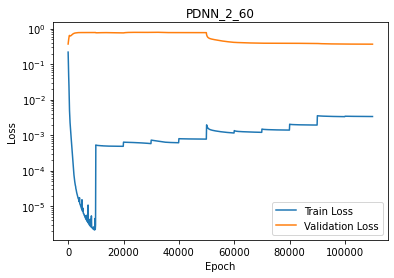

In [10]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.3 Train PRNN

In [11]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=60)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=225)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=110000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [12]:
prnn_trainer.train()

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 234.576; step 0.358402
1:  |F(x)| = 125.615; step 1
2:  |F(x)| = 49.2163; step 1
3:  |F(x)| = 37.0405; step 1
4:  |F(x)| = 27.3224; step 1
5:  |F(x)| = 6.70208; step 1
6:  |F(x)| = 4.07486; step 0.433509
7:  |F(x)| = 4.04412; step 0.024388
8:  |F(x)| = 4.03194; step 0.01
9:  |F(x)| = 8.53649; step 1
10:  |F(x)| = 9.01796; step 1
11:  |F(x)| = 3.9374; step 1
12:  |F(x)| = 1.47068; step 1
13:  |F(x)| = 1.62166; step 1
14:  |F(x)| = 1.33624; step 1
15:  |F(x)| = 0.585479; step 1
16:  |F(x)| = 0.186083; step 1
17:  |F(x)| = 0.413167; step 1
18:  |F(x)| = 0.351023; step 1
19:  |F(x)| = 0.127233; step 1
20:  |F(x)| = 0.0604585; step 1
21:  |F(x)| = 0.0584507; step 0.396029
22:  |F(x)| = 0.0653172; step 0.486879
23:  |F(x)| = 0.0666867; step 1
24:  |F(x)| = 0.0332032; step 1
25:  |F(x)| = 0.00967637; step 1
26:  |F(x)| = 0.0100634; step 0.515615
27:  |F(x)| = 0.0126753; step 1
28:  |F(x)| = 0

8:  |F(x)| = 3.65745; step 0.01
9:  |F(x)| = 6.55043; step 1
10:  |F(x)| = 6.06864; step 1
11:  |F(x)| = 2.04777; step 1
12:  |F(x)| = 1.15427; step 1
13:  |F(x)| = 1.31444; step 1
14:  |F(x)| = 0.852559; step 1
15:  |F(x)| = 0.256187; step 1
16:  |F(x)| = 0.23568; step 1
17:  |F(x)| = 0.257537; step 0.32453
18:  |F(x)| = 0.266316; step 1
19:  |F(x)| = 0.138208; step 1
20:  |F(x)| = 0.0349248; step 1
21:  |F(x)| = 0.0313579; step 0.320233
22:  |F(x)| = 0.032575; step 0.22061
23:  |F(x)| = 0.0326336; step 0.21794
24:  |F(x)| = 0.0377051; step 0.31274
25:  |F(x)| = 0.0455026; step 1
26:  |F(x)| = 0.0254068; step 1
27:  |F(x)| = 0.00721974; step 1
28:  |F(x)| = 0.00786175; step 1
29:  |F(x)| = 0.00828772; step 1
30:  |F(x)| = 0.00373851; step 1
31:  |F(x)| = 0.0010138; step 1
32:  |F(x)| = 0.000987381; step 0.149737
33:  |F(x)| = 0.00101346; step 0.0920948
34:  |F(x)| = 0.00102712; step 0.0674851
35:  |F(x)| = 0.00103549; step 0.0563911
36:  |F(x)| = 0.00108396; step 0.0526312
37:  |F(x)|

38:  |F(x)| = 0.00022565; step 0.125618
39:  |F(x)| = 0.00025229; step 0.0808491
40:  |F(x)| = 0.000271511; step 0.06187
41:  |F(x)| = 0.000286666; step 0.0541721
42:  |F(x)| = 0.000300233; step 0.0534025
43:  |F(x)| = 0.00031383; step 0.0591756
44:  |F(x)| = 0.000329059; step 0.0746153
45:  |F(x)| = 0.000348214; step 0.110519
46:  |F(x)| = 0.000375158; step 0.206197
47:  |F(x)| = 0.000434085; step 1
48:  |F(x)| = 0.000212007; step 1
49:  |F(x)| = 5.31967e-05; step 1
50:  |F(x)| = 4.69409e-05; step 0.32709
51:  |F(x)| = 4.78521e-05; step 0.261737
52:  |F(x)| = 5.51203e-05; step 0.350876
53:  |F(x)| = 6.46927e-05; step 1
54:  |F(x)| = 3.05419e-05; step 1
55:  |F(x)| = 8.26074e-06; step 1
56:  |F(x)| = 8.26904e-06; step 0.410579
57:  |F(x)| = 8.75724e-06; step 0.463591
58:  |F(x)| = 9.40957e-06; step 1
59:  |F(x)| = 3.69927e-06; step 1
scipy solver converged in 61 iterations.
0:  |F(x)| = 20.5806; step 1
1:  |F(x)| = 4.58465; step 1
2:  |F(x)| = 1.13226; step 1
3:  |F(x)| = 1.35386; step

0:  |F(x)| = 0.158814; step 1
1:  |F(x)| = 0.00552334; step 1
2:  |F(x)| = 0.00310017; step 1
3:  |F(x)| = 0.00029019; step 1
4:  |F(x)| = 8.23888e-05; step 1
5:  |F(x)| = 1.48227e-05; step 1
6:  |F(x)| = 2.80718e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 10.1764; step 1
1:  |F(x)| = 2.00675; step 1
2:  |F(x)| = 0.639584; step 1
3:  |F(x)| = 0.691989; step 1
4:  |F(x)| = 0.276271; step 1
5:  |F(x)| = 0.0370574; step 1
6:  |F(x)| = 0.0256447; step 0.516746
7:  |F(x)| = 0.0333827; step 1
8:  |F(x)| = 0.00639023; step 1
9:  |F(x)| = 0.00489463; step 1
10:  |F(x)| = 0.00326101; step 1
11:  |F(x)| = 0.00041776; step 1
12:  |F(x)| = 0.000330749; step 0.498473
13:  |F(x)| = 0.000375404; step 0.483672
14:  |F(x)| = 0.000346093; step 1
15:  |F(x)| = 7.1345e-05; step 1
16:  |F(x)| = 4.10243e-05; step 1
17:  |F(x)| = 3.0321e-05; step 1
18:  |F(x)| = 3.92796e-06; step 1
scipy solver converged in 20 iterations.
0:  |F(x)| = 202.883; step 0.54228
1:  |F(x)| = 56.7808; step 1
2:

3:  |F(x)| = 5.17219; step 1
4:  |F(x)| = 6.17717; step 1
5:  |F(x)| = 6.53288; step 0.284674
6:  |F(x)| = 6.25707; step 1
7:  |F(x)| = 2.8302; step 1
8:  |F(x)| = 0.734102; step 1
9:  |F(x)| = 1.02515; step 1
10:  |F(x)| = 0.641388; step 1
11:  |F(x)| = 0.149887; step 1
12:  |F(x)| = 0.0994752; step 0.422938
13:  |F(x)| = 0.0994835; step 0.258054
14:  |F(x)| = 0.122979; step 0.272923
15:  |F(x)| = 0.143299; step 0.513811
16:  |F(x)| = 0.117058; step 1
17:  |F(x)| = 0.0310963; step 1
18:  |F(x)| = 0.0241993; step 1
19:  |F(x)| = 0.0263765; step 0.275398
20:  |F(x)| = 0.0277007; step 1
21:  |F(x)| = 0.0118114; step 1
22:  |F(x)| = 0.00333926; step 1
23:  |F(x)| = 0.00346954; step 0.491431
24:  |F(x)| = 0.00398152; step 1
25:  |F(x)| = 0.00161819; step 1
26:  |F(x)| = 0.000451257; step 1
27:  |F(x)| = 0.000535265; step 0.145245
28:  |F(x)| = 0.00060046; step 0.149608
29:  |F(x)| = 0.000666677; step 0.215617
30:  |F(x)| = 0.000737936; step 0.485423
31:  |F(x)| = 0.000598878; step 1
32:  |

11:  |F(x)| = 1.68849e-06; step 1
scipy solver converged in 13 iterations.
0:  |F(x)| = 17.4999; step 1
1:  |F(x)| = 3.8086; step 1
2:  |F(x)| = 1.00127; step 1
3:  |F(x)| = 1.18509; step 1
4:  |F(x)| = 0.692029; step 1
5:  |F(x)| = 0.114104; step 1
6:  |F(x)| = 0.0937699; step 1
7:  |F(x)| = 0.0617266; step 1
8:  |F(x)| = 0.0106227; step 1
9:  |F(x)| = 0.0141254; step 1
10:  |F(x)| = 0.00714737; step 1
11:  |F(x)| = 0.00123439; step 1
12:  |F(x)| = 0.00106712; step 0.384491
13:  |F(x)| = 0.00136043; step 0.484897
14:  |F(x)| = 0.00114047; step 1
15:  |F(x)| = 0.000238862; step 1
16:  |F(x)| = 0.000151936; step 1
17:  |F(x)| = 0.000121994; step 1
18:  |F(x)| = 1.88643e-05; step 1
19:  |F(x)| = 2.37723e-05; step 1
20:  |F(x)| = 1.53007e-05; step 1
21:  |F(x)| = 2.17461e-06; step 1
scipy solver converged in 23 iterations.
0:  |F(x)| = 8.90437; step 1
1:  |F(x)| = 1.70586; step 1
2:  |F(x)| = 0.568255; step 1
3:  |F(x)| = 0.595883; step 1
4:  |F(x)| = 0.216668; step 1
5:  |F(x)| = 0.02832

3:  |F(x)| = 1.60692; step 1
4:  |F(x)| = 1.30205; step 1
5:  |F(x)| = 0.381253; step 1
6:  |F(x)| = 0.110258; step 1
7:  |F(x)| = 0.137956; step 1
8:  |F(x)| = 0.0341165; step 1
9:  |F(x)| = 0.0217558; step 1
10:  |F(x)| = 0.0204614; step 1
11:  |F(x)| = 0.00410086; step 1
12:  |F(x)| = 0.00390612; step 1
13:  |F(x)| = 0.003387; step 1
14:  |F(x)| = 0.000801165; step 1
15:  |F(x)| = 0.000457938; step 1
16:  |F(x)| = 0.000430119; step 1
17:  |F(x)| = 8.48366e-05; step 1
18:  |F(x)| = 7.88368e-05; step 1
19:  |F(x)| = 6.53511e-05; step 1
20:  |F(x)| = 1.2217e-05; step 1
21:  |F(x)| = 1.18168e-05; step 1
22:  |F(x)| = 9.61368e-06; step 1
23:  |F(x)| = 1.80636e-06; step 1
scipy solver converged in 25 iterations.
0:  |F(x)| = 2.77995; step 1
1:  |F(x)| = 0.257612; step 1
2:  |F(x)| = 0.150132; step 1
3:  |F(x)| = 0.0855552; step 1
4:  |F(x)| = 0.00716203; step 1
5:  |F(x)| = 0.00749046; step 1
6:  |F(x)| = 0.00257256; step 1
7:  |F(x)| = 0.000435577; step 1
8:  |F(x)| = 0.000458739; step 1

6:  |F(x)| = 6.50428; step 1
7:  |F(x)| = 3.07467; step 1
8:  |F(x)| = 0.742618; step 1
9:  |F(x)| = 1.04953; step 1
10:  |F(x)| = 0.690238; step 1
11:  |F(x)| = 0.164158; step 1
12:  |F(x)| = 0.10339; step 0.454597
13:  |F(x)| = 0.0979578; step 0.261792
14:  |F(x)| = 0.122144; step 0.261517
15:  |F(x)| = 0.143259; step 0.457354
16:  |F(x)| = 0.127485; step 1
17:  |F(x)| = 0.0392642; step 1
18:  |F(x)| = 0.0221569; step 1
19:  |F(x)| = 0.0236214; step 0.124957
20:  |F(x)| = 0.0256498; step 0.243939
21:  |F(x)| = 0.0281131; step 1
22:  |F(x)| = 0.0124591; step 1
23:  |F(x)| = 0.00331702; step 1
24:  |F(x)| = 0.00345498; step 0.488761
25:  |F(x)| = 0.00404584; step 1
26:  |F(x)| = 0.00173934; step 1
27:  |F(x)| = 0.000434341; step 1
28:  |F(x)| = 0.00048996; step 0.155457
29:  |F(x)| = 0.000557024; step 0.137803
30:  |F(x)| = 0.000617711; step 0.166834
31:  |F(x)| = 0.000685613; step 0.29144
32:  |F(x)| = 0.000725637; step 1
33:  |F(x)| = 0.000296582; step 1
34:  |F(x)| = 7.49337e-05; st

1:  |F(x)| = 0.000123586; step 1
2:  |F(x)| = 2.33338e-05; step 1
3:  |F(x)| = 6.4157e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.36818; step 1
1:  |F(x)| = 0.015233; step 1
2:  |F(x)| = 0.0103996; step 1
3:  |F(x)| = 0.00165791; step 1
4:  |F(x)| = 0.000316221; step 1
5:  |F(x)| = 0.0001111; step 1
6:  |F(x)| = 9.61668e-06; step 1
7:  |F(x)| = 7.90208e-06; step 1
8:  |F(x)| = 4.93135e-07; step 1
scipy solver converged in 10 iterations.
0:  |F(x)| = 52.4955; step 1
1:  |F(x)| = 12.5868; step 1
2:  |F(x)| = 4.64698; step 1
3:  |F(x)| = 1.97505; step 1
4:  |F(x)| = 2.16453; step 0.341867
5:  |F(x)| = 2.66441; step 1
6:  |F(x)| = 1.20394; step 1
7:  |F(x)| = 0.25321; step 1
8:  |F(x)| = 0.326765; step 1
9:  |F(x)| = 0.173904; step 1
10:  |F(x)| = 0.0376147; step 1
11:  |F(x)| = 0.0302759; step 0.429706
12:  |F(x)| = 0.0399474; step 0.486469
13:  |F(x)| = 0.0354581; step 1
14:  |F(x)| = 0.00777209; step 1
15:  |F(x)| = 0.00765429; step 1
16:  |F(x)| = 0.00785054; ste

55:  |F(x)| = 7.90564e-06; step 1
56:  |F(x)| = 6.63795e-06; step 1
57:  |F(x)| = 2.38156e-06; step 1
scipy solver converged in 59 iterations.
0:  |F(x)| = 49.6018; step 1
1:  |F(x)| = 11.8768; step 1
2:  |F(x)| = 4.25713; step 1
3:  |F(x)| = 1.87572; step 1
4:  |F(x)| = 2.20471; step 0.386272
5:  |F(x)| = 2.40937; step 1
6:  |F(x)| = 0.998521; step 1
7:  |F(x)| = 0.21385; step 1
8:  |F(x)| = 0.296891; step 1
9:  |F(x)| = 0.139703; step 1
10:  |F(x)| = 0.0315948; step 1
11:  |F(x)| = 0.0325836; step 0.412977
12:  |F(x)| = 0.0438809; step 1
13:  |F(x)| = 0.0151522; step 1
14:  |F(x)| = 0.00584276; step 1
15:  |F(x)| = 0.00668814; step 0.262254
16:  |F(x)| = 0.00774696; step 1
17:  |F(x)| = 0.00291761; step 1
18:  |F(x)| = 0.000691398; step 1
19:  |F(x)| = 0.000819293; step 0.50542
20:  |F(x)| = 0.00079274; step 1
21:  |F(x)| = 0.000177624; step 1
22:  |F(x)| = 0.000163059; step 1
23:  |F(x)| = 0.00016133; step 1
24:  |F(x)| = 4.67425e-05; step 1
25:  |F(x)| = 2.35031e-05; step 1
26:  |F

3:  |F(x)| = 2.70198; step 1
4:  |F(x)| = 2.25811; step 0.335724
5:  |F(x)| = 2.17642; step 0.169019
6:  |F(x)| = 2.42599; step 0.132861
7:  |F(x)| = 2.63566; step 0.15043
8:  |F(x)| = 2.86934; step 0.257945
9:  |F(x)| = 3.03571; step 1
10:  |F(x)| = 1.33003; step 1
11:  |F(x)| = 0.312141; step 1
12:  |F(x)| = 0.406606; step 1
13:  |F(x)| = 0.229041; step 1
14:  |F(x)| = 0.0522528; step 1
15:  |F(x)| = 0.0352968; step 0.418756
16:  |F(x)| = 0.0492063; step 0.378136
17:  |F(x)| = 0.0580557; step 1
18:  |F(x)| = 0.0205111; step 1
19:  |F(x)| = 0.00807513; step 1
20:  |F(x)| = 0.00866027; step 0.102703
21:  |F(x)| = 0.00931324; step 0.147296
22:  |F(x)| = 0.0101388; step 0.294417
23:  |F(x)| = 0.0101809; step 1
24:  |F(x)| = 0.00386639; step 1
25:  |F(x)| = 0.00116542; step 1
26:  |F(x)| = 0.00158864; step 1
27:  |F(x)| = 0.000737739; step 1
28:  |F(x)| = 0.000167736; step 1
29:  |F(x)| = 0.000180299; step 0.257074
30:  |F(x)| = 0.000216647; step 0.253711
31:  |F(x)| = 0.000245743; step 0

66:  |F(x)| = 8.73469e-05; step 1
67:  |F(x)| = 9.15295e-05; step 0.346886
68:  |F(x)| = 9.05063e-05; step 0.332314
69:  |F(x)| = 0.000126102; step 1
70:  |F(x)| = 7.27028e-05; step 1
71:  |F(x)| = 2.05111e-05; step 1
72:  |F(x)| = 1.48498e-05; step 0.481366
73:  |F(x)| = 1.56503e-05; step 0.412506
74:  |F(x)| = 2.03679e-05; step 1
75:  |F(x)| = 1.15105e-05; step 1
76:  |F(x)| = 2.68291e-06; step 1
scipy solver converged in 78 iterations.
0:  |F(x)| = 20.0441; step 1
1:  |F(x)| = 4.44913; step 1
2:  |F(x)| = 1.11023; step 1
3:  |F(x)| = 1.32627; step 1
4:  |F(x)| = 0.856705; step 1
5:  |F(x)| = 0.176124; step 1
6:  |F(x)| = 0.103499; step 1
7:  |F(x)| = 0.0814573; step 1
8:  |F(x)| = 0.0156953; step 1
9:  |F(x)| = 0.0169201; step 1
10:  |F(x)| = 0.0103235; step 1
11:  |F(x)| = 0.00158365; step 1
12:  |F(x)| = 0.00125287; step 0.43934
13:  |F(x)| = 0.00144089; step 0.371719
14:  |F(x)| = 0.00169349; step 1
15:  |F(x)| = 0.000516962; step 1
16:  |F(x)| = 0.000153209; step 1
17:  |F(x)| =

77:  |F(x)| = 1.2556e-05; step 0.287747
78:  |F(x)| = 1.37693e-05; step 1
79:  |F(x)| = 7.47601e-06; step 1
80:  |F(x)| = 2.04186e-06; step 1
scipy solver converged in 82 iterations.
0:  |F(x)| = 174.557; step 0.406344
1:  |F(x)| = 69.2386; step 1
2:  |F(x)| = 35.8582; step 1
3:  |F(x)| = 22.6521; step 1
4:  |F(x)| = 14.9036; step 1
5:  |F(x)| = 4.56741; step 1
6:  |F(x)| = 3.68526; step 0.2952
7:  |F(x)| = 3.64253; step 0.0255195
8:  |F(x)| = 3.66694; step 0.01
9:  |F(x)| = 6.46324; step 1
10:  |F(x)| = 5.92973; step 1
11:  |F(x)| = 1.96643; step 1
12:  |F(x)| = 1.13804; step 1
13:  |F(x)| = 1.29514; step 1
14:  |F(x)| = 0.828511; step 1
15:  |F(x)| = 0.247509; step 1
16:  |F(x)| = 0.236612; step 1
17:  |F(x)| = 0.259941; step 0.386402
18:  |F(x)| = 0.252832; step 1
19:  |F(x)| = 0.122303; step 1
20:  |F(x)| = 0.0320153; step 1
21:  |F(x)| = 0.0317479; step 0.275595
22:  |F(x)| = 0.032562; step 0.209591
23:  |F(x)| = 0.0331508; step 0.22745
24:  |F(x)| = 0.0392601; step 0.363332
25:  

14:  |F(x)| = 0.570685; step 1
15:  |F(x)| = 0.571742; step 1
16:  |F(x)| = 0.169858; step 1
17:  |F(x)| = 0.101983; step 1
18:  |F(x)| = 0.120759; step 0.519945
19:  |F(x)| = 0.0974185; step 1
20:  |F(x)| = 0.0232036; step 1
21:  |F(x)| = 0.0216459; step 1
22:  |F(x)| = 0.0236915; step 0.504962
23:  |F(x)| = 0.0184858; step 1
24:  |F(x)| = 0.00527855; step 1
25:  |F(x)| = 0.00285454; step 1
26:  |F(x)| = 0.00351133; step 1
27:  |F(x)| = 0.00138304; step 1
28:  |F(x)| = 0.000407537; step 1
29:  |F(x)| = 0.000493033; step 0.193247
30:  |F(x)| = 0.000564945; step 0.25301
31:  |F(x)| = 0.000678628; step 1
32:  |F(x)| = 0.000287164; step 1
33:  |F(x)| = 6.89424e-05; step 1
34:  |F(x)| = 6.55209e-05; step 0.215426
35:  |F(x)| = 7.96655e-05; step 0.224241
36:  |F(x)| = 9.3112e-05; step 0.376889
37:  |F(x)| = 9.2469e-05; step 1
38:  |F(x)| = 3.31343e-05; step 1
39:  |F(x)| = 1.15197e-05; step 1
40:  |F(x)| = 1.3566e-05; step 0.46593
41:  |F(x)| = 1.39183e-05; step 1
42:  |F(x)| = 4.42229e-06;

6:  |F(x)| = 2.4539; step 0.1487
7:  |F(x)| = 2.68479; step 0.190979
8:  |F(x)| = 2.94171; step 0.41167
9:  |F(x)| = 2.56182; step 1
10:  |F(x)| = 0.939368; step 1
11:  |F(x)| = 0.296391; step 1
12:  |F(x)| = 0.357785; step 1
13:  |F(x)| = 0.161537; step 1
14:  |F(x)| = 0.039762; step 1
15:  |F(x)| = 0.0439631; step 0.362474
16:  |F(x)| = 0.0630105; step 1
17:  |F(x)| = 0.0255786; step 1
18:  |F(x)| = 0.00640674; step 1
19:  |F(x)| = 0.00724117; step 0.104585
20:  |F(x)| = 0.00787432; step 0.097555
21:  |F(x)| = 0.00847512; step 0.114729
22:  |F(x)| = 0.00916398; step 0.176559
23:  |F(x)| = 0.00999728; step 0.400091
24:  |F(x)| = 0.00872071; step 1
25:  |F(x)| = 0.00285173; step 1
26:  |F(x)| = 0.00112142; step 1
27:  |F(x)| = 0.00138448; step 1
28:  |F(x)| = 0.000538911; step 1
29:  |F(x)| = 0.000170224; step 1
30:  |F(x)| = 0.000208423; step 0.251725
31:  |F(x)| = 0.000238329; step 0.407962
32:  |F(x)| = 0.000215933; step 1
33:  |F(x)| = 6.41536e-05; step 1
34:  |F(x)| = 3.2689e-05; 

25:  |F(x)| = 0.0515414; step 1
26:  |F(x)| = 0.0115343; step 1
27:  |F(x)| = 0.0110575; step 0.303539
28:  |F(x)| = 0.0125656; step 0.348825
29:  |F(x)| = 0.0157019; step 1
30:  |F(x)| = 0.0119736; step 1
31:  |F(x)| = 0.00327221; step 1
32:  |F(x)| = 0.00234225; step 1
33:  |F(x)| = 0.0024467; step 0.0574161
34:  |F(x)| = 0.00254824; step 0.0565128
35:  |F(x)| = 0.00264994; step 0.0625712
36:  |F(x)| = 0.00276357; step 0.0786744
37:  |F(x)| = 0.00290545; step 0.115504
38:  |F(x)| = 0.00310159; step 0.210477
39:  |F(x)| = 0.00354616; step 1
40:  |F(x)| = 0.00210157; step 1
41:  |F(x)| = 0.00064894; step 1
42:  |F(x)| = 0.000539579; step 1
43:  |F(x)| = 0.000594506; step 1
44:  |F(x)| = 0.000381098; step 1
45:  |F(x)| = 9.98194e-05; step 1
46:  |F(x)| = 6.55636e-05; step 0.519917
47:  |F(x)| = 7.20816e-05; step 0.31487
48:  |F(x)| = 7.34533e-05; step 0.272919
49:  |F(x)| = 8.13302e-05; step 0.380611
50:  |F(x)| = 9.51402e-05; step 1
51:  |F(x)| = 5.41174e-05; step 1
52:  |F(x)| = 1.346

1:  |F(x)| = 37.3477; step 1
2:  |F(x)| = 26.2306; step 1
3:  |F(x)| = 11.2386; step 1
4:  |F(x)| = 6.23973; step 1
5:  |F(x)| = 9.86702; step 1
6:  |F(x)| = 7.02197; step 1
7:  |F(x)| = 1.90084; step 1
8:  |F(x)| = 1.39992; step 1
9:  |F(x)| = 1.46658; step 1
10:  |F(x)| = 0.563907; step 1
11:  |F(x)| = 0.170354; step 1
12:  |F(x)| = 0.200762; step 0.208208
13:  |F(x)| = 0.23766; step 0.254066
14:  |F(x)| = 0.273926; step 0.522026
15:  |F(x)| = 0.223684; step 1
16:  |F(x)| = 0.0659725; step 1
17:  |F(x)| = 0.0405565; step 1
18:  |F(x)| = 0.0447424; step 0.198839
19:  |F(x)| = 0.0499247; step 0.451801
20:  |F(x)| = 0.0436277; step 1
21:  |F(x)| = 0.0159693; step 1
22:  |F(x)| = 0.00666436; step 1
23:  |F(x)| = 0.00903952; step 1
24:  |F(x)| = 0.00516912; step 1
25:  |F(x)| = 0.00117053; step 1
26:  |F(x)| = 0.000890912; step 0.320524
27:  |F(x)| = 0.000773181; step 0.160076
28:  |F(x)| = 0.000899593; step 0.110922
29:  |F(x)| = 0.000991618; step 0.0977774
30:  |F(x)| = 0.00107516; step

10:  |F(x)| = 6.59505; step 0.0257608
11:  |F(x)| = 6.53271; step 0.0114722
12:  |F(x)| = 14.8943; step 1
13:  |F(x)| = 15.3223; step 1
14:  |F(x)| = 8.62112; step 1
15:  |F(x)| = 3.42725; step 1
16:  |F(x)| = 2.35672; step 1
17:  |F(x)| = 1.88054; step 1
18:  |F(x)| = 0.924809; step 1
19:  |F(x)| = 0.262143; step 1
20:  |F(x)| = 0.247295; step 0.197325
21:  |F(x)| = 0.581275; step 1
22:  |F(x)| = 0.582746; step 0.0287315
23:  |F(x)| = 0.586594; step 0.091474
24:  |F(x)| = 0.591531; step 0.356448
25:  |F(x)| = 0.507672; step 1
26:  |F(x)| = 0.267993; step 1
27:  |F(x)| = 0.0938773; step 1
28:  |F(x)| = 0.0702221; step 1
29:  |F(x)| = 0.0523134; step 1
30:  |F(x)| = 0.0375203; step 1
31:  |F(x)| = 0.00887528; step 1
32:  |F(x)| = 0.0065808; step 0.48175
33:  |F(x)| = 0.00702334; step 0.456016
34:  |F(x)| = 0.00904713; step 1
35:  |F(x)| = 0.00672132; step 1
36:  |F(x)| = 0.00180256; step 1
37:  |F(x)| = 0.000854075; step 0.493781
38:  |F(x)| = 0.000839151; step 0.0418536
39:  |F(x)| = 0

54:  |F(x)| = 1.20591e-05; step 0.01
55:  |F(x)| = 2.39662e-05; step 1
56:  |F(x)| = 2.01675e-05; step 1
57:  |F(x)| = 9.0741e-06; step 1
58:  |F(x)| = 3.33061e-06; step 1
scipy solver converged in 60 iterations.
0:  |F(x)| = 3.56716; step 1
1:  |F(x)| = 0.38881; step 1
2:  |F(x)| = 0.195123; step 1
3:  |F(x)| = 0.133662; step 1
4:  |F(x)| = 0.0175555; step 1
5:  |F(x)| = 0.0109494; step 1
6:  |F(x)| = 0.00509967; step 1
7:  |F(x)| = 0.000584606; step 1
8:  |F(x)| = 0.000863584; step 1
9:  |F(x)| = 0.000178309; step 1
10:  |F(x)| = 8.44318e-05; step 1
11:  |F(x)| = 5.19165e-05; step 1
12:  |F(x)| = 4.90649e-06; step 1
scipy solver converged in 14 iterations.
0:  |F(x)| = 125.469; step 1
1:  |F(x)| = 29.2125; step 1
2:  |F(x)| = 18.5314; step 1
3:  |F(x)| = 5.16649; step 1
4:  |F(x)| = 6.17659; step 1
5:  |F(x)| = 6.53287; step 0.285805
6:  |F(x)| = 6.25028; step 1
7:  |F(x)| = 2.82357; step 1
8:  |F(x)| = 0.734246; step 1
9:  |F(x)| = 1.02447; step 1
10:  |F(x)| = 0.640061; step 1
11: 

11:  |F(x)| = 0.635962; step 1
12:  |F(x)| = 0.354446; step 1
13:  |F(x)| = 0.0845651; step 1
14:  |F(x)| = 0.0653487; step 0.310966
15:  |F(x)| = 0.0616867; step 0.172916
16:  |F(x)| = 0.068945; step 0.134907
17:  |F(x)| = 0.0777938; step 0.139323
18:  |F(x)| = 0.0870346; step 0.192347
19:  |F(x)| = 0.0983112; step 0.388022
20:  |F(x)| = 0.0953442; step 1
21:  |F(x)| = 0.0396205; step 1
22:  |F(x)| = 0.0111521; step 1
23:  |F(x)| = 0.0115285; step 0.145959
24:  |F(x)| = 0.0116709; step 0.121682
25:  |F(x)| = 0.0128588; step 0.129171
26:  |F(x)| = 0.0143204; step 0.176796
27:  |F(x)| = 0.0161251; step 0.33612
28:  |F(x)| = 0.0168147; step 1
29:  |F(x)| = 0.00788146; step 1
30:  |F(x)| = 0.00221538; step 1
31:  |F(x)| = 0.00237738; step 0.498691
32:  |F(x)| = 0.00283736; step 1
33:  |F(x)| = 0.00155306; step 1
34:  |F(x)| = 0.000364502; step 1
35:  |F(x)| = 0.000292161; step 0.259255
36:  |F(x)| = 0.000262126; step 0.117904
37:  |F(x)| = 0.00026434; step 0.0674771
38:  |F(x)| = 0.000281

56:  |F(x)| = 2.90514e-05; step 1
57:  |F(x)| = 1.48308e-05; step 1
58:  |F(x)| = 3.67518e-06; step 1
scipy solver converged in 60 iterations.
0:  |F(x)| = 293.589; step 0.321306
1:  |F(x)| = 193.379; step 1
2:  |F(x)| = 65.5532; step 1
3:  |F(x)| = 53.8524; step 1
4:  |F(x)| = 41.6023; step 1
5:  |F(x)| = 9.6686; step 1
6:  |F(x)| = 5.24966; step 0.496931
7:  |F(x)| = 4.83987; step 0.124899
8:  |F(x)| = 4.71015; step 0.0382593
9:  |F(x)| = 4.66793; step 0.0124092
10:  |F(x)| = 10.7412; step 1
11:  |F(x)| = 11.5084; step 1
12:  |F(x)| = 5.72551; step 1
13:  |F(x)| = 2.11736; step 1
14:  |F(x)| = 1.79312; step 1
15:  |F(x)| = 1.65264; step 1
16:  |F(x)| = 0.831129; step 1
17:  |F(x)| = 0.188264; step 1
18:  |F(x)| = 0.498472; step 1
19:  |F(x)| = 0.488777; step 1
20:  |F(x)| = 0.22761; step 1
21:  |F(x)| = 0.071415; step 1
22:  |F(x)| = 0.0929934; step 1
23:  |F(x)| = 0.0898996; step 1
24:  |F(x)| = 0.049248; step 1
25:  |F(x)| = 0.0129952; step 1
26:  |F(x)| = 0.0133222; step 0.459312


31:  |F(x)| = 0.00836983; step 0.493198
32:  |F(x)| = 0.0102823; step 1
33:  |F(x)| = 0.00808517; step 1
34:  |F(x)| = 0.00251384; step 1
35:  |F(x)| = 0.0017551; step 1
36:  |F(x)| = 0.00346694; step 1
37:  |F(x)| = 0.00301567; step 1
38:  |F(x)| = 0.00176172; step 1
39:  |F(x)| = 0.000683382; step 1
40:  |F(x)| = 0.000491215; step 1
41:  |F(x)| = 0.000322177; step 1
42:  |F(x)| = 0.000143005; step 1
43:  |F(x)| = 3.62521e-05; step 1
44:  |F(x)| = 0.000104473; step 1
45:  |F(x)| = 0.000103737; step 1
46:  |F(x)| = 6.67549e-05; step 1
47:  |F(x)| = 2.03507e-05; step 1
48:  |F(x)| = 1.42531e-05; step 1
49:  |F(x)| = 1.25863e-05; step 0.393426
50:  |F(x)| = 1.31632e-05; step 0.460375
51:  |F(x)| = 1.36062e-05; step 1
52:  |F(x)| = 8.16335e-06; step 1
53:  |F(x)| = 3.57661e-06; step 1
scipy solver converged in 55 iterations.
0:  |F(x)| = 14.7728; step 1
1:  |F(x)| = 3.128; step 1
2:  |F(x)| = 0.875525; step 1
3:  |F(x)| = 1.01551; step 1
4:  |F(x)| = 0.525345; step 1
5:  |F(x)| = 0.074749

45:  |F(x)| = 6.00607e-05; step 0.398262
46:  |F(x)| = 6.39259e-05; step 0.234932
47:  |F(x)| = 6.50111e-05; step 0.20784
48:  |F(x)| = 7.04087e-05; step 0.26872
49:  |F(x)| = 8.25728e-05; step 0.516236
50:  |F(x)| = 7.6039e-05; step 1
51:  |F(x)| = 3.56748e-05; step 1
52:  |F(x)| = 9.66048e-06; step 1
53:  |F(x)| = 8.93808e-06; step 0.0943504
54:  |F(x)| = 9.06888e-06; step 0.0474384
55:  |F(x)| = 9.12938e-06; step 0.0251902
56:  |F(x)| = 9.15997e-06; step 0.0137733
57:  |F(x)| = 9.18121e-06; step 0.01
58:  |F(x)| = 1.86089e-05; step 1
59:  |F(x)| = 1.71118e-05; step 1
60:  |F(x)| = 8.90312e-06; step 1
61:  |F(x)| = 2.89217e-06; step 1
scipy solver converged in 63 iterations.
0:  |F(x)| = 81.5815; step 0.520114
1:  |F(x)| = 15.0498; step 1
2:  |F(x)| = 18.1153; step 1
3:  |F(x)| = 7.03448; step 1
4:  |F(x)| = 2.33329; step 1
5:  |F(x)| = 1.52002; step 0.400421
6:  |F(x)| = 1.36705; step 0.102563
7:  |F(x)| = 1.31344; step 0.0383809
8:  |F(x)| = 1.29181; step 0.0158719
9:  |F(x)| = 1.2

41:  |F(x)| = 0.00192938; step 1
42:  |F(x)| = 0.000773565; step 1
43:  |F(x)| = 0.000451993; step 1
44:  |F(x)| = 0.000346977; step 1
45:  |F(x)| = 0.000168663; step 1
46:  |F(x)| = 3.37356e-05; step 1
47:  |F(x)| = 2.7769e-05; step 0.418286
48:  |F(x)| = 8.48499e-05; step 1
49:  |F(x)| = 8.63716e-05; step 1
50:  |F(x)| = 5.2161e-05; step 1
51:  |F(x)| = 1.46165e-05; step 1
52:  |F(x)| = 1.12413e-05; step 1
53:  |F(x)| = 1.06843e-05; step 0.216888
54:  |F(x)| = 1.16211e-05; step 0.289384
55:  |F(x)| = 1.26803e-05; step 0.497824
56:  |F(x)| = 1.14302e-05; step 1
57:  |F(x)| = 6.32002e-06; step 1
58:  |F(x)| = 2.78085e-06; step 1
scipy solver converged in 60 iterations.
0:  |F(x)| = 116.705; step 0.46823
1:  |F(x)| = 30.8254; step 1
2:  |F(x)| = 24.7456; step 1
3:  |F(x)| = 11.9185; step 1
4:  |F(x)| = 5.51017; step 1
5:  |F(x)| = 3.83834; step 1
6:  |F(x)| = 4.12517; step 0.270451
7:  |F(x)| = 4.46808; step 1
8:  |F(x)| = 2.81544; step 1
9:  |F(x)| = 0.678445; step 1
10:  |F(x)| = 0.55

60:  |F(x)| = 1.66103e-05; step 0.166837
61:  |F(x)| = 1.84905e-05; step 0.375106
62:  |F(x)| = 1.85808e-05; step 1
63:  |F(x)| = 9.69787e-06; step 1
64:  |F(x)| = 2.75514e-06; step 1
scipy solver converged in 66 iterations.
0:  |F(x)| = 93.7342; step 0.499666
1:  |F(x)| = 19.1933; step 1
2:  |F(x)| = 20.5216; step 1
3:  |F(x)| = 8.77496; step 1
4:  |F(x)| = 3.17802; step 1
5:  |F(x)| = 1.70394; step 0.500237
6:  |F(x)| = 1.53002; step 0.110278
7:  |F(x)| = 1.473; step 0.0384731
8:  |F(x)| = 1.45172; step 0.0146769
9:  |F(x)| = 1.43734; step 0.01
10:  |F(x)| = 3.773; step 1
11:  |F(x)| = 2.78896; step 1
12:  |F(x)| = 0.965975; step 1
13:  |F(x)| = 0.490267; step 1
14:  |F(x)| = 0.600345; step 1
15:  |F(x)| = 0.339911; step 1
16:  |F(x)| = 0.0795849; step 1
17:  |F(x)| = 0.0611121; step 0.319446
18:  |F(x)| = 0.0565566; step 0.180333
19:  |F(x)| = 0.0657638; step 0.145515
20:  |F(x)| = 0.0746537; step 0.159433
21:  |F(x)| = 0.0842759; step 0.243683
22:  |F(x)| = 0.102145; step 1
23:  |F

26:  |F(x)| = 0.0124175; step 0.139175
27:  |F(x)| = 0.0125216; step 0.126923
28:  |F(x)| = 0.0140199; step 0.148018
29:  |F(x)| = 0.0157243; step 0.228365
30:  |F(x)| = 0.0177189; step 0.517835
31:  |F(x)| = 0.014985; step 1
32:  |F(x)| = 0.00580035; step 1
33:  |F(x)| = 0.00253079; step 1
34:  |F(x)| = 0.00319601; step 1
35:  |F(x)| = 0.00211263; step 1
36:  |F(x)| = 0.000476436; step 1
37:  |F(x)| = 0.000333124; step 0.426691
38:  |F(x)| = 0.000289865; step 0.156736
39:  |F(x)| = 0.00027026; step 0.0755646
40:  |F(x)| = 0.000270177; step 0.0422806
41:  |F(x)| = 0.000281382; step 0.0257863
42:  |F(x)| = 0.000288326; step 0.0165894
43:  |F(x)| = 0.000292838; step 0.0110458
44:  |F(x)| = 0.000296857; step 0.01
45:  |F(x)| = 0.000692801; step 1
46:  |F(x)| = 0.000498365; step 1
47:  |F(x)| = 0.000144238; step 1
48:  |F(x)| = 9.28488e-05; step 1
49:  |F(x)| = 0.000108432; step 0.453014
50:  |F(x)| = 0.000110588; step 1
51:  |F(x)| = 4.92542e-05; step 1
52:  |F(x)| = 1.46764e-05; step 1
5

45:  |F(x)| = 4.93515e-05; step 0.11821
46:  |F(x)| = 5.03386e-05; step 0.0491771
47:  |F(x)| = 5.07476e-05; step 0.0228825
48:  |F(x)| = 5.0937e-05; step 0.011211
49:  |F(x)| = 0.000117478; step 1
50:  |F(x)| = 9.95459e-05; step 1
51:  |F(x)| = 4.72989e-05; step 1
52:  |F(x)| = 1.28207e-05; step 1
53:  |F(x)| = 1.32748e-05; step 0.32528
54:  |F(x)| = 1.33216e-05; step 0.0872928
55:  |F(x)| = 1.33143e-05; step 0.0702039
56:  |F(x)| = 1.32793e-05; step 0.0612946
57:  |F(x)| = 1.32246e-05; step 0.0576076
58:  |F(x)| = 1.31502e-05; step 0.0580985
59:  |F(x)| = 1.305e-05; step 0.0629651
60:  |F(x)| = 1.29094e-05; step 0.0738019
61:  |F(x)| = 1.33909e-05; step 0.0948281
62:  |F(x)| = 1.42821e-05; step 0.136915
63:  |F(x)| = 1.62134e-05; step 0.395864
64:  |F(x)| = 1.6852e-05; step 1
65:  |F(x)| = 1.00861e-05; step 1
66:  |F(x)| = 3.75734e-06; step 1
scipy solver converged in 68 iterations.
0:  |F(x)| = 3.36491; step 1
1:  |F(x)| = 0.353155; step 1
2:  |F(x)| = 0.184004; step 1
3:  |F(x)| = 

29:  |F(x)| = 0.00165766; step 1
30:  |F(x)| = 0.00150444; step 0.150545
31:  |F(x)| = 0.00154867; step 0.0761639
32:  |F(x)| = 0.0015692; step 0.0438465
33:  |F(x)| = 0.00158033; step 0.0272781
34:  |F(x)| = 0.00158696; step 0.0178217
35:  |F(x)| = 0.00159116; step 0.0120298
36:  |F(x)| = 0.00159449; step 0.01
37:  |F(x)| = 0.0015977; step 0.01
38:  |F(x)| = 0.00342144; step 1
39:  |F(x)| = 0.00272131; step 1
40:  |F(x)| = 0.00108543; step 1
41:  |F(x)| = 0.00047081; step 1
42:  |F(x)| = 0.000470208; step 0.472385
43:  |F(x)| = 0.000571241; step 1
44:  |F(x)| = 0.000353313; step 1
45:  |F(x)| = 9.84353e-05; step 1
46:  |F(x)| = 9.76167e-05; step 1
47:  |F(x)| = 0.000123078; step 1
48:  |F(x)| = 7.04808e-05; step 1
49:  |F(x)| = 1.75045e-05; step 1
50:  |F(x)| = 1.26446e-05; step 0.410226
51:  |F(x)| = 1.33328e-05; step 0.16307
52:  |F(x)| = 1.35476e-05; step 0.0903407
53:  |F(x)| = 1.36406e-05; step 0.0618894
54:  |F(x)| = 1.36874e-05; step 0.0491234
55:  |F(x)| = 1.37112e-05; step 0.

2:  |F(x)| = 20.2361; step 1
3:  |F(x)| = 6.3962; step 1
4:  |F(x)| = 6.27376; step 1
5:  |F(x)| = 6.4634; step 0.101433
6:  |F(x)| = 6.81583; step 0.281818
7:  |F(x)| = 6.52237; step 1
8:  |F(x)| = 2.99965; step 1
9:  |F(x)| = 0.775747; step 1
10:  |F(x)| = 1.0699; step 1
11:  |F(x)| = 0.691612; step 1
12:  |F(x)| = 0.164028; step 1
13:  |F(x)| = 0.105763; step 0.439402
14:  |F(x)| = 0.100464; step 0.252108
15:  |F(x)| = 0.124592; step 0.245491
16:  |F(x)| = 0.146137; step 0.405854
17:  |F(x)| = 0.140711; step 1
18:  |F(x)| = 0.0491522; step 1
19:  |F(x)| = 0.019952; step 1
20:  |F(x)| = 0.0208755; step 0.055728
21:  |F(x)| = 0.0218765; step 0.0675601
22:  |F(x)| = 0.0230902; step 0.094888
23:  |F(x)| = 0.0247411; step 0.16308
24:  |F(x)| = 0.0270359; step 0.386067
25:  |F(x)| = 0.0246494; step 1
26:  |F(x)| = 0.00935731; step 1
27:  |F(x)| = 0.00349899; step 1
28:  |F(x)| = 0.00457499; step 1
29:  |F(x)| = 0.00251247; step 1
30:  |F(x)| = 0.00056474; step 1
31:  |F(x)| = 0.000438609;

14:  |F(x)| = 1.69894; step 1
15:  |F(x)| = 1.58773; step 1
16:  |F(x)| = 0.781463; step 1
17:  |F(x)| = 0.183312; step 1
18:  |F(x)| = 0.476154; step 1
19:  |F(x)| = 0.454763; step 1
20:  |F(x)| = 0.20169; step 1
21:  |F(x)| = 0.0656265; step 1
22:  |F(x)| = 0.0670776; step 0.521952
23:  |F(x)| = 0.0661046; step 0.475555
24:  |F(x)| = 0.0772137; step 1
25:  |F(x)| = 0.0435371; step 1
26:  |F(x)| = 0.0132257; step 1
27:  |F(x)| = 0.0131239; step 1
28:  |F(x)| = 0.0144899; step 1
29:  |F(x)| = 0.00752311; step 1
30:  |F(x)| = 0.0018821; step 1
31:  |F(x)| = 0.00157709; step 0.211147
32:  |F(x)| = 0.00146463; step 0.083119
33:  |F(x)| = 0.00147238; step 0.0371701
34:  |F(x)| = 0.00148304; step 0.0176725
35:  |F(x)| = 0.0014888; step 0.01
36:  |F(x)| = 0.00368163; step 1
37:  |F(x)| = 0.00319116; step 1
38:  |F(x)| = 0.00148394; step 1
39:  |F(x)| = 0.000480666; step 1
40:  |F(x)| = 0.000606321; step 1
41:  |F(x)| = 0.00056917; step 1
42:  |F(x)| = 0.000253687; step 1
43:  |F(x)| = 8.0451

73:  |F(x)| = 0.00012457; step 0.434383
74:  |F(x)| = 0.000126256; step 0.333703
75:  |F(x)| = 0.00013962; step 0.460064
76:  |F(x)| = 0.000147844; step 1
77:  |F(x)| = 7.04168e-05; step 1
78:  |F(x)| = 1.99672e-05; step 1
79:  |F(x)| = 2.10333e-05; step 0.412158
80:  |F(x)| = 2.13177e-05; step 0.461664
81:  |F(x)| = 2.49525e-05; step 1
82:  |F(x)| = 1.2076e-05; step 1
83:  |F(x)| = 3.05455e-06; step 1
scipy solver converged in 85 iterations.
0:  |F(x)| = 5.36559; step 1
1:  |F(x)| = 0.758644; step 1
2:  |F(x)| = 0.308527; step 1
3:  |F(x)| = 0.269124; step 1
4:  |F(x)| = 0.0595548; step 1
5:  |F(x)| = 0.017008; step 1
6:  |F(x)| = 0.014132; step 1
7:  |F(x)| = 0.0017594; step 1
8:  |F(x)| = 0.00211319; step 1
9:  |F(x)| = 0.000866655; step 1
10:  |F(x)| = 0.000127382; step 1
11:  |F(x)| = 0.000192723; step 1
12:  |F(x)| = 4.7753e-05; step 1
13:  |F(x)| = 1.70836e-05; step 1
14:  |F(x)| = 1.36163e-05; step 1
15:  |F(x)| = 1.43766e-06; step 1
scipy solver converged in 17 iterations.
0: 

47:  |F(x)| = 7.21569e-05; step 1
48:  |F(x)| = 1.78082e-05; step 1
49:  |F(x)| = 1.27288e-05; step 0.425838
50:  |F(x)| = 1.33319e-05; step 0.166126
51:  |F(x)| = 1.35515e-05; step 0.0903594
52:  |F(x)| = 1.36457e-05; step 0.0607874
53:  |F(x)| = 1.36934e-05; step 0.0472875
54:  |F(x)| = 1.37185e-05; step 0.0411441
55:  |F(x)| = 1.37296e-05; step 0.0394035
56:  |F(x)| = 1.37288e-05; step 0.0412821
57:  |F(x)| = 1.37342e-05; step 0.0474004
58:  |F(x)| = 1.43571e-05; step 0.0602292
59:  |F(x)| = 1.51617e-05; step 0.0864344
60:  |F(x)| = 1.63105e-05; step 0.145639
61:  |F(x)| = 1.80553e-05; step 0.308759
62:  |F(x)| = 1.94997e-05; step 1
63:  |F(x)| = 1.07958e-05; step 1
64:  |F(x)| = 3.11207e-06; step 1
scipy solver converged in 66 iterations.
0:  |F(x)| = 13.4983; step 1
1:  |F(x)| = 2.81305; step 1
2:  |F(x)| = 0.813293; step 1
3:  |F(x)| = 0.93018; step 1
4:  |F(x)| = 0.451746; step 1
5:  |F(x)| = 0.06347; step 1
6:  |F(x)| = 0.0722086; step 1
7:  |F(x)| = 0.0348713; step 1
8:  |F(x)

24:  |F(x)| = 0.0855317; step 1
25:  |F(x)| = 0.0534234; step 1
26:  |F(x)| = 0.0116323; step 1
27:  |F(x)| = 0.0105903; step 0.314167
28:  |F(x)| = 0.0123042; step 0.354654
29:  |F(x)| = 0.0124979; step 0.518499
30:  |F(x)| = 0.0136505; step 1
31:  |F(x)| = 0.00759832; step 1
32:  |F(x)| = 0.0018219; step 1
33:  |F(x)| = 0.00146588; step 0.272819
34:  |F(x)| = 0.00134959; step 0.0949325
35:  |F(x)| = 0.00130534; step 0.0373034
36:  |F(x)| = 0.00128721; step 0.0154907
37:  |F(x)| = 0.00128681; step 0.01
38:  |F(x)| = 0.00336254; step 1
39:  |F(x)| = 0.00307054; step 1
40:  |F(x)| = 0.00156923; step 1
41:  |F(x)| = 0.00046571; step 1
42:  |F(x)| = 0.000505708; step 1
43:  |F(x)| = 0.000515055; step 1
44:  |F(x)| = 0.000269744; step 1
45:  |F(x)| = 7.36036e-05; step 1
46:  |F(x)| = 6.679e-05; step 0.378354
47:  |F(x)| = 7.00013e-05; step 0.25447
48:  |F(x)| = 7.01781e-05; step 0.266614
49:  |F(x)| = 8.37364e-05; step 0.442407
50:  |F(x)| = 8.70238e-05; step 1
51:  |F(x)| = 4.54585e-05; s

9:  |F(x)| = 0.0912831; step 1
10:  |F(x)| = 0.0278817; step 1
11:  |F(x)| = 0.0367634; step 0.506379
12:  |F(x)| = 0.0311558; step 1
13:  |F(x)| = 0.00601336; step 1
14:  |F(x)| = 0.00699897; step 1
15:  |F(x)| = 0.00655439; step 1
16:  |F(x)| = 0.00199419; step 1
17:  |F(x)| = 0.000705996; step 1
18:  |F(x)| = 0.000956163; step 1
19:  |F(x)| = 0.000302624; step 1
20:  |F(x)| = 0.000138862; step 1
21:  |F(x)| = 0.000162167; step 0.520447
22:  |F(x)| = 0.000122811; step 1
23:  |F(x)| = 2.25713e-05; step 1
24:  |F(x)| = 2.54137e-05; step 1
25:  |F(x)| = 2.25306e-05; step 1
26:  |F(x)| = 5.69597e-06; step 1
scipy solver converged in 28 iterations.
0:  |F(x)| = 0.00456755; step 1
1:  |F(x)| = 8.11216e-05; step 1
2:  |F(x)| = 1.29714e-05; step 1
3:  |F(x)| = 3.48332e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.0219993; step 1
1:  |F(x)| = 0.000542982; step 1
2:  |F(x)| = 0.000164711; step 1
3:  |F(x)| = 4.98702e-06; step 1
scipy solver converged in 5 iterations.
0:  |

31:  |F(x)| = 0.00207022; step 1
32:  |F(x)| = 0.00163135; step 0.300031
33:  |F(x)| = 0.00150457; step 0.0927105
34:  |F(x)| = 0.00146175; step 0.0323086
35:  |F(x)| = 0.00144628; step 0.0118134
36:  |F(x)| = 0.00380642; step 1
37:  |F(x)| = 0.00352197; step 1
38:  |F(x)| = 0.00181879; step 1
39:  |F(x)| = 0.00053411; step 1
40:  |F(x)| = 0.000580242; step 1
41:  |F(x)| = 0.000584405; step 1
42:  |F(x)| = 0.000298212; step 1
43:  |F(x)| = 8.2392e-05; step 1
44:  |F(x)| = 7.64604e-05; step 0.346397
45:  |F(x)| = 7.99613e-05; step 0.236096
46:  |F(x)| = 8.04325e-05; step 0.246525
47:  |F(x)| = 9.59545e-05; step 0.399073
48:  |F(x)| = 0.00010398; step 1
49:  |F(x)| = 5.54829e-05; step 1
50:  |F(x)| = 1.40721e-05; step 1
51:  |F(x)| = 1.09342e-05; step 0.328421
52:  |F(x)| = 1.1233e-05; step 0.0876517
53:  |F(x)| = 1.12941e-05; step 0.0236393
54:  |F(x)| = 2.33722e-05; step 1
55:  |F(x)| = 2.06383e-05; step 1
56:  |F(x)| = 1.00501e-05; step 1
57:  |F(x)| = 3.19184e-06; step 1
scipy solver

20:  |F(x)| = 0.00051526; step 1
21:  |F(x)| = 0.000126356; step 1
22:  |F(x)| = 0.000166696; step 0.306256
23:  |F(x)| = 0.000192141; step 0.512705
24:  |F(x)| = 0.000147353; step 1
25:  |F(x)| = 2.95964e-05; step 1
26:  |F(x)| = 3.00821e-05; step 1
27:  |F(x)| = 2.88156e-05; step 1
28:  |F(x)| = 8.46761e-06; step 1
29:  |F(x)| = 3.83502e-06; step 1
scipy solver converged in 31 iterations.
0:  |F(x)| = 103.961; step 0.485034
1:  |F(x)| = 24.1575; step 1
2:  |F(x)| = 22.4; step 1
3:  |F(x)| = 10.1645; step 1
4:  |F(x)| = 3.93122; step 1
5:  |F(x)| = 3.92422; step 1
6:  |F(x)| = 4.15944; step 0.512464
7:  |F(x)| = 3.5741; step 1
8:  |F(x)| = 1.57368; step 1
9:  |F(x)| = 0.514832; step 1
10:  |F(x)| = 0.53556; step 0.495763
11:  |F(x)| = 0.603047; step 1
12:  |F(x)| = 0.298951; step 1
13:  |F(x)| = 0.0753977; step 1
14:  |F(x)| = 0.0615029; step 0.230915
15:  |F(x)| = 0.0649104; step 0.152262
16:  |F(x)| = 0.0748646; step 0.137046
17:  |F(x)| = 0.0841124; step 0.164368
18:  |F(x)| = 0.09

17:  |F(x)| = 6.29779e-05; step 1
18:  |F(x)| = 7.35565e-05; step 1
19:  |F(x)| = 5.37587e-05; step 1
20:  |F(x)| = 8.15176e-06; step 1
21:  |F(x)| = 1.09072e-05; step 1
22:  |F(x)| = 7.72144e-06; step 1
23:  |F(x)| = 1.31112e-06; step 1
scipy solver converged in 25 iterations.
0:  |F(x)| = 11.3634; step 1
1:  |F(x)| = 2.29193; step 1
2:  |F(x)| = 0.703663; step 1
3:  |F(x)| = 0.779472; step 1
4:  |F(x)| = 0.335947; step 1
5:  |F(x)| = 0.0459423; step 1
6:  |F(x)| = 0.0584331; step 1
7:  |F(x)| = 0.0231132; step 1
8:  |F(x)| = 0.00407427; step 1
9:  |F(x)| = 0.00679848; step 1
10:  |F(x)| = 0.00181948; step 1
11:  |F(x)| = 0.000841522; step 1
12:  |F(x)| = 0.000802225; step 1
13:  |F(x)| = 0.000168608; step 1
14:  |F(x)| = 9.95683e-05; step 1
15:  |F(x)| = 7.59493e-05; step 1
16:  |F(x)| = 9.9905e-06; step 1
17:  |F(x)| = 1.35941e-05; step 1
18:  |F(x)| = 7.61926e-06; step 1
19:  |F(x)| = 1.02231e-06; step 1
scipy solver converged in 21 iterations.
0:  |F(x)| = 291.589; step 0.477866
1

25:  |F(x)| = 0.54342; step 1
26:  |F(x)| = 0.296501; step 1
27:  |F(x)| = 0.108777; step 1
28:  |F(x)| = 0.0708423; step 1
29:  |F(x)| = 0.0580414; step 1
30:  |F(x)| = 0.0425833; step 1
31:  |F(x)| = 0.00939325; step 1
32:  |F(x)| = 0.007439; step 0.47775
33:  |F(x)| = 0.00671076; step 0.469615
34:  |F(x)| = 0.00729534; step 0.490207
35:  |F(x)| = 0.00828196; step 1
36:  |F(x)| = 0.00491051; step 1
37:  |F(x)| = 0.000896337; step 1
38:  |F(x)| = 0.000835513; step 0.175802
39:  |F(x)| = 0.000829949; step 0.0158321
40:  |F(x)| = 0.00256276; step 1
41:  |F(x)| = 0.0030038; step 1
42:  |F(x)| = 0.002226; step 1
43:  |F(x)| = 0.00116368; step 1
44:  |F(x)| = 0.000522622; step 1
45:  |F(x)| = 0.000372318; step 1
46:  |F(x)| = 0.000220197; step 1
47:  |F(x)| = 8.43276e-05; step 1
48:  |F(x)| = 8.01936e-05; step 1
49:  |F(x)| = 0.00010239; step 1
50:  |F(x)| = 8.08634e-05; step 1
51:  |F(x)| = 4.32484e-05; step 1
52:  |F(x)| = 1.26454e-05; step 1
53:  |F(x)| = 1.08989e-05; step 1
54:  |F(x)|

18:  |F(x)| = 0.500258; step 1
19:  |F(x)| = 0.134473; step 1
20:  |F(x)| = 0.102669; step 1
21:  |F(x)| = 0.121059; step 1
22:  |F(x)| = 0.0466358; step 1
23:  |F(x)| = 0.0136813; step 1
24:  |F(x)| = 0.0151; step 0.0954803
25:  |F(x)| = 0.0163335; step 0.100487
26:  |F(x)| = 0.0176365; step 0.133046
27:  |F(x)| = 0.0192502; step 0.236571
28:  |F(x)| = 0.021478; step 1
29:  |F(x)| = 0.0090523; step 1
30:  |F(x)| = 0.0023386; step 1
31:  |F(x)| = 0.00241017; step 0.464138
32:  |F(x)| = 0.00291965; step 1
33:  |F(x)| = 0.00110726; step 1
34:  |F(x)| = 0.000369867; step 1
35:  |F(x)| = 0.000439835; step 0.20814
36:  |F(x)| = 0.000502233; step 0.315603
37:  |F(x)| = 0.000531187; step 1
38:  |F(x)| = 0.000199337; step 1
39:  |F(x)| = 5.35944e-05; step 1
40:  |F(x)| = 6.61974e-05; step 0.213088
41:  |F(x)| = 7.76329e-05; step 0.320664
42:  |F(x)| = 8.49959e-05; step 1
43:  |F(x)| = 3.30115e-05; step 1
44:  |F(x)| = 9.56238e-06; step 1
45:  |F(x)| = 1.07618e-05; step 0.418494
46:  |F(x)| = 1

47:  |F(x)| = 5.51913e-05; step 0.01
48:  |F(x)| = 5.52896e-05; step 0.01
49:  |F(x)| = 0.000116314; step 1
50:  |F(x)| = 9.32648e-05; step 1
51:  |F(x)| = 4.18764e-05; step 1
52:  |F(x)| = 1.22997e-05; step 1
53:  |F(x)| = 1.30211e-05; step 0.226552
54:  |F(x)| = 1.30705e-05; step 0.0575711
55:  |F(x)| = 1.30896e-05; step 0.0469054
56:  |F(x)| = 1.3092e-05; step 0.0402734
57:  |F(x)| = 1.3084e-05; step 0.0362119
58:  |F(x)| = 1.30682e-05; step 0.0339646
59:  |F(x)| = 1.30457e-05; step 0.0331651
60:  |F(x)| = 1.30159e-05; step 0.0336964
61:  |F(x)| = 1.29773e-05; step 0.03566
62:  |F(x)| = 1.29267e-05; step 0.0394072
63:  |F(x)| = 1.28583e-05; step 0.0457046
64:  |F(x)| = 1.27611e-05; step 0.0560638
65:  |F(x)| = 1.32597e-05; step 0.0736575
66:  |F(x)| = 1.3976e-05; step 0.105848
67:  |F(x)| = 1.57128e-05; step 0.316076
68:  |F(x)| = 1.7697e-05; step 1
69:  |F(x)| = 1.11995e-05; step 1
70:  |F(x)| = 4.12636e-06; step 1
scipy solver converged in 72 iterations.
0:  |F(x)| = 201.286; step

29:  |F(x)| = 0.00112749; step 0.268375
30:  |F(x)| = 0.00111995; step 0.126679
31:  |F(x)| = 0.00114517; step 0.0745485
32:  |F(x)| = 0.00115845; step 0.0503678
33:  |F(x)| = 0.00116655; step 0.0374402
34:  |F(x)| = 0.00117202; step 0.0298976
35:  |F(x)| = 0.00117601; step 0.0252928
36:  |F(x)| = 0.00119287; step 0.0224707
37:  |F(x)| = 0.00121771; step 0.0208466
38:  |F(x)| = 0.00124094; step 0.0201447
39:  |F(x)| = 0.00126355; step 0.0202415
40:  |F(x)| = 0.00128641; step 0.0211512
41:  |F(x)| = 0.00131045; step 0.023028
42:  |F(x)| = 0.00133677; step 0.0262158
43:  |F(x)| = 0.00136689; step 0.0313994
44:  |F(x)| = 0.00140314; step 0.0399533
45:  |F(x)| = 0.00144936; step 0.0548712
46:  |F(x)| = 0.00151257; step 0.0836185
47:  |F(x)| = 0.0016062; step 0.148678
48:  |F(x)| = 0.00174956; step 0.341074
49:  |F(x)| = 0.00174786; step 1
50:  |F(x)| = 0.000877465; step 1
51:  |F(x)| = 0.000242497; step 1
52:  |F(x)| = 0.000240869; step 0.467503
53:  |F(x)| = 0.000235301; step 0.430314
54:

57:  |F(x)| = 0.000381948; step 0.0471754
58:  |F(x)| = 0.000395884; step 0.073522
59:  |F(x)| = 0.000417036; step 0.133357
60:  |F(x)| = 0.00045025; step 0.313076
61:  |F(x)| = 0.000447712; step 1
62:  |F(x)| = 0.000201173; step 1
63:  |F(x)| = 5.37775e-05; step 1
64:  |F(x)| = 5.61372e-05; step 0.308958
65:  |F(x)| = 5.57351e-05; step 0.301603
66:  |F(x)| = 6.80844e-05; step 0.499755
67:  |F(x)| = 6.32187e-05; step 1
68:  |F(x)| = 2.50681e-05; step 1
69:  |F(x)| = 9.59674e-06; step 1
70:  |F(x)| = 9.85708e-06; step 0.443893
71:  |F(x)| = 1.21313e-05; step 1
72:  |F(x)| = 5.89648e-06; step 1
scipy solver converged in 74 iterations.
0:  |F(x)| = 208.441; step 0.537577
1:  |F(x)| = 62.2858; step 1
2:  |F(x)| = 62.0363; step 1
3:  |F(x)| = 40.0869; step 1
4:  |F(x)| = 29.0928; step 1
5:  |F(x)| = 7.72294; step 1
6:  |F(x)| = 5.80264; step 0.300782
7:  |F(x)| = 5.76593; step 0.0131669
8:  |F(x)| = 11.0723; step 1
9:  |F(x)| = 12.8217; step 1
10:  |F(x)| = 5.72152; step 1
11:  |F(x)| = 2.4

10:  |F(x)| = 0.667863; step 1
11:  |F(x)| = 0.739512; step 1
12:  |F(x)| = 0.751535; step 1
13:  |F(x)| = 0.28064; step 1
14:  |F(x)| = 0.102316; step 1
15:  |F(x)| = 0.105251; step 0.186402
16:  |F(x)| = 0.120803; step 0.192955
17:  |F(x)| = 0.139034; step 0.299654
18:  |F(x)| = 0.15851; step 1
19:  |F(x)| = 0.0772175; step 1
20:  |F(x)| = 0.019844; step 1
21:  |F(x)| = 0.0172982; step 0.276247
22:  |F(x)| = 0.0178411; step 0.177436
23:  |F(x)| = 0.017952; step 0.160388
24:  |F(x)| = 0.0204956; step 0.197892
25:  |F(x)| = 0.023491; step 0.35167
26:  |F(x)| = 0.0247513; step 1
27:  |F(x)| = 0.0118632; step 1
28:  |F(x)| = 0.00332589; step 1
29:  |F(x)| = 0.00348819; step 0.47758
30:  |F(x)| = 0.00440694; step 1
31:  |F(x)| = 0.00264221; step 1
32:  |F(x)| = 0.000608208; step 1
33:  |F(x)| = 0.000455762; step 0.359526
34:  |F(x)| = 0.000397172; step 0.152709
35:  |F(x)| = 0.000390198; step 0.0856464
36:  |F(x)| = 0.000408053; step 0.0569679
37:  |F(x)| = 0.000430882; step 0.0425771
38:

35:  |F(x)| = 0.00103043; step 0.0560985
36:  |F(x)| = 0.00105847; step 0.0499875
37:  |F(x)| = 0.00110771; step 0.0491409
38:  |F(x)| = 0.00115684; step 0.0532128
39:  |F(x)| = 0.00121063; step 0.0639537
40:  |F(x)| = 0.0012756; step 0.0870495
41:  |F(x)| = 0.00136283; step 0.139883
42:  |F(x)| = 0.00149013; step 0.289312
43:  |F(x)| = 0.00159367; step 1
44:  |F(x)| = 0.000825683; step 1
45:  |F(x)| = 0.000220902; step 1
46:  |F(x)| = 0.000204963; step 0.448742
47:  |F(x)| = 0.000205521; step 0.366979
48:  |F(x)| = 0.00027695; step 1
49:  |F(x)| = 0.000170896; step 1
50:  |F(x)| = 4.84182e-05; step 1
51:  |F(x)| = 4.69293e-05; step 1
52:  |F(x)| = 5.59396e-05; step 1
53:  |F(x)| = 2.8914e-05; step 1
54:  |F(x)| = 7.33593e-06; step 1
55:  |F(x)| = 5.91528e-06; step 0.254127
scipy solver converged in 57 iterations.
0:  |F(x)| = 18.997; step 1
1:  |F(x)| = 4.18504; step 1
2:  |F(x)| = 1.06631; step 1
3:  |F(x)| = 1.27022; step 1
4:  |F(x)| = 0.788007; step 1
5:  |F(x)| = 0.149258; step 1

24:  |F(x)| = 0.536798; step 1
25:  |F(x)| = 0.289536; step 1
26:  |F(x)| = 0.105117; step 1
27:  |F(x)| = 0.0705031; step 1
28:  |F(x)| = 0.0572998; step 1
29:  |F(x)| = 0.0430896; step 1
30:  |F(x)| = 0.00928413; step 1
31:  |F(x)| = 0.00756337; step 0.471984
32:  |F(x)| = 0.00707944; step 0.473785
33:  |F(x)| = 0.00758941; step 0.517735
34:  |F(x)| = 0.00834809; step 1
35:  |F(x)| = 0.00477951; step 1
36:  |F(x)| = 0.000897645; step 1
37:  |F(x)| = 0.000850425; step 0.129742
38:  |F(x)| = 0.000845817; step 0.0125894
39:  |F(x)| = 0.00260763; step 1
40:  |F(x)| = 0.00303144; step 1
41:  |F(x)| = 0.00222153; step 1
42:  |F(x)| = 0.00113435; step 1
43:  |F(x)| = 0.000501275; step 1
44:  |F(x)| = 0.000373956; step 1
45:  |F(x)| = 0.000217698; step 1
46:  |F(x)| = 7.92755e-05; step 1
47:  |F(x)| = 7.79773e-05; step 1
48:  |F(x)| = 0.000101962; step 1
49:  |F(x)| = 8.03256e-05; step 1
50:  |F(x)| = 4.19531e-05; step 1
51:  |F(x)| = 1.21133e-05; step 1
52:  |F(x)| = 1.09641e-05; step 1
53:

12:  |F(x)| = 0.00370891; step 1
13:  |F(x)| = 0.00292739; step 1
14:  |F(x)| = 0.00059323; step 1
15:  |F(x)| = 0.000441884; step 1
16:  |F(x)| = 0.000364055; step 1
17:  |F(x)| = 6.2978e-05; step 1
18:  |F(x)| = 7.35565e-05; step 1
19:  |F(x)| = 5.37587e-05; step 1
20:  |F(x)| = 8.15177e-06; step 1
21:  |F(x)| = 1.09072e-05; step 1
22:  |F(x)| = 7.72145e-06; step 1
23:  |F(x)| = 1.31112e-06; step 1
scipy solver converged in 25 iterations.
0:  |F(x)| = 0.0841871; step 1
1:  |F(x)| = 0.00259899; step 1
2:  |F(x)| = 0.00123722; step 1
3:  |F(x)| = 7.52596e-05; step 1
4:  |F(x)| = 2.75953e-05; step 1
5:  |F(x)| = 3.06138e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 117.25; step 0.467543
1:  |F(x)| = 31.1219; step 1
2:  |F(x)| = 24.8462; step 1
3:  |F(x)| = 11.9939; step 1
4:  |F(x)| = 5.58459; step 1
5:  |F(x)| = 3.83253; step 1
6:  |F(x)| = 4.12034; step 0.264837
7:  |F(x)| = 4.49709; step 1
8:  |F(x)| = 2.86012; step 1
9:  |F(x)| = 0.690874; step 1
10:  |F(x)| = 0.7

3000 47.18474592252903 	Loss(validation) = 55.08239331105178
3100 44.21131857139565 	Loss(validation) = 51.4628056649363
3200 41.69810750707113 	Loss(validation) = 48.340801995926995
3300 39.56413334673838 	Loss(validation) = 45.652709343598126
3400 37.741533261204495 	Loss(validation) = 43.33341555654687
3500 36.173776904657835 	Loss(validation) = 41.32375680350623
3600 34.81401042937371 	Loss(validation) = 39.57362700387274
3700 33.62414205555335 	Loss(validation) = 38.040573423905315
3800 32.573412082939775 	Loss(validation) = 36.69106403963325
3900 31.637100643789985 	Loss(validation) = 35.49537053802491
4000 30.79528138696122 	Loss(validation) = 34.4309321083171
4100 33.04206193995855 	Loss(validation) = 37.96914239703809
4200 29.345501558085502 	Loss(validation) = 32.624598257746776
4300 29.0704892424682 	Loss(validation) = 34.643175960247426
4400 28.13344429743464 	Loss(validation) = 31.15503137812745
4500 27.587322828340056 	Loss(validation) = 30.510595101494946
4600 27.1207056

KeyboardInterrupt: 

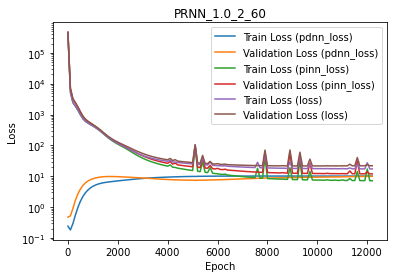

In [13]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

#### 4.5.4 Train PINN

In [14]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN(f"PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2,
                                    num_without_snapshots=225)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=110000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [15]:
pinn_trainer.train()

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
0:  |F(x)| = 230.188; step 0.52013
1:  |F(x)| = 85.7699; step 1
2:  |F(x)| = 70.1531; step 1
3:  |F(x)| = 47.8735; step 1
4:  |F(x)| = 36.5895; step 1
5:  |F(x)| = 9.00799; step 1
6:  |F(x)| = 5.60883; step 0.376707
7:  |F(x)| = 5.5232; step 0.0368869
8:  |F(x)| = 5.50161; step 0.01
9:  |F(x)| = 11.7914; step 1
10:  |F(x)| = 13.9515; step 1
11:  |F(x)| = 6.69339; step 1
12:  |F(x)| = 2.919; step 1
13:  |F(x)| = 1.95092; step 1
14:  |F(x)| = 1.80532; step 1
15:  |F(x)| = 1.20813; step 1
16:  |F(x)| = 0.28085; step 1
17:  |F(x)| = 0.241089; step 0.228341
18:  |F(x)| = 0.237702; step 0.0334672
19:  |F(x)| = 0.236744; step 0.01
20:  |F(x)| = 0.490879; step 1
21:  |F(x)| = 0.526813; step 1
22:  |F(x)| = 0.240061; step 1
23:  |F(x)| = 0.0867269; step 1
24:  |F(x)| = 0.0885357; step 1
25:  |F(x)| = 0.0844863; step 1
26:  |F(x)| = 0.0581582; step 1
27:  |F(x)| = 0.0117444; step 1
28:  |F(x)| = 0.0104048; s

16:  |F(x)| = 3.46079; step 1
17:  |F(x)| = 2.46233; step 1
18:  |F(x)| = 1.8038; step 1
19:  |F(x)| = 0.671191; step 1
20:  |F(x)| = 0.261391; step 1
21:  |F(x)| = 0.260996; step 0.0181281
22:  |F(x)| = 0.634119; step 1
23:  |F(x)| = 0.688877; step 1
24:  |F(x)| = 0.431692; step 1
25:  |F(x)| = 0.206642; step 1
26:  |F(x)| = 0.0761965; step 1
27:  |F(x)| = 0.0802957; step 1
28:  |F(x)| = 0.0498281; step 1
29:  |F(x)| = 0.0146336; step 1
30:  |F(x)| = 0.0108259; step 1
31:  |F(x)| = 0.0142174; step 1
32:  |F(x)| = 0.00866416; step 1
33:  |F(x)| = 0.00574457; step 1
34:  |F(x)| = 0.00325704; step 1
35:  |F(x)| = 0.00274891; step 1
36:  |F(x)| = 0.00300893; step 0.239744
37:  |F(x)| = 0.00310758; step 0.109595
38:  |F(x)| = 0.003154; step 0.0815571
39:  |F(x)| = 0.0031839; step 0.0819512
40:  |F(x)| = 0.00320408; step 0.108898
41:  |F(x)| = 0.00319946; step 0.20495
42:  |F(x)| = 0.00285252; step 1
43:  |F(x)| = 0.00143902; step 1
44:  |F(x)| = 0.000866743; step 1
45:  |F(x)| = 0.00034203

1:  |F(x)| = 0.723494; step 1
2:  |F(x)| = 0.29741; step 1
3:  |F(x)| = 0.256372; step 1
4:  |F(x)| = 0.054933; step 1
5:  |F(x)| = 0.0166704; step 1
6:  |F(x)| = 0.0131936; step 1
7:  |F(x)| = 0.00160722; step 1
8:  |F(x)| = 0.00199645; step 1
9:  |F(x)| = 0.000782768; step 1
10:  |F(x)| = 0.000118739; step 1
11:  |F(x)| = 0.000176947; step 1
12:  |F(x)| = 4.1038e-05; step 1
13:  |F(x)| = 1.64679e-05; step 1
14:  |F(x)| = 1.21508e-05; step 1
15:  |F(x)| = 1.28285e-06; step 1
scipy solver converged in 17 iterations.
0:  |F(x)| = 360.356; step 0.450705
1:  |F(x)| = 248.69; step 1
2:  |F(x)| = 125.835; step 1
3:  |F(x)| = 92.1233; step 1
4:  |F(x)| = 81.8799; step 1
5:  |F(x)| = 29.2212; step 1
6:  |F(x)| = 10.8514; step 0.498109
7:  |F(x)| = 8.58283; step 0.430214
8:  |F(x)| = 7.33835; step 0.194807
9:  |F(x)| = 6.83546; step 0.0817605
10:  |F(x)| = 6.801; step 0.0364869
11:  |F(x)| = 6.85192; step 0.0168792
12:  |F(x)| = 6.88085; step 0.01
13:  |F(x)| = 15.729; step 1
14:  |F(x)| = 15.

41:  |F(x)| = 4.50584e-05; step 0.477947
42:  |F(x)| = 3.75275e-05; step 1
43:  |F(x)| = 1.06985e-05; step 1
44:  |F(x)| = 5.45154e-06; step 1
scipy solver converged in 46 iterations.
0:  |F(x)| = 7.71263; step 1
1:  |F(x)| = 1.36259; step 1
2:  |F(x)| = 0.481308; step 1
3:  |F(x)| = 0.481563; step 1
4:  |F(x)| = 0.153628; step 1
5:  |F(x)| = 0.0193139; step 1
6:  |F(x)| = 0.0314383; step 1
7:  |F(x)| = 0.00716949; step 1
8:  |F(x)| = 0.00374293; step 1
9:  |F(x)| = 0.00277028; step 1
10:  |F(x)| = 0.000297907; step 1
11:  |F(x)| = 0.000491473; step 1
12:  |F(x)| = 0.000242927; step 1
13:  |F(x)| = 3.05624e-05; step 1
14:  |F(x)| = 2.39462e-05; step 0.485394
15:  |F(x)| = 3.23466e-05; step 1
16:  |F(x)| = 6.93395e-06; step 1
17:  |F(x)| = 3.92574e-06; step 1
scipy solver converged in 19 iterations.
0:  |F(x)| = 264.604; step 0.338521
1:  |F(x)| = 158.622; step 1
2:  |F(x)| = 57.0407; step 1
3:  |F(x)| = 45.296; step 1
4:  |F(x)| = 34.365; step 1
5:  |F(x)| = 8.09205; step 1
6:  |F(x)| 

22:  |F(x)| = 0.575021; step 0.145981
23:  |F(x)| = 0.578136; step 1
24:  |F(x)| = 0.319066; step 1
25:  |F(x)| = 0.121484; step 1
26:  |F(x)| = 0.070267; step 1
27:  |F(x)| = 0.0658106; step 1
28:  |F(x)| = 0.0515935; step 1
29:  |F(x)| = 0.0119912; step 1
30:  |F(x)| = 0.00897494; step 0.465304
31:  |F(x)| = 0.00733207; step 0.504037
32:  |F(x)| = 0.00811447; step 0.510391
33:  |F(x)| = 0.00911218; step 1
34:  |F(x)| = 0.00564848; step 1
35:  |F(x)| = 0.00105619; step 1
36:  |F(x)| = 0.00087623; step 0.260676
37:  |F(x)| = 0.000865635; step 0.0274913
38:  |F(x)| = 0.00266123; step 1
39:  |F(x)| = 0.00306264; step 1
40:  |F(x)| = 0.00221024; step 1
41:  |F(x)| = 0.0010923; step 1
42:  |F(x)| = 0.000471161; step 1
43:  |F(x)| = 0.000375622; step 1
44:  |F(x)| = 0.000213638; step 1
45:  |F(x)| = 7.23204e-05; step 1
46:  |F(x)| = 7.51881e-05; step 1
47:  |F(x)| = 0.000101533; step 1
48:  |F(x)| = 7.95345e-05; step 1
49:  |F(x)| = 4.01974e-05; step 1
50:  |F(x)| = 1.16098e-05; step 1
51: 

10:  |F(x)| = 8.81276; step 1
11:  |F(x)| = 3.79637; step 1
12:  |F(x)| = 1.45008; step 1
13:  |F(x)| = 1.60715; step 1
14:  |F(x)| = 1.30503; step 1
15:  |F(x)| = 0.561055; step 1
16:  |F(x)| = 0.190835; step 1
17:  |F(x)| = 0.406402; step 1
18:  |F(x)| = 0.339706; step 1
19:  |F(x)| = 0.119591; step 1
20:  |F(x)| = 0.0597933; step 1
21:  |F(x)| = 0.057507; step 0.387558
22:  |F(x)| = 0.0655886; step 0.502834
23:  |F(x)| = 0.064739; step 1
24:  |F(x)| = 0.0312296; step 1
25:  |F(x)| = 0.0092342; step 1
26:  |F(x)| = 0.00998361; step 0.500727
27:  |F(x)| = 0.0125072; step 1
28:  |F(x)| = 0.00845828; step 1
29:  |F(x)| = 0.00199261; step 1
30:  |F(x)| = 0.00133301; step 0.504742
31:  |F(x)| = 0.00114071; step 0.180245
32:  |F(x)| = 0.00113843; step 0.0831809
33:  |F(x)| = 0.00115633; step 0.0442745
34:  |F(x)| = 0.00116543; step 0.0255155
35:  |F(x)| = 0.00117051; step 0.01541
36:  |F(x)| = 0.00117366; step 0.01
37:  |F(x)| = 0.0011767; step 0.01
38:  |F(x)| = 0.00265922; step 1
39:  |F

44:  |F(x)| = 0.000422974; step 0.0123504
45:  |F(x)| = 0.000428573; step 0.01
46:  |F(x)| = 0.000434089; step 0.01
47:  |F(x)| = 0.000977528; step 1
48:  |F(x)| = 0.000710145; step 1
49:  |F(x)| = 0.000216218; step 1
50:  |F(x)| = 0.000133472; step 1
51:  |F(x)| = 0.000147592; step 0.424933
52:  |F(x)| = 0.000162776; step 1
53:  |F(x)| = 7.94365e-05; step 1
54:  |F(x)| = 2.2025e-05; step 1
55:  |F(x)| = 2.21692e-05; step 0.408869
56:  |F(x)| = 2.21258e-05; step 0.423738
57:  |F(x)| = 2.77462e-05; step 1
58:  |F(x)| = 1.41236e-05; step 1
59:  |F(x)| = 3.50049e-06; step 1
scipy solver converged in 61 iterations.
0:  |F(x)| = 0.0125064; step 1
1:  |F(x)| = 0.000270127; step 1
2:  |F(x)| = 6.64453e-05; step 1
3:  |F(x)| = 1.92247e-06; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 118.905; step 1
1:  |F(x)| = 27.8032; step 1
2:  |F(x)| = 17.2216; step 1
3:  |F(x)| = 4.26908; step 1
4:  |F(x)| = 6.06752; step 1
5:  |F(x)| = 6.4629; step 0.504472
6:  |F(x)| = 5.04445; step 1
7:

33:  |F(x)| = 0.00631276; step 1
34:  |F(x)| = 0.00138584; step 1
35:  |F(x)| = 0.00106077; step 0.263888
36:  |F(x)| = 0.00102374; step 0.0342994
37:  |F(x)| = 0.00310068; step 1
38:  |F(x)| = 0.00343679; step 1
39:  |F(x)| = 0.00257144; step 1
40:  |F(x)| = 0.00126091; step 1
41:  |F(x)| = 0.00061055; step 1
42:  |F(x)| = 0.000404502; step 1
43:  |F(x)| = 0.000265262; step 1
44:  |F(x)| = 8.37023e-05; step 1
45:  |F(x)| = 7.39027e-05; step 0.503067
46:  |F(x)| = 8.37644e-05; step 0.495892
47:  |F(x)| = 9.52511e-05; step 0.444101
48:  |F(x)| = 0.00010128; step 1
49:  |F(x)| = 7.38184e-05; step 1
50:  |F(x)| = 3.68939e-05; step 1
51:  |F(x)| = 1.21524e-05; step 1
52:  |F(x)| = 1.00103e-05; step 1
53:  |F(x)| = 9.455e-06; step 1
54:  |F(x)| = 6.71098e-06; step 1
55:  |F(x)| = 3.32491e-06; step 1
scipy solver converged in 57 iterations.
0:  |F(x)| = 276.354; step 0.487498
1:  |F(x)| = 145.692; step 1
2:  |F(x)| = 90.1872; step 1
3:  |F(x)| = 65.785; step 1
4:  |F(x)| = 54.2907; step 1
5:

29:  |F(x)| = 0.0177101; step 1
30:  |F(x)| = 0.0088624; step 1
31:  |F(x)| = 0.00238171; step 1
32:  |F(x)| = 0.00231907; step 0.495406
33:  |F(x)| = 0.00293721; step 1
34:  |F(x)| = 0.00170321; step 1
35:  |F(x)| = 0.000388975; step 1
36:  |F(x)| = 0.000298678; step 0.317183
37:  |F(x)| = 0.000262504; step 0.140729
38:  |F(x)| = 0.00026681; step 0.0820193
39:  |F(x)| = 0.000288259; step 0.0567099
40:  |F(x)| = 0.000303551; step 0.0442484
41:  |F(x)| = 0.000315749; step 0.0379708
42:  |F(x)| = 0.000326401; step 0.035379
43:  |F(x)| = 0.000336463; step 0.0355791
44:  |F(x)| = 0.000346707; step 0.038659
45:  |F(x)| = 0.000357947; step 0.0456575
46:  |F(x)| = 0.000371314; step 0.0594947
47:  |F(x)| = 0.000388714; step 0.0880066
48:  |F(x)| = 0.000413704; step 0.156339
49:  |F(x)| = 0.000450389; step 0.375319
50:  |F(x)| = 0.000420111; step 1
51:  |F(x)| = 0.000172919; step 1
52:  |F(x)| = 5.37775e-05; step 1
53:  |F(x)| = 5.55196e-05; step 0.274644
54:  |F(x)| = 6.00861e-05; step 0.32698

28:  |F(x)| = 0.0464179; step 1
29:  |F(x)| = 0.0105049; step 1
30:  |F(x)| = 0.00819579; step 0.457756
31:  |F(x)| = 0.00892189; step 0.498059
32:  |F(x)| = 0.0105297; step 1
33:  |F(x)| = 0.00785448; step 1
34:  |F(x)| = 0.0021933; step 1
35:  |F(x)| = 0.00100169; step 0.524439
36:  |F(x)| = 0.000937685; step 0.0717625
37:  |F(x)| = 0.000928922; step 0.01
38:  |F(x)| = 0.00280398; step 1
39:  |F(x)| = 0.00312149; step 1
40:  |F(x)| = 0.00214928; step 1
41:  |F(x)| = 0.000957012; step 1
42:  |F(x)| = 0.000460892; step 1
43:  |F(x)| = 0.000376046; step 1
44:  |F(x)| = 0.000198637; step 1
45:  |F(x)| = 5.12696e-05; step 1
46:  |F(x)| = 3.36763e-05; step 0.509581
47:  |F(x)| = 3.33813e-05; step 0.0519675
48:  |F(x)| = 8.68666e-05; step 1
49:  |F(x)| = 8.75565e-05; step 1
50:  |F(x)| = 5.3789e-05; step 1
51:  |F(x)| = 1.64982e-05; step 1
52:  |F(x)| = 1.11705e-05; step 1
53:  |F(x)| = 1.05096e-05; step 0.26627
54:  |F(x)| = 1.07227e-05; step 0.325272
55:  |F(x)| = 1.17943e-05; step 0.5199

27:  |F(x)| = 0.0118779; step 1
28:  |F(x)| = 0.0105817; step 0.383352
29:  |F(x)| = 0.0109679; step 0.428972
30:  |F(x)| = 0.0135542; step 1
31:  |F(x)| = 0.0114473; step 1
32:  |F(x)| = 0.00393814; step 1
33:  |F(x)| = 0.00171089; step 1
34:  |F(x)| = 0.00400871; step 1
35:  |F(x)| = 0.00333971; step 1
36:  |F(x)| = 0.00176322; step 1
37:  |F(x)| = 0.0005125; step 1
38:  |F(x)| = 0.000586497; step 1
39:  |F(x)| = 0.000498562; step 1
40:  |F(x)| = 0.00024104; step 1
41:  |F(x)| = 7.17216e-05; step 1
42:  |F(x)| = 6.14224e-05; step 0.343341
43:  |F(x)| = 6.32864e-05; step 0.14352
44:  |F(x)| = 6.3955e-05; step 0.0923037
45:  |F(x)| = 6.42415e-05; step 0.0734194
46:  |F(x)| = 6.45925e-05; step 0.0686317
47:  |F(x)| = 6.83651e-05; step 0.0742914
48:  |F(x)| = 7.2558e-05; step 0.0938375
49:  |F(x)| = 7.79055e-05; step 0.142959
50:  |F(x)| = 8.55983e-05; step 0.283764
51:  |F(x)| = 9.45546e-05; step 1
52:  |F(x)| = 5.44271e-05; step 1
53:  |F(x)| = 1.37888e-05; step 1
54:  |F(x)| = 1.02949

6:  |F(x)| = 0.00475875; step 1
7:  |F(x)| = 0.000542862; step 1
8:  |F(x)| = 0.000810572; step 1
9:  |F(x)| = 0.000158844; step 1
10:  |F(x)| = 8.07951e-05; step 1
11:  |F(x)| = 4.73577e-05; step 1
12:  |F(x)| = 4.45874e-06; step 1
scipy solver converged in 14 iterations.
0:  |F(x)| = 144.404; step 0.436094
1:  |F(x)| = 47.051; step 1
2:  |F(x)| = 29.9325; step 1
3:  |F(x)| = 16.5716; step 1
4:  |F(x)| = 9.64899; step 1
5:  |F(x)| = 3.73822; step 1
6:  |F(x)| = 3.84537; step 0.208125
7:  |F(x)| = 3.99887; step 0.0830419
8:  |F(x)| = 4.10457; step 0.0659635
9:  |F(x)| = 4.20361; step 0.0703682
10:  |F(x)| = 4.32185; step 0.0984358
11:  |F(x)| = 4.49906; step 0.193592
12:  |F(x)| = 4.82539; step 1
13:  |F(x)| = 2.98381; step 1
14:  |F(x)| = 0.766599; step 1
15:  |F(x)| = 0.806881; step 1
16:  |F(x)| = 0.822566; step 1
17:  |F(x)| = 0.338308; step 1
18:  |F(x)| = 0.101267; step 1
19:  |F(x)| = 0.107072; step 0.20053
20:  |F(x)| = 0.110624; step 0.157553
21:  |F(x)| = 0.126332; step 0.173

33:  |F(x)| = 0.00397574; step 1
34:  |F(x)| = 0.00106472; step 1
35:  |F(x)| = 0.00098968; step 0.147173
36:  |F(x)| = 0.0010175; step 0.0809686
37:  |F(x)| = 0.00103134; step 0.0517054
38:  |F(x)| = 0.00103944; step 0.0364147
39:  |F(x)| = 0.00104473; step 0.0274996
40:  |F(x)| = 0.00104847; step 0.0219011
41:  |F(x)| = 0.00105126; step 0.0181976
42:  |F(x)| = 0.00106026; step 0.0156644
43:  |F(x)| = 0.00107574; step 0.0139037
44:  |F(x)| = 0.00108956; step 0.0126789
45:  |F(x)| = 0.00110222; step 0.0118478
46:  |F(x)| = 0.00111411; step 0.0113381
47:  |F(x)| = 0.00112554; step 0.011085
48:  |F(x)| = 0.00113675; step 0.0110781
49:  |F(x)| = 0.00114801; step 0.0113158
50:  |F(x)| = 0.00115955; step 0.0118166
51:  |F(x)| = 0.00117164; step 0.0126256
52:  |F(x)| = 0.0011846; step 0.0138201
53:  |F(x)| = 0.00119884; step 0.0155506
54:  |F(x)| = 0.00121493; step 0.0180299
55:  |F(x)| = 0.00123366; step 0.0216625
56:  |F(x)| = 0.00125624; step 0.0271323
57:  |F(x)| = 0.00128459; step 0.035

4:  |F(x)| = 0.850207; step 1
5:  |F(x)| = 0.173524; step 1
6:  |F(x)| = 0.10319; step 1
7:  |F(x)| = 0.0806632; step 1
8:  |F(x)| = 0.0154832; step 1
9:  |F(x)| = 0.0168188; step 1
10:  |F(x)| = 0.0101913; step 1
11:  |F(x)| = 0.00156991; step 1
12:  |F(x)| = 0.00124242; step 0.436609
13:  |F(x)| = 0.0014374; step 0.373778
14:  |F(x)| = 0.00167426; step 1
15:  |F(x)| = 0.000507075; step 1
16:  |F(x)| = 0.000153304; step 1
17:  |F(x)| = 0.000190247; step 1
18:  |F(x)| = 4.68779e-05; step 1
19:  |F(x)| = 2.81327e-05; step 1
20:  |F(x)| = 2.60906e-05; step 1
21:  |F(x)| = 5.39656e-06; step 1
scipy solver converged in 23 iterations.
0:  |F(x)| = 40.9564; step 1
1:  |F(x)| = 9.73231; step 1
2:  |F(x)| = 3.16074; step 1
3:  |F(x)| = 1.82695; step 1
4:  |F(x)| = 2.34637; step 1
5:  |F(x)| = 1.04784; step 1
6:  |F(x)| = 0.206946; step 1
7:  |F(x)| = 0.163744; step 0.509044
8:  |F(x)| = 0.202814; step 1
9:  |F(x)| = 0.0603193; step 1
10:  |F(x)| = 0.0301492; step 1
11:  |F(x)| = 0.035762; step

4:  |F(x)| = 0.000576762; step 1
5:  |F(x)| = 0.000310122; step 1
6:  |F(x)| = 2.16598e-05; step 1
7:  |F(x)| = 2.42363e-05; step 1
8:  |F(x)| = 2.32206e-06; step 1
scipy solver converged in 10 iterations.
0:  |F(x)| = 139.572; step 1
1:  |F(x)| = 32.1985; step 1
2:  |F(x)| = 21.3406; step 1
3:  |F(x)| = 7.22885; step 1
4:  |F(x)| = 6.3106; step 1
5:  |F(x)| = 6.37817; step 0.0296035
6:  |F(x)| = 6.4914; step 0.0540239
7:  |F(x)| = 6.69956; step 0.118329
8:  |F(x)| = 7.0923; step 0.381711
9:  |F(x)| = 6.20135; step 1
10:  |F(x)| = 2.58639; step 1
11:  |F(x)| = 0.834235; step 1
12:  |F(x)| = 1.0594; step 1
13:  |F(x)| = 0.625128; step 1
14:  |F(x)| = 0.143759; step 1
15:  |F(x)| = 0.103321; step 0.375545
16:  |F(x)| = 0.106939; step 0.234688
17:  |F(x)| = 0.130107; step 0.242013
18:  |F(x)| = 0.15159; step 0.419051
19:  |F(x)| = 0.142377; step 1
20:  |F(x)| = 0.048918; step 1
21:  |F(x)| = 0.0208504; step 1
22:  |F(x)| = 0.0217478; step 0.0541283
23:  |F(x)| = 0.0227561; step 0.0678719


31:  |F(x)| = 0.0284513; step 0.49313
32:  |F(x)| = 0.0258112; step 1
33:  |F(x)| = 0.0111746; step 1
34:  |F(x)| = 0.00399634; step 1
35:  |F(x)| = 0.00418653; step 0.507459
36:  |F(x)| = 0.00481077; step 1
37:  |F(x)| = 0.00267035; step 1
38:  |F(x)| = 0.000639416; step 1
39:  |F(x)| = 0.000509757; step 0.274008
40:  |F(x)| = 0.00046047; step 0.113352
41:  |F(x)| = 0.000443873; step 0.0572772
42:  |F(x)| = 0.000449961; step 0.0322716
43:  |F(x)| = 0.000453315; step 0.0193645
44:  |F(x)| = 0.000455297; step 0.0120691
45:  |F(x)| = 0.000456884; step 0.01
46:  |F(x)| = 0.00113179; step 1
47:  |F(x)| = 0.000861615; step 1
48:  |F(x)| = 0.000295031; step 1
49:  |F(x)| = 0.000153579; step 1
50:  |F(x)| = 0.000151805; step 0.385232
51:  |F(x)| = 0.000195917; step 1
52:  |F(x)| = 0.000108224; step 1
53:  |F(x)| = 2.96901e-05; step 1
54:  |F(x)| = 2.44613e-05; step 0.47538
55:  |F(x)| = 2.52982e-05; step 0.383379
56:  |F(x)| = 3.36601e-05; step 1
57:  |F(x)| = 1.96583e-05; step 1
58:  |F(x)| 

13:  |F(x)| = 3.72234e-05; step 1
14:  |F(x)| = 2.27727e-05; step 0.492643
15:  |F(x)| = 3.82663e-05; step 1
16:  |F(x)| = 9.4361e-06; step 1
17:  |F(x)| = 4.27293e-06; step 1
scipy solver converged in 19 iterations.
0:  |F(x)| = 236.193; step 0.515564
1:  |F(x)| = 92.7959; step 1
2:  |F(x)| = 72.5261; step 1
3:  |F(x)| = 50.1046; step 1
4:  |F(x)| = 38.7587; step 1
5:  |F(x)| = 9.40326; step 1
6:  |F(x)| = 5.52722; step 0.39239
7:  |F(x)| = 5.42065; step 0.0492702
8:  |F(x)| = 5.39562; step 0.0128265
9:  |F(x)| = 11.9931; step 1
10:  |F(x)| = 14.2248; step 1
11:  |F(x)| = 6.95367; step 1
12:  |F(x)| = 3.02579; step 1
13:  |F(x)| = 1.90852; step 1
14:  |F(x)| = 1.81818; step 1
15:  |F(x)| = 1.23823; step 1
16:  |F(x)| = 0.284255; step 1
17:  |F(x)| = 0.239427; step 0.249275
18:  |F(x)| = 0.236627; step 0.0291791
19:  |F(x)| = 0.235712; step 0.01
20:  |F(x)| = 0.49599; step 1
21:  |F(x)| = 0.535603; step 1
22:  |F(x)| = 0.249502; step 1
23:  |F(x)| = 0.090933; step 1
24:  |F(x)| = 0.085

14:  |F(x)| = 0.0198639; step 1
15:  |F(x)| = 0.00579095; step 1
16:  |F(x)| = 0.00667022; step 0.166435
17:  |F(x)| = 0.00746159; step 0.226799
18:  |F(x)| = 0.00820418; step 0.510471
19:  |F(x)| = 0.0061954; step 1
20:  |F(x)| = 0.0015644; step 1
21:  |F(x)| = 0.000887653; step 1
22:  |F(x)| = 0.000956873; step 1
23:  |F(x)| = 0.000253122; step 1
24:  |F(x)| = 0.000182069; step 1
25:  |F(x)| = 0.00020726; step 1
26:  |F(x)| = 7.22696e-05; step 1
27:  |F(x)| = 2.32642e-05; step 1
28:  |F(x)| = 2.8028e-05; step 0.299988
29:  |F(x)| = 3.26397e-05; step 1
30:  |F(x)| = 1.1756e-05; step 1
31:  |F(x)| = 3.10626e-06; step 1
scipy solver converged in 33 iterations.
0:  |F(x)| = 16.2328; step 1
1:  |F(x)| = 3.4914; step 1
2:  |F(x)| = 0.944051; step 1
3:  |F(x)| = 1.10857; step 1
4:  |F(x)| = 0.613154; step 1
5:  |F(x)| = 0.0934877; step 1
6:  |F(x)| = 0.0876828; step 1
7:  |F(x)| = 0.052616; step 1
8:  |F(x)| = 0.00886301; step 1
9:  |F(x)| = 0.0126323; step 1
10:  |F(x)| = 0.00576738; step 

14:  |F(x)| = 7.24867e-06; step 1
15:  |F(x)| = 7.62684e-07; step 1
scipy solver converged in 17 iterations.
0:  |F(x)| = 223.641; step 0.366242
1:  |F(x)| = 114.375; step 1
2:  |F(x)| = 46.5811; step 1
3:  |F(x)| = 34.2024; step 1
4:  |F(x)| = 24.886; step 1
5:  |F(x)| = 6.25368; step 1
6:  |F(x)| = 4.03467; step 0.41508
7:  |F(x)| = 4.01511; step 0.0141836
8:  |F(x)| = 8.14454; step 1
9:  |F(x)| = 8.52755; step 1
10:  |F(x)| = 3.60378; step 1
11:  |F(x)| = 1.41743; step 1
12:  |F(x)| = 1.58428; step 1
13:  |F(x)| = 1.26063; step 1
14:  |F(x)| = 0.528344; step 1
15:  |F(x)| = 0.19624; step 1
16:  |F(x)| = 0.395851; step 1
17:  |F(x)| = 0.323441; step 1
18:  |F(x)| = 0.108813; step 1
19:  |F(x)| = 0.0587016; step 1
20:  |F(x)| = 0.0560438; step 0.377967
21:  |F(x)| = 0.07752; step 1
22:  |F(x)| = 0.0475154; step 1
23:  |F(x)| = 0.0146783; step 1
24:  |F(x)| = 0.0121225; step 1
25:  |F(x)| = 0.0146503; step 1
26:  |F(x)| = 0.00835664; step 1
27:  |F(x)| = 0.00201733; step 1
28:  |F(x)| 

33:  |F(x)| = 0.00147124; step 0.0370181
34:  |F(x)| = 0.00148186; step 0.0175504
35:  |F(x)| = 0.00148765; step 0.01
36:  |F(x)| = 0.00368478; step 1
37:  |F(x)| = 0.00319621; step 1
38:  |F(x)| = 0.00148826; step 1
39:  |F(x)| = 0.000480824; step 1
40:  |F(x)| = 0.000605836; step 1
41:  |F(x)| = 0.000569683; step 1
42:  |F(x)| = 0.000254349; step 1
43:  |F(x)| = 8.03011e-05; step 1
44:  |F(x)| = 8.72612e-05; step 0.308076
45:  |F(x)| = 8.80307e-05; step 0.294368
46:  |F(x)| = 0.000103168; step 0.46884
47:  |F(x)| = 0.000105348; step 1
48:  |F(x)| = 5.22757e-05; step 1
49:  |F(x)| = 1.38019e-05; step 1
50:  |F(x)| = 1.21577e-05; step 0.249979
51:  |F(x)| = 1.24629e-05; step 0.0954289
52:  |F(x)| = 1.25641e-05; step 0.0448177
53:  |F(x)| = 1.26076e-05; step 0.0235139
54:  |F(x)| = 1.26293e-05; step 0.0131138
55:  |F(x)| = 2.45478e-05; step 1
56:  |F(x)| = 2.01846e-05; step 1
57:  |F(x)| = 8.74391e-06; step 1
58:  |F(x)| = 3.44426e-06; step 1
scipy solver converged in 60 iterations.
0: 

1:  |F(x)| = 19.1525; step 1
2:  |F(x)| = 9.59675; step 1
3:  |F(x)| = 2.77274; step 1
4:  |F(x)| = 2.30882; step 0.349168
5:  |F(x)| = 2.15142; step 0.163174
6:  |F(x)| = 2.39257; step 0.116203
7:  |F(x)| = 2.57746; step 0.113532
8:  |F(x)| = 2.76485; step 0.151836
9:  |F(x)| = 2.99785; step 0.307863
10:  |F(x)| = 2.92467; step 1
11:  |F(x)| = 1.20973; step 1
12:  |F(x)| = 0.31178; step 1
13:  |F(x)| = 0.40193; step 1
14:  |F(x)| = 0.212854; step 1
15:  |F(x)| = 0.0490457; step 1
16:  |F(x)| = 0.0384801; step 0.389903
17:  |F(x)| = 0.051656; step 0.387836
18:  |F(x)| = 0.0577073; step 1
19:  |F(x)| = 0.0195934; step 1
20:  |F(x)| = 0.00863395; step 1
21:  |F(x)| = 0.00920221; step 0.106875
22:  |F(x)| = 0.00989433; step 0.172041
23:  |F(x)| = 0.0107631; step 0.401708
24:  |F(x)| = 0.00936154; step 1
25:  |F(x)| = 0.00310087; step 1
26:  |F(x)| = 0.00123164; step 1
27:  |F(x)| = 0.00150499; step 1
28:  |F(x)| = 0.00060516; step 1
29:  |F(x)| = 0.000175388; step 1
30:  |F(x)| = 0.000217

30:  |F(x)| = 0.00072986; step 0.203905
31:  |F(x)| = 0.000779891; step 0.126228
32:  |F(x)| = 0.00087292; step 0.102491
33:  |F(x)| = 0.000951264; step 0.104298
34:  |F(x)| = 0.0010321; step 0.133539
35:  |F(x)| = 0.00113123; step 0.227716
36:  |F(x)| = 0.00131138; step 1
37:  |F(x)| = 0.000612722; step 1
38:  |F(x)| = 0.000152544; step 1
39:  |F(x)| = 0.000136499; step 0.275098
40:  |F(x)| = 0.000139351; step 0.228719
41:  |F(x)| = 0.000166589; step 0.302373
42:  |F(x)| = 0.000204577; step 1
43:  |F(x)| = 9.70819e-05; step 1
44:  |F(x)| = 2.5605e-05; step 1
45:  |F(x)| = 2.46749e-05; step 0.4049
46:  |F(x)| = 2.7081e-05; step 0.493697
47:  |F(x)| = 2.78672e-05; step 1
48:  |F(x)| = 1.00632e-05; step 1
49:  |F(x)| = 4.03907e-06; step 1
scipy solver converged in 51 iterations.
0:  |F(x)| = 21.2433; step 1
1:  |F(x)| = 4.75224; step 1
2:  |F(x)| = 1.15903; step 1
3:  |F(x)| = 1.38688; step 1
4:  |F(x)| = 0.93679; step 1
5:  |F(x)| = 0.209147; step 1
6:  |F(x)| = 0.106807; step 1
7:  |F(

11:  |F(x)| = 5.41125; step 1
12:  |F(x)| = 1.66863; step 1
13:  |F(x)| = 1.07941; step 1
14:  |F(x)| = 1.22094; step 1
15:  |F(x)| = 0.7393; step 1
16:  |F(x)| = 0.214968; step 1
17:  |F(x)| = 0.122729; step 0.515729
18:  |F(x)| = 0.116712; step 0.203973
19:  |F(x)| = 0.120459; step 0.131948
20:  |F(x)| = 0.124572; step 0.11163
21:  |F(x)| = 0.137395; step 0.11864
22:  |F(x)| = 0.15122; step 0.160253
23:  |F(x)| = 0.168783; step 0.295095
24:  |F(x)| = 0.185418; step 1
25:  |F(x)| = 0.0942276; step 1
26:  |F(x)| = 0.0244374; step 1
27:  |F(x)| = 0.0213543; step 0.338936
28:  |F(x)| = 0.0220032; step 0.216713
29:  |F(x)| = 0.0219527; step 0.204703
30:  |F(x)| = 0.0253159; step 0.279811
31:  |F(x)| = 0.0317243; step 1
32:  |F(x)| = 0.0179978; step 1
33:  |F(x)| = 0.00529932; step 1
34:  |F(x)| = 0.00518784; step 1
35:  |F(x)| = 0.00555615; step 1
36:  |F(x)| = 0.00248142; step 1
37:  |F(x)| = 0.000664819; step 1
38:  |F(x)| = 0.000634797; step 0.110872
39:  |F(x)| = 0.000649642; step 0.0

32:  |F(x)| = 0.00258868; step 0.260538
33:  |F(x)| = 0.00283334; step 1
34:  |F(x)| = 0.00157635; step 1
35:  |F(x)| = 0.00042418; step 1
36:  |F(x)| = 0.000462543; step 1
37:  |F(x)| = 0.000531352; step 1
38:  |F(x)| = 0.000281992; step 1
39:  |F(x)| = 7.65974e-05; step 1
40:  |F(x)| = 6.92202e-05; step 0.427279
41:  |F(x)| = 7.17084e-05; step 0.321247
42:  |F(x)| = 7.78993e-05; step 0.427114
43:  |F(x)| = 8.81756e-05; step 1
44:  |F(x)| = 4.61806e-05; step 1
45:  |F(x)| = 1.18347e-05; step 1
46:  |F(x)| = 9.46476e-06; step 0.293769
47:  |F(x)| = 9.7964e-06; step 0.106895
48:  |F(x)| = 9.90485e-06; step 0.0493978
49:  |F(x)| = 9.95198e-06; step 0.0259647
50:  |F(x)| = 9.97579e-06; step 0.0146498
51:  |F(x)| = 9.99099e-06; step 0.01
52:  |F(x)| = 1.97823e-05; step 1
53:  |F(x)| = 1.58282e-05; step 1
54:  |F(x)| = 6.3299e-06; step 1
55:  |F(x)| = 2.78592e-06; step 1
scipy solver converged in 57 iterations.
0:  |F(x)| = 144.373; step 0.436128
1:  |F(x)| = 47.0315; step 1
2:  |F(x)| = 29

26:  |F(x)| = 0.0496365; step 1
27:  |F(x)| = 0.0197735; step 1
28:  |F(x)| = 0.0199657; step 0.173463
29:  |F(x)| = 0.0215858; step 0.197652
30:  |F(x)| = 0.0249144; step 0.322345
31:  |F(x)| = 0.0279072; step 1
32:  |F(x)| = 0.0144303; step 1
33:  |F(x)| = 0.00405253; step 1
34:  |F(x)| = 0.00387591; step 0.523443
35:  |F(x)| = 0.00486738; step 1
36:  |F(x)| = 0.0031418; step 1
37:  |F(x)| = 0.000718912; step 1
38:  |F(x)| = 0.000510551; step 0.424323
39:  |F(x)| = 0.000442833; step 0.161213
40:  |F(x)| = 0.000415925; step 0.0803741
41:  |F(x)| = 0.000424039; step 0.046722
42:  |F(x)| = 0.000428588; step 0.029791
43:  |F(x)| = 0.00043984; step 0.0201655
44:  |F(x)| = 0.000448434; step 0.0142178
45:  |F(x)| = 0.000454544; step 0.0103211
46:  |F(x)| = 0.000460375; step 0.01
47:  |F(x)| = 0.00103479; step 1
48:  |F(x)| = 0.000752899; step 1
49:  |F(x)| = 0.000230709; step 1
50:  |F(x)| = 0.000141597; step 1
51:  |F(x)| = 0.000155497; step 0.423259
52:  |F(x)| = 0.000172881; step 1
53:  

12:  |F(x)| = 1.83003e-06; step 1
scipy solver converged in 14 iterations.
0:  |F(x)| = 17.8081; step 1
1:  |F(x)| = 3.88595; step 1
2:  |F(x)| = 1.01488; step 1
3:  |F(x)| = 1.20309; step 1
4:  |F(x)| = 0.711552; step 1
5:  |F(x)| = 0.121022; step 1
6:  |F(x)| = 0.0951321; step 1
7:  |F(x)| = 0.0640188; step 1
8:  |F(x)| = 0.0111897; step 1
9:  |F(x)| = 0.0144804; step 1
10:  |F(x)| = 0.00750386; step 1
11:  |F(x)| = 0.0012758; step 1
12:  |F(x)| = 0.00105929; step 0.388316
13:  |F(x)| = 0.00137036; step 0.460747
14:  |F(x)| = 0.00121742; step 1
15:  |F(x)| = 0.000276437; step 1
16:  |F(x)| = 0.000152747; step 1
17:  |F(x)| = 0.000131625; step 1
18:  |F(x)| = 2.11814e-05; step 1
19:  |F(x)| = 2.44624e-05; step 1
20:  |F(x)| = 1.67458e-05; step 1
21:  |F(x)| = 2.35139e-06; step 1
scipy solver converged in 23 iterations.
0:  |F(x)| = 79.3143; step 0.525944
1:  |F(x)| = 14.0793; step 1
2:  |F(x)| = 17.4711; step 1
3:  |F(x)| = 6.57905; step 1
4:  |F(x)| = 2.19211; step 1
5:  |F(x)| = 1.4

13:  |F(x)| = 1.66158e-05; step 1
14:  |F(x)| = 1.24735e-05; step 1
15:  |F(x)| = 1.31698e-06; step 1
scipy solver converged in 17 iterations.
0:  |F(x)| = 208.211; step 0.53777
1:  |F(x)| = 62.0535; step 1
2:  |F(x)| = 61.9539; step 1
3:  |F(x)| = 40.007; step 1
4:  |F(x)| = 29.0164; step 1
5:  |F(x)| = 7.7105; step 1
6:  |F(x)| = 5.80381; step 0.299789
7:  |F(x)| = 5.76728; step 0.0130863
8:  |F(x)| = 11.065; step 1
9:  |F(x)| = 12.808; step 1
10:  |F(x)| = 5.71071; step 1
11:  |F(x)| = 2.48247; step 1
12:  |F(x)| = 2.0518; step 1
13:  |F(x)| = 1.73729; step 1
14:  |F(x)| = 1.05622; step 1
15:  |F(x)| = 0.263502; step 1
16:  |F(x)| = 0.244179; step 0.133585
17:  |F(x)| = 0.240142; step 0.0358094
18:  |F(x)| = 0.238861; step 0.0120058
19:  |F(x)| = 0.475333; step 1
20:  |F(x)| = 0.494184; step 1
21:  |F(x)| = 0.207408; step 1
22:  |F(x)| = 0.0772469; step 1
23:  |F(x)| = 0.0981366; step 1
24:  |F(x)| = 0.0855612; step 1
25:  |F(x)| = 0.0522859; step 1
26:  |F(x)| = 0.011575; step 1
27

6:  |F(x)| = 0.000371228; step 1
7:  |F(x)| = 0.000199627; step 1
8:  |F(x)| = 7.76768e-05; step 1
9:  |F(x)| = 8.0177e-06; step 1
10:  |F(x)| = 9.97734e-06; step 1
11:  |F(x)| = 1.19718e-06; step 1
scipy solver converged in 13 iterations.
0:  |F(x)| = 10.9459; step 1
1:  |F(x)| = 2.19119; step 1
2:  |F(x)| = 0.681387; step 1
3:  |F(x)| = 0.748971; step 1
4:  |F(x)| = 0.314539; step 1
5:  |F(x)| = 0.042741; step 1
6:  |F(x)| = 0.0256204; step 0.526034
7:  |F(x)| = 0.0374461; step 1
8:  |F(x)| = 0.00780118; step 1
9:  |F(x)| = 0.00529267; step 1
10:  |F(x)| = 0.00383031; step 1
11:  |F(x)| = 0.000473223; step 1
12:  |F(x)| = 0.000377109; step 0.524301
13:  |F(x)| = 0.0004039; step 0.453675
14:  |F(x)| = 0.000414718; step 1
15:  |F(x)| = 9.76759e-05; step 1
16:  |F(x)| = 4.47742e-05; step 1
17:  |F(x)| = 3.77449e-05; step 1
18:  |F(x)| = 5.21336e-06; step 1
scipy solver converged in 20 iterations.
0:  |F(x)| = 1.5271e-05; step 1
1:  |F(x)| = 6.16686e-07; step 1
scipy solver converged in 

11:  |F(x)| = 14.6291; step 1
12:  |F(x)| = 7.39756; step 1
13:  |F(x)| = 3.18035; step 1
14:  |F(x)| = 1.95841; step 1
15:  |F(x)| = 1.88942; step 1
16:  |F(x)| = 1.26186; step 1
17:  |F(x)| = 0.286503; step 1
18:  |F(x)| = 0.23615; step 0.276914
19:  |F(x)| = 0.234814; step 0.0157964
20:  |F(x)| = 0.506083; step 1
21:  |F(x)| = 0.555523; step 1
22:  |F(x)| = 0.270721; step 1
23:  |F(x)| = 0.100798; step 1
24:  |F(x)| = 0.0773983; step 1
25:  |F(x)| = 0.0815784; step 1
26:  |F(x)| = 0.0618392; step 1
27:  |F(x)| = 0.0119311; step 1
28:  |F(x)| = 0.010588; step 0.388899
29:  |F(x)| = 0.010855; step 0.436484
30:  |F(x)| = 0.0134033; step 1
31:  |F(x)| = 0.0113491; step 1
32:  |F(x)| = 0.00393876; step 1
33:  |F(x)| = 0.00166528; step 1
34:  |F(x)| = 0.00398279; step 1
35:  |F(x)| = 0.00334394; step 1
36:  |F(x)| = 0.00178368; step 1
37:  |F(x)| = 0.000528366; step 1
38:  |F(x)| = 0.000583857; step 1
39:  |F(x)| = 0.000487028; step 1
40:  |F(x)| = 0.000238827; step 1
41:  |F(x)| = 7.0026

39:  |F(x)| = 3.32363e-05; step 1
40:  |F(x)| = 1.21485e-05; step 1
41:  |F(x)| = 4.56624e-06; step 1
scipy solver converged in 43 iterations.
0:  |F(x)| = 174.631; step 0.406277
1:  |F(x)| = 69.2998; step 1
2:  |F(x)| = 35.8732; step 1
3:  |F(x)| = 22.668; step 1
4:  |F(x)| = 14.9173; step 1
5:  |F(x)| = 4.5696; step 1
6:  |F(x)| = 3.68601; step 0.295424
7:  |F(x)| = 3.64342; step 0.0254351
8:  |F(x)| = 3.666; step 0.01
9:  |F(x)| = 6.4657; step 1
10:  |F(x)| = 5.93364; step 1
11:  |F(x)| = 1.96871; step 1
12:  |F(x)| = 1.1385; step 1
13:  |F(x)| = 1.29568; step 1
14:  |F(x)| = 0.829189; step 1
15:  |F(x)| = 0.247754; step 1
16:  |F(x)| = 0.236589; step 1
17:  |F(x)| = 0.259882; step 0.384576
18:  |F(x)| = 0.253224; step 1
19:  |F(x)| = 0.122757; step 1
20:  |F(x)| = 0.0320989; step 1
21:  |F(x)| = 0.031733; step 0.276824
22:  |F(x)| = 0.0325588; step 0.209831
23:  |F(x)| = 0.0330948; step 0.226977
24:  |F(x)| = 0.0392007; step 0.361182
25:  |F(x)| = 0.0433729; step 1
26:  |F(x)| = 0.

43:  |F(x)| = 0.000363013; step 1
44:  |F(x)| = 0.000101736; step 1
45:  |F(x)| = 9.58002e-05; step 1
46:  |F(x)| = 0.000124893; step 1
47:  |F(x)| = 7.32655e-05; step 1
48:  |F(x)| = 1.80028e-05; step 1
49:  |F(x)| = 1.27845e-05; step 0.436895
50:  |F(x)| = 1.33146e-05; step 0.167663
51:  |F(x)| = 1.35358e-05; step 0.0895417
52:  |F(x)| = 1.363e-05; step 0.0590582
53:  |F(x)| = 1.36779e-05; step 0.0448871
54:  |F(x)| = 1.37041e-05; step 0.0379762
55:  |F(x)| = 1.37175e-05; step 0.0351401
56:  |F(x)| = 1.37214e-05; step 0.035269
57:  |F(x)| = 1.37156e-05; step 0.0383443
58:  |F(x)| = 1.38666e-05; step 0.0453585
59:  |F(x)| = 1.44657e-05; step 0.0590574
60:  |F(x)| = 1.52569e-05; step 0.0865648
61:  |F(x)| = 1.64062e-05; step 0.148663
62:  |F(x)| = 1.8163e-05; step 0.32123
63:  |F(x)| = 1.93115e-05; step 1
64:  |F(x)| = 1.05927e-05; step 1
65:  |F(x)| = 3.05883e-06; step 1
scipy solver converged in 67 iterations.
0:  |F(x)| = 325.644; step 0.463444
1:  |F(x)| = 207.728; step 1
2:  |F(x)

14:  |F(x)| = 2.3393; step 1
15:  |F(x)| = 1.95708; step 1
16:  |F(x)| = 1.70919; step 1
17:  |F(x)| = 0.866882; step 1
18:  |F(x)| = 0.196112; step 1
19:  |F(x)| = 0.532524; step 1
20:  |F(x)| = 0.531783; step 1
21:  |F(x)| = 0.261101; step 1
22:  |F(x)| = 0.0804519; step 1
23:  |F(x)| = 0.0900555; step 1
24:  |F(x)| = 0.0941366; step 1
25:  |F(x)| = 0.0552914; step 1
26:  |F(x)| = 0.0146828; step 1
27:  |F(x)| = 0.0134417; step 0.508133
28:  |F(x)| = 0.0170868; step 1
29:  |F(x)| = 0.0138882; step 1
30:  |F(x)| = 0.00466509; step 1
31:  |F(x)| = 0.00231705; step 1
32:  |F(x)| = 0.00487271; step 1
33:  |F(x)| = 0.00387121; step 1
34:  |F(x)| = 0.00172205; step 1
35:  |F(x)| = 0.0006542; step 1
36:  |F(x)| = 0.000725567; step 1
37:  |F(x)| = 0.00065943; step 1
38:  |F(x)| = 0.000273011; step 1
39:  |F(x)| = 0.000100905; step 1
40:  |F(x)| = 0.000106068; step 0.261364
41:  |F(x)| = 0.000106463; step 0.248592
42:  |F(x)| = 0.000124581; step 0.374227
43:  |F(x)| = 0.000140133; step 1
44: 

36:  |F(x)| = 0.000282016; step 0.219931
37:  |F(x)| = 0.000254134; step 0.1112
38:  |F(x)| = 0.000278438; step 0.0703977
39:  |F(x)| = 0.000297215; step 0.0517052
40:  |F(x)| = 0.000311382; step 0.0424278
41:  |F(x)| = 0.000323244; step 0.0381569
42:  |F(x)| = 0.000334083; step 0.0372673
43:  |F(x)| = 0.000344813; step 0.0394634
44:  |F(x)| = 0.0003563; step 0.0455102
45:  |F(x)| = 0.000369655; step 0.0578999
46:  |F(x)| = 0.000386665; step 0.0833576
47:  |F(x)| = 0.000410618; step 0.142896
48:  |F(x)| = 0.0004462; step 0.324356
49:  |F(x)| = 0.000441295; step 1
50:  |F(x)| = 0.000192773; step 1
51:  |F(x)| = 5.21017e-05; step 1
52:  |F(x)| = 5.51234e-05; step 0.286377
53:  |F(x)| = 5.62044e-05; step 0.294259
54:  |F(x)| = 6.85371e-05; step 0.509916
55:  |F(x)| = 6.17489e-05; step 1
56:  |F(x)| = 2.31966e-05; step 1
57:  |F(x)| = 9.60852e-06; step 1
58:  |F(x)| = 9.69636e-06; step 0.450726
59:  |F(x)| = 1.17657e-05; step 1
60:  |F(x)| = 5.28987e-06; step 1
scipy solver converged in 62

scipy solver converged in 5 iterations.
0:  |F(x)| = 171.352; step 1
1:  |F(x)| = 38.7696; step 1
2:  |F(x)| = 27.5777; step 1
3:  |F(x)| = 12.4331; step 1
4:  |F(x)| = 6.15569; step 1
5:  |F(x)| = 10.2838; step 1
6:  |F(x)| = 7.62316; step 1
7:  |F(x)| = 2.1082; step 1
8:  |F(x)| = 1.48452; step 1
9:  |F(x)| = 1.57725; step 1
10:  |F(x)| = 0.650557; step 1
11:  |F(x)| = 0.180781; step 1
12:  |F(x)| = 0.186596; step 0.210924
13:  |F(x)| = 0.2246; step 0.207433
14:  |F(x)| = 0.261104; step 0.319672
15:  |F(x)| = 0.287886; step 1
16:  |F(x)| = 0.124239; step 1
17:  |F(x)| = 0.0313761; step 1
18:  |F(x)| = 0.0295289; step 0.143735
19:  |F(x)| = 0.0308541; step 0.106724
20:  |F(x)| = 0.0341489; step 0.0990407
21:  |F(x)| = 0.0372795; step 0.113162
22:  |F(x)| = 0.0408404; step 0.16341
23:  |F(x)| = 0.0454321; step 0.324749
24:  |F(x)| = 0.0466154; step 1
25:  |F(x)| = 0.0204434; step 1
26:  |F(x)| = 0.00598308; step 1
27:  |F(x)| = 0.00633766; step 0.475495
28:  |F(x)| = 0.00755971; step 1

50:  |F(x)| = 0.000112384; step 1
51:  |F(x)| = 5.0838e-05; step 1
52:  |F(x)| = 1.46146e-05; step 1
53:  |F(x)| = 1.60236e-05; step 0.395369
54:  |F(x)| = 1.69163e-05; step 0.475068
55:  |F(x)| = 1.80974e-05; step 1
56:  |F(x)| = 7.74936e-06; step 1
57:  |F(x)| = 2.04304e-06; step 1
scipy solver converged in 59 iterations.
0:  |F(x)| = 45.1884; step 1
1:  |F(x)| = 10.7863; step 1
2:  |F(x)| = 3.68407; step 1
3:  |F(x)| = 1.78986; step 1
4:  |F(x)| = 2.2326; step 0.49864
5:  |F(x)| = 1.9641; step 1
6:  |F(x)| = 0.664649; step 1
7:  |F(x)| = 0.185539; step 1
8:  |F(x)| = 0.24262; step 1
9:  |F(x)| = 0.0863832; step 1
10:  |F(x)| = 0.028851; step 1
11:  |F(x)| = 0.0443042; step 1
12:  |F(x)| = 0.0162623; step 1
13:  |F(x)| = 0.0051656; step 1
14:  |F(x)| = 0.0060807; step 0.253187
15:  |F(x)| = 0.00681672; step 0.497931
16:  |F(x)| = 0.00524188; step 1
17:  |F(x)| = 0.00122953; step 1
18:  |F(x)| = 0.000770075; step 1
19:  |F(x)| = 0.000766237; step 1
20:  |F(x)| = 0.000176858; step 1
21

29:  |F(x)| = 0.0138503; step 1
30:  |F(x)| = 0.00462236; step 1
31:  |F(x)| = 0.00232887; step 1
32:  |F(x)| = 0.00485821; step 1
33:  |F(x)| = 0.00384158; step 1
34:  |F(x)| = 0.00169497; step 1
35:  |F(x)| = 0.000653568; step 1
36:  |F(x)| = 0.000731294; step 1
37:  |F(x)| = 0.000658365; step 1
38:  |F(x)| = 0.000269708; step 1
39:  |F(x)| = 0.000102337; step 1
40:  |F(x)| = 0.00010715; step 0.263397
41:  |F(x)| = 0.000107203; step 0.258633
42:  |F(x)| = 0.000127593; step 0.407625
43:  |F(x)| = 0.000137092; step 1
44:  |F(x)| = 7.29933e-05; step 1
45:  |F(x)| = 1.87994e-05; step 1
46:  |F(x)| = 1.51093e-05; step 0.357605
47:  |F(x)| = 1.56113e-05; step 0.134277
48:  |F(x)| = 1.57532e-05; step 0.065723
49:  |F(x)| = 1.58086e-05; step 0.0375231
50:  |F(x)| = 1.58347e-05; step 0.0234818
51:  |F(x)| = 1.58486e-05; step 0.0155821
52:  |F(x)| = 1.58566e-05; step 0.01075
53:  |F(x)| = 2.93471e-05; step 1
54:  |F(x)| = 2.37777e-05; step 1
55:  |F(x)| = 1.04537e-05; step 1
56:  |F(x)| = 4.18

5:  |F(x)| = 0.00243806; step 1
6:  |F(x)| = 0.000371228; step 1
7:  |F(x)| = 0.000199627; step 1
8:  |F(x)| = 7.76769e-05; step 1
9:  |F(x)| = 8.01771e-06; step 1
10:  |F(x)| = 9.97735e-06; step 1
11:  |F(x)| = 1.19719e-06; step 1
scipy solver converged in 13 iterations.
0:  |F(x)| = 10.9459; step 1
1:  |F(x)| = 2.19119; step 1
2:  |F(x)| = 0.681388; step 1
3:  |F(x)| = 0.748971; step 1
4:  |F(x)| = 0.31454; step 1
5:  |F(x)| = 0.042741; step 1
6:  |F(x)| = 0.0256204; step 0.526034
7:  |F(x)| = 0.0374462; step 1
8:  |F(x)| = 0.0078012; step 1
9:  |F(x)| = 0.00529267; step 1
10:  |F(x)| = 0.00383032; step 1
11:  |F(x)| = 0.000473224; step 1
12:  |F(x)| = 0.00037711; step 0.524301
13:  |F(x)| = 0.000403901; step 0.453675
14:  |F(x)| = 0.000414718; step 1
15:  |F(x)| = 9.7676e-05; step 1
16:  |F(x)| = 4.47742e-05; step 1
17:  |F(x)| = 3.7745e-05; step 1
18:  |F(x)| = 5.21337e-06; step 1
scipy solver converged in 20 iterations.
0:  |F(x)| = 1.5271e-05; step 1
1:  |F(x)| = 6.16683e-07; ste

43:  |F(x)| = 0.00037154; step 1
44:  |F(x)| = 8.17744e-05; step 1
45:  |F(x)| = 8.20236e-05; step 0.231173
46:  |F(x)| = 8.12795e-05; step 0.0849818
47:  |F(x)| = 8.09545e-05; step 0.0307218
48:  |F(x)| = 8.08274e-05; step 0.0114503
49:  |F(x)| = 0.000121065; step 1
50:  |F(x)| = 0.000100119; step 1
51:  |F(x)| = 0.000100071; step 0.165491
52:  |F(x)| = 9.45769e-05; step 0.512004
53:  |F(x)| = 6.07945e-05; step 1
54:  |F(x)| = 2.35371e-05; step 1
55:  |F(x)| = 1.21771e-05; step 1
56:  |F(x)| = 8.99974e-06; step 1
57:  |F(x)| = 8.35177e-06; step 1
58:  |F(x)| = 5.26383e-06; step 1
scipy solver converged in 60 iterations.
0:  |F(x)| = 291.429; step 0.32253
1:  |F(x)| = 190.693; step 1
2:  |F(x)| = 64.8822; step 1
3:  |F(x)| = 53.1965; step 1
4:  |F(x)| = 41.0494; step 1
5:  |F(x)| = 9.54291; step 1
6:  |F(x)| = 5.17566; step 0.495398
7:  |F(x)| = 4.78542; step 0.120485
8:  |F(x)| = 4.66253; step 0.0367388
9:  |F(x)| = 4.62272; step 0.0118596
10:  |F(x)| = 10.658; step 1
11:  |F(x)| = 11

10:  |F(x)| = 0.0109663; step 1
11:  |F(x)| = 0.00164952; step 1
12:  |F(x)| = 0.00130298; step 0.452681
13:  |F(x)| = 0.0014583; step 0.363153
14:  |F(x)| = 0.00178459; step 1
15:  |F(x)| = 0.000563912; step 1
16:  |F(x)| = 0.000152665; step 1
17:  |F(x)| = 0.0002047; step 1
18:  |F(x)| = 5.38261e-05; step 1
19:  |F(x)| = 2.89188e-05; step 1
20:  |F(x)| = 2.85256e-05; step 1
21:  |F(x)| = 6.42811e-06; step 1
22:  |F(x)| = 4.31342e-06; step 1
scipy solver converged in 24 iterations.
0:  |F(x)| = 325.511; step 0.463495
1:  |F(x)| = 207.575; step 1
2:  |F(x)| = 111.275; step 1
3:  |F(x)| = 82.174; step 1
4:  |F(x)| = 71.1872; step 1
5:  |F(x)| = 22.0756; step 1
6:  |F(x)| = 9.51382; step 0.488643
7:  |F(x)| = 7.91264; step 0.336366
8:  |F(x)| = 7.09372; step 0.14546
9:  |F(x)| = 6.75165; step 0.0613486
10:  |F(x)| = 6.60348; step 0.0268481
11:  |F(x)| = 6.53755; step 0.0120107
12:  |F(x)| = 6.4828; step 0.01
13:  |F(x)| = 14.9819; step 1
14:  |F(x)| = 15.2599; step 1
15:  |F(x)| = 8.5822

13:  |F(x)| = 0.936727; step 1
14:  |F(x)| = 0.291046; step 1
15:  |F(x)| = 0.230608; step 1
16:  |F(x)| = 0.244936; step 0.154818
17:  |F(x)| = 0.268592; step 0.384146
18:  |F(x)| = 0.2614; step 1
19:  |F(x)| = 0.127742; step 1
20:  |F(x)| = 0.0335774; step 1
21:  |F(x)| = 0.0331156; step 0.297606
22:  |F(x)| = 0.0339157; step 0.225891
23:  |F(x)| = 0.0346284; step 0.249888
24:  |F(x)| = 0.0412452; step 0.418108
25:  |F(x)| = 0.0425647; step 1
26:  |F(x)| = 0.0212026; step 1
27:  |F(x)| = 0.00603072; step 1
28:  |F(x)| = 0.00626215; step 0.498857
29:  |F(x)| = 0.00792297; step 1
30:  |F(x)| = 0.00528084; step 1
31:  |F(x)| = 0.00124161; step 1
32:  |F(x)| = 0.000840615; step 0.474154
33:  |F(x)| = 0.000721655; step 0.175186
34:  |F(x)| = 0.000709042; step 0.0849906
35:  |F(x)| = 0.000721565; step 0.0480917
36:  |F(x)| = 0.00072832; step 0.0297947
37:  |F(x)| = 0.000732361; step 0.0195475
38:  |F(x)| = 0.000734945; step 0.0133198
39:  |F(x)| = 0.0007368; step 0.01
40:  |F(x)| = 0.00073

14:  |F(x)| = 0.554991; step 1
15:  |F(x)| = 0.295121; step 1
16:  |F(x)| = 0.0705415; step 1
17:  |F(x)| = 0.0559204; step 0.270864
18:  |F(x)| = 0.0562747; step 0.169846
19:  |F(x)| = 0.0659084; step 0.150733
20:  |F(x)| = 0.0747147; step 0.184151
21:  |F(x)| = 0.0847476; step 0.328665
22:  |F(x)| = 0.0892458; step 1
23:  |F(x)| = 0.0387442; step 1
24:  |F(x)| = 0.00989159; step 1
25:  |F(x)| = 0.00966035; step 0.155257
26:  |F(x)| = 0.00985328; step 0.118596
27:  |F(x)| = 0.0108995; step 0.115379
28:  |F(x)| = 0.0120554; step 0.142094
29:  |F(x)| = 0.0134309; step 0.232053
30:  |F(x)| = 0.0161921; step 1
31:  |F(x)| = 0.00818634; step 1
32:  |F(x)| = 0.0021618; step 1
33:  |F(x)| = 0.0020447; step 0.492225
34:  |F(x)| = 0.00263317; step 1
35:  |F(x)| = 0.00150616; step 1
36:  |F(x)| = 0.000343142; step 1
37:  |F(x)| = 0.000264838; step 0.306643
38:  |F(x)| = 0.000232294; step 0.141526
39:  |F(x)| = 0.000248097; step 0.0865713
40:  |F(x)| = 0.000268634; step 0.0636437
41:  |F(x)| = 0

20:  |F(x)| = 0.0104679; step 1
21:  |F(x)| = 0.0042052; step 1
22:  |F(x)| = 0.00108219; step 1
23:  |F(x)| = 0.00108098; step 0.522357
24:  |F(x)| = 0.0011732; step 1
25:  |F(x)| = 0.000324927; step 1
26:  |F(x)| = 0.000228084; step 1
27:  |F(x)| = 0.00027811; step 1
28:  |F(x)| = 0.000109189; step 1
29:  |F(x)| = 2.51467e-05; step 1
30:  |F(x)| = 3.05272e-05; step 0.217382
31:  |F(x)| = 3.59511e-05; step 0.296487
32:  |F(x)| = 4.10244e-05; step 1
33:  |F(x)| = 1.54342e-05; step 1
34:  |F(x)| = 4.22718e-06; step 1
scipy solver converged in 36 iterations.
0:  |F(x)| = 11.7369; step 1
1:  |F(x)| = 2.38242; step 1
2:  |F(x)| = 0.723354; step 1
3:  |F(x)| = 0.806492; step 1
4:  |F(x)| = 0.355464; step 1
5:  |F(x)| = 0.0488729; step 1
6:  |F(x)| = 0.0609221; step 1
7:  |F(x)| = 0.0250248; step 1
8:  |F(x)| = 0.00439165; step 1
9:  |F(x)| = 0.00722997; step 1
10:  |F(x)| = 0.00204383; step 1
11:  |F(x)| = 0.000857491; step 1
12:  |F(x)| = 0.00087012; step 1
13:  |F(x)| = 0.000197112; step 

62:  |F(x)| = 2.75373e-05; step 0.472035
63:  |F(x)| = 3.0666e-05; step 1
64:  |F(x)| = 1.46104e-05; step 1
65:  |F(x)| = 3.75884e-06; step 1
scipy solver converged in 67 iterations.
0:  |F(x)| = 55.2727; step 1
1:  |F(x)| = 13.2644; step 1
2:  |F(x)| = 5.07904; step 1
3:  |F(x)| = 2.06766; step 1
4:  |F(x)| = 2.11801; step 0.315123
5:  |F(x)| = 2.47478; step 0.444294
6:  |F(x)| = 2.2163; step 1
7:  |F(x)| = 0.790422; step 1
8:  |F(x)| = 0.223706; step 1
9:  |F(x)| = 0.287356; step 1
10:  |F(x)| = 0.11557; step 1
11:  |F(x)| = 0.0287491; step 1
12:  |F(x)| = 0.0398903; step 0.426846
13:  |F(x)| = 0.0425323; step 1
14:  |F(x)| = 0.0122803; step 1
15:  |F(x)| = 0.00734803; step 1
16:  |F(x)| = 0.00817903; step 0.421353
17:  |F(x)| = 0.0070081; step 1
18:  |F(x)| = 0.00204253; step 1
19:  |F(x)| = 0.00082263; step 1
20:  |F(x)| = 0.00106527; step 1
21:  |F(x)| = 0.000337054; step 1
22:  |F(x)| = 0.00016507; step 1
23:  |F(x)| = 0.000192197; step 0.472339
24:  |F(x)| = 0.000158328; step 1


26:  |F(x)| = 0.000281562; step 1
27:  |F(x)| = 0.00010872; step 1
28:  |F(x)| = 2.53598e-05; step 1
29:  |F(x)| = 3.19966e-05; step 0.223675
30:  |F(x)| = 3.75676e-05; step 0.326542
31:  |F(x)| = 4.024e-05; step 1
32:  |F(x)| = 1.42668e-05; step 1
33:  |F(x)| = 4.34631e-06; step 1
scipy solver converged in 35 iterations.
0:  |F(x)| = 20.6762; step 1
1:  |F(x)| = 4.60881; step 1
2:  |F(x)| = 1.13615; step 1
3:  |F(x)| = 1.35869; step 1
4:  |F(x)| = 0.89874; step 1
5:  |F(x)| = 0.193233; step 1
6:  |F(x)| = 0.10535; step 1
7:  |F(x)| = 0.0866217; step 1
8:  |F(x)| = 0.0170897; step 1
9:  |F(x)| = 0.0175558; step 1
10:  |F(x)| = 0.0111916; step 1
11:  |F(x)| = 0.00167227; step 1
12:  |F(x)| = 0.0013203; step 0.457363
13:  |F(x)| = 0.00146458; step 0.360631
14:  |F(x)| = 0.00181573; step 1
15:  |F(x)| = 0.000579994; step 1
16:  |F(x)| = 0.000152444; step 1
17:  |F(x)| = 0.000208794; step 1
18:  |F(x)| = 5.58165e-05; step 1
19:  |F(x)| = 2.91336e-05; step 1
20:  |F(x)| = 2.92234e-05; step 

7:  |F(x)| = 5.70321; step 0.0180208
8:  |F(x)| = 11.3253; step 1
9:  |F(x)| = 13.284; step 1
10:  |F(x)| = 6.09648; step 1
11:  |F(x)| = 2.66306; step 1
12:  |F(x)| = 2.02528; step 1
13:  |F(x)| = 1.77138; step 1
14:  |F(x)| = 1.12431; step 1
15:  |F(x)| = 0.271348; step 1
16:  |F(x)| = 0.243791; step 0.17455
17:  |F(x)| = 0.239605; step 0.0380125
18:  |F(x)| = 0.238419; step 0.0114303
19:  |F(x)| = 0.480599; step 1
20:  |F(x)| = 0.506449; step 1
21:  |F(x)| = 0.219255; step 1
22:  |F(x)| = 0.0797816; step 1
23:  |F(x)| = 0.0949867; step 1
24:  |F(x)| = 0.0854426; step 1
25:  |F(x)| = 0.0546966; step 1
26:  |F(x)| = 0.0116883; step 1
27:  |F(x)| = 0.010268; step 0.322546
28:  |F(x)| = 0.01213; step 0.360964
29:  |F(x)| = 0.0124071; step 0.514325
30:  |F(x)| = 0.0135562; step 1
31:  |F(x)| = 0.00769413; step 1
32:  |F(x)| = 0.00181906; step 1
33:  |F(x)| = 0.00144872; step 0.288593
34:  |F(x)| = 0.00133319; step 0.0957485
35:  |F(x)| = 0.00129146; step 0.0357061
36:  |F(x)| = 0.0012752

8:  |F(x)| = 0.00636107; step 1
9:  |F(x)| = 0.00975641; step 1
10:  |F(x)| = 0.00356498; step 1
11:  |F(x)| = 0.000859763; step 1
12:  |F(x)| = 0.00129275; step 1
13:  |F(x)| = 0.000405456; step 1
14:  |F(x)| = 0.000107802; step 1
15:  |F(x)| = 0.000135711; step 1
16:  |F(x)| = 3.20466e-05; step 1
17:  |F(x)| = 1.84088e-05; step 1
18:  |F(x)| = 1.57501e-05; step 1
19:  |F(x)| = 2.61273e-06; step 1
scipy solver converged in 21 iterations.
0:  |F(x)| = 238.182; step 0.355891
1:  |F(x)| = 129.415; step 1
2:  |F(x)| = 50.1089; step 1
3:  |F(x)| = 37.9969; step 1
4:  |F(x)| = 28.1417; step 1
5:  |F(x)| = 6.85653; step 1
6:  |F(x)| = 4.08516; step 0.43902
7:  |F(x)| = 4.05036; step 0.028581
8:  |F(x)| = 4.03867; step 0.01
9:  |F(x)| = 8.66561; step 1
10:  |F(x)| = 9.1937; step 1
11:  |F(x)| = 4.0592; step 1
12:  |F(x)| = 1.48822; step 1
13:  |F(x)| = 1.6332; step 1
14:  |F(x)| = 1.36256; step 1
15:  |F(x)| = 0.606229; step 1
16:  |F(x)| = 0.181941; step 1
17:  |F(x)| = 0.418882; step 1
18: 

38:  |F(x)| = 0.000253963; step 0.0688316
39:  |F(x)| = 0.000271302; step 0.043212
40:  |F(x)| = 0.000282471; step 0.0297022
41:  |F(x)| = 0.000290281; step 0.0217375
42:  |F(x)| = 0.000296066; step 0.0166584
43:  |F(x)| = 0.00030054; step 0.0132283
44:  |F(x)| = 0.00030412; step 0.0108121
45:  |F(x)| = 0.000307374; step 0.01
46:  |F(x)| = 0.000310575; step 0.01
47:  |F(x)| = 0.000313725; step 0.01
48:  |F(x)| = 0.000623441; step 1
49:  |F(x)| = 0.000418725; step 1
50:  |F(x)| = 0.000107258; step 1
51:  |F(x)| = 9.05748e-05; step 1
52:  |F(x)| = 0.00011911; step 1
53:  |F(x)| = 6.30808e-05; step 1
54:  |F(x)| = 1.65889e-05; step 1
55:  |F(x)| = 1.43409e-05; step 0.442924
56:  |F(x)| = 1.46656e-05; step 0.399399
57:  |F(x)| = 1.90793e-05; step 1
58:  |F(x)| = 9.75643e-06; step 1
59:  |F(x)| = 2.36163e-06; step 1
scipy solver converged in 61 iterations.
0:  |F(x)| = 0.00693016; step 1
1:  |F(x)| = 0.000132479; step 1
2:  |F(x)| = 2.56588e-05; step 1
3:  |F(x)| = 7.08524e-07; step 1
scipy

10600 0.784754189344427 	Loss(validation) = 0.49274172111783476
10700 0.5520447882387234 	Loss(validation) = 0.4186621158453497
10800 0.5641852513010339 	Loss(validation) = 0.41031637971449914
10900 2.9961519388004847 	Loss(validation) = 4.459551947802052
11000 26.69018773294063 	Loss(validation) = 30.22628624534302
11100 0.5192009537601261 	Loss(validation) = 0.3969830507808524
11200 1.4139732864534387 	Loss(validation) = 1.5415497448248632
11300 0.8333205623986238 	Loss(validation) = 0.9126349554277227
11400 8.079923306218063 	Loss(validation) = 3.919819714022542
11500 0.48993734301028724 	Loss(validation) = 0.3773126883483736
11600 0.6811799365277807 	Loss(validation) = 0.5481934663636074
11700 10.493334676804286 	Loss(validation) = 2.5240189090321925
11800 0.47104803405942086 	Loss(validation) = 0.3644882658890834
11900 0.8682637884011434 	Loss(validation) = 1.2520130834399852
12000 0.6196960684710937 	Loss(validation) = 0.6385735433849344


KeyboardInterrupt: 

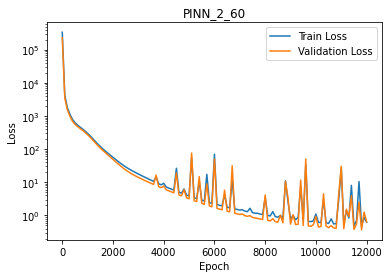

In [16]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

### 4.6. Perform an error analysis

In [17]:
np.random.seed(42)
reduction_method.initialize_testing_set(16, DEIM=25, sampling=EquispacedDistribution())
test_mu = torch.tensor(reduction_method.testing_set)

#### 4.6.1 Greedy PDNN-PINN Error Analysis

In [18]:
pdnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

0:  |F(x)| = 0.176079; step 1
1:  |F(x)| = 0.00625836; step 1
2:  |F(x)| = 0.0035992; step 1
3:  |F(x)| = 0.000360276; step 1
4:  |F(x)| = 9.79952e-05; step 1
5:  |F(x)| = 1.90677e-05; step 1
6:  |F(x)| = 3.37393e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 1.9153; step 1
1:  |F(x)| = 0.138948; step 1
2:  |F(x)| = 0.0970699; step 1
3:  |F(x)| = 0.0429902; step 1
4:  |F(x)| = 0.00342303; step 1
5:  |F(x)| = 0.00388338; step 1
6:  |F(x)| = 0.000836349; step 1
7:  |F(x)| = 0.000298355; step 1
8:  |F(x)| = 0.000161619; step 1
9:  |F(x)| = 1.47415e-05; step 1
10:  |F(x)| = 2.00819e-05; step 1
11:  |F(x)| = 4.20324e-06; step 1
scipy solver converged in 13 iterations.
0:  |F(x)| = 6.63356; step 1
1:  |F(x)| = 1.06961; step 1
2:  |F(x)| = 0.401262; step 1
3:  |F(x)| = 0.380194; step 1
4:  |F(x)| = 0.104876; step 1
5:  |F(x)| = 0.0178805; step 1
6:  |F(x)| = 0.0228464; step 1
7:  |F(x)| = 0.00375909; step 1
8:  |F(x)| = 0.00305874; step 1
9:  |F(x)| = 0.00174812; step 1
10: 

33:  |F(x)| = 0.00248053; step 1
34:  |F(x)| = 0.00323585; step 1
35:  |F(x)| = 0.00227325; step 1
36:  |F(x)| = 0.000529598; step 1
37:  |F(x)| = 0.000340946; step 0.48184
38:  |F(x)| = 0.000293398; step 0.170467
39:  |F(x)| = 0.000272423; step 0.0803138
40:  |F(x)| = 0.000268627; step 0.044276
41:  |F(x)| = 0.000280343; step 0.0267063
42:  |F(x)| = 0.000287528; step 0.0170235
43:  |F(x)| = 0.000292156; step 0.0112387
44:  |F(x)| = 0.000296205; step 0.01
45:  |F(x)| = 0.000695183; step 1
46:  |F(x)| = 0.000501301; step 1
47:  |F(x)| = 0.000146036; step 1
48:  |F(x)| = 9.31498e-05; step 1
49:  |F(x)| = 0.000108247; step 0.448016
50:  |F(x)| = 0.000111469; step 1
51:  |F(x)| = 5.0133e-05; step 1
52:  |F(x)| = 1.46066e-05; step 1
53:  |F(x)| = 1.59579e-05; step 0.394488
54:  |F(x)| = 1.69381e-05; step 0.481121
55:  |F(x)| = 1.78832e-05; step 1
56:  |F(x)| = 7.55255e-06; step 1
57:  |F(x)| = 2.00365e-06; step 1
scipy solver converged in 59 iterations.
0:  |F(x)| = 248.92; step 0.34862
1: 

9:  |F(x)| = 6.56911; step 0.0422931
10:  |F(x)| = 6.48026; step 0.0177958
11:  |F(x)| = 6.4304; step 0.01
12:  |F(x)| = 14.2612; step 1
13:  |F(x)| = 15.2583; step 1
14:  |F(x)| = 8.41649; step 1
15:  |F(x)| = 3.40051; step 1
16:  |F(x)| = 2.25929; step 1
17:  |F(x)| = 1.92019; step 1
18:  |F(x)| = 1.07147; step 1
19:  |F(x)| = 0.269113; step 1
20:  |F(x)| = 0.238908; step 0.262122
21:  |F(x)| = 0.55569; step 1
22:  |F(x)| = 0.567682; step 0.240202
23:  |F(x)| = 0.540172; step 1
24:  |F(x)| = 0.285667; step 1
25:  |F(x)| = 0.103139; step 1
26:  |F(x)| = 0.0698926; step 1
27:  |F(x)| = 0.0619144; step 1
28:  |F(x)| = 0.0485152; step 1
29:  |F(x)| = 0.0102518; step 1
30:  |F(x)| = 0.00852757; step 0.455518
31:  |F(x)| = 0.00823094; step 0.493043
32:  |F(x)| = 0.0102213; step 1
33:  |F(x)| = 0.00813467; step 1
34:  |F(x)| = 0.00258741; step 1
35:  |F(x)| = 0.00170502; step 1
36:  |F(x)| = 0.00345882; step 1
37:  |F(x)| = 0.00303512; step 1
38:  |F(x)| = 0.00179232; step 1
39:  |F(x)| = 0

#### 4.6.2 PRNN Error Analysis

In [19]:
prnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 31 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.02479488532320272	0.02479282100008037	2.1025852976751504e-06
mean	0.5434481860998762	0.5434469461462712	4.332135742813414e-05
max	1.0752578622761382	1.0752479607530125	0.0004552271487244608


#### 4.6.3 PINN Error Analysis

In [20]:
pinn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 31 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.02624680560322401	0.02624485624800747	2.1025852976751504e-06
mean	0.5453848817320021	0.5453844466014897	4.332135742813414e-05
max	1.0943620661921398	1.0943646696736173	0.0004552271487244608
